In [296]:
'''
   Copyright 2023 Spacebel s.a.

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

'\n   Copyright 2023 Spacebel s.a.\n\n   Licensed under the Apache License, Version 2.0 (the "License");\n   you may not use this file except in compliance with the License.\n   You may obtain a copy of the License at\n\n       http://www.apache.org/licenses/LICENSE-2.0\n\n   Unless required by applicable law or agreed to in writing, software\n   distributed under the License is distributed on an "AS IS" BASIS,\n   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n   See the License for the specific language governing permissions and\n   limitations under the License.\n'

# OGC API Features

## Overview

This notebook explains the use of the OGC API Features [[RD20]](#RD20) interface with GeoJSON and other response formats. It uses the `OWSLib` [[RD31]](#RD31) library to access part of the interface. The visualisation of search results is borrowed from the ODC notebook available at [[RD19]](#RD19).

In [297]:
%pip install geopandas
%pip install owslib
%pip install folium matplotlib mapclassify
%pip install jsonpath_ng
# %pip install glom

import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
import pandas as pd  
import json
import requests

from xml.dom import minidom
from IPython.display import HTML, display
from IPython.display import Markdown as md
from owslib.ogcapi.features import Features
from urllib.parse import urlparse, parse_qsl
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
from branca.element import Figure


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))



def curl_command( url: str, method: str = "GET" ) -> str:
    """
    Convert request URL to equivalent curl GET or POST command-line (bash).
    """
    c = "curl -X " + method
    res = urlparse(url)
    if "GET" in method:
        c = c + " -G " + res.scheme + "://" + res.netloc + res.path
    else:
        c = c + " " + res.scheme + "://" + res.netloc + res.path + " \\\n\t--data-raw '{"
    
    lst = parse_qsl(res.query)
    
    first = True 
    for i in lst:
        # print(i[0])
        # add \ to end of previous line
        if "GET" in method:
            c = c + ' \\\n\t--data-urlencode "'+i[0]+'='+i[1]+'"'
        else:
            if not(first):
                c = c + ','
            c = c + '\n\t\t"'+i[0]+'": '+i[1]
        first = False
        
    if "POST" in method:
        c = c + " \\\n\t}'"
    return c


def display_previews(results):
    """
    Helper method for displaying a grid of quicklooks (if available)
    """
    # create figure
    fig = plt.figure(figsize=(20, 20))
  
    # setting values to rows and column variables for the image grid
    rows = 8
    columns = 2
    pos = 1

    for item in results.items():
        # print(item.id)
        assets = item.assets
        try:
            # print("found thumbnail", assets['thumbnail'].href)
            url = assets['thumbnail'].href
            response = requests.get(url)
            Image1 = Image.open(BytesIO(response.content))
            # display at position 'pos'
            fig.add_subplot(rows, columns, pos)
            pos = pos+1
            # show the image
            plt.imshow(Image1)
            plt.axis('off')
            plt.title(item.id)
        except:
            pass
    return

def display_gdf_plot(results):
    """
    Helper method for displaying results as dataframe plot
    """
    # https://github.com/opendatacube/odc-stac (License Apache 2.0)
    # https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map

    # items = list(results.get_items())
    # print(f"Found: {len(items):d} datasets")

    # Convert STAC items into a GeoJSON FeatureCollection
    if (type(results) is dict):
        stac_json = results
    else:
        stac_json = results.get_all_items_as_dict()

    gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

    fig = gdf.plot(
        "date",
        edgecolor="black",
        categorical=True,
        aspect="equal",
        alpha=0.5,
        figsize=(6, 12),
        legend=True,
        legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
    )
    _ = fig.set_title("Query Results")

    # gdf
    return

def display_date_distribution(results):
    """
    Helper method for displaying number of results per year/month as bar chart
    """
    if (type(results) is dict):
        stac_json = results
    else:
        stac_json = results.get_all_items_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json)
    
    # items = list(results.get_items())
    # stac_json = results.get_all_items_as_dict()
    # gdf = gpd.GeoDataFrame.from_features(stac_json)
    
    gdf['start_datetime'] = gdf['date'].map(lambda dt: dt.split("/")[0])

    gdf['date'] = pd.to_datetime(gdf['start_datetime'])
    # create a representation of the month with strfmt
    gdf['year_month'] = gdf['date'].map(lambda dt: dt.strftime('%Y-%m'))
    grouped_df = gdf.groupby('year_month')['year_month'].size().to_frame("count").reset_index()
    grouped_df.plot(kind='bar', x='year_month', y='count')
    return

def display_value_distribution(results, column):
    """
    Helper method for displaying number values in column as bar chart
    """
    if (type(results) is dict):
        stac_json = results
    else:
        stac_json = results.get_all_items_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json)

    # gdf['date'] = pd.to_datetime(gdf['start_datetime'])
    # create a representation of the month with strfmt
    # gdf['year_month'] = gdf['date'].map(lambda dt: dt.strftime('%Y-%m'))

    try:
        grouped_df = gdf.groupby(column)[column].size().to_frame("count").reset_index()
        grouped_df.plot(kind='bar', x=column, y='count')
    except:
        print(column + " values are not available.")

    return

def display_map(results):
    """
    Helper method for displaying results on a map
    """
    # https://github.com/python-visualization/folium/issues/1501
    # if (is_dict):
    if (type(results) is dict):
        stac_json = results
    else:
        stac_json = results.get_all_items_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
    
    fig = Figure(width="800px", height="500px")
    map1 = folium.Map()
    fig.add_child(map1)

    # folium.GeoJson(
    #    shapely.geometry.box(*bbox),  # ??
    #    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    #    name="Query",
    # ).add_to(map1)

    gdf.explore(
        "date", # "start_datetime",
        categorical=True,
    #    tooltip=[
    #        "title", "datetime", "start_datetime", "platform", "instruments"    
    #    ],
        popup=True,
        style_kwds=dict(fillOpacity=0.1, width=2),
        name="Results",
        m=map1,
    )

    map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
    display(fig)
    return



[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [298]:
URL_LANDING_PAGE =  'https://eocat.spacebel.be/'

In [299]:
COLLECTION_ID1 = 'PROBA.CHRIS.1A'
COLLECTION_ID2 = 'SPOT-6.and.7.ESA.archive'  
COLLECTION_ID4 = 'Deimos-1.and.2.ESA.archive' 
COLLECTION_ID2_CLOUDS = 'LANDSAT.ETM.GTC'
COLLECTION_ID3_CLOUDS = 'IKONOS.ESA.archive'

In [300]:
# Specialize the Features class
from owslib.ogcapi.features import Features
from owslib.util import Authentication
from requests import Request
from copy import deepcopy
import urllib.parse

class ApiFeatures(Features):
    
    search_kwargs = []
    search_path = ""

    def __init__(self, url: str, json_: str = None, timeout: int = 30,
                 headers: dict = None, auth: Authentication = None):
        # __doc__ = Collections.__doc__  # noqa
        super().__init__(url, json_, timeout, headers, auth)
        
    def collection_item(self, collection_id: str, identifier: str) -> dict:
        """
        implements /collection/{collectionId}/items
        @returns: feature results
        """
        
        self.search_kwargs = []
        self.search_path = f'collections/{collection_id}/items/{identifier}'
        return super().collection_item(collection_id, identifier)
        
    def collection_items(self, collection_id: str, **kwargs: dict) -> dict:
        """
        implements /collection/{collectionId}/items
        @returns: feature results
        """
        self.search_kwargs = deepcopy(kwargs)
        if 'bbox' in kwargs:
            self.search_kwargs['bbox'] = ','.join(list(map(str, kwargs['bbox'])))
        if 'datetime_' in kwargs:
            self.search_kwargs['datetime'] = kwargs['datetime_']

        # if 'cql' in kwargs:
        #    LOGGER.debug('CQL query detected')
        #    kwargs2 = deepcopy(kwargs)
        #    cql = kwargs2.pop('cql')
        #    path = f'collections/{collection_id}/items?{urlencode(kwargs2)}'
        #    return self._request(method='POST', path=path, data=cql, kwargs=kwargs2)
        # else:
        self.search_path = f'collections/{collection_id}/items'
        #    return self._request(path=path, kwargs=kwargs)
        
        return super().collection_items(collection_id, **kwargs)
    
    def url_with_parameters(self) -> str:
        """Returns previous item search url with parameters, appropriate for a GET request."""
        
        # params = self._clean_params_for_get_request()
        # print("url_with_params: ", self.path, " kwargs: " , self.search_kwargs)
        
        # params = []
        params = self.search_kwargs
        request = Request("GET", self.url + self.search_path, params=params)
        url = request.prepare().url
        if url is None:
            raise ValueError("Could not construct a full url")
        return urllib.parse.unquote(url)


In [301]:
def create_example_table_as_html( mediatypes , chapter: int):
    # Use HTML output as the markdown library output cannot be correctly 
    # be converted to Jupyterbook output.

    text="<table><tr><th align='left'>Example</th><th align='left'>Media type</th></tr>" 

    digit1 = chapter
    digit2 = 1
    for f in mediatypes:
    
        f2 = f
        # f2 = f.replace(";", ";<br>")  # works in VS-Code, not in JupyterBook
        # f2 = f2.replace('"', '\\"')
        #       + '| ' + 'Example '+str(digit1)+ '.' + str(digit2)  \
     
        text = text \
            + '<tr>' + '<td align="left"><a href="#example_' + str(digit1) + '_' + str(digit2)+'">' \
            + 'Example '+str(digit1)+ '.' + str(digit2)+'</a>'  \
            + '</td><td align="left">' + f2  + '</td></tr>`\n'
        digit2 = digit2+1
    
    text = text + "</table>"
    return text

In [302]:
def create_examples_as_md(mediatypes, chapter: int, resource: str, resource_type: str ):
    """
    Insert examples for the resource in all mediatypes and number the
    examples starting n.1, n.2 with n is chapter number provided.
    """

    text = ""
    digit1 = chapter
    digit2 = 1
    for f in mediatypes:
    
        f2 = urllib.parse.quote(f)
    
        if ("?" in resource):
            request = resource +'&httpAccept='+f2 
        else:
            request = resource +'?httpAccept='+f2
       
        # insert an HTML anchor for each example to jump to 
        text = text + '\n' \
            + "<a id='example_" + str(digit1) + '_' + str(digit2) + "'></a>" + '\n' 
    
        text = text + '\n' + '\n' + '\n' \
            + '**Example: '+str(digit1)+ '.' + str(digit2) +'**' + '\n' \
            + '>  Represent ' + resource_type + ' in `' + f + '` media format (`httpAccept`).\n' \
            + '> \n' 
    
        # print("DEBUG f = ", f, "request = ", request)
        # profile string at end of media type may contain "json"...
        # thus xml tested for first.
        
        # 
        curl_str = curl_command(request)
        text = text + "```shell\n" + curl_str + "\n```\n"
        
        if ("xml" in f ):
            # formatting XML output
            response = requests.get(request)
            if response.status_code==200:
                xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
                text = text + "```xml\n" + xmlstr + "\n```\n"
            else:
                text = text + "Media type not supported.\n"
            
        elif ("text/" in f ):
            # formatting text output
            response = requests.get(request)
            # xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
            # text = text + response.text + "\n"
            if response.status_code==200:
                text = text + "```\n" + response.text + "\n```\n"
            else:
                text = text + "Media type not supported.\n"
    
        elif ("json" in f ):
            # formatting JSON output
            # print("URL:",request)
            response = requests.get(request)
            if response.status_code==200:
                data = json.loads(response.text)
                jstr = json.dumps(data, indent=3)
                text = text + '\n' + "```json\n" + jstr + "\n```\n"
            else:
                text = text + "Media type not supported.\n"
        else:
            text = text + "ERROR: Response visualisation not yet supported."
           
        digit2 = digit2+1
    
    return text

In [303]:
w = ApiFeatures(URL_LANDING_PAGE)
w.url

'https://eocat.spacebel.be/'

### Conformance

In [304]:
md(f"The conformance classes supported by OGC API Features interface are listed at `{URL_LANDING_PAGE + 'conformance'}`.")

The conformance classes supported by OGC API Features interface are listed at `https://eocat.spacebel.be/conformance`.

In [305]:
conformance = w.conformance()
conformance

{'conformsTo': ['http://www.opengis.net/spec/owc-geojson/1.0/req/core',
  'http://www.opengis.net/spec/os-geojson/1.0/req/core',
  'http://www.opengis.net/spec/eopad-geojson/1.0/req/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson']}

Same request with `curl`.

In [306]:
curl_str = curl_command(URL_LANDING_PAGE + 'conformance')
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/conformance
```


The conformance response lists supported conformance classes.

### Access API Description

In [307]:
URL_OAI_DEFINITION = URL_LANDING_PAGE + 'api'
# URL_OAI_DEFINITION

In [308]:
curl_str = curl_command(URL_OAI_DEFINITION)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/api
```


In [309]:
# Get OpenAPI definition
jstr = json.dumps(w.api(), indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "x-@context": {
      "geo": "http://a9.com/-/opensearch/extensions/geo/1.0/",
      "semantic": "http://a9.com/-/opensearch/extensions/semantic/1.0/",
      "referrer": "http://a9.com/-/opensearch/extensions/referrer/1.0/",
      "os": "http://a9.com/-/spec/opensearch/1.1/",
      "sru": "http://a9.com/-/opensearch/extensions/sru/2.0/",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "time": "http://a9.com/-/opensearch/extensions/time/1.0/",
      "dc": "http://purl.org/dc/elements/1.1/"
   },
   "components": {
      "schemas": {
         "MultiPoint": {
            "additionalProperties": false,
            "title": "MultiPoint",
            "type": "object",
            "properties": {
               "coordinates": {
                  "minItems": 1,
                  "description": "Array of positions",
                  "title": "coordinates",
                  "type": "array",
                  "items": {
                     "minItems": 2,
                     "maxItems": 2,
                     "description": "One position",
                     "type": "array",
                     "items": {
                        "type": "number"
                     }
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "MultiPoint"
                  ]
               }
            },
            "required": [
               "coordinates",
               "type"
            ]
         },
         "extent": {
            "type": "object",
            "properties": {
               "trs": {
                  "default": "http://www.opengis.net/def/uom/ISO-8601/0/Gregorian",
                  "description": "Temporal reference system of the coordinates in the temporal extent (property `temporal`). In the Core, only the Gregorian calendar is supported. Extensions may support additional temporal reference systems.",
                  "type": "string",
                  "enum": [
                     "http://www.opengis.net/def/uom/ISO-8601/0/Gregorian"
                  ]
               },
               "crs": {
                  "default": "http://www.opengis.net/def/crs/OGC/1.3/CRS84",
                  "description": "Coordinate reference system of the coordinates in the spatial extent (property `spatial`). In the Core, only WGS84 longitude/latitude is supported. Extensions may support additional coordinate reference systems.",
                  "type": "string",
                  "enum": [
                     "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                  ]
               },
               "spatial": {
                  "minItems": 4,
                  "maxItems": 4,
                  "description": "West, south, east, north edges of the spatial extent. The minimum and maximum values apply to the coordinate reference system WGS84 longitude/latitude that is supported in the Core. If, for example, a projected coordinate reference system is used, the minimum and maximum values need to be adjusted.",
                  "type": "array",
                  "items": {
                     "maximum": 180,
                     "type": "number",
                     "minimum": -180
                  },
                  "example": [
                     -180,
                     -90,
                     180,
                     90
                  ]
               },
               "temporal": {
                  "minItems": 2,
                  "maxItems": 2,
                  "description": "Begin and end times of the temporal extent.",
                  "type": "array",
                  "items": {
                     "format": "dateTime",
                     "type": "string"
                  },
                  "example": [
                     "2011-11-11T12:22:11Z",
                     "2012-11-24T12:32:43Z"
                  ]
               }
            }
         },
         "MultiLineString": {
            "additionalProperties": false,
            "title": "MultiLineString",
            "type": "object",
            "properties": {
               "coordinates": {
                  "minItems": 1,
                  "description": "Array of linestring",
                  "title": "coordinates",
                  "type": "array",
                  "items": {
                     "minItems": 2,
                     "description": "Linestring, i.e. array of positions",
                     "type": "array",
                     "items": {
                        "minItems": 2,
                        "maxItems": 2,
                        "description": "Position (longitude, lattitude)",
                        "type": "array",
                        "items": {
                           "type": "number"
                        }
                     }
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "MultiLineString"
                  ]
               }
            },
            "required": [
               "coordinates",
               "type"
            ]
         },
         "Queries": {
            "description": "Object with queries grouped by \"role\".  See also http://www.opensearch.org/Specifications/OpenSearch/1.1#OpenSearch_Query_element",
            "additionalProperties": {
               "minItems": 1,
               "description": "Additional role values as per http://www.opensearch.org/Specifications/OpenSearch/1.1#Role_values.",
               "type": "array",
               "items": {
                  "$ref": "#/components/schemas/Query"
               }
            },
            "type": "object",
            "properties": {
               "type": {
                  "type": "string",
                  "enum": [
                     "Queries"
                  ]
               },
               "@context": {
                  "type": "object"
               }
            }
         },
         "Category": {
            "description": "OGC 14-055r2 \u00a77.1.1.15",
            "additionalProperties": false,
            "type": "object",
            "properties": {
               "scheme": {
                  "format": "uri",
                  "type": "string"
               },
               "term": {
                  "type": "string"
               },
               "label": {
                  "type": "string"
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Category"
                  ]
               }
            },
            "required": [
               "term"
            ]
         },
         "Query": {
            "description": "OpenSearch Query element as defined at http://www.opensearch.org/Specifications/OpenSearch/1.1#OpenSearch_Query_element.",
            "additionalProperties": true,
            "type": "object",
            "properties": {
               "inputEncoding": {
                  "type": "string"
               },
               "totalResults": {
                  "type": "integer",
                  "minimum": 0
               },
               "startIndex": {
                  "type": "integer",
                  "minimum": 0
               },
               "startPage": {
                  "type": "integer",
                  "minimum": 0
               },
               "outputEncoding": {
                  "type": "string"
               },
               "searchTerms": {
                  "type": "string"
               },
               "count": {
                  "type": "integer",
                  "minimum": 0
               },
               "language": {
                  "type": "string"
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Query"
                  ]
               },
               "title": {
                  "type": "string"
               }
            }
         },
         "ExceptionReport": {
            "description": "OGC 06-121r9",
            "type": "object",
            "properties": {
               "type": {
                  "type": "string",
                  "enum": [
                     "ExceptionReport"
                  ]
               },
               "exceptions": {
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Exception"
                  }
               }
            }
         },
         "link": {
            "type": "object",
            "required": [
               "href"
            ],
            "properties": {
               "hreflang": {
                  "type": "string",
                  "example": "en"
               },
               "rel": {
                  "type": "string",
                  "example": "prev"
               },
               "href": {
                  "type": "string"
               },
               "type": {
                  "type": "string",
                  "example": "application/geo+json"
               },
               "title": {
                  "type": "string",
                  "example": "previous page"
               }
            }
         },
         "req-classes": {
            "type": "object",
            "required": [
               "conformsTo"
            ],
            "properties": {
               "conformsTo": {
                  "type": "array",
                  "items": {
                     "type": "string"
                  },
                  "example": [
                     "http://www.opengis.net/spec/eopad-geojson/1.0/req/core",
                     "http://www.opengis.net/spec/os-geojson/1.0/req/core",
                     "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
                  ]
               }
            }
         },
         "Properties": {
            "allOf": [
               {
                  "type": "object",
                  "properties": {
                     "creator": {
                        "description": "OGC 14-055r2",
                        "type": "string"
                     },
                     "subtitle": {
                        "description": "OGC 14-055r2",
                        "type": "string"
                     },
                     "generator": {
                        "$ref": "#/components/schemas/Agent"
                     },
                     "links": {
                        "$ref": "#/components/schemas/Links"
                     },
                     "lang": {
                        "minLength": 2,
                        "description": "OGC 14-055r2",
                        "type": "string"
                     }
                  },
                  "required": [
                     "lang",
                     "links"
                  ]
               },
               {
                  "$ref": "#/components/schemas/CommonProperties"
               }
            ],
            "title": "Properties",
            "type": "object"
         },
         "Feature": {
            "description": "GeoJSON Feature",
            "type": "object",
            "properties": {
               "bbox": {
                  "minItems": 4,
                  "maxItems": 4,
                  "type": "array",
                  "items": {
                     "type": "number"
                  }
               },
               "geometry": {
                  "oneOf": [
                     {
                        "$ref": "#/components/schemas/Geometry"
                     }
                  ],
                  "nullable": true
               },
               "id": {
                  "format": "uri",
                  "type": "string"
               },
               "type": {
                  "title": "type",
                  "type": "string",
                  "enum": [
                     "Feature"
                  ]
               },
               "properties": {
                  "$ref": "#/components/schemas/Properties_"
               }
            },
            "required": [
               "type",
               "id",
               "properties"
            ]
         },
         "collections": {
            "type": "array",
            "items": {
               "$ref": "#/components/schemas/collection"
            }
         },
         "root": {
            "type": "object",
            "required": [
               "links"
            ],
            "properties": {
               "links": {
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/link"
                  }
               }
            }
         },
         "ControlInformation": {
            "type": "object",
            "properties": {
               "totalResults": {
                  "type": "integer",
                  "minimum": 0
               },
               "startIndex": {
                  "type": "integer",
                  "minimum": 0
               },
               "itemsPerPage": {
                  "type": "integer",
                  "minimum": 0
               },
               "queries": {
                  "$ref": "#/components/schemas/Queries"
               }
            },
            "required": [
               "totalResults",
               "startIndex",
               "itemsPerPage"
            ]
         },
         "Polygon": {
            "additionalProperties": false,
            "title": "Polygon",
            "type": "object",
            "properties": {
               "coordinates": {
                  "minItems": 1,
                  "description": "Array of linestrings",
                  "title": "coordinates",
                  "type": "array",
                  "items": {
                     "minItems": 1,
                     "description": "Linear ring, i.e. linestring or array of positions",
                     "type": "array",
                     "items": {
                        "minItems": 2,
                        "maxItems": 2,
                        "description": "One position",
                        "type": "array",
                        "items": {
                           "type": "number"
                        }
                     }
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Polygon"
                  ]
               }
            },
            "required": [
               "coordinates",
               "type"
            ]
         },
         "Agent": {
            "description": "RFC4287 \ufffd3.2 and OGC 14-055r2 \ufffd7.1.1.7, \ufffd7.1.8",
            "type": "object",
            "properties": {
               "name": {
                  "type": "string"
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Agent",
                     "Person",
                     "Organization"
                  ]
               },
               "title": {
                  "description": "OGC 14-055r2 \u00a77.1.8",
                  "type": "string"
               },
               "uri": {
                  "format": "uri",
                  "type": "string"
               },
               "version": {
                  "description": "OGC 14-055r2 \u00a77.1.8",
                  "type": "string"
               },
               "email": {
                  "format": "email",
                  "type": "string"
               }
            },
            "minProperties": 1
         },
         "Properties_": {},
         "Point": {
            "additionalProperties": false,
            "title": "Point",
            "type": "object",
            "properties": {
               "coordinates": {
                  "minItems": 2,
                  "maxItems": 2,
                  "description": "One position (longitude, latitude)",
                  "title": "coordinates",
                  "type": "array",
                  "items": {
                     "type": "number"
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Point"
                  ]
               }
            },
            "required": [
               "coordinates",
               "type"
            ]
         },
         "collection": {
            "type": "object",
            "required": [
               "id",
               "links"
            ],
            "properties": {
               "extent": {
                  "$ref": "#/components/schemas/extent"
               },
               "crs": {
                  "default": [
                     "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
                  ],
                  "description": "the list of coordinate reference systems supported by the API; the first item is the default coordinate reference system",
                  "type": "array",
                  "items": {
                     "type": "string"
                  },
                  "example": [
                     "http://www.opengis.net/def/crs/OGC/1.3/CRS84",
                     "http://www.opengis.net/def/crs/EPSG/0/4326"
                  ]
               },
               "description": {
                  "type": "string"
               },
               "links": {
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/link"
                  }
               },
               "id": {
                  "type": "string"
               },
               "title": {
                  "type": "string"
               }
            }
         },
         "Offering": {
            "description": "Offering as defined in OGC 14-055r2",
            "title": "Offering",
            "type": "object",
            "properties": {
               "code": {
                  "format": "uri",
                  "type": "string"
               },
               "operations": {
                  "type": "array",
                  "items": {
                     "type": "object"
                  }
               },
               "contents": {
                  "type": "array",
                  "items": {
                     "type": "object"
                  }
               },
               "styles": {
                  "type": "array",
                  "items": {
                     "type": "object"
                  }
               }
            },
            "required": [
               "code"
            ]
         },
         "CommonProperties": {
            "type": "object",
            "properties": {
               "date": {
                  "description": "OGC 14-055r2",
                  "type": "string"
               },
               "rights": {
                  "description": "OGC 14-055r2",
                  "type": "string"
               },
               "publisher": {
                  "description": "OGC 14-055r2",
                  "type": "string"
               },
               "categories": {
                  "minItems": 1,
                  "description": "OGC 14-055r2",
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Category"
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Properties"
                  ]
               },
               "title": {
                  "description": "OGC 14-055r2",
                  "type": "string"
               },
               "updated": {
                  "format": "date-time",
                  "description": "OGC 14-055r2",
                  "type": "string"
               },
               "authors": {
                  "minItems": 1,
                  "description": "OGC 14-055r2",
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Agent"
                  }
               }
            },
            "required": [
               "title",
               "updated"
            ]
         },
         "Exception": {
            "description": "OGC 06-121r9",
            "additionalProperties": false,
            "type": "object",
            "properties": {
               "exceptionText": {
                  "description": "Represents ows:exceptionText",
                  "type": "string"
               },
               "exceptionCode": {
                  "format": "uri",
                  "description": "Represents ows:exceptionCode",
                  "type": "string"
               },
               "locator": {
                  "description": "Represents ows:locator.",
                  "type": "string"
               }
            },
            "required": [
               "exceptionCode"
            ]
         },
         "Geometry": {
            "oneOf": [
               {
                  "$ref": "#/components/schemas/Point"
               },
               {
                  "$ref": "#/components/schemas/MultiPoint"
               },
               {
                  "$ref": "#/components/schemas/LineString"
               },
               {
                  "$ref": "#/components/schemas/MultiLineString"
               },
               {
                  "$ref": "#/components/schemas/Polygon"
               },
               {
                  "$ref": "#/components/schemas/MultiPolygon"
               }
            ],
            "title": "Geometry",
            "type": "object"
         },
         "LineString": {
            "additionalProperties": false,
            "title": "LineString",
            "type": "object",
            "properties": {
               "coordinates": {
                  "minItems": 2,
                  "description": "Array of positions",
                  "title": "coordinates",
                  "type": "array",
                  "items": {
                     "minItems": 2,
                     "maxItems": 2,
                     "description": "One position",
                     "type": "array",
                     "items": {
                        "type": "number"
                     }
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "LineString"
                  ]
               }
            },
            "required": [
               "coordinates",
               "type"
            ]
         },
         "MultiPolygon": {
            "additionalProperties": false,
            "title": "MultiPolygon",
            "type": "object",
            "properties": {
               "coordinates": {
                  "minItems": 1,
                  "description": "Array of Polygons",
                  "title": "coordinates",
                  "type": "array",
                  "items": {
                     "minItems": 1,
                     "description": "Array of linestrings",
                     "type": "array",
                     "items": {
                        "description": "Linear ring, i.e. linestring or array of positions",
                        "type": "array",
                        "items": {
                           "minItems": 2,
                           "maxItems": 2,
                           "description": "One position",
                           "type": "array",
                           "items": {
                              "type": "number"
                           }
                        }
                     }
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "MultiPolygon"
                  ]
               }
            },
            "required": [
               "coordinates",
               "type"
            ]
         },
         "FeatureCollection": {
            "allOf": [
               {
                  "type": "object",
                  "properties": {
                     "features": {
                        "minItems": 0,
                        "type": "array",
                        "items": {
                           "$ref": "#/components/schemas/Feature"
                        }
                     },
                     "bbox": {
                        "type": "array",
                        "items": {
                           "type": "object"
                        }
                     },
                     "id": {
                        "format": "uri",
                        "description": "OGC 14-055r2",
                        "type": "string"
                     },
                     "type": {
                        "description": "OGC 14-055r2",
                        "type": "string",
                        "enum": [
                           "FeatureCollection"
                        ]
                     },
                     "@context": {
                        "type": "string"
                     },
                     "properties": {
                        "$ref": "#/components/schemas/Properties"
                     },
                     "exceptions": {
                        "minItems": 1,
                        "type": "array",
                        "items": {
                           "$ref": "#/components/schemas/Exception"
                        }
                     }
                  },
                  "required": [
                     "type",
                     "id",
                     "features"
                  ]
               },
               {
                  "$ref": "#/components/schemas/ControlInformation"
               }
            ],
            "description": "GeoJSON FeatureCollection",
            "type": "object"
         },
         "Links": {
            "description": "OGC 14-055r2",
            "additionalProperties": {
               "minItems": 1,
               "type": "array",
               "items": {
                  "$ref": "#/components/schemas/Link"
               }
            },
            "title": "Links",
            "type": "object",
            "properties": {
               "next": {
                  "minItems": 1,
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "search": {
                  "minItems": 1,
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "related": {
                  "minItems": 1,
                  "description": "OGC 14-055r2",
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "last": {
                  "minItems": 1,
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "previous": {
                  "minItems": 1,
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "profiles": {
                  "minItems": 1,
                  "description": "OGC 14-055r2",
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "describedby": {
                  "minItems": 1,
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "type": {
                  "type": "string",
                  "enum": [
                     "Links"
                  ]
               },
               "alternates": {
                  "minItems": 1,
                  "description": "OGC 14-055r2",
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "first": {
                  "minItems": 1,
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               },
               "via": {
                  "minItems": 1,
                  "description": "OGC 14-055r2",
                  "type": "array",
                  "items": {
                     "$ref": "#/components/schemas/Link"
                  }
               }
            }
         },
         "Link": {
            "description": "OGC 14-055r2",
            "type": "object",
            "properties": {
               "length": {
                  "type": "integer",
                  "exclusiveMinimum": true,
                  "minimum": 0
               },
               "href": {
                  "format": "uri",
                  "type": "string"
               },
               "type": {
                  "description": "MIME type",
                  "type": "string"
               },
               "title": {
                  "type": "string"
               },
               "lang": {
                  "description": "RFC-3066",
                  "type": "string"
               }
            },
            "required": [
               "href"
            ]
         }
      },
      "securitySchemes": {
         "BasicAuth": {
            "scheme": "basic",
            "type": "http"
         }
      }
   },
   "servers": [
      {
         "url": "https://eocat.spacebel.be"
      }
   ],
   "openapi": "3.0.0",
   "x-queries": {
      "example": [
         {
            "eo:parentIdentifier": "TropForest",
            "time:start": "2009-04-01T00:00:00Z",
            "time:end": "2009-04-10T00:00:00Z"
         }
      ]
   },
   "paths": {
      "/collections/datasets/items": {
         "post": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "requestBody": {
               "description": "Insert a new dataset in the catalogue.",
               "required": true,
               "content": {
                  "application/xml": {
                     "schema": {}
                  },
                  "application/gml+xml": {
                     "schema": {}
                  },
                  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"": {
                     "schema": {}
                  },
                  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"": {
                     "schema": {}
                  },
                  "application/zip": {
                     "schema": {}
                  },
                  "application/geo+json": {
                     "schema": {
                        "$ref": "#/components/schemas/Feature"
                     }
                  }
               }
            },
            "description": "Insert a new dataset in the catalogue.",
            "operationId": "Insert",
            "responses": {
               "201": {
                  "description": "Datasets have been successfully inserted."
               },
               "400": {
                  "description": "Bad request."
               },
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "examples": {
                     "LANDSAT.ETM.GTC": {
                        "summary": "LANDSAT.ETM.GTC",
                        "value": "LANDSAT.ETM.GTC"
                     }
                  },
                  "in": "query",
                  "name": "parentIdentifier",
                  "description": "Series identifier.",
                  "x-value": "{eo:parentIdentifier}",
                  "required": false
               }
            ],
            "tags": [
               "Datasets"
            ]
         },
         "get": {
            "summary": "Dataset search (rel=\"results\")",
            "description": "The endpoint returns information about the *EO* dataset matching specific filtering criteria such as platform, instrument and lists the datasets .\n",
            "responses": {
               "200": {
                  "description": "An array of datasets",
                  "content": {
                     "application/ld+json": {
                        "schema": {}
                     },
                     "application/atom+xml": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"https://stacspec.org\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "400": {
                  "description": "Bad request"
               },
               "500": {
                  "description": "Unexpected error"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "parentIdentifier",
                  "description": "The id of the dataset series to retrieve dataset",
                  "x-value": "{eo:parentIdentifier}",
                  "required": false
               },
               {
                  "schema": {
                     "default": "application/geo+json",
                     "type": "string",
                     "enum": [
                        "application/geo+json",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
                        "application/geo+json;profile=\"https://stacspec.org\"",
                        "application/atom+xml",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "dataset"
                     ]
                  },
                  "in": "query",
                  "name": "type",
                  "description": "Query parameter to define which type of resource to be retrieved {dc:type}.",
                  "x-value": "{dc:type}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "default": 10,
                     "format": "int32",
                     "maximum": 50,
                     "type": "integer",
                     "exclusiveMinimum": false,
                     "minimum": 0
                  },
                  "in": "query",
                  "name": "limit",
                  "description": "Number of records {os:count}.",
                  "x-value": "{count}",
                  "required": false
               },
               {
                  "schema": {
                     "default": 1,
                     "format": "int32",
                     "type": "integer",
                     "minimum": 1
                  },
                  "in": "query",
                  "name": "startRecord",
                  "description": "Start index of first result {os:startIndex}.",
                  "x-value": "{startIndex}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "int32",
                     "type": "integer",
                     "minimum": 1
                  },
                  "in": "query",
                  "name": "startPage",
                  "description": "Start index of first result page {os:startPage}.",
                  "x-value": "{startPage}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "allowEmptyValue": true,
                  "name": "datetime",
                  "description": "Start and(or) end datetime of temporal constraint {time:start}/{time:end}.",
                  "x-value": "{time:start}/{time:end}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "bbox",
                  "description": "Area of interest {geo:box}.",
                  "x-value": "{geo:box}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "format": "double",
                     "maximum": 90,
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": -90
                  },
                  "in": "query",
                  "name": "lat",
                  "description": "Latitude of center of area of interest {geo:lat}.",
                  "x-value": "{geo:lat}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "format": "double",
                     "maximum": 180,
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": -180
                  },
                  "in": "query",
                  "name": "lon",
                  "description": "Longitude of center of area of interest {geo:lon}.",
                  "x-value": "{geo:lon}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "name",
                  "description": "Name of area of interest {geo:name}.",
                  "x-value": "{geo:name}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": 0
                  },
                  "in": "query",
                  "name": "radius",
                  "description": "Radius of area of interest {geo:radius} in meters.  Is combined with {geo:lon} and {geo:lat} or {geo:name}.",
                  "x-value": "{geo:radius}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "geometry",
                  "description": "Area of interest in WKT format {geo:geometry}.",
                  "x-value": "{geo:geometry}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "uid",
                  "description": "Local identifier {geo:uid} of the dataset series returned as \\<dc:identifier\\> in response.",
                  "x-value": "{geo:uid}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "platform",
                  "description": "Satellite name {eo:platform}.",
                  "x-value": "{eo:platform}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "platformSerialIdentifier",
                  "description": "Satellite serial identifier {eo:platformSerialIdentifier}.",
                  "x-value": "{eo:platformSerialIdentifier}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "instrument",
                  "description": "Instrument name {eo:instrument}.",
                  "x-value": "{eo:instrument}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "sensorType",
                  "description": "Sensor type {eo:sensorType}.",
                  "x-value": "{eo:sensorType}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "resolution",
                  "description": "Sensor resolution {eo:resolution}.",
                  "x-value": "{eo:resolution}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "date-time",
                     "type": "string"
                  },
                  "in": "query",
                  "name": "creationDate",
                  "description": "Creation date of the datasets {eo:creationDate}.",
                  "x-value": "{eo:creationDate}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "date-time",
                     "type": "string"
                  },
                  "in": "query",
                  "name": "modificationDate",
                  "description": "Modification date of the datasets {eo:modificationDate}.",
                  "x-value": "{eo:modificationDate}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "ARCHIVED",
                        "ACQUIRED",
                        "CANCELLED"
                     ]
                  },
                  "in": "query",
                  "name": "productionStatus",
                  "description": "Status of the datasets {eo:productionStatus}.",
                  "x-value": "{eo:productionStatus}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "NOMINAL",
                        "CALIBRATION",
                        "OTHER"
                     ]
                  },
                  "in": "query",
                  "name": "acquisitionType",
                  "description": "AcquisitionType of the datasets {eo:acquisitionType}.",
                  "x-value": "{eo:acquisitionType}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "integer"
                  },
                  "in": "query",
                  "name": "orbitNumber",
                  "description": "Orbit number {eo:orbitNumber}.",
                  "x-value": "{eo:orbitNumber}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "ASCENDING",
                        "DESCENDING"
                     ]
                  },
                  "in": "query",
                  "name": "orbitDirection",
                  "description": "Orbit direction{eo:orbitDirection}.",
                  "x-value": "{eo:orbitDirection}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "track",
                  "description": "Track {eo:track}.",
                  "x-value": "{eo:track}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "frame",
                  "description": "Frame {eo:frame}.",
                  "x-value": "{eo:frame}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "swathIdentifier",
                  "description": "Swath identifier {eo:swathIdentifier}.",
                  "x-value": "{eo:swathIdentifier}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "lowestLocation",
                  "description": "Lowest location {eo:lowestLocation}.",
                  "x-value": "{eo:lowestLocation}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "highestLocation",
                  "description": "Highest location {eo:highestLocation}.",
                  "x-value": "{eo:highestLocation}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "productVersion",
                  "description": "Product version {eo:productVersion}.",
                  "x-value": "{eo:productVersion}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "productQualityStatus",
                  "description": "Product quality status {eo:productQualityStatus}.",
                  "x-value": "{eo:productQualityStatus}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "productQualityDegradationTag",
                  "description": "Product quality degradation tag {eo:productQualityDegradationTag}.",
                  "x-value": "{eo:productQualityDegradationTag}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processorName",
                  "description": "Processor mame {eo:processorName}.",
                  "x-value": "{eo:processorName}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processingCenter",
                  "description": "Processing center {eo:processingCenter}.",
                  "x-value": "{eo:processingCenter}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "date-time",
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processingDate",
                  "description": "Processing date {eo:processingDate}.",
                  "x-value": "{eo:processingDate}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "sensorMode",
                  "description": "Sensor mode {eo:sensorMode}.",
                  "x-value": "{eo:sensorMode}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "archivingCenter",
                  "description": "Archiving center {eo:archivingCenter}.",
                  "x-value": "{eo:archivingCenter}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processingMode",
                  "description": "Processing mode {eo:processingMode}.",
                  "x-value": "{eo:processingMode}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "acquisitionStation",
                  "description": "Acquisition station {eo:acquisitionStation}.",
                  "x-value": "{eo:acquisitionStation}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "acquisitionSubType",
                  "description": "Acquisition sub type {eo:acquisitionSubType}.",
                  "x-value": "{eo:acquisitionSubType}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "startTimeFromAscendingNode",
                  "description": "Start time from ascending node {eo:startTimeFromAscendingNode}.",
                  "x-value": "{eo:startTimeFromAscendingNode}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "completionTimeFromAscendingNode",
                  "description": "Completion time from ascending node {eo:completionTimeFromAscendingNode}.",
                  "x-value": "{eo:completionTimeFromAscendingNode}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "illuminationAzimuthAngle",
                  "description": "Illumination azimuth angle {eo:illuminationAzimuthAngle}.",
                  "x-value": "{eo:illuminationAzimuthAngle}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "illuminationZenithAngle",
                  "description": "Illumination zenit angle {eo:illuminationZenithAngle}.",
                  "x-value": "{eo:illuminationZenithAngle}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number"
                  },
                  "in": "query",
                  "name": "illuminationElevationAngle",
                  "description": "Illumination elevation angle {eo:illuminationElevationAngle}.",
                  "x-value": "{eo:illuminationElevationAngle}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "productType",
                  "description": "Product Type {eo:productType}.",
                  "x-value": "{eo:productType}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processingLevel",
                  "description": "Processing level {eo:processingLevel}.",
                  "x-value": "{eo:processingLevel}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "doi",
                  "description": "Doi {eo:doi}.",
                  "x-value": "{eo:doi}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "facetLimit",
                  "description": "facetLimit {sru:facetLimit}.",
                  "x-value": "{sru:facetLimit}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "sortKeys",
                  "description": "sortKeys {sru:sortKeys}.",
                  "x-value": "{sru:sortKeys}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "source",
                  "description": "source {referrer:source}.",
                  "x-value": "{referrer:source}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "owc"
                     ]
                  },
                  "in": "query",
                  "name": "mode",
                  "description": "GeoJSON mode (feature or OpenSearch). Use 'owc' for OpenSearch",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "default",
                        "esa"
                     ]
                  },
                  "in": "query",
                  "name": "stylesheet",
                  "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype with the presence of {geo:uid}).",
                  "x-value": "{sru:stylesheet}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "om",
                        "om10",
                        "server-choice"
                     ]
                  },
                  "in": "query",
                  "name": "recordSchema",
                  "description": "Record schema {sru:recordSchema}.",
                  "x-value": "{sru:recordSchema}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "classifiedAs",
                  "description": "Keyword URI appearing in metadata record {semantic:classifiedAs}.",
                  "x-value": "{semantic:classifiedAs}",
                  "required": false
               }
            ],
            "tags": [
               "Datasets"
            ]
         },
         "delete": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "description": "Delete all datasets of a dataset series.",
            "responses": {
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "204": {
                  "description": "Dataset has been deleted."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "parentIdentifier",
                  "description": "Series identifier.",
                  "x-value": "{eo:parentIdentifier}",
                  "required": false
               }
            ],
            "tags": [
               "Datasets"
            ]
         }
      },
      "/collections/services/items/{serviceId}": {
         "get": {
            "description": "Search a service rom the catalogue.",
            "responses": {
               "200": {
                  "description": "The requested service.",
                  "content": {
                     "application/vnd.iso.19139+xml": {
                        "schema": {}
                     },
                     "application/ld+json": {
                        "schema": {}
                     },
                     "application/atom+xml": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "400": {
                  "description": "Bad request."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "404": {
                  "description": "Service not found"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "serviceId",
                  "description": "service identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "default",
                        "esa"
                     ]
                  },
                  "in": "query",
                  "name": "stylesheet",
                  "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype.",
                  "x-value": "{sru:stylesheet}",
                  "required": false
               },
               {
                  "schema": {
                     "default": "application/geo+json",
                     "type": "string",
                     "enum": [
                        "application/geo+json",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
                        "application/json",
                        "application/atom+xml",
                        "application/vnd.iso.19139+xml",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "Service"
            ]
         },
         "delete": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "description": "Delete a service.",
            "responses": {
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "204": {
                  "description": "Service has been deleted."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "serviceId",
                  "description": "service identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               }
            ],
            "tags": [
               "Service"
            ]
         },
         "put": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "requestBody": {
               "description": "Update a service in the catalogue.",
               "required": true,
               "content": {
                  "application/xml": {
                     "schema": {}
                  },
                  "application/vnd.iso.19139+xml": {
                     "schema": {}
                  },
                  "application/geo+json": {
                     "schema": {
                        "$ref": "#/components/schemas/Feature"
                     }
                  }
               }
            },
            "description": "Update a service in the catalogue.",
            "responses": {
               "200": {
                  "description": "Service has been successfully updated."
               },
               "400": {
                  "description": "Bad request."
               },
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "404": {
                  "description": "Service not found."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "serviceId",
                  "description": "service identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               }
            ],
            "tags": [
               "Service"
            ]
         }
      },
      "/conformance": {
         "get": {
            "summary": "provide conformance class information (rel=\"conformance\").",
            "description": "Get conformance class information.",
            "responses": {
               "200": {
                  "description": "conformance class information is successfully returned",
                  "content": {
                     "application/ld+json": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "application/json": {
                        "schema": {
                           "$ref": "#/components/schemas/req-classes"
                        },
                        "example": {
                           "conformsTo": [
                              "http://www.opengis.net/spec/eopad-geojson/1.0/req/core",
                              "http://www.opengis.net/spec/os-geojson/1.0/req/core",
                              "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
                           ]
                        }
                     }
                  }
               },
               "500": {
                  "description": "Unexpected error"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "application/json",
                     "type": "string",
                     "enum": [
                        "application/json",
                        "text/html"
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "Conformance"
            ]
         }
      },
      "/collections/series/items": {
         "post": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "requestBody": {
               "description": "Insert a new series in the catalogue.",
               "required": true,
               "content": {
                  "application/xml": {
                     "schema": {}
                  },
                  "application/vnd.iso.19139+xml": {
                     "schema": {}
                  },
                  "application/vnd.iso.19139-2+xml": {
                     "schema": {}
                  },
                  "application/zip": {
                     "schema": {}
                  },
                  "application/geo+json": {
                     "schema": {
                        "$ref": "#/components/schemas/Feature"
                     }
                  }
               }
            },
            "description": "Insert a new series in the catalogue.",
            "responses": {
               "201": {
                  "description": "Series have been successfully inserted."
               },
               "400": {
                  "description": "Bad request."
               },
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "tags": [
               "Series"
            ]
         },
         "get": {
            "description": "Search for series from the catalogue.",
            "responses": {
               "200": {
                  "description": "An array of series",
                  "content": {
                     "application/ld+json": {
                        "schema": {}
                     },
                     "application/atom+xml": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"https://stacspec.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "400": {
                  "description": "Bad request."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "application/geo+json",
                     "type": "string",
                     "enum": [
                        "application/geo+json",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
                        "application/geo+json;profile=\"https://stacspec.org\"",
                        "application/atom+xml",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "collection"
                     ]
                  },
                  "in": "query",
                  "name": "type",
                  "description": "Query parameter to define which type of resource to be retrieved {dc:type}.",
                  "x-value": "{dc:type}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "EOP:ESA:EARTH-ONLINE"
                     ]
                  },
                  "in": "query",
                  "name": "parentIdentifier",
                  "description": "Parent identifier {eo:parentIdentifier}.",
                  "x-value": "{eo:parentIdentifier}",
                  "required": false
               },
               {
                  "schema": {
                     "default": 1,
                     "format": "int32",
                     "type": "integer",
                     "minimum": 1
                  },
                  "in": "query",
                  "name": "startRecord",
                  "description": "Start index of first result {os:startIndex}.",
                  "x-value": "{startIndex}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "int32",
                     "type": "integer",
                     "minimum": 1
                  },
                  "in": "query",
                  "name": "startPage",
                  "description": "Start index of first result page {os:startPage}.",
                  "x-value": "{startPage}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "default": 10,
                     "format": "int32",
                     "maximum": 50,
                     "type": "integer",
                     "exclusiveMinimum": false,
                     "minimum": 0
                  },
                  "in": "query",
                  "name": "limit",
                  "description": "Number of records {os:count}.",
                  "x-value": "{count}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "query",
                  "description": "Free text search term {os:searchTerms}.",
                  "x-value": "{searchTerms}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "subject",
                  "description": "Keyword appearing in metadata record {dc:subject}.",
                  "x-value": "{dc:subject}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "title",
                  "description": "Metadata record title {dc:title}.",
                  "x-value": "{dc:title}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "allowEmptyValue": true,
                  "name": "datetime",
                  "description": "Start and(or) end datetime of temporal constraint {time:start}/{time:end}.",
                  "x-value": "{time:start}/{time:end}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "bbox",
                  "description": "Area of interest {geo:box}.",
                  "x-value": "{geo:box}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "format": "double",
                     "maximum": 90,
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": -90
                  },
                  "in": "query",
                  "name": "lat",
                  "description": "Latitude of center of area of interest {geo:lat}.",
                  "x-value": "{geo:lat}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "format": "double",
                     "maximum": 180,
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": -180
                  },
                  "in": "query",
                  "name": "lon",
                  "description": "Longitude of center of area of interest {geo:lon}.",
                  "x-value": "{geo:lon}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "name",
                  "description": "Name of area of interest {geo:name}.",
                  "x-value": "{geo:name}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": 0
                  },
                  "in": "query",
                  "name": "radius",
                  "description": "Radius of area of interest {geo:radius} in meters.  Is combined with {geo:lon} and {geo:lat} or {geo:name}.",
                  "x-value": "{geo:radius}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "geometry",
                  "description": "Area of interest in WKT format {geo:geometry}.",
                  "x-value": "{geo:geometry}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "uid",
                  "description": "Local identifier {geo:uid} of the dataset series returned as \\<dc:identifier\\> in response.",
                  "x-value": "{geo:uid}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "doi",
                  "description": "Doi {eo:doi}.",
                  "x-value": "{eo:doi}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "publisher",
                  "description": "Name of data provider {dc:publisher}.",
                  "x-value": "{dc:publisher}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "organisationName",
                  "description": "Name of data provider {eo:organisationName}.",
                  "x-value": "{eo:organisationName}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "platform",
                  "description": "Satellite name {eo:platform}.",
                  "x-value": "{eo:platform}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "instrument",
                  "description": "Instrument name {eo:instrument}.",
                  "x-value": "{eo:instrument}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processingLevel",
                  "description": "processing level {eo:processingLevel}.",
                  "x-value": "{eo:processingLevel}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "useLimitation",
                  "description": "use limitation {eo:useLimitation}.",
                  "x-value": "{eo:useLimitation}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "otherConstraint",
                  "description": "other constraint {eo:otherConstraint}.",
                  "x-value": "{eo:otherConstraint}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "classifiedAs",
                  "description": "Keyword URI appearing in metadata record {semantic:classifiedAs}.",
                  "x-value": "{semantic:classifiedAs}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "offering",
                  "description": "offering {eo:offering}.",
                  "x-value": "{eo:offering}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "facetLimit",
                  "description": "facetLimit {sru:facetLimit}.",
                  "x-value": "{sru:facetLimit}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "sortKeys",
                  "description": "sortKeys {sru:sortKeys}.",
                  "x-value": "{sru:sortKeys}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "source",
                  "description": "source {referrer:source}.",
                  "x-value": "{referrer:source}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "owc"
                     ]
                  },
                  "in": "query",
                  "name": "mode",
                  "description": "GeoJSON mode (feature or OpenSearch). Use 'owc' for OpenSearch",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "default",
                        "esa"
                     ]
                  },
                  "in": "query",
                  "name": "stylesheet",
                  "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype with the presence of {geo:uid}).",
                  "x-value": "{sru:stylesheet}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "iso",
                        "iso19139-2",
                        "iso19115",
                        "iso19115-3",
                        "dif10",
                        "dc",
                        "server-choice"
                     ]
                  },
                  "in": "query",
                  "name": "recordSchema",
                  "description": "Record schema {sru:recordSchema}.",
                  "x-value": "{sru:recordSchema}",
                  "required": false
               }
            ],
            "tags": [
               "Series"
            ]
         },
         "delete": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "description": "Delete series.",
            "responses": {
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "204": {
                  "description": "Series has been deleted."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "parentIdentifier",
                  "description": "parent (endpoint) identifier.",
                  "x-value": "{eo:parentIdentifier}",
                  "required": false
               }
            ],
            "tags": [
               "Series"
            ]
         }
      },
      "/collections/series/items/{seriesId}": {
         "get": {
            "description": "Search a series from the catalogue.",
            "responses": {
               "200": {
                  "description": "The requested series.",
                  "content": {
                     "application/vnd.iso.19139+xml": {
                        "schema": {}
                     },
                     "application/xml": {
                        "schema": {}
                     },
                     "application/ld+json": {
                        "schema": {}
                     },
                     "application/json": {
                        "schema": {}
                     },
                     "application/atom+xml": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/dif10+xml": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/vnd.iso.19115-3+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/vnd.iso.19139-2+xml": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "400": {
                  "description": "Bad request."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "404": {
                  "description": "Series not found"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "seriesId",
                  "description": "series identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "default",
                        "esa"
                     ]
                  },
                  "in": "query",
                  "name": "stylesheet",
                  "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype.",
                  "x-value": "{sru:stylesheet}",
                  "required": false
               },
               {
                  "schema": {
                     "default": "application/geo+json",
                     "type": "string",
                     "enum": [
                        "application/geo+json",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
                        "application/json",
                        "application/atom+xml",
                        "application/vnd.iso.19139+xml",
                        "application/vnd.iso.19139-2+xml",
                        "application/iso19115+xml",
                        "application/vnd.iso.19115-3+xml",
                        "application/dif10+xml",
                        "application/xml",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "aSeries"
            ]
         },
         "delete": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "description": "Delete a series.",
            "responses": {
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "204": {
                  "description": "Series has been deleted."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "seriesId",
                  "description": "series identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               }
            ],
            "tags": [
               "aSeries"
            ]
         },
         "put": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "requestBody": {
               "description": "Update a series in the catalogue.",
               "required": true,
               "content": {
                  "application/xml": {
                     "schema": {}
                  },
                  "application/vnd.iso.19139+xml": {
                     "schema": {}
                  },
                  "application/vnd.iso.19139-2+xml": {
                     "schema": {}
                  },
                  "application/geo+json": {
                     "schema": {
                        "$ref": "#/components/schemas/Feature"
                     }
                  }
               }
            },
            "description": "Update a series in the catalogue.",
            "responses": {
               "200": {
                  "description": "Series has been successfully updated."
               },
               "400": {
                  "description": "Bad request."
               },
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "404": {
                  "description": "Series not found."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "seriesId",
                  "description": "series identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               }
            ],
            "tags": [
               "aSeries"
            ]
         }
      },
      "/collections/datasets/items/{datasetId}": {
         "get": {
            "description": "Search a dataset from the catalogue.",
            "operationId": "Search",
            "responses": {
               "200": {
                  "description": "The requested dataset",
                  "content": {
                     "application/gml+xml": {
                        "schema": {}
                     },
                     "application/ld+json": {
                        "schema": {}
                     },
                     "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"": {
                        "schema": {}
                     },
                     "application/atom+xml": {
                        "schema": {}
                     },
                     "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"https://stacspec.org\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json": {
                        "schema": {
                           "$ref": "#/components/schemas/Feature"
                        },
                        "example": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "400": {
                  "description": "Bad request"
               },
               "500": {
                  "description": "Unexpected error"
               },
               "404": {
                  "description": "Dataset not found"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "datasetId",
                  "description": "Dataset identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "default",
                        "esa"
                     ]
                  },
                  "in": "query",
                  "name": "stylesheet",
                  "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype.",
                  "x-value": "{sru:stylesheet}",
                  "required": false
               },
               {
                  "schema": {
                     "default": "application/geo+json",
                     "type": "string",
                     "enum": [
                        "application/geo+json",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
                        "application/geo+json;profile=\"https://stacspec.org\"",
                        "application/atom+xml",
                        "application/gml+xml",
                        "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
                        "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "Dataset"
            ]
         },
         "delete": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "description": "Delete a dataset from the catalogue.",
            "operationId": "Delete",
            "responses": {
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "204": {
                  "description": "Dataset has been deleted."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "datasetId",
                  "description": "Dataset identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               }
            ],
            "tags": [
               "Dataset"
            ]
         },
         "put": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "requestBody": {
               "description": "Update a dataset in the catalogue.",
               "required": true,
               "content": {
                  "application/xml": {
                     "schema": {}
                  },
                  "application/gml+xml": {
                     "schema": {}
                  },
                  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"": {
                     "schema": {}
                  },
                  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"": {
                     "schema": {}
                  },
                  "application/geo+json": {
                     "schema": {
                        "$ref": "#/components/schemas/Feature"
                     }
                  }
               }
            },
            "description": "Update a dataset in the catalogue.",
            "operationId": "Update",
            "responses": {
               "200": {
                  "description": "Dataset has been successfully updated."
               },
               "400": {
                  "description": "Bad request."
               },
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "404": {
                  "description": "Dataset not found."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "datasetId",
                  "description": "Dataset identifier.",
                  "x-value": "{geo:uid}",
                  "required": true
               }
            ],
            "tags": [
               "Dataset"
            ]
         }
      },
      "/collections": {
         "get": {
            "summary": "Metadata about the feature collections",
            "description": "Metadata about the feature collections.",
            "responses": {
               "200": {
                  "description": "metadata about the feature collections is successfully returned",
                  "content": {
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json": {
                        "schema": {
                           "$ref": "#/components/schemas/collections"
                        },
                        "example": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "application/json": {
                        "schema": {
                           "$ref": "#/components/schemas/collections"
                        },
                        "example": {
                           "collections": [
                              {
                                 "description": "Metadata records representing EO services and applications.",
                                 "links": [
                                    {
                                       "rel": "items",
                                       "href": "https://eocat.spacebel.be/collections/services",
                                       "type": "application/geo+json",
                                       "title": "Services and applications"
                                    }
                                 ],
                                 "id": "services",
                                 "title": "EO services and applications"
                              },
                              {
                                 "description": "Metadata records representing EO series (a.k.a. EO collections).",
                                 "links": [
                                    {
                                       "rel": "items",
                                       "href": "https://eocat.spacebel.be/collections/series",
                                       "type": "application/geo+json",
                                       "title": "Series"
                                    }
                                 ],
                                 "id": "series",
                                 "title": "EO Series"
                              },
                              {
                                 "description": "Metadata records representing EO datasets (a.k.a. EO products).",
                                 "links": [
                                    {
                                       "rel": "items",
                                       "href": "https://eocat.spacebel.be/collections/datasets",
                                       "type": "application/geo+json",
                                       "title": "Datasets"
                                    }
                                 ],
                                 "id": "datasets",
                                 "title": "EO Products"
                              }
                           ],
                           "links": [
                              {
                                 "rel": "self",
                                 "href": "https://eocat.spacebel.be/collections",
                                 "type": "application/json",
                                 "title": "this document"
                              }
                           ]
                        }
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {
                           "$ref": "#/components/schemas/collections"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "500": {
                  "description": "Unexpected error"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "application/json",
                     "type": "string",
                     "enum": [
                        "application/json",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "Collections"
            ]
         }
      },
      "/collections/{collectionId}": {
         "get": {
            "summary": "Metadata about a feature collection",
            "description": "Metadata about a feature collection.",
            "responses": {
               "200": {
                  "description": "metadata about a feature collection is successfully returned",
                  "content": {
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json": {
                        "schema": {
                           "$ref": "#/components/schemas/collection"
                        },
                        "example": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "application/json": {
                        "schema": {
                           "$ref": "#/components/schemas/collection"
                        },
                        "example": {
                           "description": "Metadata records representing EO services and applications.",
                           "links": [
                              {
                                 "rel": "items",
                                 "href": "https://eocat.spacebel.be/collections/services",
                                 "type": "application/geo+json",
                                 "title": "Services and applications"
                              }
                           ],
                           "id": "services",
                           "title": "EO services and applications"
                        }
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {
                           "$ref": "#/components/schemas/collection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "500": {
                  "description": "Unexpected error"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "series",
                     "type": "string",
                     "enum": [
                        "services",
                        "series",
                        "datasets"
                     ]
                  },
                  "in": "path",
                  "name": "collectionId",
                  "description": "Collection identifier.",
                  "required": true
               },
               {
                  "schema": {
                     "default": "application/json",
                     "type": "string",
                     "enum": [
                        "application/json",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "Collections"
            ]
         }
      },
      "/api": {
         "get": {
            "summary": "Describe the catalogue interface (rel=\"service-desc\")",
            "description": "Get catalogue interface description.",
            "operationId": "Describe",
            "responses": {
               "200": {
                  "description": "OSDD is successfully returned",
                  "content": {
                     "application/opensearchdescription+xml": {},
                     "application/openapi+json;version=3.0": {},
                     "application/sru+xml": {},
                     "application/json;profile=http://explain.z3950.org/dtd/2.0/": {}
                  }
               },
               "400": {
                  "description": "Bad request."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "application/openapi+json;version=3.0",
                     "type": "string",
                     "enum": [
                        "application/opensearchdescription+xml",
                        "application/sru+xml",
                        "application/json;profile=http://explain.z3950.org/dtd/2.0/",
                        "application/openapi+json;version=3.0"
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "source",
                  "description": "source {referrer:source}.",
                  "x-value": "{referrer:source}",
                  "required": false
               }
            ],
            "tags": [
               "APIDefinition"
            ]
         }
      },
      "/collections/series/items/{seriesId}/api": {
         "get": {
            "description": "Get OSDD of a series.",
            "responses": {
               "200": {
                  "description": "OSDD is successfully returned"
               },
               "400": {
                  "description": "Bad request."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "404": {
                  "description": "Dataset series not searchable."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "path",
                  "name": "seriesId",
                  "description": "Series identifier.",
                  "x-value": "{eo:parentIdentifier}",
                  "required": true
               }
            ],
            "tags": [
               "APIDefinition"
            ]
         }
      },
      "/collections/services/items": {
         "post": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "requestBody": {
               "description": "Insert a new service in the catalogue.",
               "required": true,
               "content": {
                  "application/xml": {
                     "schema": {}
                  },
                  "application/vnd.iso.19139+xml": {
                     "schema": {}
                  },
                  "application/zip": {
                     "schema": {}
                  },
                  "application/geo+json": {
                     "schema": {
                        "$ref": "#/components/schemas/Feature"
                     }
                  }
               }
            },
            "description": "Insert a new service in the catalogue.",
            "responses": {
               "201": {
                  "description": "Services have been successfully inserted."
               },
               "400": {
                  "description": "Bad request."
               },
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "tags": [
               "Services"
            ]
         },
         "get": {
            "description": "Search for service from the catalogue.",
            "responses": {
               "200": {
                  "description": "An array of services",
                  "content": {
                     "application/ld+json": {
                        "schema": {}
                     },
                     "application/atom+xml": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"https://stacspec.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/geo+json": {
                        "schema": {
                           "$ref": "#/components/schemas/FeatureCollection"
                        },
                        "example": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "400": {
                  "description": "Bad request."
               },
               "500": {
                  "description": "Unexpected error."
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "application/geo+json",
                     "type": "string",
                     "enum": [
                        "application/geo+json",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
                        "application/geo+json;profile=\"https://stacspec.org\"",
                        "application/atom+xml",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "service"
                     ]
                  },
                  "in": "query",
                  "name": "type",
                  "description": "Query parameter to define which type of resource to be retrieved {dc:type}.",
                  "x-value": "{dc:type}",
                  "required": false
               },
               {
                  "schema": {
                     "default": 1,
                     "format": "int32",
                     "type": "integer",
                     "minimum": 1
                  },
                  "in": "query",
                  "name": "startRecord",
                  "description": "Start index of first result {os:startIndex}.",
                  "x-value": "{startIndex}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "int32",
                     "type": "integer",
                     "minimum": 1
                  },
                  "in": "query",
                  "name": "startPage",
                  "description": "Start index of first result page {os:startPage}.",
                  "x-value": "{startPage}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "default": 10,
                     "format": "int32",
                     "maximum": 50,
                     "type": "integer",
                     "exclusiveMinimum": false,
                     "minimum": 0
                  },
                  "in": "query",
                  "name": "limit",
                  "description": "Number of records {os:count}.",
                  "x-value": "{count}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "query",
                  "description": "Free text search term {os:searchTerms}.",
                  "x-value": "{searchTerms}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "subject",
                  "description": "Keyword appearing in metadata record {dc:subject}.",
                  "x-value": "{dc:subject}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "title",
                  "description": "Metadata record title {dc:title}.",
                  "x-value": "{dc:title}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "allowEmptyValue": true,
                  "name": "datetime",
                  "description": "Start and(or) end datetime of temporal constraint {time:start}/{time:end}.",
                  "x-value": "{time:start}/{time:end}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "bbox",
                  "description": "Area of interest {geo:box}.",
                  "x-value": "{geo:box}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "format": "double",
                     "maximum": 90,
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": -90
                  },
                  "in": "query",
                  "name": "lat",
                  "description": "Latitude of center of area of interest {geo:lat}.",
                  "x-value": "{geo:lat}",
                  "required": false
               },
               {
                  "schema": {
                     "exclusiveMaximum": false,
                     "format": "double",
                     "maximum": 180,
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": -180
                  },
                  "in": "query",
                  "name": "lon",
                  "description": "Longitude of center of area of interest {geo:lon}.",
                  "x-value": "{geo:lon}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "name",
                  "description": "Name of area of interest {geo:name}.",
                  "x-value": "{geo:name}",
                  "required": false
               },
               {
                  "schema": {
                     "format": "double",
                     "type": "number",
                     "exclusiveMinimum": false,
                     "minimum": 0
                  },
                  "in": "query",
                  "name": "radius",
                  "description": "Radius of area of interest {geo:radius} in meters.  Is combined with {geo:lon} and {geo:lat} or {geo:name}.",
                  "x-value": "{geo:radius}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "geometry",
                  "description": "Area of interest in WKT format {geo:geometry}.",
                  "x-value": "{geo:geometry}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "uid",
                  "description": "Local identifier {geo:uid} of the dataset series returned as \\<dc:identifier\\> in response.",
                  "x-value": "{geo:uid}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "doi",
                  "description": "Doi {eo:doi}.",
                  "x-value": "{eo:doi}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "publisher",
                  "description": "Name of data provider {dc:publisher}.",
                  "x-value": "{dc:publisher}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "organisationName",
                  "description": "Name of data provider {eo:organisationName}.",
                  "x-value": "{eo:organisationName}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "platform",
                  "description": "Satellite name {eo:platform}.",
                  "x-value": "{eo:platform}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "instrument",
                  "description": "Instrument name {eo:instrument}.",
                  "x-value": "{eo:instrument}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "processingLevel",
                  "description": "processing level {eo:processingLevel}.",
                  "x-value": "{eo:processingLevel}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "useLimitation",
                  "description": "use limitation {eo:useLimitation}.",
                  "x-value": "{eo:useLimitation}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "otherConstraint",
                  "description": "other constraint {eo:otherConstraint}.",
                  "x-value": "{eo:otherConstraint}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "classifiedAs",
                  "description": "Keyword URI appearing in metadata record {semantic:classifiedAs}.",
                  "x-value": "{semantic:classifiedAs}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "offering",
                  "description": "offering {eo:offering}.",
                  "x-value": "{eo:offering}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "facetLimit",
                  "description": "facetLimit {sru:facetLimit}.",
                  "x-value": "{sru:facetLimit}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "sortKeys",
                  "description": "sortKeys {sru:sortKeys}.",
                  "x-value": "{sru:sortKeys}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string"
                  },
                  "in": "query",
                  "name": "source",
                  "description": "source {referrer:source}.",
                  "x-value": "{referrer:source}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "owc"
                     ]
                  },
                  "in": "query",
                  "name": "mode",
                  "description": "GeoJSON mode (feature or OpenSearch). Use 'owc' for OpenSearch",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "default",
                        "esa"
                     ]
                  },
                  "in": "query",
                  "name": "stylesheet",
                  "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype with the presence of {geo:uid}).",
                  "x-value": "{sru:stylesheet}",
                  "required": false
               },
               {
                  "schema": {
                     "type": "string",
                     "enum": [
                        "iso",
                        "iso19139-2",
                        "server-choice"
                     ]
                  },
                  "in": "query",
                  "name": "recordSchema",
                  "description": "Record schema {sru:recordSchema}.",
                  "x-value": "{sru:recordSchema}",
                  "required": false
               }
            ],
            "tags": [
               "Services"
            ]
         },
         "delete": {
            "security": [
               {
                  "BasicAuth": []
               }
            ],
            "description": "Delete services.",
            "responses": {
               "401": {
                  "description": "Unauthorized."
               },
               "500": {
                  "description": "Unexpected error"
               },
               "204": {
                  "description": "Services has been deleted."
               }
            },
            "tags": [
               "Services"
            ]
         }
      },
      "/": {
         "get": {
            "summary": "provide landing page (rel=\"self\").",
            "description": "Get Landing Page.",
            "responses": {
               "200": {
                  "description": "Landing Page is successfully returned",
                  "content": {
                     "application/rdf+xml;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "application/ld+json": {
                        "schema": {
                           "$ref": "#/components/schemas/root"
                        },
                        "example": {
                           "documentation": [
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "This document",
                                 "linkRelationship": "self",
                                 "url": "https://eocat.spacebel.be"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/opensearchdescription+xml",
                                 "description": "The OpenSearch Description Document",
                                 "linkRelationship": "search",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/openapi+json;version=3.0",
                                 "description": "The OpenAPI definition in JSON format",
                                 "linkRelationship": "service-desc",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/openapi%2Bjson;version=3.0"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json;profile=\"http://explain.z3950.org/dtd/2.0/\"",
                                 "description": "The Explain Document",
                                 "linkRelationship": "service-desc",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/json;profile=\"http://explain.z3950.org/dtd/2.0/\""
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/sru+xml",
                                 "description": "The Explain Document",
                                 "linkRelationship": "service-desc",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/sru%2Bxml"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "Metadata about the feature collections",
                                 "linkRelationship": "data",
                                 "url": "https://eocat.spacebel.be/collections"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "OGC conformance classes implemented by this API",
                                 "linkRelationship": "conformance",
                                 "url": "https://eocat.spacebel.be/conformance"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "text/html",
                                 "description": "The API Document",
                                 "linkRelationship": "service-doc",
                                 "url": "https://eocat.spacebel.be/readme.html"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "text/html",
                                 "description": "API documentation in ReDoc format",
                                 "linkRelationship": "service-doc",
                                 "url": "https://redocly.github.io/redoc/?url=https://eocat.spacebel.be/api&nocors"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "text/html",
                                 "description": "API documentation in Swagger.io format",
                                 "linkRelationship": "service-doc",
                                 "url": "http://petstore.swagger.io/?url=https://eocat.spacebel.be/api"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/geo+json",
                                 "description": "STAC Search",
                                 "linkRelationship": "search",
                                 "url": "https://eocat.spacebel.be/search"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "platform",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/series/eo:platform"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "instrument",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/concepts/instruments"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "earth topic",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/concepts/earthtopics"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "organisation",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/series/eo:organisationName"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "linkRelationship": "root",
                                 "url": "https://eocat.spacebel.be"
                              }
                           ]
                        }
                     },
                     "text/html": {
                        "schema": {}
                     },
                     "application/json": {
                        "schema": {
                           "$ref": "#/components/schemas/root"
                        },
                        "example": {
                           "links": [
                              {
                                 "rel": "self",
                                 "href": "https://eocat.spacebel.be",
                                 "type": "application/json",
                                 "title": "this document"
                              },
                              {
                                 "rel": "service",
                                 "href": "https://eocat.spacebel.be/api",
                                 "type": "application/openapi+json;version=3.0",
                                 "title": "the OpenAPI definition"
                              },
                              {
                                 "rel": "service",
                                 "href": "https://eocat.spacebel.be/api",
                                 "type": "application/opensearchdescription+xml",
                                 "title": "the OpenSearch Description Document"
                              },
                              {
                                 "rel": "conformance",
                                 "href": "https://eocat.spacebel.be/conformance",
                                 "type": "application/json",
                                 "title": "OGC conformance classes implemented by this API"
                              },
                              {
                                 "rel": "data",
                                 "href": "https://eocat.spacebel.be/collections/items/services",
                                 "type": "application/json",
                                 "title": "Services and series metadata"
                              }
                           ]
                        }
                     },
                     "text/turtle;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     },
                     "text/turtle;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/rdf+xml": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"https://schema.org\"": {
                        "schema": {
                           "$ref": "#/components/schemas/root"
                        },
                        "example": {
                           "documentation": [
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "This document",
                                 "linkRelationship": "self",
                                 "url": "https://eocat.spacebel.be"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/opensearchdescription+xml",
                                 "description": "The OpenSearch Description Document",
                                 "linkRelationship": "search",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/openapi+json;version=3.0",
                                 "description": "The OpenAPI definition in JSON format",
                                 "linkRelationship": "service-desc",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/openapi%2Bjson;version=3.0"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json;profile=\"http://explain.z3950.org/dtd/2.0/\"",
                                 "description": "The Explain Document",
                                 "linkRelationship": "service-desc",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/json;profile=\"http://explain.z3950.org/dtd/2.0/\""
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/sru+xml",
                                 "description": "The Explain Document",
                                 "linkRelationship": "service-desc",
                                 "url": "https://eocat.spacebel.be/api?httpAccept=application/sru%2Bxml"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "Metadata about the feature collections",
                                 "linkRelationship": "data",
                                 "url": "https://eocat.spacebel.be/collections"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "OGC conformance classes implemented by this API",
                                 "linkRelationship": "conformance",
                                 "url": "https://eocat.spacebel.be/conformance"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "text/html",
                                 "description": "The API Document",
                                 "linkRelationship": "service-doc",
                                 "url": "https://eocat.spacebel.be/readme.html"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "text/html",
                                 "description": "API documentation in ReDoc format",
                                 "linkRelationship": "service-doc",
                                 "url": "https://redocly.github.io/redoc/?url=https://eocat.spacebel.be/api&nocors"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "text/html",
                                 "description": "API documentation in Swagger.io format",
                                 "linkRelationship": "service-doc",
                                 "url": "http://petstore.swagger.io/?url=https://eocat.spacebel.be/api"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/geo+json",
                                 "description": "STAC Search",
                                 "linkRelationship": "search",
                                 "url": "https://eocat.spacebel.be/search"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "platform",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/series/eo:platform"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "instrument",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/concepts/instruments"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "earth topic",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/concepts/earthtopics"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "description": "organisation",
                                 "linkRelationship": "child",
                                 "url": "https://eocat.spacebel.be/series/eo:organisationName"
                              },
                              {
                                 "@type": "LinkRole",
                                 "encodingFormat": "application/json",
                                 "linkRelationship": "root",
                                 "url": "https://eocat.spacebel.be"
                              }
                           ]
                        }
                     },
                     "text/turtle": {
                        "schema": {}
                     },
                     "application/rdf+xml;profile=\"https://schema.org\"": {
                        "schema": {}
                     },
                     "application/ld+json;profile=\"http://data.europa.eu/930/\"": {
                        "schema": {}
                     }
                  }
               },
               "500": {
                  "description": "Unexpected error"
               },
               "415": {
                  "description": "Unsupported Media Type."
               }
            },
            "parameters": [
               {
                  "schema": {
                     "default": "application/json",
                     "type": "string",
                     "enum": [
                        "application/json",
                        "text/html",
                        "application/ld+json",
                        "application/ld+json;profile=\"https://schema.org\"",
                        "application/ld+json;profile=\"http://data.europa.eu/930/\"",
                        "application/rdf+xml",
                        "application/rdf+xml;profile=\"https://schema.org\"",
                        "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
                        "text/turtle",
                        "text/turtle;profile=\"https://schema.org\"",
                        "text/turtle;profile=\"http://data.europa.eu/930/\""
                     ]
                  },
                  "in": "query",
                  "name": "httpAccept",
                  "description": "Query parameter to define expected response type.",
                  "required": false
               }
            ],
            "tags": [
               "LandingPage"
            ]
         }
      }
   },
   "info": {
      "x-providerName": "Copyright 2017-2021, European Space Agency.",
      "contact": {
         "name": "European Space Agency",
         "url": "https://esa.int",
         "email": "eohelp@eo.esa.int"
      },
      "description": "FedEO Clearinghouse provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata.\nYou can try all HTTP operations described in this OpenAPI 3.0 specification.",
      "x-serviceName": "FedEO",
      "title": "FEDEO Clearinghouse",
      "x-origin": [
         {
            "format": "OpenSearch Description Document",
            "url": "https://eocat.spacebel.be/api"
         }
      ],
      "version": "1.0.0"
   },
   "tags": [
      {
         "name": "LandingPage",
         "description": "Provide Landing page of the catalog."
      },
      {
         "name": "Conformance",
         "description": "Provide conformance class information."
      },
      {
         "name": "APIDefinition",
         "description": "Describe the catalogue interface."
      },
      {
         "name": "Collections",
         "description": "Metadata about the feature collections."
      },
      {
         "name": "Series",
         "description": "Operations for series."
      },
      {
         "name": "aSeries",
         "description": "Operations for a series."
      },
      {
         "name": "Services",
         "description": "Operations for services."
      },
      {
         "name": "Service",
         "description": "Operations for a service."
      },
      {
         "name": "Datasets",
         "description": "Operations for datasets."
      },
      {
         "name": "Dataset",
         "description": "Operations for a dataset."
      }
   ]
}
```


### Collections

Collections are accessible at the endpoint identified via rel="data" in the landing page.

In [310]:
collections = w.collections()
collections

{'collections': [{'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
    'temporal': {'interval': [[None, None]]}},
   'stac_version': '1.0.0-rc.2',
   'license': 'various',
   'description': 'Metadata records representing EO services and applications',
   'links': [{'rel': 'self',
     'href': 'https://eocat.spacebel.be/collections/services',
     'type': 'application/json'},
    {'rel': 'root',
     'href': 'https://eocat.spacebel.be',
     'type': 'application/json',
     'title': 'ESA Catalog'},
    {'rel': 'parent',
     'href': 'https://eocat.spacebel.be',
     'type': 'application/json',
     'title': 'ESA Catalog'},
    {'rel': 'items',
     'href': 'https://eocat.spacebel.be/collections/services/items',
     'type': 'application/geo+json',
     'title': 'Services and applications'},
    {'rel': 'alternate',
     'href': 'https://eocat.spacebel.be/collections/services?httpAccept=text/html',
     'type': 'text/html',
     'title': 'Self as HTML'},
    {'rel': 'alternate',
 

In [311]:
df = pd.json_normalize(collections, record_path=['collections'], max_level = 0)
df[['id', 'title']]
# df

id                         title
0  services  EO services and applications
1    series                     EO Series
2  datasets                   EO Products

In [312]:
# Collections with itemType = 'feature'
feature_collections = w.feature_collections()
feature_collections

[]

## Collection

In [313]:
fc = w.collection('series')
fc['id']

'series'

In [314]:
fc

{'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [[None, None]]}},
 'stac_version': '1.0.0-rc.2',
 'license': 'various',
 'description': 'Metadata records representing EO series (a.k.a. EO collections).',
 'links': [{'rel': 'self',
   'href': 'https://eocat.spacebel.be/collections/series',
   'type': 'application/json'},
  {'rel': 'root',
   'href': 'https://eocat.spacebel.be',
   'type': 'application/json',
   'title': 'ESA Catalog'},
  {'rel': 'parent',
   'href': 'https://eocat.spacebel.be',
   'type': 'application/json',
   'title': 'ESA Catalog'},
  {'rel': 'items',
   'href': 'https://eocat.spacebel.be/collections/series/items',
   'type': 'application/geo+json',
   'title': 'Series'},
  {'rel': 'alternate',
   'href': 'https://eocat.spacebel.be/collections/series?httpAccept=text/html',
   'type': 'text/html',
   'title': 'Self as HTML'},
  {'rel': 'alternate',
   'href': 'https://eocat.spacebel.be/collections/series?httpAccept=application/ld%2B

The Python library provides access to `collection_queryables` which correspond to the queryables that can be used inside `filter` expressions.

In [315]:
# query parameters for 'series' collection.
# w.collection_queryables('series')

In [316]:
fc = w.collection('datasets')
fc['id']

'datasets'

In [317]:
services = w.collection('services')
services['id']

'services'

In [318]:
services['title']

'EO services and applications'

In [319]:
services['description']

'Metadata records representing EO services and applications'

In [320]:
# w.collection_queryables('services')

## Item Search (Collections)


### Access API description

The following search parameters for `series` (collections) are declared in the `/collections/series/items` section of the OpenAPI definition.  The `x-value` column provides the name of the corresponding OpenSearch parameter.

In [321]:
response = requests.get(URL_OAI_DEFINITION)
apidoc = json.loads(response.text)

ref = apidoc['paths']['/collections/series/items']['get']['parameters']
df = pd.json_normalize(ref, max_level = 0)
df[['name','description','x-value']].sort_values(by=['name'])

name                                        description  \
10              bbox                        Area of interest {geo:box}.   
25      classifiedAs  Keyword URI appearing in metadata record {sema...   
9           datetime  Start and(or) end datetime of temporal constra...   
17               doi                                      Doi {eo:doi}.   
27        facetLimit                       facetLimit {sru:facetLimit}.   
15          geometry     Area of interest in WKT format {geo:geometry}.   
0         httpAccept  Query parameter to define expected response type.   
21        instrument                   Instrument name {eo:instrument}.   
11               lat  Latitude of center of area of interest {geo:lat}.   
5              limit                      Number of records {os:count}.   
12               lon  Longitude of center of area of interest {geo:l...   
30              mode  GeoJSON mode (feature or OpenSearch). Use 'owc...   
13              name               Name of area of interest {geo:name}.   
26          offering                            offering {eo:offering}.   
19  organisationName       Name of data provider {eo:organisationName}.   
24   otherConstraint             other constraint {eo:otherConstraint}.   
2   parentIdentifier           Parent identifier {eo:parentIdentifier}.   
20          platform                      Satellite name {eo:platform}.   
22   processingLevel             processing level {eo:processingLevel}.   
18         publisher              Name of data provider {dc:publisher}.   
6              query            Free text search term {os:searchTerms}.   
14            radius  Radius of area of interest {geo:radius} in met...   
32      recordSchema                  Record schema {sru:recordSchema}.   
28          sortKeys                           sortKeys {sru:sortKeys}.   
29            source                          source {referrer:source}.   
4          startPage   Start index of first result page {os:startPage}.   
3        startRecord       Start index of first result {os:startIndex}.   
31        stylesheet  Stylesheet to be used for the display of the H...   
7            subject  Keyword appearing in metadata record {dc:subje...   
8              title                  Metadata record title {dc:title}.   
1               type  Query parameter to define which type of resour...   
16               uid  Local identifier {geo:uid} of the dataset seri...   
23     useLimitation                 use limitation {eo:useLimitation}.   

                    x-value  
10                {geo:box}  
25  {semantic:classifiedAs}  
9   {time:start}/{time:end}  
17                 {eo:doi}  
27         {sru:facetLimit}  
15           {geo:geometry}  
0                       NaN  
21          {eo:instrument}  
11                {geo:lat}  
5                   {count}  
12                {geo:lon}  
30                      NaN  
13               {geo:name}  
26            {eo:offering}  
19    {eo:organisationName}  
24     {eo:otherConstraint}  
2     {eo:parentIdentifier}  
20            {eo:platform}  
22     {eo:processingLevel}  
18           {dc:publisher}  
6             {searchTerms}  
14             {geo:radius}  
32       {sru:recordSchema}  
28           {sru:sortKeys}  
29        {referrer:source}  
4               {startPage}  
3              {startIndex}  
31         {sru:stylesheet}  
7              {dc:subject}  
8                {dc:title}  
1                 {dc:type}  
16                {geo:uid}  
23       {eo:useLimitation}

### Search response formats

The following response formats (media types) for `series` (collections) are declared in the `/collections/series/items` section of the OpenAPI definition.  The media type can be requested via the `Accept` header parameter or the `httpAccept` query parameter.  

In [322]:
ref = apidoc['paths']['/collections/series/items']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/geo+json;profile="https://stacspec.org"',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'text/turtle;profile="https://schema.org"']

### Search by free text

**Example: 1.1**  
>  Search collections by free text (`query`). 

In [323]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 10, 
    query = 'temperature' 
)

In [324]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=10" \
	--data-urlencode "query=temperature"
```


In [325]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title  \
0  Envisat AATSR Averaged Surface Temperature (AS...   
1  Envisat AATSR ARC Level 3 products [ATS_AVG_3P...   
2  Envisat AATSR ARC L2P/L3U  [UPA-L2P_GHRSST/UPA...   
3  Envisat AATSR L1B Brightness Temperature/Radia...   
4  GOSAT-2 TANSO FTS-2 and CAI-2 full archive and...   
5  Envisat GOMOS Level 2 - Atmospheric constituen...   
6  Envisat GOMOS Level 2 - Atmospheric constituen...   
7  Envisat MIPAS L1 - Geo-located and calibrated ...   
8                        SMOS L1 and L2 Science data   
9           Envisat AATSR Meteo product [ATS_MET_2P]   

                                            abstract  
0  {'text/plain': 'The Averaged Surface Temperatu...  
1  {'text/plain': 'The recommended AATSR Level 3 ...  
2  {'text/plain': 'The L2P product contains full ...  
3  {'text/plain': 'The Envisat AATSR Level 1B Bri...  
4  {'text/plain': 'The TANSO-FTS-2 (Thermal And N...  
5  {'text/plain': 'This data product describes at...  
6  {'text/plain': 'This data product describes at...  
7  {'text/plain': 'This MIPAS Level 1 data produc...  
8  {'text/plain': 'Level 1 SMOS data products are...  
9  {'text/plain': 'The data was original designed...

In [326]:
jstr = json.dumps(results, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "facetedResults": {
      "datasource": [
         {
            "displayLabel": "ESA Catalog",
            "baseURL": "https://eocat.spacebel.be",
            "description": "ESA Catalog",
            "facets": [
               {
                  "displayLabel": "Platform",
                  "terms": [
                     {
                        "actualTerm": "Envisat",
                        "count": 15
                     },
                     {
                        "actualTerm": "ERS-2",
                        "count": 10
                     },
                     {
                        "actualTerm": "ERS-1",
                        "count": 7
                     },
                     {
                        "actualTerm": "SMOS",
                        "count": 4
                     },
                     {
                        "actualTerm": "GOSAT-2",
                        "count": 1
                     },
                     {
                        "actualTerm": "GRACE",
                        "count": 1
                     },
                     {
                        "actualTerm": "Landsat-8",
                        "count": 1
                     },
                     {
                        "actualTerm": "Metop",
                        "count": 1
                     },
                     {
                        "actualTerm": "NOAA POES",
                        "count": 1
                     },
                     {
                        "actualTerm": "ODIN",
                        "count": 1
                     }
                  ],
                  "index": "eo:platform",
                  "relation": "="
               },
               {
                  "displayLabel": "Instrument",
                  "terms": [
                     {
                        "actualTerm": "AATSR",
                        "count": 9
                     },
                     {
                        "actualTerm": "ATSR-1",
                        "count": 6
                     },
                     {
                        "actualTerm": "ATSR-2",
                        "count": 6
                     },
                     {
                        "actualTerm": "MIRAS",
                        "count": 4
                     },
                     {
                        "actualTerm": "GOME",
                        "count": 3
                     },
                     {
                        "actualTerm": "GOMOS",
                        "count": 3
                     },
                     {
                        "actualTerm": "MIPAS",
                        "count": 2
                     },
                     {
                        "actualTerm": "ACE-FTS",
                        "count": 1
                     },
                     {
                        "actualTerm": "AIRSAFE",
                        "count": 1
                     },
                     {
                        "actualTerm": "ASAR",
                        "count": 1
                     }
                  ],
                  "index": "eo:instrument",
                  "relation": "="
               },
               {
                  "displayLabel": "OrganisationName",
                  "terms": [
                     {
                        "actualTerm": "ESA/ESRIN",
                        "count": 36
                     }
                  ],
                  "index": "eo:organisationName",
                  "relation": "="
               },
               {
                  "displayLabel": "ProcessingLevel",
                  "terms": [
                     {
                        "actualTerm": "level 2",
                        "count": 22
                     },
                     {
                        "actualTerm": "level 1b",
                        "count": 7
                     },
                     {
                        "actualTerm": "level 3",
                        "count": 7
                     },
                     {
                        "actualTerm": "level 1",
                        "count": 4
                     },
                     {
                        "actualTerm": "multiple",
                        "count": 2
                     },
                     {
                        "actualTerm": "Level 1b",
                        "count": 1
                     },
                     {
                        "actualTerm": "level 1a",
                        "count": 1
                     }
                  ],
                  "index": "eo:processingLevel",
                  "relation": "="
               },
               {
                  "displayLabel": "ClassifiedAs",
                  "terms": [
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                        "count": 36
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/instruments",
                        "count": 36
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/platforms",
                        "count": 36
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                        "count": 21
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                        "count": 19
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                        "count": 17
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                        "count": 15
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/e087f008-815f-5a21-a175-9b62a8cf8c9e",
                        "count": 15
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/ccf4c4fa-e698-5c16-a074-f958ccabce5e",
                        "count": 10
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/55f485ec-f6d6-5154-9335-f9e9d8ee0324",
                        "count": 9
                     }
                  ],
                  "index": "semantic:classifiedAs",
                  "relation": "="
               },
               {
                  "displayLabel": "UseLimitation",
                  "terms": [
                     {
                        "actualTerm": "Fast Registration with Approval",
                        "count": 11
                     },
                     {
                        "actualTerm": "Fast Registration with immediate access",
                        "count": 11
                     },
                     {
                        "actualTerm": "EO Sign In Authentication",
                        "count": 6
                     },
                     {
                        "actualTerm": "External Data",
                        "count": 6
                     },
                     {
                        "actualTerm": "Project Proposal",
                        "count": 1
                     },
                     {
                        "actualTerm": "Project Proposal (Restrained)",
                        "count": 1
                     }
                  ],
                  "index": "eo:useLimitation",
                  "relation": "="
               }
            ]
         }
      ]
   },
   "features": [
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/ENVISAT-1%20PRODUCTS%20SPECIFICATIONS%20-%20VOLUME%207-%20AATSR%20PRODUCTS%20SPECIFICATIONS",
               "type": "application/pdf",
               "title": "AATSR Product Specification - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/auxiliary-data",
               "type": "text/html",
               "title": "AATSR auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/products-information",
               "type": "text/html",
               "title": "AATSR Product Information - Product Information"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/AATSR-product-handbook.pdf",
               "type": "application/pdf",
               "title": "AATSR Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/AATSR-Level-2-ATS_AR__2P-Product-Quality-Readme-Information.pdf",
               "type": "application/pdf",
               "title": "ATS_AR__2P Product Quality Readme Information - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Document%20library&filter=envisat,aatsr",
               "type": "text/html",
               "title": "More AATSR Documents - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Tools%20and%20toolboxes&filter=aatsr",
               "type": "text/html",
               "title": "(A)ATSR Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.AR__2P?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.ATS.AR__2P",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-05-20T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-21T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
                  "label": "Imagery Base Maps Earth Cover"
               }
            ],
            "abstract": {
               "text/plain": "The Averaged Surface Temperature (AST) Product contains averaged geophysical data at two different resolutions, and with respect to two different averaging schemes. Measurement data sets at resolutions of 0.5 by 0.5 degrees and 10 by 10 arcmin with respect to a latitude/longitude grid provide continuity with existing ATSR products.  Other data sets contain data averaged over equal area cells of 50 by 50 km and 17 by 17 km aligned with the satellite ground track. Both top-of-atmosphere and surface data sets are provided. The surface temperature data sets provide, for sea cells, nadir and dual view sea surface temperatures, and for land cells, land surface temperature and NDVI. Cloud data is also included. No ADS are included in the AST product; auxiliary data is contained within the MDS. The data sets of the AST product are arranged by surface type and resolution.  This product is a continuation of ERS ATSR data.  The 3rd reprocessing of AATSR data was performed in 2013; the processing updates that have been put in place and the scientific improvements are outlined in full in the User Summary Note for the Third Envisat AATSR Reprocessing  https://earth.esa.int/eogateway/documents/20142/37627/IDEAS-VEG-OQC-REP-2148-%28A%29ATSR-Third+Reprocessing-Dataset-User-Summary-v1-0.pdf"
            },
            "title": "Envisat AATSR Averaged Surface Temperature (AST) Product [ATS_AR__2P]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution",
                  "label": "Very High Resolution - VHR (0 - 5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution",
                  "label": "Medium Resolution - MR (20 - 500 m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
                  "label": "EARTH SCIENCE > BIOSPHERE > VEGETATION"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/251c87cd-03b3-464f-8390-8ede2fec28fc",
                  "label": "EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c47f6052-634e-40ef-a5ac-13f69f6f4c2a",
                  "label": "EARTH SCIENCE > ATMOSPHERE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/162e2243-3266-4999-b352-d8a1a9dc82ac",
                  "label": "EARTH SCIENCE > ATMOSPHERE > CLOUDS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/1532e590-a62d-46e3-8d03-2351bc48166a",
                  "label": "EARTH SCIENCE > ATMOSPHERE > PRECIPITATION"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
                  "label": "Vegetation"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/e087f008-815f-5a21-a175-9b62a8cf8c9e",
                  "label": "Ocean Temperature"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                  "label": "Atmosphere"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/55f485ec-f6d6-5154-9335-f9e9d8ee0324",
                  "label": "Clouds"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/30d3f34e-382e-5139-93b0-561541178cc4",
                  "label": "Precipitation"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                  "label": "Imaging Spectrometers/Radiometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3",
                  "label": "AATSR"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-21T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-11-11T00:00:00.00Z"
            },
            "keyword": [
               "World"
            ],
            "updated": "2019-05-21T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "AATSR",
                     "id": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     78
                  ],
                  [
                     180,
                     78
                  ],
                  [
                     180,
                     85
                  ],
                  [
                     -180,
                     85
                  ],
                  [
                     -180,
                     78
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/auxiliary-data",
               "type": "text/html",
               "title": "AATSR auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://catalogue.ceda.ac.uk/uuid/ff8a7f27b827c108dd9756adffaaa942",
               "type": "text/html",
               "title": "AATSR ARC product documentation - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/AATSR-product-handbook.pdf",
               "type": "application/pdf",
               "title": "AATSR Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Document%20library&filter=envisat,aatsr",
               "type": "text/html",
               "title": "More AATSR Documents - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS_AVG_3PAARC?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.ATS_AVG_3PAARC",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-07-22T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-21T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
                  "label": "Imagery Base Maps Earth Cover"
               }
            ],
            "abstract": {
               "text/plain": "The recommended AATSR Level 3 products for Sea Surface Temperature (SST) applications are the ARC (ATSR Re-processing for Climate) Level 3 products. ARC reprocesses the ATSR multi-mission archive using new cloud detection and SST retrievals to produce a homogenous record of sea surface temperature. The main ARC objective is to reduce regional biases in retrieved SST to less than 0.1 K for all global oceans while creating a very homogenous record with a stability (lack of drift in the observing system and analysis) of 0.05 K per decade. ARC products are available for ATSR-1, ATSR-2 and AATSR. ARC products are provided in netCDF format and contain data for both the skin SST and the SST estimated for depths of 0.2 and 1.0 m (corresponding approximately to drifter and moored buoy depths). The AATSR estimated depth SSTs are adjusted to a local equatorial crossing time of 10:30 (approximately half an hour after observation), to provide continuity with ATSR-1 and ATSR-2 data. The ARC project was led by Chris Merchant (University of Reading, formerly of the University of Edinburgh) and funded by NERC and the UK Government. Further documentation is available via the NEODC website:  https://catalogue.ceda.ac.uk/uuid/ff8a7f27b827c108dd9756adffaaa942"
            },
            "title": "Envisat AATSR ARC Level 3 products [ATS_AVG_3PAARC]",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/251c87cd-03b3-464f-8390-8ede2fec28fc",
                  "label": "EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/e087f008-815f-5a21-a175-9b62a8cf8c9e",
                  "label": "Ocean Temperature"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                  "label": "Imaging Spectrometers/Radiometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3",
                  "label": "AATSR"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-21T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-11-11T00:00:00.00Z"
            },
            "keyword": [
               "World"
            ],
            "updated": "2019-05-21T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "AATSR",
                     "id": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/auxiliary-data",
               "type": "text/html",
               "title": "AATSR auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/ENVISAT-1%20PRODUCTS%20SPECIFICATIONS%20-%20VOLUME%207-%20AATSR%20PRODUCTS%20SPECIFICATIONS",
               "type": "application/pdf",
               "title": "AATSR Products Specifications - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/AATSR-product-handbook.pdf",
               "type": "application/pdf",
               "title": "AATSR Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/products-information",
               "type": "text/html",
               "title": "AATSR Product Information - Product Information"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/L2P-Product-Description.pdf",
               "type": "application/pdf",
               "title": "(A)ATSR SST L2P/L3U Product User Guide - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://www.ghrsst.org/about-ghrsst/governance-documents/",
               "type": "text/html",
               "title": "GHRSST data specifications - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Document%20library&filter=envisat,aatsr",
               "type": "text/html",
               "title": "More AATSR Documents - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Tools%20and%20toolboxes&filter=aatsr",
               "type": "text/html",
               "title": "(A)ATSR Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.UPA-L2P-L3U?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.UPA-L2P-L3U",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-05-20T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-29T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/oceans",
                  "label": "Oceans"
               }
            ],
            "abstract": {
               "text/plain": "The L2P product contains full resolution dual-view Sea Surface Temperature (SST) values. These SST use the ARC SST retrieval and cloud screening which differ from the methods used to produce the Gridded Surface Temperature (ATS_NR__2P) products. In addition to SST, the L2P products contain the ATSR Saharan Dust Index (ASDI) and the clear-sky probability estimated by the ARC cloud detection algorithm.  The L2P processor also generates L3U products; these are the L2P products averaged onto a regular grid at 0.1 degree resolution (they are therefore similar to the AR / Meteo Envisat-format products).  The L2P and L3U products are provided in NetCDF-4 format following GHRSST Data Specifications (GDS) v2.  The L2P/L3U archive was reprocessed in 2013 with a new processor based upon the ARC SST; the changes are outlined in full in the L2P Reprocessing User Notehttps://earth.esa.int/eogateway/documents/20142/37627/User%20Note%20for%20%28A%29ATSR%20L2P%20Reprocessing"
            },
            "title": "Envisat AATSR ARC L2P/L3U  [UPA-L2P_GHRSST/UPA-L3U_GHRSST]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/251c87cd-03b3-464f-8390-8ede2fec28fc",
                  "label": "EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/e087f008-815f-5a21-a175-9b62a8cf8c9e",
                  "label": "Ocean Temperature"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                  "label": "Imaging Spectrometers/Radiometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3",
                  "label": "AATSR"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-29T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-11-11T00:00:00.00Z"
            },
            "keyword": [
               "World"
            ],
            "updated": "2019-05-29T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "AATSR",
                     "id": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/products-information",
               "type": "text/html",
               "title": "AATSR Product Information - Product Information"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/po-tn-ral-at-0568-fast-level-1b-product-definition-issue-1-4.pdf",
               "type": "application/pdf",
               "title": "AATSR Products Specifications - Product Information"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/documents/20142/37627/QA4EO-VEG-OQC-MEM-4538_User_Documentation_for__A_ATSR_4th_Reprocessing_Level_1.pdf",
               "type": "application/pdf",
               "title": "Documentation for (A)ATSR 4th Reprocessing - L1B Products - User Guide"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/documents/20142/37627/QA4EO-OQC-MEM-VEG-5019_AATSR_Product_Notice_Readme_for_ENV_AT_1_RBT_v1.0.pdf",
               "type": "application/pdf",
               "title": "ENV_AT_1_RBT Product Notice Readme - Product Readme Note"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/auxiliary-data",
               "type": "text/html",
               "title": "AATSR auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?category=tools%20and%20toolboxes&instrument=aatsr&skipDetection=true&tools_type=analysis",
               "type": "text/html",
               "title": "(A)ATSR Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&category=document+library&instrument=aatsr&sortby=NEWEST_FIRST",
               "type": "text/html",
               "title": "More AATSR Documents - All document Types"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "EnvisatAATSRL1BBrightnessTemperatureRadianceAT1RBT",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-05-20T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2023-02-17T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
                  "label": "Imagery Base Maps Earth Cover"
               }
            ],
            "abstract": {
               "text/plain": "The Envisat AATSR Level 1B Brightness Temperature/Radiance product (RBT) contains top of atmosphere (TOA) brightness temperature (BT) values for the infra-red channels and radiance values for the visible channels, on a 1-km pixel grid. Values for each channel and for the nadir and oblique views occupy separate NetCDF files within the Sentinel-SAFE format, along with associated uncertainty estimates. Additional files contain cloud flags, land and water masks, and confidence flags for each image pixel, as well as instrument and ancillary meteorological information. This AATSR product [ENV_AT_1_RBT] in NetCDF format stemming from the 4th AATSR reprocessing, is a continuation of ERS ATSR data and a precursor of Sentinel-3 SLSTR data. It has replaced the former L1B product [ATS_TOA_1P] in Envisat format from the 3rd reprocessing. Users with Envisat-format products are recommended to move to the new Sentinel-SAFE like/NetCDF format products.  The 4th reprocessing of ENVISAT AATSR data was completed in 2022; the processing updates that have been put in place and the expected scientific improvements have been outlined in full in the _$$User Documentation for (A)ATSR 4th Reprocessing Products$$ https://earth.esa.int/documents/20142/37627/QA4EO-VEG-OQC-MEM-4538_User_Documentation_for__A_ATSR_4th_Reprocessing_Level_1.pdf ."
            },
            "title": "Envisat AATSR L1B Brightness Temperature/Radiance [ENV_AT_1_RBT]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "500 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "SWIR (1.3 - 3.0 \u00b5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution",
                  "label": "Medium Resolution - MR (20 - 500 m)"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/251c87cd-03b3-464f-8390-8ede2fec28fc",
                  "label": "EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/68f93a0c-1525-4f5a-9545-5d94191a3dbf",
                  "label": "EARTH SCIENCE > OCEANS > SEA SURFACE TOPOGRAPHY"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/e087f008-815f-5a21-a175-9b62a8cf8c9e",
                  "label": "Ocean Temperature"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/3e46a23c-66b7-544a-87a7-2785e840bc5b",
                  "label": "Sea Surface Topography"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                  "label": "Imaging Spectrometers/Radiometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3",
                  "label": "AATSR"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2023-02-17T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2023-02-17T00:00:00.00Z"
            },
            "keyword": [
               "Worldwide"
            ],
            "updated": "2023-02-17T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "AATSR",
                     "id": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ],
            "doi": "10.5270/EN1-d9ryw7t"
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://prdct.gosat-2.nies.go.jp/documents/documents.html.en",
               "type": "text/html",
               "title": "All GOSAT-2 product specifications - Product Specification"
            },
            {
               "rel": "describedby",
               "href": "http://www.gosat-2.nies.go.jp/",
               "type": "text/html",
               "title": "GOSAT-2 NIES website - Data Access information"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "GOSAT2.TANSO-FTS2.CAI2.full.archive.and.new.products",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2009-04-20T00:00:00.000Z/",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2020-09-18T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
                  "label": "Imagery Base Maps Earth Cover"
               }
            ],
            "abstract": {
               "text/plain": "The TANSO-FTS-2 (Thermal And Near infrared Sensor for carbon Observation - Fourier Transform Spectrometer-2) instrument is an high-resolution 5-bands (NIR and TIR) spectrometer which allows the observation of reflective and emissive radiative energy from Earth's surface and the atmosphere for the measurement of atmospheric chemistry and greenhouse gases.  The TANSO-CAI-2 (Thermal And Near infrared Sensor for carbon Observation - Cloud and Aerosol Imager-2) instrument is a push-broom radiometer in the spectral ranges of ultraviolet (UV), visible (VIS), Near Infrared (NIR) and SWIR (5 bands observe in the forward direction and 5 in backwards direction, with LOS tilted of 20 degrees) for the observation of aerosols and clouds optical properties and for monitoring of air pollution  The GOSAT-2 FTS-2 available products are:  - FTS-2 Level 1A products contain interferogram data observed by FTS-2, together with geometric information of observation points and various telemetry. In addition, data from an optical camera (CAM) near the observation time are also stored. Two different products for day and night observations. Common data contain common information for SWIR/TIR including CAM data; SWIR data contain information from SWIR band; TIR data contain information from TIR band; - FTS-2 level 1B products contain spectrum data, which are generated by Fourier transformation and other corrections to raw interferogram data in L1A. The sampled CAM data near the observation time are also stored. Two different products for day and night observations. Common data contain common information for SWIR/TIR including CAM data; SWIR products for SWIR spectrum data before and after sensitivity correction; TIR products for TIR spectrum data after sensitivity correction using blackbody and deep space calibration data and after correction of finite field of view. - FTS-2 NearRealTime products: FTS-2 data are first processed with predicted orbit file and made immediately available: NRT product does not include monitor camera image, best-estimate pointing-location, and target point classification but is available on the ESA server 5 hours after sensing. After a few days (usually 3 days), data is reprocessed with definitive orbit file and sent as consolidated product. - FTS-2 Level 2 products: Column-averaged Dry-air Mole Fraction\" products store column-averaged dry-air mole fraction of atmospheric gases retrieved by using Band 1-3 spectral radiance data in TANSO-FTS-2 L1B; \"Chlorophyll Fluorescence and Proxy Method (FTS-2_02_SWPR)\" products store solar induced chlorophyll fluorescence data retrieved from Band 1 spectral radiance data in L1B Product as well as column-averaged dry-air mole fraction of atmospheric gases retrieved from Band 2 and 3 spectral radiance data in L1B Product. Both products are obtained by using the fill-physic maximum a posteriori (MAP) method and under the assumption of of clear-sky condition - CAI-2 Level 1A products contain uncorrected image data of TANSO-CAI-2, which is stored as digital number together with telemetry of geometric information at observation point, orbit and attitude data, temperature, etc. One scene is defined as a satellite revolution data starting from ascending node to the next ascending node. Common data contain common information for both Forward looking and Backward looking; FWD products contain information for Forward looking bands, from 1 to 5; BWD products contain information for Backward looking bands, from 6 to 10. - CAI-2 Level 1B products contain spectral radiance data per pixel converted from TANSO-CAI-2 L1A Products. Band-to-band registration of each forward- and backward- viewing band is applied; ortho-correction is performed to observation location data based on an earth ellipsoid model using digital elevation model data. - CAI-2 Level 2 products: Cloud Discrimination Products stores clear-sky confidence levels per pixel, which are calculated by combining the results of threshold tests for multiple features such as reflectance ratio and Normalized Difference Vegetation Index (NDVI), obtained from spectral radiance data in GOSAT-2 TANSO-CAI-2 L1B Product. This product also stores cloud status bit data, in which results of individual threshold tests and quality flags are summarized.  The GOSAT-2 FTS-2 available products are:  The full ESA archive and newly acquired/systematically processed GOSAT2 FTS-2 and CAI-2 products are (ESA collection name versus JAXA product name):  - FTS-2 L1A Common day (FTS-2_1A_COMMON_DAY) - FTS-2 L1A Common night (FTS-2_1A_COMMON_NIGHT) - FTS-2 L1A SWIR day (FTS-2_1A_SWIR_DAY) - FTS-2 L1A TIR day (FTS-2_1A_TIR_DAY) - FTS-2 L1A TIR night (FTS-2_1A_TIR_NIGHT) - FTS-2 L1B Common day (FTS-2_1B_COMMON_DAY) - FTS-2 L1B Common night (FTS-2_1B_COMMON_NIGHT) - FTS-2 L1B SWIR day (FTS-2_1B_SWIR_DAY) - FTS-2 L1B TIR day (FTS-2_1B_TIR_DAY) - FTS-2 L1B TIR night (FTS-2_1B_TIR_NIGHT) - FTS-2 L2 Column-averaged Dry-air Mole Fraction (FTS-2_0) - FTS-2 L2 Chlorophyll Fluorescence and Proxy Method (FTS-2_02_SWPR) - CAI-2 L1A Common (CAI-2_1A_COMMON) - CAI-2 L1A Forward viewing (CAI-2_1A_FWD) - CAI-2 L1A Backward viewing (CAI-2_1A_BWD) - CAI-2 L1B (CAI-2_1B)  All products are made available as soon as processed and received from JAXA. To satisfy NearRealTime requirements, ESA also provides access to the FTS L1X products, which are the NRT version of FTS L1B products. The main difference between L1X and L1B is that L1X does not include CAM data, best-estimate pointing-location, and target point classification, but most of all the L1X products are available on the ESA server between 2 and 5 hours after acquisition. The L1X products remains on the FTP server for 5 days, the time for the corresponding L1B to be available. A document describing the differences between L1X and L1B products is listed in the available resources. For more details on products, please refer to below product specifications."
            },
            "title": "GOSAT-2 TANSO FTS-2 and CAI-2 full archive and new products",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "613 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "160 km for TANSO-FTS-2, 1000 km for TANSO-CAI-2"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "UV (0.01 - 0.4 \u00b5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "VIS (0.40 - 0.75 \u00b5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "NIR (0.75 - 1.30 \u00b5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "SWIR (1.3 - 3.0 \u00b5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "MWIR (3.0 - 6.0 \u00b5m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "TIR (6.0 - 15.0 \u00b5nm)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution",
                  "label": "Low Resolution - LR (500 - 1200 m)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/23703b6b-ee15-4512-b5b2-f441547e2edf",
                  "label": "EARTH SCIENCE > CLIMATE INDICATORS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/2e5a401b-1507-4f57-82b8-36557c13b154",
                  "label": "EARTH SCIENCE > ATMOSPHERE > AEROSOLS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c47f6052-634e-40ef-a5ac-13f69f6f4c2a",
                  "label": "EARTH SCIENCE > ATMOSPHERE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/08fd82a1-4370-46a2-82ea-94c0f91498a7",
                  "label": "EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC PRESSURE"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/4ca68be3-d205-5dea-a292-6f0a7ab35595",
                  "label": "Climate"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/5a747d52-5c99-529d-b9ad-1b102c96e9c6",
                  "label": "Aerosols"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                  "label": "Atmosphere"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/35433dcc-ccdd-5b28-a777-52658c74367d",
                  "label": "Atmospheric Pressure"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/e586a38a-3b98-587d-97c8-85d70ff52d33",
                  "label": "Spectrometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/a4dbb7cf-f9d9-58f5-ada7-1e4d95d2f13e",
                  "label": "GOSAT-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/1114045a-a542-58ea-889d-52de3c469fa6",
                  "label": "TANSO-FTS-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/7867d7ad-962f-53ec-8928-051c84f9cfd3",
                  "label": "TANSO-CAI-2"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2020-09-18T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2023-02-08T00:00:00.00Z"
            },
            "keyword": [
               "JAXA",
               "World"
            ],
            "updated": "2020-09-18T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "TANSO-CAI-2",
                     "id": "https://earth.esa.int/concept/7867d7ad-962f-53ec-8928-051c84f9cfd3"
                  },
                  "platform": {
                     "platformShortName": "GOSAT-2",
                     "id": "https://earth.esa.int/concept/a4dbb7cf-f9d9-58f5-ada7-1e4d95d2f13e"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/gomos/auxiliary-data",
               "type": "text/html",
               "title": "GOMOS auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/GOMOS-product-handbook.pdf",
               "type": "application/pdf",
               "title": "GOMOS Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/gomos/products-information",
               "type": "text/html",
               "title": "Documentation related to GOMOS data quality - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/activities/algom",
               "type": "text/html",
               "title": "Documentation related to GOMOS NetCDF format data quality - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Document%20library&filter=gomos",
               "type": "text/html",
               "title": "More GOMOS Documents - Other"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&text=&category=Tools%20and%20toolboxes&filter=gomos",
               "type": "text/html",
               "title": "GOMOS Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/NetCDF.GOMOS_UFP_Gridded?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "NetCDF.GOMOS_UFP_Gridded",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-04-15T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-27T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/climatologyMeteorologyAtmosphere",
                  "label": "Climatology Meteorology Atmosphere"
               }
            ],
            "abstract": {
               "text/plain": "This data product describes atmospheric constituents profiles: In particular the vertical and line density profiles of ozone, NO2, NO3, O2, H2O, air, aerosols, temperature, turbulence. Coverage is as follows:  Elevation range: +62 deg to +68 deg Azimuth range: +90 deg to +190 deg (with respect to the flight direction) The GOMOS data are now also available as user friendly products in the NetCDF4-format. These files are Level 2 constituent profiles and are altitude gridded. These Level 2 files include quality flags and are based and collected on a yearly basis."
            },
            "title": "Envisat GOMOS Level 2 - Atmospheric constituents profiles - Gridded User Friendly Product [GOMOS_UFP_gridded]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c47f6052-634e-40ef-a5ac-13f69f6f4c2a",
                  "label": "EARTH SCIENCE > ATMOSPHERE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/5273c8c2-d30b-4666-b2d5-0388ce2741d0",
                  "label": "EARTH SCIENCE > CLIMATE INDICATORS > ATMOSPHERIC/OCEAN INDICATORS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                  "label": "Atmosphere"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8192a43a-30ae-59ee-a144-b584b8868ca1",
                  "label": "Atmospheric Indicators"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/e586a38a-3b98-587d-97c8-85d70ff52d33",
                  "label": "Spectrometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/84156e47-190f-5056-a6c7-29b75855f8ca",
                  "label": "GOMOS"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-27T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2023-02-08T00:00:00.00Z"
            },
            "keyword": [
               "FTP",
               "World"
            ],
            "updated": "2019-05-27T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "GOMOS",
                     "id": "https://earth.esa.int/concept/84156e47-190f-5056-a6c7-29b75855f8ca"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/gomos/auxiliary-data",
               "type": "text/html",
               "title": "GOMOS auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/GOMOS-product-handbook.pdf",
               "type": "application/pdf",
               "title": "GOMOS Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/gomos/products-information",
               "type": "text/html",
               "title": "Documentation related to GOMOS data quality - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/activities/algom",
               "type": "text/html",
               "title": "Documentation related to GOMOS NetCDF format data quality - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Document%20library&filter=gomos",
               "type": "text/html",
               "title": "More GOMOS Documents - Other"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&text=&category=Tools%20and%20toolboxes&filter=gomos",
               "type": "text/html",
               "title": "GOMOS Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.GOM.NL__2P?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.GOM.NL__2P",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-04-15T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-27T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/climatologyMeteorologyAtmosphere",
                  "label": "Climatology Meteorology Atmosphere"
               }
            ],
            "abstract": {
               "text/plain": "This data product describes atmospheric constituents profiles. In particular the vertical and line density profiles of ozone, NO2, NO3, O2, H2O, air, aerosols, temperature, turbulence. Coverage is as follows: - Elevation range: +62 deg to +68 deg - Azimuth range: +90 deg to +190 deg (with respect to the flight direction) The file size is 1 Mbyte/occultation, depending on the duration of the occultation."
            },
            "title": "Envisat GOMOS Level 2 - Atmospheric constituents profiles [GOM_NL__2P]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c47f6052-634e-40ef-a5ac-13f69f6f4c2a",
                  "label": "EARTH SCIENCE > ATMOSPHERE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/5273c8c2-d30b-4666-b2d5-0388ce2741d0",
                  "label": "EARTH SCIENCE > CLIMATE INDICATORS > ATMOSPHERIC/OCEAN INDICATORS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                  "label": "Atmosphere"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8192a43a-30ae-59ee-a144-b584b8868ca1",
                  "label": "Atmospheric Indicators"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/e586a38a-3b98-587d-97c8-85d70ff52d33",
                  "label": "Spectrometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/84156e47-190f-5056-a6c7-29b75855f8ca",
                  "label": "GOMOS"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-27T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2023-02-08T00:00:00.00Z"
            },
            "keyword": [
               "FTP",
               "World"
            ],
            "updated": "2019-05-27T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "GOMOS",
                     "id": "https://earth.esa.int/concept/84156e47-190f-5056-a6c7-29b75855f8ca"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/Read_Me_File_MIP_NL__1PY_ESA-EOPG-EBA-TN-1-issue1.1.pdf",
               "type": "application/pdf",
               "title": "MIPAS Level 1 v8.03 Product Quality Readme File - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/mipas/products-information",
               "type": "text/html",
               "title": "MIPAS Level 1 v8.03 Reprocessing \u2013 Technical Documentation - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&text=&category=Document%20library&filter=mipas",
               "type": "text/html",
               "title": "More MIPAS Documents - Other"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&text=&category=Tools%20and%20toolboxes&filter=mipas",
               "type": "text/html",
               "title": "MIPAS Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/mipas/auxiliary-data",
               "type": "text/html",
               "title": "MIPAS auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.MIP.NL__1P?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.MIP.NL__1P",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-07-01T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-29T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
                  "label": "Imagery Base Maps Earth Cover"
               }
            ],
            "abstract": {
               "text/plain": "This MIPAS Level 1 data product covers the geo-located, spectrally and radiometrically calibrated limb emission spectra in the 685-2410 cm-1 wave number range. It comprises 5 bands: 685-980 cm-1, 1010-1180 cm-1, 1205-1510 cm-1, 1560-1760 cm-1, 1810-2410 cm-1 and covers the following spatial ranges:  -Tangent height range: 5 to 170 km -Pointing range: (azimuth pointing range relative to satellite velocity vector): 160 deg - 195 deg (rearward anti-flight direction); 80 deg - 110 deg (sideward anti-Sun direction)  The instantaneous field of view (IFOV) is 0.05230 (elevation) x 0.5230 (azimuth) deg. The length of measurement cell for an individual height step is approximately 300-500 km (dependent on tangent height and optical properties of the atmosphere). The spectral resolution spans from 0.030 to 0.035 cm-1, with a radiometric sensitivity of 4.2 to 50 nW / cm-1 / sr / cm2.  The resolution range of the dataset is: 3 km (vertical) x 30 km (horizontal) at the tangent point.  Please consult the Product Quality Readme - https://earth.esa.int/documents/700255/3711375/Read_Me_File_MIP_NL__1PY_ESA-EOPG-EBA-TN-1+issue1.1.pdf - file for MIPAS Level 1b IPF 8.03 before using the data."
            },
            "title": "Envisat MIPAS L1 - Geo-located and calibrated atmospheric spectra [MIP_NL__1P]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c47f6052-634e-40ef-a5ac-13f69f6f4c2a",
                  "label": "EARTH SCIENCE > ATMOSPHERE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/b9c56939-c624-467d-b196-e56a5b660334",
                  "label": "EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC CHEMISTRY"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/4ad0c52d-6449-48ff-8678-adc6b2cebcb7",
                  "label": "EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC RADIATION"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/35e1f93b-99b3-4430-b477-0ecafa80d67a",
                  "label": "EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC TEMPERATURE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/23703b6b-ee15-4512-b5b2-f441547e2edf",
                  "label": "EARTH SCIENCE > CLIMATE INDICATORS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                  "label": "Atmosphere"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/068e361e-639e-5823-8219-f8ee3e90c4d7",
                  "label": "Atmospheric Chemistry"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/78d1cd62-c034-5fdd-b98d-efc51d7e177c",
                  "label": "Atmospheric Radiation"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/2ce8f4e1-dcb1-5de6-8717-a611722d7458",
                  "label": "Atmospheric Temperature"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/4ca68be3-d205-5dea-a292-6f0a7ab35595",
                  "label": "Climate"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/650ca201-212a-5134-a5dd-ee346f87d813",
                  "label": "Interferometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/722d6f1d-b0d3-59be-b097-76efdb148ff9",
                  "label": "MIPAS"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-29T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2023-02-08T00:00:00.00Z"
            },
            "keyword": [
               "World"
            ],
            "updated": "2019-05-29T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "MIPAS",
                     "id": "https://earth.esa.int/concept/722d6f1d-b0d3-59be-b097-76efdb148ff9"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "search",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-L1-Aux-Data-Product-Specification.pdf",
               "type": "application/pdf",
               "title": "SMOS Level 1 and Auxiliary Data Products Specification - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/Read-me-first-note-for-the-release-of-the-SMOS-Level-1-data-products",
               "type": "application/pdf",
               "title": "Read-me-first note for the release of SMOS Level 1 data products - Release Note"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/0/SMOS-L1-Processor-Table-Generation-Requirements-Document.pdf",
               "type": "application/pdf",
               "title": "SMOS Level 1 Processor TGRD - Table Generation Requirements Document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-L1a-Data-Processing-Models.pdf",
               "type": "application/pdf",
               "title": "SMOS Level 1A Data Processing Model - Data Processing Model"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-L1B-Data-Processing-Model-Document",
               "type": "application/pdf",
               "title": "SMOS Level 1B Data Processing Model - Data Processing Model"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-L1c-Data-Processing-Models.pdf",
               "type": "application/pdf",
               "title": "SMOS Level 1C Data Processing Model - Data Processing Model"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/0/SMOS-L2-Aux-Data-Product-Specification.pdf",
               "type": "application/pdf",
               "title": "SMOS Level 2 and Auxiliary Data Products Specification - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-Level-2-Soil-Moisture-v650-release-note.pdf",
               "type": "application/pdf",
               "title": "Read-me-first note for the release of SMOS Level 2 Soil Moisture data products - Release Note"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-Level-2-Sea-Surface-Salinity-release-notes.pdf",
               "type": "application/pdf",
               "title": "Read-me-first note for the release of SMOS Level 2 Sea Surface Salinity data products - Release Note"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-L2-SM-ATBD.pdf",
               "type": "application/pdf",
               "title": "SMOS Level\u00a02 Soil\u00a0Moisture Product ATBD - Algorithm Theoretical Basis Document (ATBD)"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-L2OS-ATBD.pdf",
               "type": "application/pdf",
               "title": "SMOS Level\u00a02 Ocean\u00a0Salinity\u00a0Product\u00a0ATBD - Algorithm Theoretical Basis Document (ATBD)"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-Level-2-Soil-Moisture-TGRD.pdf/4c381c6e-6c90-710f-bbc5-874c59b5aac9",
               "type": "application/pdf",
               "title": "SMOS Level\u00a02 Soil\u00a0Moisture TGRD - Table Generation Requirements Document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/SMOS-Level-2-Ocean-Salinity-TGRD.pdf",
               "type": "application/pdf",
               "title": "SMOS Level\u00a02 Ocean Salinity\u00a0TGRD - Table Generation Requirements Document"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/SMOS_Open_V7?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "SMOS_Open_V7",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2010-01-12T00:00:00.000Z/",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-31T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/climatologyMeteorologyAtmosphere",
                  "label": "Climatology Meteorology Atmosphere"
               }
            ],
            "abstract": {
               "text/plain": "Level 1 SMOS data products are designed for scientific and operational users who need to work with calibrated MIRAS instrument measurements, while Level 2 SMOS data products are designed for scientific and operational users who need to work with geo-located soil moisture and sea surface salinity estimation as retrieved from Level 1 dataset.   Products from the operational pipeline in the SMOS Data Processing Ground Segment (DPGS) https://earth.esa.int/eogateway/missions/smos/description, located at the European Space Astronomy Centre (ESAC), have File Class \"\"OPER\"\", while reprocessed data is tagged as \"\"REPR\"\".  For an optimal exploitation of the current SMOS L1 and L2 data set please consult the read-me-first notes.  The Level 1A product comprises all calibrated visibilities between receivers (i.e. the interferometric measurements from the sensor including the redundant visibilities), combined per integration time of 1.2s (snapshot). The snapshots are consolidated in a pole-to-pole product file (50 minutes of sensing time) with a maximum size of about 215MB per half orbit (29 half orbits per day).  The Level 1B product comprises the result of the image reconstruction algorithm applied to the L1A data. As a result, the reconstructed image at L1B is simply the difference between the sensed scene by the sensor and the artificial scene. The brightness temperature image is available in its Fourier component in the antenna polarisation reference frame top of the atmosphere. Images are combined per integration time of 1.2 seconds (snapshot). The removal of foreign sources (Galactic, Direct Sun, Moon) is also included in the reconstruction. Snapshot consolidation is as per L1A, with a maximum product size of about 115MB per half orbit. ESA provides the Artificial Scene Library (ASL) to add the artificial scene in L1B for any user that wants to start from L1B products and derive the sensed scene.  The Level 1C product contains multi-angular brightness temperatures in antenna frame (X-pol, Y-pol, T3 and T4) at the top of the atmosphere, geo-located in an equal-area grid system (ISEA 4H9 - Icosahedral Snyder Equal Area projection). Two L1C products are available: Land for soil moisture retrieval and Sea for sea surface salinity retrieval. The pixels are consolidated in a pole-to-pole product file (50 minutes of sensing time), with a maximum size of about 350MB per half orbit (29 half orbits per day). Spatial resolution is in the range of 30-50 km. For each L1C product there is also a corresponding Browse product containing brightness temperatures interpolated for an incidence angle of 42.5\u00b0.  The Level 2 Soil Moisture (SM) product comprises soil moisture measurements geo-located in an equal-area grid system ISEA 4H9. The product contains not only the retrieved soil moisture, but also a series of ancillary data derived from the processing (nadir optical thickness, surface temperature, roughness parameter, dielectric constant and brightness temperature retrieved at top of atmosphere and on the surface) with the corresponding uncertainties. The pixels are consolidated in a pole-to-pole product file (50 minutes of sensing time), with a maximum size of about 7MB (25MB uncompressed data) per half orbit (29 half orbits per day).   The Level 2 Ocean Salinity (OS) product comprises sea surface salinity measurements geo-located in an equal-area grid system ISEA 4H9. The product contains one single swath-based sea surface salinity retrieved with and without Land-Sea contamination correction, SSS anomaly based on WOA-2009 referred to Land-Sea corrected sea surface salinity, brightness temperature at the top of the atmosphere and at the sea surface with their corresponding uncertainties. The pixels are consolidated in a pole-to-pole product file (50 minutes of sensing time), with a maximum size of about 10MB (25MB uncompressed data) per half orbit (29 half orbits per day).  The following Science data products, belonging to the latest processing baseline, are openly available to all users: MIR_SC_F1B/MIR_SC_D1B: Level 1B product, FULL/DUAL polarisation mode, in Earth Explorer format MIR_SCLF1C/MIR_SCLD1C: Level 1C product over Land, FULL/DUAL polarisation mode, in Earth Explorer format MIR_SCSF1C/MIR_SCSD1C: Level 1C product over Sea, FULL/DUAL polarisation mode, in Earth Explorer format MIR_BWLF1C/MIR_BWLD1C: Level 1C Browse product over Land, FULL/DUAL polarisation mode, in Earth Explorer format MIR_BWSF1C/MIR_BWSD1C: Level 1C Browse product over Sea, FULL/DUAL polarisation mode, in Earth Explorer format MIR_SMUDP2: Level 2 Soil Moisture product, in Earth Explorer and NetCDF format MIR_OSUDP2: Level 2 Sea Surface Salinity product, in Earth Explorer and NetCDF format  Access to the following Science data products is restricted to SMOS CalVal users: MIR_SC_F1A/MIR_SC_D1A: Level 1A product, FULL/DUAL polarisation mode, in Earth Explorer format.  For an optimal exploitation of the current SMOS L1 and L2 data set please consult the read-me-first notes available in the Resources section below."
            },
            "title": "SMOS L1 and L2 Science data",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "758 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "1000 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
                  "label": "L-Band (19.4 - 76.9 cm)"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion",
                  "label": "7xx"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_SC_F1B/MIR_SC_D1B"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_SCLF1C/MIR_SCLD1C"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_SCSF1C/MIR_SCSD1C"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_BWLF1C/MIR_BWLD1C"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_BWSF1C/MIR_BWSD1C"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_SMUDP2"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType",
                  "label": "MIR_OSUDP2"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/6a426480-c58f-4b6b-8e35-0975b7f6edb5",
                  "label": "EARTH SCIENCE > LAND SURFACE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/199e3af8-4cf3-48ba-8b28-b9b54756b3db",
                  "label": "EARTH SCIENCE > AGRICULTURE > SOILS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/88e1a654-5cfd-423f-9350-0ef48d85e085",
                  "label": "EARTH SCIENCE > AGRICULTURE > SOILS > SOIL MOISTURE/WATER CONTENT"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/a46016d7-e571-403a-ab37-7223fd74e68e",
                  "label": "EARTH SCIENCE > OCEANS > SALINITY/DENSITY"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/e4d01e03-0ef5-5b4c-b40f-2b5f49667f53",
                  "label": "Land Surface"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/988355eb-a637-53f2-beb3-20379a7653e4",
                  "label": "Soils"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/f2620568-6da1-5e71-b255-c06205735f4b",
                  "label": "Soil Moisture"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/bbc5d13d-7dd8-54fb-b8ae-f5b4c2d09a47",
                  "label": "Salinity and Density"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/dc948e0f-27fa-5a02-b8ef-66a5119dec83",
                  "label": "Interferometric Radiometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/7eb92e2a-7b12-56a7-be1a-a71c97778559",
                  "label": "SMOS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/5cda1e1d-7fb8-59c0-8a37-eaceff0ce027",
                  "label": "MIRAS"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-31T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2023-02-08T00:00:00.00Z"
            },
            "keyword": [
               "World"
            ],
            "updated": "2019-05-31T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "MIRAS",
                     "id": "https://earth.esa.int/concept/5cda1e1d-7fb8-59c0-8a37-eaceff0ce027"
                  },
                  "platform": {
                     "platformShortName": "SMOS",
                     "id": "https://earth.esa.int/concept/7eb92e2a-7b12-56a7-be1a-a71c97778559"
                  }
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/auxiliary-data",
               "type": "text/html",
               "title": "AATSR auxiliary data - Auxiliary Data"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/aatsr/products-information",
               "type": "text/html",
               "title": "AATSR Product Information - Product Information"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/AATSR-product-handbook.pdf",
               "type": "application/pdf",
               "title": "AATSR Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/ENVISAT-1%20PRODUCTS%20SPECIFICATIONS%20-%20VOLUME%207-%20AATSR%20PRODUCTS%20SPECIFICATIONS",
               "type": "application/pdf",
               "title": "AATSR Products Specifications - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/AATSR-Level2-ATS-MET-2P-Product-Quality-Readme-Information-README.pdf",
               "type": "application/pdf",
               "title": "ATS_MET_2P Product Quality Readme - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?category=Document+library&filter=aatsr",
               "type": "text/html",
               "title": "More AATSR Documents - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&text=&category=Tools%20and%20toolboxes&filter=aatsr",
               "type": "text/html",
               "title": "(A)ATSR Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "type": "application/vnd.iso.19139-2+xml",
               "title": "ISO 19139-2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "type": "application/vnd.iso.19115-3+xml",
               "title": "ISO 19115-3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/dif10%2Bxml",
               "type": "application/dif10+xml",
               "title": "DIF-10 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/xml",
               "type": "application/xml",
               "title": "Dublin Core metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
               "title": "OGC 17-084r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/json",
               "type": "application/json",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/series/items/ENVISAT.ATS.MET_2P?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.ATS.MET_2P",
         "collection": "series",
         "type": "Feature",
         "properties": {
            "date": "2002-05-20T00:00:00.000Z/2012-04-08T23:59:59.999Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Collection",
            "created": "2019-05-21T00:00:00.000Z",
            "subject": [
               {
                  "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
                  "label": "Imagery Base Maps Earth Cover"
               }
            ],
            "abstract": {
               "text/plain": "The data was original designed as a fast delivery Meteo product for use by meteorological offices, and contains averaged BT and SST at 10 arc minute resolution. The single MDS comprises the fields of MDS#3 (SST record, 10 arc min cell) of the AST product, with the addition of Average Brightness Temperature (ABT) fields (BT/TOA sea record, 10 arc min cell) to make it more self-contained. This product is a continuation of ERS ATSR data. The 3rd reprocessing of AATSR data was performed in 2013; the processing updates that have been put in place and the scientific improvements are outlined in full in the User Summary Note for the Third Envisat AATSR Reprocessing  https://earth.esa.int/eogateway/documents/20142/37627/IDEAS-VEG-OQC-REP-2148-%28A%29ATSR-Third+Reprocessing-Dataset-User-Summary-v1-0.pdf"
            },
            "title": "Envisat AATSR Meteo product [ATS_MET_2P]",
            "license": [
               {
                  "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
                  "type": "LicenseDocument"
               }
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/orbitHeight",
                  "label": "800 km"
               },
               {
                  "scheme": "https://earth.esa.int/eop-ext/",
                  "term": "https://earth.esa.int/eop-ext/swathWidth",
                  "label": "5 - 1150 km"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/wavelengthInformation"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/orbitType",
                  "label": "Sun-synchronous"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/processorVersion"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/resolution"
               },
               {
                  "scheme": "http://www.opengis.net/eop/2.1/",
                  "term": "http://www.opengis.net/eop/2.1/productType"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/251c87cd-03b3-464f-8390-8ede2fec28fc",
                  "label": "EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/e087f008-815f-5a21-a175-9b62a8cf8c9e",
                  "label": "Ocean Temperature"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                  "label": "Imaging Spectrometers/Radiometers"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3",
                  "label": "AATSR"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-05-21T00:00:00.00Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-11-11T00:00:00.00Z"
            },
            "keyword": [
               "World"
            ],
            "updated": "2019-05-21T00:00:00.000Z",
            "qualifiedAttribution": [
               {
                  "agent": [
                     {
                        "hasAddress": {
                           "postal-code": "00044",
                           "street-address": "Largo Galileo Galilei 1",
                           "locality": "Frascati (Roma)",
                           "country-name": "Italy"
                        },
                        "phone": "tel:+3906941801",
                        "name": "ESA/ESRIN",
                        "type": "Organization",
                        "uri": "http://www.esa.int",
                        "email": "eohelp@esa.int"
                     }
                  ],
                  "role": "originator",
                  "type": "Attribution"
               }
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "AATSR",
                     "id": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               }
            ]
         }
      }
   ],
   "totalResults": 36,
   "startIndex": 1,
   "itemsPerPage": 10,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature",
         "type": "application/geo+json"
      },
      {
         "rel": "next",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature&startRecord=11",
         "type": "application/geo+json",
         "title": "next results"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "last",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature&startRecord=31",
         "type": "application/geo+json",
         "title": "last results"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature&httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature&httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "rel": "first",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature&startRecord=1",
         "type": "application/geo+json",
         "title": "first results"
      }
   ],
   "id": "https://eocat.spacebel.be/collections/series/items?limit=10&query=temperature",
   "type": "FeatureCollection",
   "queries": {
      "request": [
         {
            "dc:type": "collection",
            "os:count": "10",
            "os:startIndex": "1",
            "os:searchTerms": "temperature"
         }
      ]
   }
}
```


### Search by title

**Example: 1.2**  
>  Search collections by title (`title`).  

In [327]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 10, 
    title = 'Total column' 
)

In [328]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=10" \
	--data-urlencode "title=Total column"
```


In [329]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title']]

title
0  ERS-2 GOME Total Column Amount of Trace Gases ...
1     GOME Total Column Water Vapour Climate product
2  Envisat SCIAMACHY Total column densities and s...

### Search by platform

**Example: 1.3**  
>  Search collections by platform (`platform`).  

In [330]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 50, 
    platform = 'PROBA-1' 
)

In [331]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=50" \
	--data-urlencode "platform=PROBA-1"
```


In [332]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0             Proba HRC  {'text/plain': 'The HRC Level 1A product is an...
1  Proba CHRIS Level 1A  {'text/plain': 'CHRIS acquires a set of up to ...

### Search by organisation

**Example: 1.3**  
>  Search collections by organisation (`organisationName`). 

In [333]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 20, 
    platform = 'PROBA-1',
    organisationName = 'ESA/ESRIN' 
)

In [334]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=20" \
	--data-urlencode "platform=PROBA-1" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [335]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0             Proba HRC  {'text/plain': 'The HRC Level 1A product is an...
1  Proba CHRIS Level 1A  {'text/plain': 'CHRIS acquires a set of up to ...

### Search by identifier

**Example: 1.4**  
>  Search collections by identifier.

In [336]:
# Keep for future use.
series_id = results['features'][0]['id']
series_id

'PROBA.HRC.1A'

In [337]:
results = w.collection_item(
    collection_id = 'series', 
    identifier = series_id
)

In [338]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A
```


In [339]:
results['properties']['title']

'Proba HRC'

### Search by DOI

**Example: 1.5**  
>  Search collections by DOI (`doi`). 

In [340]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 20, 
    doi = '10.5270/esa-qoe849q',  # TropForest
)

In [341]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=20" \
	--data-urlencode "doi=10.5270/esa-qoe849q"
```


In [342]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title']]

title
0  TropForest- ALOS, GEOSAT-1 & KOMPSAT-2 optical...

### Search by concept

**Example: 1.6**  
>  Search collections by concept (`classifiedAs`).

Collection metadata includes platform, instrument and science keywords, including the URI of these concepts expressed in the ESA Thesauri and NASA GCMD thesauri. The URI of these concepts can be used as search parameter.

In [343]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 20, 
    classifiedAs = 'https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5',  # PROBA-1
    organisationName = 'ESA/ESRIN' 
)

In [344]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=20" \
	--data-urlencode "classifiedAs=https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [345]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0             Proba HRC  {'text/plain': 'The HRC Level 1A product is an...
1  Proba CHRIS Level 1A  {'text/plain': 'CHRIS acquires a set of up to ...

### Search by keyword

**Example: 1.7**  
>  Search collections by keyword (`subject`).

In [346]:
results = w.collection_items(
    collection_id = 'series', 
    limit = 5, 
    subject = 'ice',  
    organisationName = 'ESA/ESRIN' 
)

In [347]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=5" \
	--data-urlencode "subject=ice" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [348]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','categories']]
# gdf

title  \
0             Alos African Coverage Test MDE   
1  Envisat ASAR AP Precision L1 [ASA_APP_1P]   
2  ERS-1/2 SAR IM Precision L1  [SAR_IMP_1P]   
3             ICEYE full archive and tasking   
4                     IRS-1C/1D Full archive   

                                          categories  
0  [{'scheme': 'https://earth.esa.int/concepts/co...  
1  [{'scheme': 'https://earth.esa.int/eop-ext/', ...  
2  [{'scheme': 'https://earth.esa.int/eop-ext/', ...  
3  [{'scheme': 'https://earth.esa.int/eop-ext/', ...  
4  [{'scheme': 'https://earth.esa.int/eop-ext/', ...

## Item Search (Services)

### Access API description

The following search parameters for `services` (services and applications) are declared in the `/collections/services/items` section of the OpenAPI definition.  The `x-value` column provides the name of the corresponding OpenSearch parameter.

In [349]:
URL_OAI_DEFINITION = URL_LANDING_PAGE + 'api'
URL_OAI_DEFINITION

'https://eocat.spacebel.be/api'

Request using `curl`.

In [350]:
curl_str = curl_command(URL_OAI_DEFINITION)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/api
```


In [351]:
response = requests.get(URL_OAI_DEFINITION)
apidoc = json.loads(response.text)
ref = apidoc['paths']['/collections/services/items']['get']['parameters']
df = pd.json_normalize(ref, max_level = 0)
df[['name','description','x-value']].sort_values(by=['name'])

name                                        description  \
9               bbox                        Area of interest {geo:box}.   
24      classifiedAs  Keyword URI appearing in metadata record {sema...   
8           datetime  Start and(or) end datetime of temporal constra...   
16               doi                                      Doi {eo:doi}.   
26        facetLimit                       facetLimit {sru:facetLimit}.   
14          geometry     Area of interest in WKT format {geo:geometry}.   
0         httpAccept  Query parameter to define expected response type.   
20        instrument                   Instrument name {eo:instrument}.   
10               lat  Latitude of center of area of interest {geo:lat}.   
4              limit                      Number of records {os:count}.   
11               lon  Longitude of center of area of interest {geo:l...   
29              mode  GeoJSON mode (feature or OpenSearch). Use 'owc...   
12              name               Name of area of interest {geo:name}.   
25          offering                            offering {eo:offering}.   
18  organisationName       Name of data provider {eo:organisationName}.   
23   otherConstraint             other constraint {eo:otherConstraint}.   
19          platform                      Satellite name {eo:platform}.   
21   processingLevel             processing level {eo:processingLevel}.   
17         publisher              Name of data provider {dc:publisher}.   
5              query            Free text search term {os:searchTerms}.   
13            radius  Radius of area of interest {geo:radius} in met...   
31      recordSchema                  Record schema {sru:recordSchema}.   
27          sortKeys                           sortKeys {sru:sortKeys}.   
28            source                          source {referrer:source}.   
3          startPage   Start index of first result page {os:startPage}.   
2        startRecord       Start index of first result {os:startIndex}.   
30        stylesheet  Stylesheet to be used for the display of the H...   
6            subject  Keyword appearing in metadata record {dc:subje...   
7              title                  Metadata record title {dc:title}.   
1               type  Query parameter to define which type of resour...   
15               uid  Local identifier {geo:uid} of the dataset seri...   
22     useLimitation                 use limitation {eo:useLimitation}.   

                    x-value  
9                 {geo:box}  
24  {semantic:classifiedAs}  
8   {time:start}/{time:end}  
16                 {eo:doi}  
26         {sru:facetLimit}  
14           {geo:geometry}  
0                       NaN  
20          {eo:instrument}  
10                {geo:lat}  
4                   {count}  
11                {geo:lon}  
29                      NaN  
12               {geo:name}  
25            {eo:offering}  
18    {eo:organisationName}  
23     {eo:otherConstraint}  
19            {eo:platform}  
21     {eo:processingLevel}  
17           {dc:publisher}  
5             {searchTerms}  
13             {geo:radius}  
31       {sru:recordSchema}  
27           {sru:sortKeys}  
28        {referrer:source}  
3               {startPage}  
2              {startIndex}  
30         {sru:stylesheet}  
6              {dc:subject}  
7                {dc:title}  
1                 {dc:type}  
15                {geo:uid}  
22       {eo:useLimitation}

In [352]:
jstr = json.dumps(ref, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
[
   {
      "schema": {
         "default": "application/geo+json",
         "type": "string",
         "enum": [
            "application/geo+json",
            "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
            "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "application/geo+json;profile=\"https://stacspec.org\"",
            "application/atom+xml",
            "application/ld+json",
            "application/ld+json;profile=\"https://schema.org\"",
            "text/html",
            "application/ld+json",
            "application/ld+json;profile=\"https://schema.org\"",
            "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
            "application/rdf+xml",
            "application/rdf+xml;profile=\"https://schema.org\"",
            "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
            "text/turtle",
            "text/turtle;profile=\"https://schema.org\"",
            "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
         ]
      },
      "in": "query",
      "name": "httpAccept",
      "description": "Query parameter to define expected response type.",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "service"
         ]
      },
      "in": "query",
      "name": "type",
      "description": "Query parameter to define which type of resource to be retrieved {dc:type}.",
      "x-value": "{dc:type}",
      "required": false
   },
   {
      "schema": {
         "default": 1,
         "format": "int32",
         "type": "integer",
         "minimum": 1
      },
      "in": "query",
      "name": "startRecord",
      "description": "Start index of first result {os:startIndex}.",
      "x-value": "{startIndex}",
      "required": false
   },
   {
      "schema": {
         "format": "int32",
         "type": "integer",
         "minimum": 1
      },
      "in": "query",
      "name": "startPage",
      "description": "Start index of first result page {os:startPage}.",
      "x-value": "{startPage}",
      "required": false
   },
   {
      "schema": {
         "exclusiveMaximum": false,
         "default": 10,
         "format": "int32",
         "maximum": 50,
         "type": "integer",
         "exclusiveMinimum": false,
         "minimum": 0
      },
      "in": "query",
      "name": "limit",
      "description": "Number of records {os:count}.",
      "x-value": "{count}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "query",
      "description": "Free text search term {os:searchTerms}.",
      "x-value": "{searchTerms}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "subject",
      "description": "Keyword appearing in metadata record {dc:subject}.",
      "x-value": "{dc:subject}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "title",
      "description": "Metadata record title {dc:title}.",
      "x-value": "{dc:title}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "allowEmptyValue": true,
      "name": "datetime",
      "description": "Start and(or) end datetime of temporal constraint {time:start}/{time:end}.",
      "x-value": "{time:start}/{time:end}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "bbox",
      "description": "Area of interest {geo:box}.",
      "x-value": "{geo:box}",
      "required": false
   },
   {
      "schema": {
         "exclusiveMaximum": false,
         "format": "double",
         "maximum": 90,
         "type": "number",
         "exclusiveMinimum": false,
         "minimum": -90
      },
      "in": "query",
      "name": "lat",
      "description": "Latitude of center of area of interest {geo:lat}.",
      "x-value": "{geo:lat}",
      "required": false
   },
   {
      "schema": {
         "exclusiveMaximum": false,
         "format": "double",
         "maximum": 180,
         "type": "number",
         "exclusiveMinimum": false,
         "minimum": -180
      },
      "in": "query",
      "name": "lon",
      "description": "Longitude of center of area of interest {geo:lon}.",
      "x-value": "{geo:lon}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "name",
      "description": "Name of area of interest {geo:name}.",
      "x-value": "{geo:name}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number",
         "exclusiveMinimum": false,
         "minimum": 0
      },
      "in": "query",
      "name": "radius",
      "description": "Radius of area of interest {geo:radius} in meters.  Is combined with {geo:lon} and {geo:lat} or {geo:name}.",
      "x-value": "{geo:radius}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "geometry",
      "description": "Area of interest in WKT format {geo:geometry}.",
      "x-value": "{geo:geometry}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "uid",
      "description": "Local identifier {geo:uid} of the dataset series returned as \\<dc:identifier\\> in response.",
      "x-value": "{geo:uid}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "doi",
      "description": "Doi {eo:doi}.",
      "x-value": "{eo:doi}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "publisher",
      "description": "Name of data provider {dc:publisher}.",
      "x-value": "{dc:publisher}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "organisationName",
      "description": "Name of data provider {eo:organisationName}.",
      "x-value": "{eo:organisationName}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "platform",
      "description": "Satellite name {eo:platform}.",
      "x-value": "{eo:platform}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "instrument",
      "description": "Instrument name {eo:instrument}.",
      "x-value": "{eo:instrument}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "processingLevel",
      "description": "processing level {eo:processingLevel}.",
      "x-value": "{eo:processingLevel}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "useLimitation",
      "description": "use limitation {eo:useLimitation}.",
      "x-value": "{eo:useLimitation}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "otherConstraint",
      "description": "other constraint {eo:otherConstraint}.",
      "x-value": "{eo:otherConstraint}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "classifiedAs",
      "description": "Keyword URI appearing in metadata record {semantic:classifiedAs}.",
      "x-value": "{semantic:classifiedAs}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "offering",
      "description": "offering {eo:offering}.",
      "x-value": "{eo:offering}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "facetLimit",
      "description": "facetLimit {sru:facetLimit}.",
      "x-value": "{sru:facetLimit}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "sortKeys",
      "description": "sortKeys {sru:sortKeys}.",
      "x-value": "{sru:sortKeys}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "source",
      "description": "source {referrer:source}.",
      "x-value": "{referrer:source}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "owc"
         ]
      },
      "in": "query",
      "name": "mode",
      "description": "GeoJSON mode (feature or OpenSearch). Use 'owc' for OpenSearch",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "default",
            "esa"
         ]
      },
      "in": "query",
      "name": "stylesheet",
      "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype with the presence of {geo:uid}).",
      "x-value": "{sru:stylesheet}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "iso",
            "iso19139-2",
            "server-choice"
         ]
      },
      "in": "query",
      "name": "recordSchema",
      "description": "Record schema {sru:recordSchema}.",
      "x-value": "{sru:recordSchema}",
      "required": false
   }
]
```


### Search response formats

The following response formats (media types) for `services` (granules) are declared in the `/collections/services/items` section of the OpenAPI definition.  The media type can be requested via the `Accept` header parameter or the `httpAccept` query parameter.  

In [353]:
ref = apidoc['paths']['/collections/services/items']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/geo+json;profile="https://stacspec.org"',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'text/turtle;profile="https://schema.org"']

### Search by free text

```{index} double: searchRetrieve ; query
```

**Example: 2.1**  
>  Search services by free text (`query`). The `query` parameter is defined in the SRU specification [[RD07]](#RD07).

In [354]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 20, 
    query = 'toolbox' 
)

In [355]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=20" \
	--data-urlencode "query=toolbox"
```


In [356]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title  \
0            Basic Envisat Atmospheric Toolbox (BEAT)   
1                                  (CATE) CCI Toolbox   
2   Polarimetric SAR Data Processing and Education...   
3                                     Proba-V Toolbox   
4                                   GOCE User Toolbox   
5                Basic Radar Altimetry Toolbox (BRAT)   
6                                              GeoDMA   
7                                    Devis Tuia Codes   
8                                              RITSAR   
9                                 Sentinel -2 Toolbox   
10                                      Orfeo Toolbox   
11                                               SNAP   
12                                               BEAM   
13                                  GOCE User Toolbox   
14                                Sentinel -1 Toolbox   
15                                Sentinel -3 Toolbox   
16                                              TRAIN   
17                                       SMOS Toolbox   

                                             abstract  
0   The ESA Atmospheric Toolbox project (BEAT) aim...  
1   The CATE is a software environment for ingesti...  
2   The Polarimetric SAR Data Processing and Educa...  
3   The Proba-V Toolbox for SNAP has been brought ...  
4   {'text/markdown': ['The GOCE User Toolbox (GUT...  
5   The Broadview Radar Altimetry Toolbox is a too...  
6   GeoDMA is a toolbox for integrating remote sen...  
7   MATLAB Active Learning Toolbox for Remote Sens...  
8   Synthetic Aperture Radar (SAR) Image Processin...  
9   The Sentinel-2 Toolbox consists of a rich set ...  
10  Orfeo ToolBox (OTB) is an open-source project ...  
11  SNAP is ESA?s SentiNel Application Platform. T...  
12  BEAM is a toolbox for viewing, analyzing and p...  
13  The GOCE User Toolbox GUT is a compilation of ...  
14  The SENTINEL-1 Toolbox (S1TBX) consists of a c...  
15  The Sentinel-3 Toolbox consists of a rich set ...  
16  Toolbox for Reducing Atmospheric InSAR Noise. ...  
17  The project SMOS Toolbox for SNAP (SMOS-Box) h...

In [357]:
jstr = json.dumps(results, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "facetedResults": {
      "datasource": [
         {
            "displayLabel": "ESA Catalog",
            "baseURL": "https://eocat.spacebel.be",
            "description": "ESA Catalog",
            "facets": [
               {
                  "displayLabel": "Platform",
                  "terms": [
                     {
                        "actualTerm": "Envisat",
                        "count": 8
                     },
                     {
                        "actualTerm": "COSMO-SkyMed",
                        "count": 3
                     },
                     {
                        "actualTerm": "Landsat",
                        "count": 3
                     },
                     {
                        "actualTerm": "SPOT",
                        "count": 3
                     },
                     {
                        "actualTerm": "ERS",
                        "count": 2
                     },
                     {
                        "actualTerm": "PROBA-V",
                        "count": 2
                     },
                     {
                        "actualTerm": "RADARSAT-2",
                        "count": 2
                     },
                     {
                        "actualTerm": "Sentinel-1",
                        "count": 2
                     },
                     {
                        "actualTerm": "Sentinel-2",
                        "count": 2
                     },
                     {
                        "actualTerm": "Sentinel-3",
                        "count": 2
                     }
                  ],
                  "index": "eo:platform",
                  "relation": "="
               },
               {
                  "displayLabel": "Instrument",
                  "terms": [
                     {
                        "actualTerm": "MERIS",
                        "count": 3
                     },
                     {
                        "actualTerm": "SAR",
                        "count": 2
                     },
                     {
                        "actualTerm": "AATSR",
                        "count": 1
                     },
                     {
                        "actualTerm": "ASAR",
                        "count": 1
                     },
                     {
                        "actualTerm": "GOMOS",
                        "count": 1
                     },
                     {
                        "actualTerm": "MIPAS",
                        "count": 1
                     },
                     {
                        "actualTerm": "MIRAS",
                        "count": 1
                     },
                     {
                        "actualTerm": "MODIS",
                        "count": 1
                     },
                     {
                        "actualTerm": "OMI",
                        "count": 1
                     },
                     {
                        "actualTerm": "SSTI",
                        "count": 1
                     }
                  ],
                  "index": "eo:instrument",
                  "relation": "="
               },
               {
                  "displayLabel": "OrganisationName",
                  "terms": [
                     {
                        "actualTerm": "",
                        "count": 14
                     },
                     {
                        "actualTerm": "ESA/ESRIN",
                        "count": 1
                     }
                  ],
                  "index": "eo:organisationName",
                  "relation": "="
               },
               {
                  "displayLabel": "ClassifiedAs",
                  "terms": [
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/tools",
                        "count": 11
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/processing",
                        "count": 8
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/envisat",
                        "count": 7
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/cosmo-skymed",
                        "count": 3
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/landsat",
                        "count": 3
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/visualisation",
                        "count": 3
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/ers",
                        "count": 2
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/meris",
                        "count": 2
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/radarsat-2",
                        "count": 2
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/sar",
                        "count": 2
                     }
                  ],
                  "index": "semantic:classifiedAs",
                  "relation": "="
               }
            ]
         }
      ]
   },
   "features": [
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://www.stcorp.nl/beat/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://www.stcorp.nl/beat/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-envisat-atmospheric-toolbox--beat?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "basic-envisat-atmospheric-toolbox--beat",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "email": "beat@stcorp.nl"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The ESA Atmospheric Toolbox project (BEAT) aims to provide scientists with tools for ingesting, processing, and analyzing atmospheric remote sensing data.The project consists of several components, with the main components being CODA, HARP, and VISAN. These components are made available by means of several software packages. A full overview of the BEAT components and packages can be found below.",
            "versionInfo": "3.19",
            "title": "Basic Envisat Atmospheric Toolbox (BEAT)",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/sentinel-5p",
                  "label": "Sentinel-5P"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/s5p-tropomi",
                  "label": "TROPOMI"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/metop-a",
                  "label": "Metop-A"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/metop-b",
                  "label": "Metop-B"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/aura",
                  "label": "Aura"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/omi",
                  "label": "OMI"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/gomos",
                  "label": "GOMOS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/mipas",
                  "label": "MIPAS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/ers-2",
                  "label": "ERS-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "GOME-2 IASI",
               "TES MLS",
               "GOME",
               "SCIAMACHY",
               "Post Mission Stage",
               "Windows, Linux, Mac OS X"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "TROPOMI",
                     "id": "https://earth.esa.int/concept/s5p-tropomi"
                  },
                  "platform": {
                     "platformShortName": "Sentinel-5P",
                     "id": "https://earth.esa.int/concept/sentinel-5p"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "OMI",
                     "id": "https://earth.esa.int/concept/omi"
                  },
                  "platform": {
                     "platformShortName": "Aura",
                     "id": "https://earth.esa.int/concept/aura"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "GOMOS",
                     "id": "https://earth.esa.int/concept/gomos"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "MIPAS",
                     "id": "https://earth.esa.int/concept/mipas"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Metop-B",
                     "id": "https://earth.esa.int/concept/metop-b"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "ERS-2",
                     "id": "https://earth.esa.int/concept/ers-2"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Metop-A",
                     "id": "https://earth.esa.int/concept/metop-a"
                  }
               }
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "ESA/EUMETSAT",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://climatetoolbox.io/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://climatetoolbox.io/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/cate--cci-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "cate--cci-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The CATE is a software environment for ingesting, operating on and visualising all ESA Climate Change Initiative data. The toolbox works by mashing ECV data into a Common Data Model.",
            "versionInfo": "1.0",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/visualisation",
                  "label": "Visualisation"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "title": "(CATE) CCI Toolbox",
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Other",
               "Windows, Linux, Mac OS X"
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "Collaboration ESA and industries",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://earth.esa.int/web/polsarpro/home",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/web/polsarpro/home",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/polarimetric-sar-data-processing-and-educational-tool--polsarpro?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "polarimetric-sar-data-processing-and-educational-tool--polsarpro",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "https://esatellus.service-now.com/csp"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The Polarimetric SAR Data Processing and Educational Tool aims to facilitate the accessibility and exploitation of multi-polarised SAR datasets. A wide-range of tutorials and comprehensive documentation provide a grounding in polarimetry and polarimetric interferometry necessary to stimulate research and development of scientific applications that utilise such techniques; the toolbox of processing functions offers users the capability to implement them.",
            "versionInfo": "5.0.4",
            "title": "Polarimetric SAR Data Processing and Educational Tool (POLSARPRO)",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/cosmo-skymed",
                  "label": "COSMO-SkyMed"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/sar",
                  "label": "SAR"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/radarsat-2",
                  "label": "RADARSAT-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/tandem-x",
                  "label": "TanDEM-X"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/sentinel-1",
                  "label": "Sentinel-1"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "TerraSarX",
               "RISAT",
               "ALOS-1/2",
               "SAR",
               "Post Mission Stage",
               "Windows"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "SAR",
                     "id": "https://earth.esa.int/concept/sar"
                  },
                  "platform": {
                     "platformShortName": "COSMO-SkyMed",
                     "id": "https://earth.esa.int/concept/cosmo-skymed"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "SAR",
                     "id": "https://earth.esa.int/concept/sar"
                  },
                  "platform": {
                     "platformShortName": "RADARSAT-2",
                     "id": "https://earth.esa.int/concept/radarsat-2"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Sentinel-1",
                     "id": "https://earth.esa.int/concept/sentinel-1"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "TanDEM-X",
                     "id": "https://earth.esa.int/concept/tandem-x"
                  }
               }
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "ESA/IETR (Institute of Electronics and Telecommunications of Rennes)",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://step.esa.int/main/download/   https://github.com/senbox-org/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://step.esa.int/main/toolboxes/probav-toolbox/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/proba-v-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "proba-v-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2017-07-31T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://step.esa.int/main/useful-links/contacts/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The Proba-V Toolbox for SNAP has been brought into life in order to support users to work with the data acquired by the Proba-V satellite. PROBA-V was developed as both a follow-up to the 15-year SPOT-VEGETATION mission, as well as a preparation for the recently launched ESA Sentinel-3 land and ocean observation satellite mission.SNAP and the Proba-V Toolbox are user tools which ESA/ESRIN and VITO Remote Sensing are providing free of charge to the Earth Observation Community. The Proba-V software is developed by Brockmann Consult under contract initiated by Dennis Clarijs (VITO).",
            "versionInfo": "2.0",
            "published": "2017-07-31T00:00:00Z",
            "title": "Proba-V Toolbox",
            "isPrimaryTopicOf": {
               "created": "2017-07-31T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2017-07-31T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Probas-V",
               "VGT-P",
               "Mission Operations Stage",
               "Windows, Mac OS X, Unix"
            ],
            "updated": "2017-07-31T00:00:00Z",
            "authors": [
               {
                  "name": "European Space Agency (ESA)",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": {
            "coordinates": [
               [
                  [
                     -180,
                     -90
                  ],
                  [
                     180,
                     -90
                  ],
                  [
                     180,
                     90
                  ],
                  [
                     -180,
                     90
                  ],
                  [
                     -180,
                     -90
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://earth.esa.int/eogateway/gut-registration",
               "title": "Download the GOCE User Toolbox"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/eopad-geojson/1.0/req/core"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox_?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "goce-user-toolbox_",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "1999-01-01T12:00:00.000Z/2003-12-31T11:59:59.000Z",
            "contactPoint": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Via Galileo Galilei CP. 64",
                     "locality": "Frascati",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+390694180777",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "https://earth.esa.int",
                  "email": "eohelp@eo.esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": {
               "text/markdown": [
                  "The GOCE User Toolbox (GUT) is a compilation of tools for the utilisation and analysis of GOCE products. GUT supports applications in Geodesy, Oceanography and Solid Earth Physics.![](https://earth.esa.int/eogateway/documents/20142/125443/GUT-1572010864142.jpg)"
               ],
               "text/plain": "The GOCE User Toolbox (GUT) is a compilation of tools for the utilisation and analysis of GOCE products. GUT supports applications in Geodesy, Oceanography and Solid Earth Physics."
            },
            "isPrimaryTopicOf": {
               "created": "2020-12-04T12:00:00.000Z",
               "conformsTo": {
                  "versionInfo": "2005/Cor.1:2006",
                  "type": "Standard",
                  "title": "ISO19115"
               },
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2021-03-17T11:41:21Z"
            },
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/b39b03eb-85b0-56ab-b294-2ab4e176de64",
                  "label": "Gravity and Gravitational Field"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/221386f6-ef9b-4990-82b3-f990b0fe39fa",
                  "label": "EARTH SCIENCE > SOLID EARTH > GRAVITY/GRAVITATIONAL FIELD"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/1589db19-32b2-5945-ad4b-6c3b13713176",
                  "label": "Solid Earth"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/2b9ad978-d986-4d63-b477-0f5efc8ace72",
                  "label": "EARTH SCIENCE > SOLID EARTH"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                  "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                  "label": "Oceans"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
                  "label": "EARTH SCIENCE > OCEANS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/1abfac39-23bf-561f-a765-76da42a79d44",
                  "label": "GOCE"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/platforms",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/b4fc57c3-7f36-40dc-8067-8b1f4dff4e3d",
                  "label": "GOCE"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/03a1a96e-daa1-52e4-ab3f-508cbe9b5cf9",
                  "label": "SSTI"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/bc5654d6-8472-5509-8aa8-550a078dadd6",
                  "label": "EGG"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/instruments",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/11c1598b-d484-4c26-83ae-bc12af957b84",
                  "label": "EGG"
               },
               {
                  "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/instruments",
                  "term": "https://gcmd.earthdata.nasa.gov/kms/concept/d5ac2829-12b3-41c0-8ec1-c00ec8ad1a0d",
                  "label": "SSTI"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/analysis",
                  "label": "Analysis"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "title": "GOCE User Toolbox",
            "updated": "2021-03-17T11:41:21Z",
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "SSTI",
                     "id": "https://earth.esa.int/concept/03a1a96e-daa1-52e4-ab3f-508cbe9b5cf9"
                  },
                  "platform": {
                     "platformShortName": "GOCE",
                     "id": "https://gcmd.earthdata.nasa.gov/kms/concept/b4fc57c3-7f36-40dc-8067-8b1f4dff4e3d"
                  }
               }
            ],
            "offerings": [
               {
                  "code": "http://www.opengis.net/spec/eopad-geojson/1.0/req/docker/image",
                  "contents": [
                     {
                        "type": "text/plain",
                        "content": "docker.esa.int/goce-user-toolbox:latest"
                     }
                  ],
                  "type": "Offering"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://www.altimetry.info/toolbox/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://www.altimetry.info/toolbox/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/basic-radar-altimetry-toolbox--brat?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "basic-radar-altimetry-toolbox--brat",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://www.altimetry.info/helpdesk/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The Broadview Radar Altimetry Toolbox is a tool designed to use radar altimetry data. It is available in 32-bit and 64-bit versions for Windows, Mac OS X and Linux. The Broadview Radar Altimetry Tutorial and Toolbox is a joint project between ESA and CNES to develop an open source tool (GPL-3) freely available to all the altimetry community. The toolbox is able to:to read all altimetry data from official data centres, from ERS-1 and 2, Topex/Poseidon, Geosat Follow-on, Jason-1, Envisat, Jason-2, Cryosat and Sentinel-3, from Sensor Geophysical Data Record to gridded merged data to do some processing and computationsto visualise the results",
            "versionInfo": "4.2.1",
            "title": "Basic Radar Altimetry Toolbox (BRAT)",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/topexposeidon",
                  "label": "TOPEX/POSEIDON"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/cryosat",
                  "label": "CryoSat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Geosat Follow-on",
               "Jason-1/2",
               "SENTINEL",
               "ERS-1/2",
               "Multiple",
               "Post Mission Stage",
               "Linux, MacOS or Windows"
            ],
            "acquisitionInformation": [
               {
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "TOPEX/POSEIDON",
                     "id": "https://earth.esa.int/concept/topexposeidon"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "CryoSat",
                     "id": "https://earth.esa.int/concept/cryosat"
                  }
               }
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "ESA/CNES",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://wiki.dpi.inpe.br/doku.php?id=geodma#downloads",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://www.sciencedirect.com/science/article/pii/S0098300413000538)",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/geodma?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "geodma",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2018-07-05T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "email": "thales.korting@inpe.br"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "GeoDMA is a toolbox for integrating remote sensing imagery analysis methods with data mining techniques producing a user-centered, extensible, rich computational environment for information extraction and knowledge discovery over large geographic databases",
            "versionInfo": "2.0.0 alpha 3",
            "published": "2018-07-05T00:00:00Z",
            "title": "GeoDMA",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/landsat",
                  "label": "Landsat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2018-07-05T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2018-07-05T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "CBERS",
               "OLI",
               "All",
               "Post Mission Stage",
               "Windows, Linux, Mac OS X"
            ],
            "acquisitionInformation": [
               {
                  "platform": {
                     "platformShortName": "Landsat",
                     "id": "https://earth.esa.int/concept/landsat"
                  }
               }
            ],
            "updated": "2018-07-05T00:00:00Z",
            "authors": [
               {
                  "name": "National Institute for Space Research (INPE), Brazil",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://wiki.epfl.ch/eo-adapt/code",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://wiki.epfl.ch/eo-adapt/code",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/devis-tuia-codes?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "devis-tuia-codes",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "MATLAB Active Learning Toolbox for Remote Sensing Image Classification, including: Semisupervised Manifold Alignment of Multimodal Remote Sensing Images, active set method, class-regularized optimal transport (python).",
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:29Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:29Z"
            },
            "title": "Devis Tuia Codes",
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "NA",
               "NA",
               "Post Mission Stage"
            ],
            "updated": "2022-05-02T11:21:29Z",
            "authors": [
               {
                  "name": "EPFL",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://github.com/dm6718/RITSAR",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://github.com/dm6718/RITSAR/tree/master/documentation",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/ritsar?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ritsar",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "Synthetic Aperture Radar (SAR) Image Processing Toolbox for Python. Current capabilities include modeling the phase history for a collection of point targets as well as processing phase histories using the polar format, backprojection, and omega-k algorithms. Autofocusing can also be performed using the Phase Gradient Algorithm. The current version can interface with AFRL Gotcha and DIRSIG data as well as a data set provided by Sandia.",
            "versionInfo": "1.0",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "title": "RITSAR",
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Other",
               "NA"
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "Douglas Macdonald",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://step.esa.int/main/download/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://step.esa.int/main/toolboxes/sentinel-2-toolbox/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--2-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "sentinel--2-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2019-02-26T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://step.esa.int/main/useful-links/contacts/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The Sentinel-2 Toolbox consists of a rich set of visualisation, analysis and processing tools for the exploitation of optical high-resolution products including the upcoming Sentinel-2 MSI sensor. As a multi-mission remote sensing toolbox, it also provides support for third party data from RapidEye, SPOT, MODIS (Aqua and Terra), Landsat (TM) and others.",
            "versionInfo": "6.0.4",
            "published": "2019-02-26T00:00:00Z",
            "title": "Sentinel -2 Toolbox",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/landsat-8",
                  "label": "Landsat-8"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/rapideye",
                  "label": "RapidEye"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/deimos",
                  "label": "Deimos"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/sentinel-2",
                  "label": "Sentinel-2"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-02-26T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2019-02-26T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "SPOT-4/5 Take5",
               "SPOT-1 to SPOT-7",
               "OPTICAL",
               "Other",
               "Windows, Mac OS X, Unix"
            ],
            "acquisitionInformation": [
               {
                  "platform": {
                     "platformShortName": "Sentinel-2",
                     "id": "https://earth.esa.int/concept/sentinel-2"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Landsat-8",
                     "id": "https://earth.esa.int/concept/landsat-8"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "RapidEye",
                     "id": "https://earth.esa.int/concept/rapideye"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Deimos",
                     "id": "https://earth.esa.int/concept/deimos"
                  }
               }
            ],
            "updated": "2019-02-26T00:00:00Z",
            "authors": [
               {
                  "name": "European Space Agency (ESA)",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://www.orfeo-toolbox.org/download/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://www.orfeo-toolbox.org/documentation/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/orfeo-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "orfeo-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2018-12-12T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "https://www.orfeo-toolbox.org/community/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "Orfeo ToolBox (OTB) is an open-source project for state-of-the-art remote sensing. It is developped by CNES in the frame of the ORFEO program.Built on the shoulders of the open-source geospatial community, it can process high resolution optical, multispectral and radar images at the terabyte scale. A wide variety of applications are available: from ortho-rectification or pansharpening, all the way to classification, SAR processing, and much more!",
            "versionInfo": "6.6.1",
            "published": "2018-12-12T00:00:00Z",
            "title": "Orfeo Toolbox",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/quickbird-2",
                  "label": "QuickBird-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/ikonos-2",
                  "label": "IKONOS-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/cosmo-skymed",
                  "label": "COSMO-SkyMed"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/landsat",
                  "label": "Landsat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/pleiades",
                  "label": "Pleiades"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/spot",
                  "label": "SPOT"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/ers",
                  "label": "ERS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2018-12-12T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2018-12-12T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Worldview",
               "TerraSarX",
               "Hyperion",
               "PALSAR",
               "SAR",
               "OPTICAL",
               "Multispectral",
               "Other",
               "Windows, Linux and Mac OS X"
            ],
            "acquisitionInformation": [
               {
                  "platform": {
                     "platformShortName": "QuickBird-2",
                     "id": "https://earth.esa.int/concept/quickbird-2"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Pleiades",
                     "id": "https://earth.esa.int/concept/pleiades"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "ERS",
                     "id": "https://earth.esa.int/concept/ers"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "IKONOS-2",
                     "id": "https://earth.esa.int/concept/ikonos-2"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Landsat",
                     "id": "https://earth.esa.int/concept/landsat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "COSMO-SkyMed",
                     "id": "https://earth.esa.int/concept/cosmo-skymed"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "SPOT",
                     "id": "https://earth.esa.int/concept/spot"
                  }
               }
            ],
            "updated": "2018-12-12T00:00:00Z",
            "authors": [
               {
                  "name": "CNES",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/snap",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://step.esa.int/main/download/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://step.esa.int/main/toolboxes/snap/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/snap?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "snap",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://step.esa.int/main/useful-links/contacts/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "SNAP is ESA?s SentiNel Application Platform. This contains a number of toolboxes for processing data from various platforms. The SNAP architecture is ideal for Earth Observation processing and analysis due to the following technological innovations: Extensibility, Portability, Modular Rich Client Platform, Generic EO Data Abstraction, Tiled Memory Management, and a Graph Processing Framework.",
            "versionInfo": "6.0.0",
            "title": "SNAP",
            "license": [
               "https://spdx.org/licenses/GPL-3.0-only"
            ],
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/visualisation",
                  "label": "Visualisation"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:29Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:29Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "SAOCOM and Training",
               "OPTICAL",
               "Mission Implementation Stage",
               "Windows, Mac OS X, Unix"
            ],
            "updated": "2022-05-02T11:21:29Z",
            "authors": [
               {
                  "name": "STEP/ESA",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/beam",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://www.brockmann-consult.de/cms/web/beam/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://www.brockmann-consult.de/cms/web/beam/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/beam?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "beam",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "email": "info@brockmann-consult.de"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "BEAM is a toolbox for viewing, analyzing and processing of remote sensing data.",
            "versionInfo": "2.7",
            "title": "BEAM",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/meris",
                  "label": "MERIS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/asar",
                  "label": "ASAR"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/proba-v",
                  "label": "PROBA-V"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/aqua",
                  "label": "AQUA"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/terra",
                  "label": "TERRA"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/landsat",
                  "label": "Landsat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/sentinel-2",
                  "label": "Sentinel-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/spot",
                  "label": "SPOT"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/sentinel-3",
                  "label": "Sentinel-3"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/ers",
                  "label": "ERS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/processing",
                  "label": "Processing"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:29Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:29Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "KLM",
               "AloS-1/2",
               "ERS-1/2",
               "ATSR",
               "OLCI",
               "MSS",
               "TM",
               "CHRIS",
               "AVHRR",
               "PRISM",
               "VEGETATION",
               "AVNIR",
               "SAR",
               "Mission Operations Stage"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "MERIS",
                     "id": "https://earth.esa.int/concept/meris"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "ASAR",
                     "id": "https://earth.esa.int/concept/asar"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "PROBA-V",
                     "id": "https://earth.esa.int/concept/proba-v"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Sentinel-2",
                     "id": "https://earth.esa.int/concept/sentinel-2"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "ERS",
                     "id": "https://earth.esa.int/concept/ers"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "AQUA",
                     "id": "https://earth.esa.int/concept/aqua"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Landsat",
                     "id": "https://earth.esa.int/concept/landsat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Sentinel-3",
                     "id": "https://earth.esa.int/concept/sentinel-3"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "TERRA",
                     "id": "https://earth.esa.int/concept/terra"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "SPOT",
                     "id": "https://earth.esa.int/concept/spot"
                  }
               }
            ],
            "updated": "2022-05-02T11:21:29Z",
            "authors": [
               {
                  "name": "Brockmann Consult",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://earth.esa.int/web/guest/software-tools/gut/download-gut-here",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/web/guest/software-tools/gut/about-gut/overview",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/goce-user-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "goce-user-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "email": "gut.info@esa.int"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The GOCE User Toolbox GUT is a compilation of tools for the utilisation and analysis of GOCE Level 2 products. GUT supports applications in Geodesy, Oceanography and Solid Earth Physics.",
            "versionInfo": "2.2",
            "title": "GOCE User Toolbox",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/tools",
                  "term": "https://earth.esa.int/concept/visualisation",
                  "label": "Visualisation"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "GOCE",
               "Post Mission Stage",
               "Windows, Linux, Mac OS X"
            ],
            "acquisitionInformation": [
               {
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               }
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "ESA",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://step.esa.int/main/download/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://step.esa.int/main/toolboxes/sentinel-1-toolbox/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--1-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "sentinel--1-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2019-03-12T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://step.esa.int/main/useful-links/contacts/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The SENTINEL-1 Toolbox (S1TBX) consists of a collection of processing tools, data product readers and writers and a display and analysis application to support the large archive of data from ESA SAR missions including SENTINEL-1, ERS-1 & 2 and ENVISAT, as well as third party SAR data from ALOS PALSAR, TerraSAR-X, COSMO-SkyMed and RADARSAT-2. The various processing tools could be run independently from the command-line and also integrated within the graphical user interface. The Toolbox includes tools for calibration, speckle conversion, polarimetry and interferometry.",
            "versionInfo": "6.0.6",
            "published": "2019-03-12T00:00:00Z",
            "title": "Sentinel -1 Toolbox",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/radarsat-2",
                  "label": "RADARSAT-2"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/sar",
                  "label": "SAR"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/cosmo-skymed",
                  "label": "COSMO-SkyMed"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/tandem-x",
                  "label": "TanDEM-X"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/sentinel-1",
                  "label": "Sentinel-1"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-03-12T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2019-03-12T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "TerraSarX",
               "ALOS-1/2",
               "ERS-1/2",
               "SAR",
               "Other",
               "Windows, Mac OS X, Unix"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "SAR",
                     "id": "https://earth.esa.int/concept/sar"
                  },
                  "platform": {
                     "platformShortName": "RADARSAT-2",
                     "id": "https://earth.esa.int/concept/radarsat-2"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "SAR",
                     "id": "https://earth.esa.int/concept/sar"
                  },
                  "platform": {
                     "platformShortName": "COSMO-SkyMed",
                     "id": "https://earth.esa.int/concept/cosmo-skymed"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Sentinel-1",
                     "id": "https://earth.esa.int/concept/sentinel-1"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "TanDEM-X",
                     "id": "https://earth.esa.int/concept/tandem-x"
                  }
               }
            ],
            "updated": "2019-03-12T00:00:00Z",
            "authors": [
               {
                  "name": "European Space Agency (ESA)",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://step.esa.int/main/download/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://step.esa.int/main/toolboxes/sentinel-3-toolbox/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/sentinel--3-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "sentinel--3-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2019-04-01T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://step.esa.int/main/useful-links/contacts/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The Sentinel-3 Toolbox consists of a rich set of visualisation, analysis and processing tools for the exploitation of OLCI and SLSTR data from the upcoming Sentinel-3 mission. As a multi-mission remote sensing toolbox, it also supports the ESA missions Envisat (MERIS & AATSR), ERS (ATSR), SMOS as well as third party data from MODIS (Aqua and Terra), Landsat (TM), ALOS (AVNIR & PRISM) and others. The various tools can be run from an intuitive desktop application or via a command-line interface. A rich application programming interface allows for development of plugins using Java or Python.",
            "versionInfo": "6.0.6",
            "published": "2019-04-01T00:00:00Z",
            "title": "Sentinel -3 Toolbox",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/003ed1d0-9f6c-59cb-a427-1fa4c4a92107",
                  "label": "MERIS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3",
                  "label": "AATSR"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/1a303b3a-0758-56b5-8cdf-b5e44cee907e",
                  "label": "PROBA-V"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/04d57324-90cd-5e3e-97cb-62893f81ec53",
                  "label": "VGT"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/fa4e3c89-5966-5617-b2cc-f6aad122e685",
                  "label": "ALOS-1"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/d75a762e-8a7e-5226-9278-c02df88723c8",
                  "label": "SPOT"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/48a68d1f-63e0-563a-b94e-67fee77706bb",
                  "label": "Sentinel-3"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2019-04-01T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2019-04-01T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "LANDSAT 4-8",
               "SeaWIFS",
               "VIRS AVHRR",
               "MODIS",
               "CHRIS",
               "OLCI/SLSTR",
               "Other",
               "Windows, Mac OS X, Unix"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "MERIS",
                     "id": "https://earth.esa.int/concept/003ed1d0-9f6c-59cb-a427-1fa4c4a92107"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "AATSR",
                     "id": "https://earth.esa.int/concept/702277a0-8a84-5af3-a8f4-31d712ff17c3"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "VGT",
                     "id": "https://earth.esa.int/concept/04d57324-90cd-5e3e-97cb-62893f81ec53"
                  },
                  "platform": {
                     "platformShortName": "PROBA-V",
                     "id": "https://earth.esa.int/concept/1a303b3a-0758-56b5-8cdf-b5e44cee907e"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "ALOS-1",
                     "id": "https://earth.esa.int/concept/fa4e3c89-5966-5617-b2cc-f6aad122e685"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "Sentinel-3",
                     "id": "https://earth.esa.int/concept/48a68d1f-63e0-563a-b94e-67fee77706bb"
                  }
               },
               {
                  "platform": {
                     "platformShortName": "SPOT",
                     "id": "https://earth.esa.int/concept/d75a762e-8a7e-5226-9278-c02df88723c8"
                  }
               }
            ],
            "updated": "2019-04-01T00:00:00Z",
            "authors": [
               {
                  "name": "European Space Agency (ESA)",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/train",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://github.com/dbekaert/TRAIN",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "https://github.com/dbekaert/TRAIN/raw/master/manual/TRAIN_manual.pdf",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/train?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "train",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://davidbekaert.com/#contact"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "Toolbox for Reducing Atmospheric InSAR Noise. One of the main challenges in InSAR processing is related to atmospheric delays, especially tropospheric delays. Different correction methods are applied today based on auxiliary data, including GNSS, weather models (e.g. ECMWF ERA-I, WRF, NARR, etc), spectrometer data (MERIS and MODIS), or combinations of different sources. Alternative methods exist to estimate the tropospheric delays from the radar data themselves. The success rate of the different techniques is dependant on multiple factors like temporal and spatial resolution, cloud cover, signal contamination, local topography, etc. Below we provide a set of MATLAB tools that can be use to correct for tropospheric delays in InSAR data.",
            "versionInfo": "v3.beta",
            "title": "TRAIN",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/envisat",
                  "label": "Envisat"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/meris",
                  "label": "MERIS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/terra",
                  "label": "TERRA"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/modis",
                  "label": "MODIS"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2022-05-02T11:21:30Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2022-05-02T11:21:30Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Acqua",
               "MODIS",
               "Post Mission Stage",
               "Windows, Linux, Mac OS X"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "MERIS",
                     "id": "https://earth.esa.int/concept/meris"
                  },
                  "platform": {
                     "platformShortName": "Envisat",
                     "id": "https://earth.esa.int/concept/envisat"
                  }
               },
               {
                  "instrument": {
                     "instrumentShortName": "MODIS",
                     "id": "https://earth.esa.int/concept/modis"
                  },
                  "platform": {
                     "platformShortName": "TERRA",
                     "id": "https://earth.esa.int/concept/terra"
                  }
               }
            ],
            "updated": "2022-05-02T11:21:30Z",
            "authors": [
               {
                  "name": "NA",
                  "type": "Organization"
               }
            ]
         }
      },
      {
         "geometry": null,
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/services",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "http://step.esa.int/main/download/   https://github.com/senbox-org/",
               "title": "Storage Physical Location"
            },
            {
               "rel": "profile",
               "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
            },
            {
               "rel": "describedby",
               "href": "http://step.esa.int/main/toolboxes/smos-toolbox/",
               "title": "Documents Linked"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
               "title": "OGC 19-020r1 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/services/items/smos-toolbox?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "smos-toolbox",
         "collection": "services",
         "type": "Feature",
         "properties": {
            "date": "2017-07-31T00:00:00Z",
            "contactPoint": [
               {
                  "type": "Organization",
                  "uri": "http://step.esa.int/main/useful-links/contacts/"
               }
            ],
            "kind": "http://purl.org/dc/dcmitype/Service",
            "abstract": "The project SMOS Toolbox for SNAP (SMOS-Box) has been brought into life in order to support users of data acquired by ESA?s Soil Moisture and Ocean Salinity (SMOS) mission.SNAP and the SMOS-Box are user tools which ESA/ESRIN is providing free of charge to the Earth Observation Community. The SMOS-Box software is developed by Brockmann Consult under ESA contract initiated by Steven Delwart (ESTEC) and coordinated by Peter Regner (ESRIN).",
            "versionInfo": "5.5",
            "published": "2017-07-31T00:00:00Z",
            "title": "SMOS Toolbox",
            "categories": [
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
                  "term": "https://earth.esa.int/concept/smos",
                  "label": "SMOS"
               },
               {
                  "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
                  "term": "https://earth.esa.int/concept/miras",
                  "label": "MIRAS"
               }
            ],
            "isPrimaryTopicOf": {
               "created": "2017-07-31T00:00:00Z",
               "type": "CatalogRecord",
               "lang": "en",
               "updated": "2017-07-31T00:00:00Z"
            },
            "keyword": [
               "CEOS",
               "SW and Tools Survey v1.0",
               "Open Source",
               "Mission Operations Stage",
               "Windows, Mac OS X, Unix"
            ],
            "acquisitionInformation": [
               {
                  "instrument": {
                     "instrumentShortName": "MIRAS",
                     "id": "https://earth.esa.int/concept/miras"
                  },
                  "platform": {
                     "platformShortName": "SMOS",
                     "id": "https://earth.esa.int/concept/smos"
                  }
               }
            ],
            "updated": "2017-07-31T00:00:00Z",
            "authors": [
               {
                  "name": "European Space Agency (ESA)",
                  "type": "Organization"
               }
            ]
         }
      }
   ],
   "totalResults": 18,
   "startIndex": 1,
   "itemsPerPage": 20,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/services/items?limit=20&query=toolbox",
         "type": "application/geo+json"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "last",
         "href": "https://eocat.spacebel.be/collections/services/items?limit=20&query=toolbox&startRecord=1",
         "type": "application/geo+json",
         "title": "last results"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items?limit=20&query=toolbox&httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items?limit=20&query=toolbox&httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "rel": "first",
         "href": "https://eocat.spacebel.be/collections/services/items?limit=20&query=toolbox&startRecord=1",
         "type": "application/geo+json",
         "title": "first results"
      }
   ],
   "id": "https://eocat.spacebel.be/collections/services/items?limit=20&query=toolbox",
   "type": "FeatureCollection",
   "queries": {
      "request": [
         {
            "dc:type": "service",
            "os:count": "20",
            "os:startIndex": "1",
            "os:searchTerms": "toolbox"
         }
      ]
   }
}
```


### Search by title

**Example: 2.2**  
>  Search services by title (`title`).

In [358]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 20, 
    title = 'Toolbox' 
)

In [359]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=20" \
	--data-urlencode "title=Toolbox"
```


In [360]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title  \
0   Basic Envisat Atmospheric Toolbox (BEAT)   
1                         (CATE) CCI Toolbox   
2                            Proba-V Toolbox   
3                          GOCE User Toolbox   
4       Basic Radar Altimetry Toolbox (BRAT)   
5                        Sentinel -2 Toolbox   
6                              Orfeo Toolbox   
7                          GOCE User Toolbox   
8                        Sentinel -1 Toolbox   
9                        Sentinel -3 Toolbox   
10                              SMOS Toolbox   

                                             abstract  
0   The ESA Atmospheric Toolbox project (BEAT) aim...  
1   The CATE is a software environment for ingesti...  
2   The Proba-V Toolbox for SNAP has been brought ...  
3   {'text/markdown': ['The GOCE User Toolbox (GUT...  
4   The Broadview Radar Altimetry Toolbox is a too...  
5   The Sentinel-2 Toolbox consists of a rich set ...  
6   Orfeo ToolBox (OTB) is an open-source project ...  
7   The GOCE User Toolbox GUT is a compilation of ...  
8   The SENTINEL-1 Toolbox (S1TBX) consists of a c...  
9   The Sentinel-3 Toolbox consists of a rich set ...  
10  The project SMOS Toolbox for SNAP (SMOS-Box) h...

### Search by platform

**Example: 2.3**  
>  Search services by platform (`platform`). 

In [361]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 20, 
    platform = 'GOCE' 
)

In [362]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=20" \
	--data-urlencode "platform=GOCE"
```


In [363]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0  GOCE User Toolbox  {'text/markdown': ['The GOCE User Toolbox (GUT...

### Search by organisation

**Example: 2.3**  
>  Search services by organisation (`organisationName`). 

In [364]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 20, 
    organisationName = 'ESA/ESRIN' 
)

In [365]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=20" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [366]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0   Landsat DataCube  {'text/markdown': ['ESA is pleased to announce...
1  GOCE User Toolbox  {'text/markdown': ['The GOCE User Toolbox (GUT...
2      PDGS DataCube  {'text/markdown': ['ESA is pleased to announce...

### Search by identifier

**Example: 2.4**  
>  Search services by identifier. 

In [367]:
# Keep for future use.
service_id = results['features'][0]['id']
service_id

'eo-pdgs-landsat-datacube'

In [368]:
results = w.collection_item(
    collection_id = 'services', 
    identifier = service_id
)

In [369]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/eo-pdgs-landsat-datacube
```


In [370]:
results['properties']['title']

'Landsat DataCube'

### Search by concept

**Example: 2.5**  
>  Search services by concept (`classifiedAs`). 

CService metadata includes platform, instrument and science keywords, including the URI of these concepts expressed in the ESA thesauri and NASA GCMD thesauri.  The URI of these concepts can be used as search parameter.  

In the current version of the software, the following concept URIs are supported:

* ESA thesaurus platform URI
* ESA thesaurus instrument URI
* ESA thesaurus earth topic URI
* ESA thesaurus tool category URI (experimental)
* GCMD platform URI
* GCMD instrument URI
* GCMD science keyword URI

In [371]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 20, 
    # GOCE toolbox, gravitational ...
    # https://earth.esa.int/concept/bd09a085-0d60-5bad-abe4-a4555e80e9b9  # Tools / Visualisation
    classifiedAs = 'https://earth.esa.int/concept/1abfac39-23bf-561f-a765-76da42a79d44',  # GOCE
    organisationName = 'ESA/ESRIN' 
)

In [372]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=20" \
	--data-urlencode "classifiedAs=https://earth.esa.int/concept/1abfac39-23bf-561f-a765-76da42a79d44" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [373]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0  GOCE User Toolbox  {'text/markdown': ['The GOCE User Toolbox (GUT...

### Search by keyword

**Example: 2.6**  
>  Search services by keyword (`subject`). 

In [374]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 5, 
    subject = 'Solid Earth',  
    organisationName = 'ESA/ESRIN' 
)

In [375]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=5" \
	--data-urlencode "subject=Solid Earth" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [376]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0  GOCE User Toolbox  {'text/markdown': ['The GOCE User Toolbox (GUT...

### Search by offering

**Example: 2.7**  
>  Search services by offering (`offering`). 

In [377]:
results = w.collection_items(
    collection_id = 'services', 
    limit = 5, 
    # offering = 'http://www.opengis.net/spec/eopad-geojson/req/docker/image',
    # offering = 'image',  
    offering = 'wcs',
    # offering = 'docker',  # no results
    organisationName = 'ESA/ESRIN' 
)

In [378]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items \
	--data-urlencode "limit=5" \
	--data-urlencode "offering=wcs" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [379]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['title','abstract']]

title                                           abstract
0  Landsat DataCube  {'text/markdown': ['ESA is pleased to announce...
1     PDGS DataCube  {'text/markdown': ['ESA is pleased to announce...

## Item Search (Granules)

### Access API description

The following search parameters for `datasets` (granules) are declared in the `/collections/datasets/items` section of the OpenAPI definition.  The `x-value` column provides the name of the corresponding OpenSearch parameter.  Not all search parameters are supported for a particular EO collection (`parentIdentifier`).  The collection-specific OpenSearch Description Document (OSDD) provides the correct list. Future versions of the interface will support the `/queryables` response for each EO collections, facilitating access to the correct list.


In [380]:
response = requests.get(URL_OAI_DEFINITION)
apidoc = json.loads(response.text)
ref = apidoc['paths']['/collections/datasets/items']['get']['parameters']
df = pd.json_normalize(ref, max_level = 0)
df[['name','description','x-value']].sort_values(by=['name'])

name  \
39               acquisitionStation   
40               acquisitionSubType   
22                  acquisitionType   
37                  archivingCenter   
7                              bbox   
55                     classifiedAs   
42  completionTimeFromAscendingNode   
19                     creationDate   
6                          datetime   
48                              doi   
49                       facetLimit   
26                            frame   
12                         geometry   
29                  highestLocation   
1                        httpAccept   
43         illuminationAzimuthAngle   
45       illuminationElevationAngle   
44          illuminationZenithAngle   
16                       instrument   
8                               lat   
3                             limit   
9                               lon   
28                   lowestLocation   
52                             mode   
20                 modificationDate   
10                             name   
24                   orbitDirection   
23                      orbitNumber   
0                  parentIdentifier   
14                         platform   
15         platformSerialIdentifier   
34                 processingCenter   
35                   processingDate   
47                  processingLevel   
38                   processingMode   
33                    processorName   
32     productQualityDegradationTag   
31             productQualityStatus   
46                      productType   
30                   productVersion   
21                 productionStatus   
11                           radius   
54                     recordSchema   
18                       resolution   
36                       sensorMode   
17                       sensorType   
50                         sortKeys   
51                           source   
5                         startPage   
4                       startRecord   
41       startTimeFromAscendingNode   
53                       stylesheet   
27                  swathIdentifier   
25                            track   
2                              type   
13                              uid   

                                          description  \
39       Acquisition station {eo:acquisitionStation}.   
40      Acquisition sub type {eo:acquisitionSubType}.   
22  AcquisitionType of the datasets {eo:acquisitio...   
37             Archiving center {eo:archivingCenter}.   
7                         Area of interest {geo:box}.   
55  Keyword URI appearing in metadata record {sema...   
42  Completion time from ascending node {eo:comple...   
19   Creation date of the datasets {eo:creationDate}.   
6   Start and(or) end datetime of temporal constra...   
48                                      Doi {eo:doi}.   
49                       facetLimit {sru:facetLimit}.   
26                                  Frame {eo:frame}.   
12     Area of interest in WKT format {geo:geometry}.   
29             Highest location {eo:highestLocation}.   
1   Query parameter to define expected response type.   
43  Illumination azimuth angle {eo:illuminationAzi...   
45  Illumination elevation angle {eo:illuminationE...   
44  Illumination zenit angle {eo:illuminationZenit...   
16                   Instrument name {eo:instrument}.   
8   Latitude of center of area of interest {geo:lat}.   
3                       Number of records {os:count}.   
9   Longitude of center of area of interest {geo:l...   
28               Lowest location {eo:lowestLocation}.   
52  GeoJSON mode (feature or OpenSearch). Use 'owc...   
20  Modification date of the datasets {eo:modifica...   
10               Name of area of interest {geo:name}.   
24                Orbit direction{eo:orbitDirection}.   
23                     Orbit number {eo:orbitNumber}.   
0    The id of the dataset series to retrieve dataset   
14                      Satellite name {eo:platform}.   
15  Satellite serial identifier {eo:plat

In [381]:
jstr = json.dumps(ref, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
[
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "parentIdentifier",
      "description": "The id of the dataset series to retrieve dataset",
      "x-value": "{eo:parentIdentifier}",
      "required": false
   },
   {
      "schema": {
         "default": "application/geo+json",
         "type": "string",
         "enum": [
            "application/geo+json",
            "application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
            "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "application/geo+json;profile=\"https://stacspec.org\"",
            "application/atom+xml",
            "text/html",
            "application/ld+json",
            "application/ld+json;profile=\"https://schema.org\"",
            "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "application/ld+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
            "application/rdf+xml",
            "application/rdf+xml;profile=\"https://schema.org\"",
            "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "application/rdf+xml;profile=\"http://www.opengis.net/spec/os-geojson/1.0\"",
            "text/turtle",
            "text/turtle;profile=\"https://schema.org\"",
            "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "text/turtle;profile=\"http://www.opengis.net/spec/os-geojson/1.0\""
         ]
      },
      "in": "query",
      "name": "httpAccept",
      "description": "Query parameter to define expected response type.",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "dataset"
         ]
      },
      "in": "query",
      "name": "type",
      "description": "Query parameter to define which type of resource to be retrieved {dc:type}.",
      "x-value": "{dc:type}",
      "required": false
   },
   {
      "schema": {
         "exclusiveMaximum": false,
         "default": 10,
         "format": "int32",
         "maximum": 50,
         "type": "integer",
         "exclusiveMinimum": false,
         "minimum": 0
      },
      "in": "query",
      "name": "limit",
      "description": "Number of records {os:count}.",
      "x-value": "{count}",
      "required": false
   },
   {
      "schema": {
         "default": 1,
         "format": "int32",
         "type": "integer",
         "minimum": 1
      },
      "in": "query",
      "name": "startRecord",
      "description": "Start index of first result {os:startIndex}.",
      "x-value": "{startIndex}",
      "required": false
   },
   {
      "schema": {
         "format": "int32",
         "type": "integer",
         "minimum": 1
      },
      "in": "query",
      "name": "startPage",
      "description": "Start index of first result page {os:startPage}.",
      "x-value": "{startPage}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "allowEmptyValue": true,
      "name": "datetime",
      "description": "Start and(or) end datetime of temporal constraint {time:start}/{time:end}.",
      "x-value": "{time:start}/{time:end}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "bbox",
      "description": "Area of interest {geo:box}.",
      "x-value": "{geo:box}",
      "required": false
   },
   {
      "schema": {
         "exclusiveMaximum": false,
         "format": "double",
         "maximum": 90,
         "type": "number",
         "exclusiveMinimum": false,
         "minimum": -90
      },
      "in": "query",
      "name": "lat",
      "description": "Latitude of center of area of interest {geo:lat}.",
      "x-value": "{geo:lat}",
      "required": false
   },
   {
      "schema": {
         "exclusiveMaximum": false,
         "format": "double",
         "maximum": 180,
         "type": "number",
         "exclusiveMinimum": false,
         "minimum": -180
      },
      "in": "query",
      "name": "lon",
      "description": "Longitude of center of area of interest {geo:lon}.",
      "x-value": "{geo:lon}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "name",
      "description": "Name of area of interest {geo:name}.",
      "x-value": "{geo:name}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number",
         "exclusiveMinimum": false,
         "minimum": 0
      },
      "in": "query",
      "name": "radius",
      "description": "Radius of area of interest {geo:radius} in meters.  Is combined with {geo:lon} and {geo:lat} or {geo:name}.",
      "x-value": "{geo:radius}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "geometry",
      "description": "Area of interest in WKT format {geo:geometry}.",
      "x-value": "{geo:geometry}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "uid",
      "description": "Local identifier {geo:uid} of the dataset series returned as \\<dc:identifier\\> in response.",
      "x-value": "{geo:uid}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "platform",
      "description": "Satellite name {eo:platform}.",
      "x-value": "{eo:platform}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "platformSerialIdentifier",
      "description": "Satellite serial identifier {eo:platformSerialIdentifier}.",
      "x-value": "{eo:platformSerialIdentifier}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "instrument",
      "description": "Instrument name {eo:instrument}.",
      "x-value": "{eo:instrument}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "sensorType",
      "description": "Sensor type {eo:sensorType}.",
      "x-value": "{eo:sensorType}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "resolution",
      "description": "Sensor resolution {eo:resolution}.",
      "x-value": "{eo:resolution}",
      "required": false
   },
   {
      "schema": {
         "format": "date-time",
         "type": "string"
      },
      "in": "query",
      "name": "creationDate",
      "description": "Creation date of the datasets {eo:creationDate}.",
      "x-value": "{eo:creationDate}",
      "required": false
   },
   {
      "schema": {
         "format": "date-time",
         "type": "string"
      },
      "in": "query",
      "name": "modificationDate",
      "description": "Modification date of the datasets {eo:modificationDate}.",
      "x-value": "{eo:modificationDate}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "ARCHIVED",
            "ACQUIRED",
            "CANCELLED"
         ]
      },
      "in": "query",
      "name": "productionStatus",
      "description": "Status of the datasets {eo:productionStatus}.",
      "x-value": "{eo:productionStatus}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "NOMINAL",
            "CALIBRATION",
            "OTHER"
         ]
      },
      "in": "query",
      "name": "acquisitionType",
      "description": "AcquisitionType of the datasets {eo:acquisitionType}.",
      "x-value": "{eo:acquisitionType}",
      "required": false
   },
   {
      "schema": {
         "type": "integer"
      },
      "in": "query",
      "name": "orbitNumber",
      "description": "Orbit number {eo:orbitNumber}.",
      "x-value": "{eo:orbitNumber}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "ASCENDING",
            "DESCENDING"
         ]
      },
      "in": "query",
      "name": "orbitDirection",
      "description": "Orbit direction{eo:orbitDirection}.",
      "x-value": "{eo:orbitDirection}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "track",
      "description": "Track {eo:track}.",
      "x-value": "{eo:track}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "frame",
      "description": "Frame {eo:frame}.",
      "x-value": "{eo:frame}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "swathIdentifier",
      "description": "Swath identifier {eo:swathIdentifier}.",
      "x-value": "{eo:swathIdentifier}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "lowestLocation",
      "description": "Lowest location {eo:lowestLocation}.",
      "x-value": "{eo:lowestLocation}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "highestLocation",
      "description": "Highest location {eo:highestLocation}.",
      "x-value": "{eo:highestLocation}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "productVersion",
      "description": "Product version {eo:productVersion}.",
      "x-value": "{eo:productVersion}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "productQualityStatus",
      "description": "Product quality status {eo:productQualityStatus}.",
      "x-value": "{eo:productQualityStatus}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "productQualityDegradationTag",
      "description": "Product quality degradation tag {eo:productQualityDegradationTag}.",
      "x-value": "{eo:productQualityDegradationTag}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "processorName",
      "description": "Processor mame {eo:processorName}.",
      "x-value": "{eo:processorName}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "processingCenter",
      "description": "Processing center {eo:processingCenter}.",
      "x-value": "{eo:processingCenter}",
      "required": false
   },
   {
      "schema": {
         "format": "date-time",
         "type": "string"
      },
      "in": "query",
      "name": "processingDate",
      "description": "Processing date {eo:processingDate}.",
      "x-value": "{eo:processingDate}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "sensorMode",
      "description": "Sensor mode {eo:sensorMode}.",
      "x-value": "{eo:sensorMode}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "archivingCenter",
      "description": "Archiving center {eo:archivingCenter}.",
      "x-value": "{eo:archivingCenter}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "processingMode",
      "description": "Processing mode {eo:processingMode}.",
      "x-value": "{eo:processingMode}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "acquisitionStation",
      "description": "Acquisition station {eo:acquisitionStation}.",
      "x-value": "{eo:acquisitionStation}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "acquisitionSubType",
      "description": "Acquisition sub type {eo:acquisitionSubType}.",
      "x-value": "{eo:acquisitionSubType}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "startTimeFromAscendingNode",
      "description": "Start time from ascending node {eo:startTimeFromAscendingNode}.",
      "x-value": "{eo:startTimeFromAscendingNode}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "completionTimeFromAscendingNode",
      "description": "Completion time from ascending node {eo:completionTimeFromAscendingNode}.",
      "x-value": "{eo:completionTimeFromAscendingNode}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "illuminationAzimuthAngle",
      "description": "Illumination azimuth angle {eo:illuminationAzimuthAngle}.",
      "x-value": "{eo:illuminationAzimuthAngle}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "illuminationZenithAngle",
      "description": "Illumination zenit angle {eo:illuminationZenithAngle}.",
      "x-value": "{eo:illuminationZenithAngle}",
      "required": false
   },
   {
      "schema": {
         "format": "double",
         "type": "number"
      },
      "in": "query",
      "name": "illuminationElevationAngle",
      "description": "Illumination elevation angle {eo:illuminationElevationAngle}.",
      "x-value": "{eo:illuminationElevationAngle}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "productType",
      "description": "Product Type {eo:productType}.",
      "x-value": "{eo:productType}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "processingLevel",
      "description": "Processing level {eo:processingLevel}.",
      "x-value": "{eo:processingLevel}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "doi",
      "description": "Doi {eo:doi}.",
      "x-value": "{eo:doi}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "facetLimit",
      "description": "facetLimit {sru:facetLimit}.",
      "x-value": "{sru:facetLimit}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "sortKeys",
      "description": "sortKeys {sru:sortKeys}.",
      "x-value": "{sru:sortKeys}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "source",
      "description": "source {referrer:source}.",
      "x-value": "{referrer:source}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "owc"
         ]
      },
      "in": "query",
      "name": "mode",
      "description": "GeoJSON mode (feature or OpenSearch). Use 'owc' for OpenSearch",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "default",
            "esa"
         ]
      },
      "in": "query",
      "name": "stylesheet",
      "description": "Stylesheet to be used for the display of the HTML response to the user {sru:stylesheet}. Only applied for text/html mediatype with the presence of {geo:uid}).",
      "x-value": "{sru:stylesheet}",
      "required": false
   },
   {
      "schema": {
         "type": "string",
         "enum": [
            "om",
            "om10",
            "server-choice"
         ]
      },
      "in": "query",
      "name": "recordSchema",
      "description": "Record schema {sru:recordSchema}.",
      "x-value": "{sru:recordSchema}",
      "required": false
   },
   {
      "schema": {
         "type": "string"
      },
      "in": "query",
      "name": "classifiedAs",
      "description": "Keyword URI appearing in metadata record {semantic:classifiedAs}.",
      "x-value": "{semantic:classifiedAs}",
      "required": false
   }
]
```


```{index} double: OGC API Features ; media types
```
### Search response formats

The following response formats (media types) for `datasets` (granules) are declared in the `/collections/datasets/items` section of the OpenAPI definition.  The media type can be requested via the `Accept` header parameter or the `httpAccept` query parameter.  

In [382]:
ref = apidoc['paths']['/collections/datasets/items']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/geo+json;profile="https://stacspec.org"',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'text/turtle;profile="https://schema.org"']

```{index} double: OGC API Features ; parentIdentifier
```

### Search by collection

The `parentIdentifier` parameter is mandatory for granule searches as not all granule metadata is available at a single location.  It allows identifying the Earth Observation (EO) collection to which the granules belong.  In most, but not all cases, the parentIdentifier corresponds to the `fileIdentifier` in the corresponding collection metadata representation in ISO19139(-2) metadata format.  When using the API through the OpenSearch OSDD for granule search, the value of this API parameter is pre-filled automatically through the two-step search mechanism.

**Example: 3.1**  
>  Search granules by (Earth observation) collection (`parentIdentifier`) list. 

In [383]:
results = w.collection_items(
    collection_id = 'datasets', 
    limit = 5, 
    parentIdentifier=COLLECTION_ID1
)

In [384]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=5" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A"
```


In [385]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['date', 'title']]

date  \
0  2003-11-22T01:37:00Z/2003-11-22T01:41:00Z   
1  2002-06-14T17:29:00Z/2002-06-14T17:33:00Z   
2  2002-06-18T08:40:00Z/2002-06-18T08:44:00Z   
3  2002-06-13T18:45:00Z/2002-06-13T18:49:00Z   
4  2002-06-19T10:27:00Z/2002-06-19T10:31:00Z   

                                               title  
0  PR1_OPER_CHR_MO5_1P_20031122T013700_N133-012_W...  
1  PR1_OPER_CHR_MO3_1P_20020614T172900_N19-033_W0...  
2  PR1_OPER_CHR_MO1_1P_20020618T084000_N30-058_E0...  
3  PR1_OPER_CHR_MO2_1P_20020613T184500_N43-018_W1...  
4  PR1_OPER_CHR_MO4_1P_20020619T102700_N43-073_E0...

In future versions of the software the `parentIdentifier` will also be directly used as identifier of the `collection`.  

```{index} double: OGC API Features ; bbox
```

### Search by bounding box

**Example: 3.2**  
>  Search granules by bounding box (`bbox`).  

In [386]:
results = w.collection_items(
    'datasets', 
    limit=10, 
    bbox=(14.90, 37.700, 14.99, 37.780), # Mount Etna
    parentIdentifier=COLLECTION_ID1
)

In [387]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=10" \
	--data-urlencode "bbox=14.9,37.7,14.99,37.78" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A"
```


In [388]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['date', 'title']]

date  \
0  2015-12-11T14:57:00Z/2015-12-11T15:01:00Z   
1  2015-05-03T15:11:00Z/2015-05-03T15:15:00Z   
2  2016-06-14T14:30:00Z/2016-06-14T14:34:00Z   
3  2018-04-09T13:26:00Z/2018-04-09T13:30:00Z   
4  2015-12-09T14:44:00Z/2015-12-09T14:48:00Z   
5  2018-07-05T13:21:00Z/2018-07-05T13:25:00Z   
6  2018-04-09T13:26:00Z/2018-04-09T13:30:00Z   
7  2014-06-28T05:06:00Z/2014-06-28T05:10:00Z   
8  2017-04-19T13:58:00Z/2017-04-19T13:02:00Z   
9  2016-04-13T14:44:00Z/2016-04-13T14:48:00Z   

                                               title  
0  PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E0...  
1  PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E0...  
2  PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E0...  
3  PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E0...  
4  PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E0...  
5  PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E0...  
6  PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E0...  
7  PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E0...  
8  PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E0...  
9  PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E0...

In [389]:
jstr = json.dumps(results, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "features": [
      {
         "bbox": [
            14.89,
            37.67,
            15.08,
            37.83
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.05,
                     37.67
                  ],
                  [
                     14.89,
                     37.71
                  ],
                  [
                     14.95,
                     37.83
                  ],
                  [
                     15.08,
                     37.82
                  ],
                  [
                     15.05,
                     37.67
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2015-12-11T14:57:00Z/2015-12-11T15:01:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 116450651,
               "productType": "CHR_MO2_1P",
               "availabilityTime": "2015-12-11T15:01:00Z"
            },
            "title": "PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001",
            "updated": "2023-03-20T17:50:36Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-2",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2015-12-11T14:57:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 82.85558996575719,
                        "illuminationElevationAngle": 83.47
                     },
                     "endingDateTime": "2015-12-11T15:01:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.69,
            15.1,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.1,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.69
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2015-05-03T15:11:00Z/2015-05-03T15:15:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 624086987,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2015-05-03T15:15:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:36Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2015-05-03T15:11:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 37.10189301068553,
                        "illuminationElevationAngle": 59.674
                     },
                     "endingDateTime": "2015-05-03T15:15:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.7,
            15.09,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.09,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.7
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2016-06-14T14:30:00Z/2016-06-14T14:34:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 650605286,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2016-06-14T14:34:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:37Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2016-06-14T14:30:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 22.848501586201245,
                        "illuminationElevationAngle": 46.792
                     },
                     "endingDateTime": "2016-06-14T14:34:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.7,
            15.09,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.09,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.7
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2018-04-09T13:26:00Z/2018-04-09T13:30:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 658689501,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2018-04-09T13:30:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:39Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2018-04-09T13:26:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 8.451206485886894,
                        "illuminationElevationAngle": 44.324
                     },
                     "endingDateTime": "2018-04-09T13:30:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.89,
            37.66,
            15.09,
            37.84
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.06,
                     37.66
                  ],
                  [
                     14.89,
                     37.7
                  ],
                  [
                     14.94,
                     37.84
                  ],
                  [
                     15.09,
                     37.82
                  ],
                  [
                     15.06,
                     37.66
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2015-12-09T14:44:00Z/2015-12-09T14:48:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 120152439,
               "productType": "CHR_MO2_1P",
               "availabilityTime": "2015-12-09T14:48:00Z"
            },
            "title": "PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001",
            "updated": "2023-03-20T17:50:36Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-2",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2015-12-09T14:44:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 80.35413856417087,
                        "illuminationElevationAngle": 81.534
                     },
                     "endingDateTime": "2015-12-09T14:48:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.69,
            15.09,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.09,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.69
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2018-07-05T13:21:00Z/2018-07-05T13:25:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 629666477,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2018-07-05T13:25:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:39Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2018-07-05T13:21:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 4.367066318451953,
                        "illuminationElevationAngle": 32.987
                     },
                     "endingDateTime": "2018-07-05T13:25:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.7,
            15.09,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.09,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.7
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2018-04-09T13:26:00Z/2018-04-09T13:30:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 124211157,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2018-04-09T13:30:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001",
            "updated": "2023-03-20T17:50:41Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2018-04-09T13:26:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 44.51993583024314,
                        "illuminationElevationAngle": 44.324
                     },
                     "endingDateTime": "2018-04-09T13:30:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.93,
            37.68,
            15.11,
            37.8
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     14.93,
                     37.8
                  ],
                  [
                     14.95,
                     37.68
                  ],
                  [
                     15.1,
                     37.7
                  ],
                  [
                     15.11,
                     37.77
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2014-06-28T05:06:00Z/2014-06-28T05:10:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 505498879,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2014-06-28T05:10:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:36Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2014-06-28T05:06:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 53.73919812878585,
                        "illuminationElevationAngle": 75.229
                     },
                     "endingDateTime": "2014-06-28T05:10:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.69,
            15.09,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.09,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.69
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2017-04-19T13:58:00Z/2017-04-19T13:02:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 257077674,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2017-04-19T13:02:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:38Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2017-04-19T13:58:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 18.74868429130781,
                        "illuminationElevationAngle": 48.013
                     },
                     "endingDateTime": "2017-04-19T13:02:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      },
      {
         "bbox": [
            14.94,
            37.69,
            15.09,
            37.79
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     15.08,
                     37.71
                  ],
                  [
                     15.09,
                     37.77
                  ],
                  [
                     14.94,
                     37.79
                  ],
                  [
                     14.96,
                     37.69
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001",
               "type": "application/geo+json"
            },
            {
               "rel": "collection",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
               "type": "application/json",
               "title": "the collection document"
            },
            {
               "rel": "enclosure",
               "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001.SIP.ZIP",
               "type": "application/x-binary",
               "title": "Download"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001.SIP.ZIP_BID.PNG",
               "type": "image/png",
               "title": "QUICKLOOK"
            },
            {
               "rel": "icon",
               "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg",
               "type": "image/jpeg",
               "title": "THUMBNAIL"
            },
            {
               "rel": "up",
               "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
               "type": "application/geo+json",
               "title": "OGC 17-069r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
               "title": "OGC 10-157r3 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?mode=owc",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
               "title": "OGC 17-003r2 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\"",
               "title": "STAC metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/vnd.iso.19139%2Bxml",
               "type": "application/vnd.iso.19139+xml",
               "title": "ISO 19139 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml",
               "type": "application/rdf+xml",
               "title": "RDF/XML metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
               "type": "application/rdf+xml;profile=\"https://schema.org\"",
               "title": "RDF/XML (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
               "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
               "title": "RDF/XML (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=text/turtle",
               "type": "text/turtle",
               "title": "Turtle metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=text/turtle;profile=https://schema.org",
               "type": "text/turtle;profile=\"https://schema.org\"",
               "title": "Turtle (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
               "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
               "title": "Turtle (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001",
         "collection": "PROBA.CHRIS.1A",
         "type": "Feature",
         "properties": {
            "date": "2016-04-13T14:44:00Z/2016-04-13T14:48:00Z",
            "kind": "http://purl.org/dc/dcmitype/Dataset",
            "productInformation": {
               "referenceSystemIdentifier": "epsg:4326",
               "size": 259100438,
               "productType": "CHR_MO1_1P",
               "availabilityTime": "2016-04-13T14:48:00Z"
            },
            "title": "PR1_OPER_CHR_MO1_1P_20160413T144400_N37-075_E015-001_0001",
            "updated": "2023-03-20T17:50:37Z",
            "acquisitionInformation": [
               {
                  "acquisitionParameters": {
                     "operationalMode": "MODE-1",
                     "acquisitionType": "NOMINAL",
                     "beginningDateTime": "2016-04-13T14:44:00Z",
                     "wrsLongitudeGrid": "E015",
                     "wrsLatitudeGrid": "N37",
                     "acquisitionAngles": {
                        "illuminationAzimuthAngle": 32.76774763398471,
                        "illuminationElevationAngle": 57.681
                     },
                     "endingDateTime": "2016-04-13T14:48:00Z",
                     "orbitNumber": 0
                  },
                  "instrument": {
                     "instrumentShortName": "CHRIS",
                     "sensorType": "OPTICAL"
                  },
                  "platform": {
                     "platformShortName": "PROBA",
                     "platformSerialIdentifier": "1"
                  }
               }
            ],
            "status": "ARCHIVED"
         }
      }
   ],
   "totalResults": 10,
   "startIndex": 1,
   "itemsPerPage": 10,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items?limit=10&bbox=14.9%2C37.7%2C14.99%2C37.78&parentIdentifier=PROBA.CHRIS.1A",
         "type": "application/geo+json"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "last",
         "href": "https://eocat.spacebel.be/collections/datasets/items?limit=10&bbox=14.9%2C37.7%2C14.99%2C37.78&parentIdentifier=PROBA.CHRIS.1A&startRecord=1",
         "type": "application/geo+json",
         "title": "last results"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items?limit=10&bbox=14.9%2C37.7%2C14.99%2C37.78&parentIdentifier=PROBA.CHRIS.1A&httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items?limit=10&bbox=14.9%2C37.7%2C14.99%2C37.78&parentIdentifier=PROBA.CHRIS.1A&httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "rel": "first",
         "href": "https://eocat.spacebel.be/collections/datasets/items?limit=10&bbox=14.9%2C37.7%2C14.99%2C37.78&parentIdentifier=PROBA.CHRIS.1A&startRecord=1",
         "type": "application/geo+json",
         "title": "first results"
      }
   ],
   "id": "https://eocat.spacebel.be/collections/datasets/items?limit=10&bbox=14.9%2C37.7%2C14.99%2C37.78&parentIdentifier=PROBA.CHRIS.1A",
   "type": "FeatureCollection",
   "queries": {
      "request": [
         {
            "geo:box": "14.9,37.7,14.99,37.78",
            "eo:parentIdentifier": "PROBA.CHRIS.1A",
            "dc:type": "dataset",
            "os:count": "10",
            "os:startIndex": "1"
         }
      ]
   }
}
```


In [390]:
display_map(results)

```{index} double: OGC API Features; geometry
```

### Search by geometry

If the parameter is supported for the collection, then the OpenSearch OSDD template identifies one or more profiles of the geo:geometry values that can be used in a granule search request. Possible profiles include searches by point, linestring, multipoint, multilinestring or polygon. In all cases, the geometry value is to be provided in Well-Known Text (WKT) format.

**Example: 3.3**  
>  Search granules by polygon geometry (`geometry`).  

In [391]:
results = w.collection_items(
    'datasets', 
    limit=3, 
    geometry='POLYGON((14.90 37.700, 14.90 37.780, 14.99 37.780, 14.99 37.700, 14.90 37.700))',
    parentIdentifier=COLLECTION_ID1
)

In [392]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=3" \
	--data-urlencode "geometry=POLYGON((14.90 37.700, 14.90 37.780, 14.99 37.780, 14.99 37.700, 14.90 37.700))" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A"
```


In [393]:
display_map(results)

**Example: 3.4**  
>  Search granules by point geometry (`geometry`).  

In [394]:
results = w.collection_items(
    'datasets', 
    limit=3, 
    geometry='POINT(4.3353 51.26866)',  # Antwerp
    parentIdentifier=COLLECTION_ID1
)

In [395]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=3" \
	--data-urlencode "geometry=POINT(4.3353 51.26866)" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A"
```


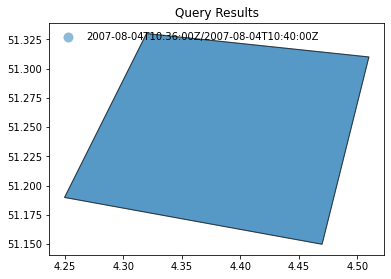

In [396]:
display_gdf_plot(results)

In [397]:
display_map(results)

```{index} double: OGC API Features; datetime
```

### Search by temporal extent

**Example: 3.5**  
>  Search granules by date range (`datetime`).  

In [398]:
results = w.collection_items(
    'datasets', 
    limit=50, 
    parentIdentifier=COLLECTION_ID1,
    datetime='2019-01-01T00:00:00Z/2019-12-02T00:00:00Z'
)

In [399]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=50" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A" \
	--data-urlencode "datetime=2019-01-01T00:00:00Z/2019-12-02T00:00:00Z"
```


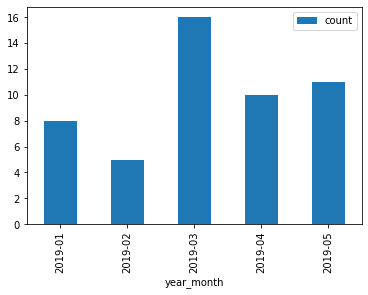

In [400]:
display_date_distribution(results)

**Example: 3.6**  
>  Search granules by open-ended date range (datetime).  

In [401]:
results = w.collection_items(
    'datasets', 
    limit=50, 
    parentIdentifier=COLLECTION_ID1,
    datetime='2021-12-01T00:00:00Z/'
)

In [402]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=50" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A" \
	--data-urlencode "datetime=2021-12-01T00:00:00Z/"
```


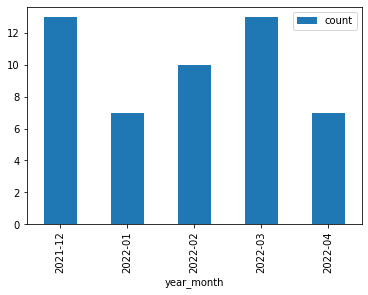

In [403]:
display_date_distribution(results)

```{index} double: OGC API Features; uid
```

### Search by identifier

The geo:uid combined with the collection identifier eo:parentIdentifier (already prefilled in the OSDD template extracted from the collection search response) allows retrieving granule metadata for a specific granule. Use an identifier extracted from the previous search response.

In [404]:
# Keep for future use.
granule_id = results['features'][0]['id']
granule_id

'PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001'

**Example: 3.7**  
>  Search granules by identifier (`uid`). 

In [405]:
results = w.collection_items(
    collection_id = 'datasets', 
    uid = granule_id,
    parentIdentifier = COLLECTION_ID1
)

In [406]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "uid=PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A"
```


In [407]:
results

{'bbox': [-46.81, -23.79, -46.65, -23.65],
 'geometry': {'coordinates': [[[-46.67, -23.79],
    [-46.65, -23.67],
    [-46.79, -23.65],
    [-46.81, -23.77]]],
  'type': 'Polygon'},
 'links': [{'rel': 'self',
   'href': 'https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001',
   'type': 'application/geo+json'},
  {'rel': 'collection',
   'href': 'https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json',
   'type': 'application/json',
   'title': 'the collection document'},
  {'rel': 'enclosure',
   'href': 'https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001.SIP.ZIP',
   'type': 'application/x-binary',
   'title': 'Download'},
  {'rel': 'icon',
   'href': 'http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001.SIP.ZIP_BID.PNG',
   'type': 'image/png',
   'title': 'QUICKLOOK'},
  {'

Alternatively, the feature can be accessed directly as shown below.  The `httpAccept` query parameter can be added to request a different representation.

**Example: 3.8**  
>  Access granule by identifier.  

In [408]:
results = w.collection_item(
    collection_id = 'datasets', 
    identifier = granule_id
)

In [409]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001
```


In [410]:
# results['properties']['title']
# results['properties']
results

{'bbox': [-46.81, -23.79, -46.65, -23.65],
 'geometry': {'coordinates': [[[-46.67, -23.79],
    [-46.65, -23.67],
    [-46.79, -23.65],
    [-46.81, -23.77]]],
  'type': 'Polygon'},
 'links': [{'rel': 'self',
   'href': 'https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001',
   'type': 'application/geo+json'},
  {'rel': 'collection',
   'href': 'https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json',
   'type': 'application/json',
   'title': 'the collection document'},
  {'rel': 'enclosure',
   'href': 'https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001.SIP.ZIP',
   'type': 'application/x-binary',
   'title': 'Download'},
  {'rel': 'icon',
   'href': 'http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20211209T175400_S23-720_W046-730_0001.SIP.ZIP_BID.PNG',
   'type': 'image/png',
   'title': 'QUICKLOOK'},
  {'

```{index} double: OGC API Features; acquisition parameters
```
### Search by acquisition parameters


```{index} double: OGC API Features; illuminationElevationAngle
```
```{index} double: OGC API Features; range of values
```
**Example: 3.9**  
>  Search granules by illumination angles `illuminationElevationAngle`, `illuminationAzimuthAngle`.

The example shows how a set of values can be provided using square brackets: `[`value-1,value-2`]`.

The `illuminationElevationAngle` and `illuminationAzimuthAngle` search parameters allow filtering results by illumination angles. An interval specifying minimum and maximum allowed values is to be provided, e.g. `[48,50]`. Only providing the minimum or maximum value can be done by using an open interval, e.g. `[48` or `50]`.

Other acquisition parameters can be advertised as searchable in the collection OSDD, depending on the sensor type e.g.:

- orbitNumber
- orbitDirection
- frame
- track
etc.

In [411]:
results = w.collection_items(
    limit = 3,
    collection_id = 'datasets', 
    parentIdentifier = COLLECTION_ID3_CLOUDS,
    illuminationElevationAngle = '[30,40]'  
)

In [412]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=3" \
	--data-urlencode "parentIdentifier=IKONOS.ESA.archive" \
	--data-urlencode "illuminationElevationAngle=[30,40]"
```


In [413]:
df = pd.json_normalize(results['features'][0]['properties']['acquisitionInformation'])
df.transpose()

0
acquisitionParameters.operationalMode                                 IM
acquisitionParameters.acquisitionType                            NOMINAL
acquisitionParameters.beginningDateTime             2003-01-01T06:46:00Z
acquisitionParameters.acquisitionAngles.illumin...              158.6086
acquisitionParameters.acquisitionAngles.alongTr...               21.3575
acquisitionParameters.acquisitionAngles.illumin...              38.25028
acquisitionParameters.acquisitionAngles.acrossT...              60.81941
acquisitionParameters.endingDateTime                2003-01-01T06:46:00Z
acquisitionParameters.orbitDirection                          DESCENDING
acquisitionParameters.orbitNumber                                      0
instrument.instrumentShortName                                       OSA
instrument.sensorType                                            OPTICAL
platform.platformShortName                                        IKONOS
platform.platformSerialIdentifier                                      2

```{index} double: OGC API Features; orbitDirection
```
**Example: 3.10**  
>  Search granules by `orbitDirection`.

In [414]:
results = w.collection_items(
    limit = 3,
    collection_id = 'datasets', 
    parentIdentifier = COLLECTION_ID2,
    orbitDirection = 'DESCENDING'  
)

In [415]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=3" \
	--data-urlencode "parentIdentifier=SPOT-6.and.7.ESA.archive" \
	--data-urlencode "orbitDirection=DESCENDING"
```


In [416]:
df = pd.json_normalize(results['features'][0]['properties']['acquisitionInformation'])
df.transpose()

0
acquisitionParameters.operationalMode                                P_S
acquisitionParameters.acquisitionType                            NOMINAL
acquisitionParameters.beginningDateTime             2015-01-16T11:31:00Z
acquisitionParameters.wrsLongitudeGrid                              W008
acquisitionParameters.wrsLatitudeGrid                                N53
acquisitionParameters.acquisitionAngles.illumin...            162.882137
acquisitionParameters.acquisitionAngles.alongTr...            -33.350676
acquisitionParameters.acquisitionAngles.illumin...             14.879389
acquisitionParameters.acquisitionAngles.acrossT...             -16.39666
acquisitionParameters.endingDateTime                2015-01-16T11:31:24Z
acquisitionParameters.orbitDirection                          DESCENDING
acquisitionParameters.orbitNumber                                      0
instrument.instrumentShortName                                     NAOMI
instrument.sensorType                                            OPTICAL
platform.platformShortName                                          SPOT
platform.platformSerialIdentifier                                      6

```{index} double: OGC API Features; orbitNumber
```
```{index} double: OGC API Features; set of values
```
**Example: 3.11**  
>  Search granules by `orbitNumber`.

The example shows how a set of values can be provided using curly brackets: `{`value-1,value-2,...,value-n`}`

In [417]:
results = w.collection_items(
    limit = 3,
    collection_id = 'datasets', 
    parentIdentifier = COLLECTION_ID2_CLOUDS,
    orbitNumber = '{1237, 1248}'  # 1237 or 1248
)

In [418]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=3" \
	--data-urlencode "parentIdentifier=LANDSAT.ETM.GTC" \
	--data-urlencode "orbitNumber={1237, 1248}"
```


In [419]:
df = pd.json_normalize(results['features'][0]['properties']['acquisitionInformation'])
df.transpose()

0
acquisitionParameters.operationalMode                                 IM
acquisitionParameters.acquisitionType                            NOMINAL
acquisitionParameters.beginningDateTime             1999-07-09T13:17:15Z
acquisitionParameters.wrsLongitudeGrid                               227
acquisitionParameters.wrsLatitudeGrid                                  3
acquisitionParameters.acquisitionAngles.illumin...              -159.694
acquisitionParameters.acquisitionAngles.illumin...               57.3796
acquisitionParameters.acquisitionAngles.illumin...               32.6204
acquisitionParameters.endingDateTime                1999-07-09T13:17:44Z
acquisitionParameters.orbitDirection                          DESCENDING
acquisitionParameters.orbitNumber                                   1237
instrument.instrumentShortName                                       ETM
instrument.sensorType                                            OPTICAL
platform.platformShortName                                       Landsat
platform.platformSerialIdentifier                                      7

## Advanced topics

### Sorting results

```{index} double: OGC API Features ; sortKeys
```
```{index} double: searchRetrieve ; sortKeys
```

Sorting of search results is available for collection, services and granule searches.   The supported search criteria can be found in the corresponding OpenSearch OSDD document.  The `sortKeys` query parameter is defined in the SRU specification [[RD07]](#RD07).


**Example: 4.1**  
>  Collection search results can be sorted according to various criteria with `sortKeys` [[RD07]](#RD07), in descending or ascending order which can be discovered in the OSDD. The example sorts collections in descending chronological order according to the {eo:modificationDate} value. 

In [420]:
results = w.collection_items(
    'series', 
    limit=10, 
    # sortKeys='title,dc,1',
    sortKeys='modificationDate,eo,0',
    organisationName = 'ESA/ESRIN' 
)

In [421]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=10" \
	--data-urlencode "sortKeys=modificationDate,eo,0" \
	--data-urlencode "organisationName=ESA/ESRIN"
```


In [422]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['updated','title']]

updated                                              title
0      2023-03-07T07:43:20Z            Alos African Coverage Test MDE internal
1      2023-03-07T06:18:54Z                     Alos African Coverage Test MDE
2  2023-02-17T00:00:00.000Z  Envisat AATSR L1B Brightness Temperature/Radia...
3  2023-02-17T00:00:00.000Z  Aeolus Level 2C assisted wind fields resulting...
4  2023-01-10T00:00:00.000Z                    GEOSAT-2 Portugal Coverage 2021
5  2022-12-13T00:00:00.000Z                      TANSAT AGCS and CAPI products
6  2022-12-02T00:00:00.000Z                                     ALOS PRISM L1C
7  2022-10-27T00:00:00.000Z  Landsat 7 ETM+ European and Mediterranean Coun...
8  2022-10-27T00:00:00.000Z  Landsat 5 TM European and Mediterranean Countr...
9  2022-09-14T00:00:00.000Z                            Cartosat-1 Euro-Maps 3D

**Example: 4.2**  
>  Granule search results can be sorted according to various criteria with `sortKeys` [RD07], in descending or ascending order which can be discovered in the OSDD. The example sorts granules in ascending chronological order according to the {time:start} value. 

In [423]:
results = w.collection_items(
    'datasets', 
    limit=10, 
    parentIdentifier=COLLECTION_ID1,
    sortKeys='start,time,1'
)

In [424]:
curl_str = curl_command(w.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items \
	--data-urlencode "limit=10" \
	--data-urlencode "parentIdentifier=PROBA.CHRIS.1A" \
	--data-urlencode "sortKeys=start,time,1"
```


In [425]:
gdf = gpd.GeoDataFrame.from_features(results)
gdf[['date','title']]

date  \
0  2002-05-14T10:09:00Z/2002-05-14T10:13:00Z   
1  2002-05-15T18:29:00Z/2002-05-15T18:33:00Z   
2  2002-05-29T18:33:00Z/2002-05-29T18:37:00Z   
3  2002-06-01T15:59:00Z/2002-06-01T16:03:00Z   
4  2002-06-02T17:47:00Z/2002-06-02T17:51:00Z   
5  2002-06-04T18:17:00Z/2002-06-04T18:21:00Z   
6  2002-06-12T10:25:00Z/2002-06-12T10:29:00Z   
7  2002-06-13T18:45:00Z/2002-06-13T18:49:00Z   
8  2002-06-14T17:29:00Z/2002-06-14T17:33:00Z   
9  2002-06-18T08:40:00Z/2002-06-18T08:44:00Z   

                                               title  
0  PR1_OPER_CHR_MO2_1P_20020514T100900_N45-018_E0...  
1  PR1_OPER_CHR_MO5_1P_20020515T182900_N38-005_W1...  
2  PR1_OPER_CHR_MO3_1P_20020529T183300_N38-005_W1...  
3  PR1_OPER_CHR_MO4_1P_20020601T155900_N45-029_W0...  
4  PR1_OPER_CHR_MO3_1P_20020602T174700_N55-049_W0...  
5  PR1_OPER_CHR_MO4_1P_20020604T181700_N50-055_W1...  
6  PR1_OPER_CHR_MO3_1P_20020612T102500_N48-008_E0...  
7  PR1_OPER_CHR_MO2_1P_20020613T184500_N43-018_W1...  
8  PR1_OPER_CHR_MO3_1P_20020614T172900_N19-033_W0...  
9  PR1_OPER_CHR_MO1_1P_20020618T084000_N30-058_E0...

### Faceted search

```{index} double: OGC API Features ; faceted search
```
```{index} double: OGC API Features ; facetLimit
```
```{index} double: searchRetrieve ; facetLimit
```

Faceted search results are available for collection, service and granule searches in both GeoJSON and Atom response formats.  The GeoJSON encoding is defined in [[RD35]](#RD35) at https://docs.ogc.org/per/19-020r1.html#_facetedresults and consistent with the OASIS SRU encoding available for Atom response format defined in [[RD07]](#RD07).

The server can supply faceted results for a query: i.e. an analysis of how the search results are distributed over various categories (or “facets”). For example, the analysis may reveal how the results are distributed by organization. The client might then refine the query to one particular organization among those listed.

By default, the search response contains faceted search results under the element facetedResults. In the current implementation, the faceted search information groups the results by a number of predefined facets which may include platform, instrument and organisation etc. The client can also specify which facets it would like to receive as part of the request with the `facetLimit` search parameter.

The search response does not include the list of all values for the facet. The list is truncated and provides the values with the largest count. Future versions of the software may allow paging through all values, which would require support for the sru:facetStart search parameter.

The faceted Results are consistent with the OASIS searchRetrieve facetedResults XML schema available at http://docs.oasis-open.org/search-ws/searchRetrieve/v1.0/os/schemas/facetedResults.xsd defined in [[RD07]](#RD07) and the GeoJSON encoding defined in [[RD35]](#RD35).

The `facetLimit` query parameter is defined in the SRU specification [[RD07]](#RD07).

```{index} double: OGC API Features ; Turtle
```
```{index} double: OGC API Features ; Atom
```
```{index} double: OGC API Features ; JSON-LD
```
```{index} double: OGC API Features ; RDF/XML
```
```{index} double: OGC API Features ; httpAccept
```
```{index} double: OGC API Features ; Accept
```
```{index} double: searchRetrieve ; httpAccept
```

(all-response-formats)=
### Additional response formats

Different representations are available for search results (container), and individual items representing a Collection, Service or Granule. They are declared in the OpenAPI definition document (`/api`).  Content negotiation can be used via the `Accept` header parameter or `httpAccept` query parameter.
Available formats are listed in the following subsections.

All the search criteria described previously can be combined with any of the available representations.

In [426]:
md(f"The OpenAPI definition describing the OGC API Features interface is available at `{URL_OAI_DEFINITION}`.")

The OpenAPI definition describing the OGC API Features interface is available at `https://eocat.spacebel.be/api`.

#### Search results

The various media types available for search results are listed in the OpenAPI definition.  For each of the available media types, an example is provided in the current section.

In [427]:
ref = apidoc['paths']['/collections/datasets/items']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/geo+json;profile="https://stacspec.org"',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'text/turtle;profile="https://schema.org"']

In [428]:
html_str = create_example_table_as_html(
    mediatypes = sorted(ref.keys()),
    chapter = 5)
HTML(html_str)

In [429]:
md_str = create_examples_as_md(
    mediatypes = sorted(ref.keys()),
    chapter = 5, 
    resource = URL_LANDING_PAGE + 'collections/series/items?limit=0',
    resource_type = "search response" )
md(md_str)


<a id='example_5_1'></a>



**Example: 5.1**
>  Represent search response in `application/atom+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/atom+xml"
```
```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:owc="http://www.opengis.net/owc/1.0" xmlns:referrer="http://a9.com/-/opensearch/extensions/referrer/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.spacebel.be/collections/series/items</id>   
   <rights>Copyright 2016-2023, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2023-03-30T12:34:02Z</updated>   
   <link href="https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml" rel="search" type="application/opensearchdescription+xml"/>   
   <link href="https://eocat.spacebel.be/collections/series/items?limit=0&amp;httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>   
   <link href="https://eocat.spacebel.be/collections/series/items?limit=0&amp;httpAccept=application/atom%2Bxml" hreflang="en" rel="self" type="application/atom+xml"/>   
   <os:totalResults>183</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>0</os:itemsPerPage>   
   <os:Query dc:type="collection" os:count="0" os:startIndex="1" role="request"/>   
</feed>
```

<a id='example_5_2'></a>



**Example: 5.2**
>  Represent search response in `application/geo+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/geo+json"
```

```json
{
   "facetedResults": {
      "datasource": [
         {
            "displayLabel": "ESA Catalog",
            "baseURL": "https://eocat.spacebel.be",
            "description": "ESA Catalog",
            "facets": [
               {
                  "displayLabel": "Platform",
                  "terms": [
                     {
                        "actualTerm": "Envisat",
                        "count": 42
                     },
                     {
                        "actualTerm": "ERS-2",
                        "count": 20
                     },
                     {
                        "actualTerm": "ERS-1",
                        "count": 16
                     },
                     {
                        "actualTerm": "ALOS-1",
                        "count": 11
                     },
                     {
                        "actualTerm": "Swarm",
                        "count": 11
                     },
                     {
                        "actualTerm": "SMOS",
                        "count": 9
                     },
                     {
                        "actualTerm": "GOCE",
                        "count": 7
                     },
                     {
                        "actualTerm": "Aeolus",
                        "count": 4
                     },
                     {
                        "actualTerm": "RapidEye",
                        "count": 4
                     },
                     {
                        "actualTerm": "GEOSAT-1",
                        "count": 3
                     }
                  ],
                  "index": "eo:platform",
                  "relation": "="
               },
               {
                  "displayLabel": "Instrument",
                  "terms": [
                     {
                        "actualTerm": "STR",
                        "count": 18
                     },
                     {
                        "actualTerm": "ASAR",
                        "count": 15
                     },
                     {
                        "actualTerm": "ACC",
                        "count": 11
                     },
                     {
                        "actualTerm": "ASM",
                        "count": 11
                     },
                     {
                        "actualTerm": "EFI",
                        "count": 11
                     },
                     {
                        "actualTerm": "GPSR",
                        "count": 11
                     },
                     {
                        "actualTerm": "LRR",
                        "count": 11
                     },
                     {
                        "actualTerm": "VFM",
                        "count": 11
                     },
                     {
                        "actualTerm": "AATSR",
                        "count": 9
                     },
                     {
                        "actualTerm": "MIRAS",
                        "count": 9
                     }
                  ],
                  "index": "eo:instrument",
                  "relation": "="
               },
               {
                  "displayLabel": "OrganisationName",
                  "terms": [
                     {
                        "actualTerm": "ESA/ESRIN",
                        "count": 183
                     }
                  ],
                  "index": "eo:organisationName",
                  "relation": "="
               },
               {
                  "displayLabel": "ProcessingLevel",
                  "terms": [
                     {
                        "actualTerm": "level 2",
                        "count": 69
                     },
                     {
                        "actualTerm": "level 1b",
                        "count": 55
                     },
                     {
                        "actualTerm": "multiple",
                        "count": 45
                     },
                     {
                        "actualTerm": "level 1",
                        "count": 38
                     },
                     {
                        "actualTerm": "level 3",
                        "count": 30
                     },
                     {
                        "actualTerm": "level 1a",
                        "count": 17
                     },
                     {
                        "actualTerm": "level 1c",
                        "count": 9
                     },
                     {
                        "actualTerm": "level 0",
                        "count": 8
                     },
                     {
                        "actualTerm": "level 1T",
                        "count": 7
                     },
                     {
                        "actualTerm": "level 2a",
                        "count": 6
                     }
                  ],
                  "index": "eo:processingLevel",
                  "relation": "="
               },
               {
                  "displayLabel": "ClassifiedAs",
                  "terms": [
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
                        "count": 183
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/instruments",
                        "count": 183
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concepts/concept_scheme/platforms",
                        "count": 183
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb",
                        "count": 67
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
                        "count": 61
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
                        "count": 61
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/e4d01e03-0ef5-5b4c-b40f-2b5f49667f53",
                        "count": 60
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/e3666b36-a100-5e2c-b0c0-a24ed76f195e",
                        "count": 48
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/0d2133c5-b0bb-5ce2-b000-243ade6a65b8",
                        "count": 42
                     },
                     {
                        "actualTerm": "https://earth.esa.int/concept/11ea961b-1d0b-5d6d-a55a-b58aed01d430",
                        "count": 42
                     }
                  ],
                  "index": "semantic:classifiedAs",
                  "relation": "="
               },
               {
                  "displayLabel": "UseLimitation",
                  "terms": [
                     {
                        "actualTerm": "EO Sign In Authentication",
                        "count": 64
                     },
                     {
                        "actualTerm": "Fast Registration with Approval",
                        "count": 34
                     },
                     {
                        "actualTerm": "Fast Registration with immediate access",
                        "count": 30
                     },
                     {
                        "actualTerm": "Project Proposal (Restrained)",
                        "count": 26
                     },
                     {
                        "actualTerm": "External Data",
                        "count": 12
                     },
                     {
                        "actualTerm": "Open Access",
                        "count": 12
                     },
                     {
                        "actualTerm": "Data Service Request",
                        "count": 4
                     },
                     {
                        "actualTerm": "Available to residents of the following countries:",
                        "count": 3
                     },
                     {
                        "actualTerm": "Data from _$$ALOS AVNIR-2$$ https://alos-ds.eo.esa.int/oads/access/collection/ALOS_AVNIR-2_OBS_L1C and _$$PRISM African Coverage ESA archive$$ https://alos-ds.eo.esa.int/oads/access/collection/ALOS_Africa_PRISM are available for download via ESA's ALOS Optical dedicated dissemination service and catalogue as well as via geographical search (for both AVNIR-2 and PRISM) using an _$$interactive map$$ http://alos-ds.eo.esa.int/smcat/ALOS_Africa_PRISM/ for PRISM and a _$$static map$$ http://alos-ds.eo.esa.int/smcat/ALOS_Africa_AVNIR2/ for AVNIR-2.  ALOS-1 products can also be discovered through ESA's _$$EO Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-ALOS%22:%22%22,%22commonCriteria%22:%22bbox=-125,-10,20,70%22} , which allows users to discover and download products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  An active ESA EO Sign In account is required to download the products.   ESA internal users can use their ESAAD account.  For further information about the EO Sign In Service you can visit _$$TellUs$$ https://esatellus.service-now.com/csp?id=esa_faq&kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support to access the data, please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
                        "count": 3
                     },
                     {
                        "actualTerm": "EO Sign In Authentication (Open)  1. Go to the _$$Dissemination Service$$ https://alos-ds.eo.esa.int/oads/access/collection/ 2. Find the product you want 3. Register or log in to EO Sign In 4. Download",
                        "count": 3
                     }
                  ],
                  "index": "eo:useLimitation",
                  "relation": "="
               }
            ]
         }
      ]
   },
   "features": [],
   "totalResults": 183,
   "startIndex": 1,
   "itemsPerPage": 0,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson",
         "type": "application/geo+json"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\""
      }
   ],
   "id": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson",
   "type": "FeatureCollection",
   "queries": {
      "request": [
         {
            "dc:type": "collection",
            "os:count": "0",
            "os:startIndex": "1"
         }
      ]
   }
}
```

<a id='example_5_3'></a>



**Example: 5.3**
>  Represent search response in `application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0""
```
Media type not supported.

<a id='example_5_4'></a>



**Example: 5.4**
>  Represent search response in `application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
Media type not supported.

<a id='example_5_5'></a>



**Example: 5.5**
>  Represent search response in `application/geo+json;profile="https://stacspec.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/geo+json;profile="https://stacspec.org""
```

```json
{
   "features": [],
   "totalResults": 183,
   "startIndex": 1,
   "itemsPerPage": 0,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson%3Bprofile%3D%22https%3A//stacspec.org%22",
         "type": "application/geo+json"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml"
      }
   ],
   "id": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson%3Bprofile%3D%22https%3A//stacspec.org%22",
   "type": "FeatureCollection",
   "queries": {
      "request": [
         {
            "dc:type": "collection",
            "os:count": "0",
            "os:startIndex": "1"
         }
      ]
   }
}
```

<a id='example_5_6'></a>



**Example: 5.6**
>  Represent search response in `application/ld+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/ld+json"
```
Media type not supported.

<a id='example_5_7'></a>



**Example: 5.7**
>  Represent search response in `application/ld+json;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/ld+json;profile="http://data.europa.eu/930/""
```

```json
{
   "dct:date": "2023-03-30T12:34:02Z",
   "@type": [
      "ldp:Resource",
      "ldp:Page"
   ],
   "os:startIndex": 1,
   "os:Query": {
      "dc:type": "collection",
      "os:count": "0",
      "os:startIndex": "1"
   },
   "dct:creator": [
      {
         "foaf:name": "ESA Catalog",
         "@type": "foaf:Agent",
         "foaf:mbox": "eohelp@eo.esa.int"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/series/items?limit=0",
   "os:totalResults": 183,
   "os:itemsPerPage": 0,
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "os": "http://a9.com/-/spec/opensearch/1.1/",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "ldp": "http://www.w3.org/ns/ldp#",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/",
      "dc": "http://purl.org/dc/elements/1.1/"
   }
}
```

<a id='example_5_8'></a>



**Example: 5.8**
>  Represent search response in `application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```

```json
{
   "dct:modified": "2023-03-30T12:34:03Z",
   "dct:rights": "Copyright 2016-2023, European Space Agency",
   "@type": "gj:FeatureCollection",
   "owc:links": {
      "iana:profiles": [
         {
            "@id": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
         },
         {
            "@id": "http://www.opengis.net/spec/os-geojson/1.0/req/core"
         }
      ],
      "iana:alternate": [
         {
            "atom:type": "application/atom+xml",
            "@id": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/atom%2Bxml"
         },
         {
            "atom:type": "application/geo+json;profile=\"https://stacspec.org\"",
            "@id": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson;profile=https://stacspec.org"
         }
      ]
   },
   "os:itemsPerPage": {
      "@value": 0,
      "@type": "xsd:nonNegativeInteger"
   },
   "@context": {
      "gj": "https://purl.org/geojson/vocab#",
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "os": "http://a9.com/-/spec/opensearch/1.1/",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "eop": "http://www.opengis.net/ont/eo-geojson/1.0/",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "sru": "http://a9.com/-/opensearch/extensions/sru/2.0/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "atom": "http://www.w3.org/2005/Atom/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/",
      "dc": "http://purl.org/dc/elements/1.1/"
   },
   "dct:language": {
      "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
   },
   "os:queries": {
      "os:request": {
         "dc:type": "collection",
         "os:count": "0",
         "os:startIndex": "1"
      }
   },
   "os:startIndex": {
      "@value": 1,
      "@type": "xsd:nonNegativeInteger"
   },
   "dct:creator": [
      {
         "foaf:name": "ESA Catalog",
         "@type": "foaf:Agent",
         "foaf:mbox": "eohelp@eo.esa.int"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/series/items?limit=0",
   "os:totalResults": {
      "@value": 183,
      "@type": "xsd:nonNegativeInteger"
   },
   "dct:title": "ESA Catalog - Search Response"
}
```

<a id='example_5_9'></a>



**Example: 5.9**
>  Represent search response in `application/ld+json;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/ld+json;profile="https://schema.org""
```

```json
{
   "@type": [
      "Collection",
      "ListItem"
   ],
   "collectionSize": 183,
   "description": "ESA Catalog - Search Response",
   "@id": "https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/ld%2Bjson%3Bprofile%3D%22https%3A//schema.org%22",
   "@context": {
      "@vocab": "https://schema.org/"
   }
}
```

<a id='example_5_10'></a>



**Example: 5.10**
>  Represent search response in `application/rdf+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/rdf+xml"
```
Media type not supported.

<a id='example_5_11'></a>



**Example: 5.11**
>  Represent search response in `application/rdf+xml;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://data.europa.eu/930/""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <ldp:Page rdf:about="https://eocat.spacebel.be/collections/series/items?limit=0">      
          <dct:date>2023-03-30T12:34:03Z</dct:date>      
          <dct:creator>         
               <foaf:Agent>            
                    <foaf:name>ESA Catalog</foaf:name>            
                    <foaf:mbox>eohelp@eo.esa.int</foaf:mbox>            
               </foaf:Agent>         
          </dct:creator>      
          <os:totalResults rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">183</os:totalResults>      
          <os:startIndex rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">1</os:startIndex>      
          <os:itemsPerPage rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">0</os:itemsPerPage>      
          <os:Query rdf:parseType="Resource">         
               <dc:type>collection</dc:type>         
               <os:startIndex>1</os:startIndex>         
               <os:count>0</os:count>         
          </os:Query>      
          <rdf:type rdf:resource="http://www.w3.org/ns/ldp#Resource"/>      
     </ldp:Page>   
</rdf:RDF>
```

<a id='example_5_12'></a>



**Example: 5.12**
>  Represent search response in `application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:eop="http://www.opengis.net/ont/eo-geojson/1.0/" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:gj="https://purl.org/geojson/vocab#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/">   
     <gj:FeatureCollection rdf:about="https://eocat.spacebel.be/collections/series/items?limit=0">      
          <os:startIndex rdf:datatype="http://www.w3.org/2001/XMLSchema#nonNegativeInteger">1</os:startIndex>      
          <owc:links rdf:parseType="Resource">         
               <iana:profiles rdf:resource="http://www.opengis.net/spec/os-geojson/1.0/req/core"/>         
               <iana:profiles rdf:resource="http://www.opengis.net/spec/owc-geojson/1.0/req/core"/>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items?limit=0&amp;httpAccept=application/geo%2Bjson;profile=https://stacspec.org">               
                         <atom:type>application/geo+json;profile=&quot;https://stacspec.org&quot;</atom:type>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items?limit=0&amp;httpAccept=application/atom%2Bxml">               
                         <atom:type>application/atom+xml</atom:type>               
                    </rdf:Description>            
               </iana:alternate>         
          </owc:links>      
          <dct:creator>         
               <foaf:Agent>            
                    <foaf:name>ESA Catalog</foaf:name>            
                    <foaf:mbox>eohelp@eo.esa.int</foaf:mbox>            
               </foaf:Agent>         
          </dct:creator>      
          <dct:modified>2023-03-30T12:34:03Z</dct:modified>      
          <os:totalResults rdf:datatype="http://www.w3.org/2001/XMLSchema#nonNegativeInteger">183</os:totalResults>      
          <dct:language rdf:resource="http://id.loc.gov/vocabulary/iso639-1/en"/>      
          <dct:title>ESA Catalog - Search Response</dct:title>      
          <os:itemsPerPage rdf:datatype="http://www.w3.org/2001/XMLSchema#nonNegativeInteger">0</os:itemsPerPage>      
          <dct:rights>Copyright 2016-2023, European Space Agency</dct:rights>      
          <os:queries rdf:parseType="Resource">         
               <os:request rdf:parseType="Resource">            
                    <dc:type>collection</dc:type>            
                    <os:startIndex>1</os:startIndex>            
                    <os:count>0</os:count>            
               </os:request>         
          </os:queries>      
     </gj:FeatureCollection>   
</rdf:RDF>
```

<a id='example_5_13'></a>



**Example: 5.13**
>  Represent search response in `application/rdf+xml;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=application/rdf+xml;profile="https://schema.org""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:schema="https://schema.org/" xmlns:wikidata="http://www.wikidata.org/entity/" xmlns:rdfa="http://www.w3.org/ns/rdfa#" xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/" xmlns:yago="http://yago-knowledge.org/resource/" xmlns:dbpedia="http://dbpedia.org/resource/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:void="http://rdfs.org/ns/void#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:dctype="http://purl.org/dc/dcmitype/" xmlns:eli="http://data.europa.eu/eli/ontology#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:bibo="http://purl.org/ontology/bibo/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <schema:ListItem rdf:about="https://eocat.spacebel.be/collections/series/items?limit=0&amp;httpAccept=application/rdf%2Bxml%3Bprofile%3D%22https%3A//schema.org%22">      
          <schema:description>ESA Catalog - Search Response</schema:description>      
          <schema:collectionSize rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">183</schema:collectionSize>      
          <rdf:type rdf:resource="https://schema.org/Collection"/>      
     </schema:ListItem>   
</rdf:RDF>
```

<a id='example_5_14'></a>



**Example: 5.14**
>  Represent search response in `text/html` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=text/html"
```
```
<html>
	<head>
                <title>ESA Catalog - Search Response</title>
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
		<meta content="text/html; charset=UTF-8" http-equiv="content-type"/>
		<link rel="stylesheet" type="text/css" href="https://eocat.spacebel.be/css/eocat.css"/>
                		
	</head>
	<body>
		<table width="100%">
			<tr>
				<td>
					<table class="bannerTable">
						<tr>
							<td>
								<a href="" target="_blank"></a>
							</td>
							<td></td>
							<td class="bannerTable-td-right"></td>
						</tr>
					</table>				
				</td>				
			</tr>
		</table>
		<div class="container"><div class="title"><h1>Search Response &nbsp;&nbsp;&nbsp;</h1></div><div class="table"><div class="row"><div class="label-cell label-align"><label class="label">Number of results:</label></div><div class="cell"><ul><li><div>183</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Start index:</label></div><div class="cell"><ul><li><div>1</div></li></ul></div></div></div></div>
	</body>
</html>

```

<a id='example_5_15'></a>



**Example: 5.15**
>  Represent search response in `text/turtle` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=text/turtle"
```
Media type not supported.

<a id='example_5_16'></a>



**Example: 5.16**
>  Represent search response in `text/turtle;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=text/turtle;profile="http://data.europa.eu/930/""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/series/items?limit=0>
        a                ldp:Page , ldp:Resource ;
        os:Query         [ os:count       "0" ;
                           os:startIndex  "1" ;
                           dc:type        "collection"
                         ] ;
        os:itemsPerPage  0 ;
        os:startIndex    1 ;
        os:totalResults  183 ;
        dct:creator      [ a          foaf:Agent ;
                           foaf:mbox  "eohelp@eo.esa.int" ;
                           foaf:name  "ESA Catalog"
                         ] ;
        dct:date         "2023-03-30T12:34:04Z" .

```

<a id='example_5_17'></a>



**Example: 5.17**
>  Represent search response in `text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix gj:    <https://purl.org/geojson/vocab#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix eop:   <http://www.opengis.net/ont/eo-geojson/1.0/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix sru:   <http://a9.com/-/opensearch/extensions/sru/2.0/> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/atom%2Bxml>
        atom:type  "application/atom+xml" .

<https://eocat.spacebel.be/collections/series/items?limit=0>
        a                gj:FeatureCollection ;
        os:itemsPerPage  "0"^^xsd:nonNegativeInteger ;
        os:queries       [ os:request  [ os:count       "0" ;
                                         os:startIndex  "1" ;
                                         dc:type        "collection"
                                       ] ] ;
        os:startIndex    "1"^^xsd:nonNegativeInteger ;
        os:totalResults  "183"^^xsd:nonNegativeInteger ;
        dct:creator      [ a          foaf:Agent ;
                           foaf:mbox  "eohelp@eo.esa.int" ;
                           foaf:name  "ESA Catalog"
                         ] ;
        dct:language     <http://id.loc.gov/vocabulary/iso639-1/en> ;
        dct:modified     "2023-03-30T12:34:04Z" ;
        dct:rights       "Copyright 2016-2023, European Space Agency" ;
        dct:title        "ESA Catalog - Search Response" ;
        owc:links        [ iana:alternate  <https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson;profile=https://stacspec.org> , <https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/atom%2Bxml> ;
                           iana:profiles   <http://www.opengis.net/spec/os-geojson/1.0/req/core> , <http://www.opengis.net/spec/owc-geojson/1.0/req/core>
                         ] .

<https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=application/geo%2Bjson;profile=https://stacspec.org>
        atom:type  "application/geo+json;profile=\"https://stacspec.org\"" .

```

<a id='example_5_18'></a>



**Example: 5.18**
>  Represent search response in `text/turtle;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items \
	--data-urlencode "limit=0" \
	--data-urlencode "httpAccept=text/turtle;profile="https://schema.org""
```
```
@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/series/items?limit=0&httpAccept=text/turtle%3Bprofile%3D%22https%3A//schema.org%22>
        a                      schema:ListItem , schema:Collection ;
        schema:collectionSize  183 ;
        schema:description     "ESA Catalog - Search Response" .

```


#### Item (Collection)

The various media types available for representing a collection are listed in the OpenAPI definition.  For each of the available media types, an example is provided in the current section.

In [430]:
ref = apidoc['paths']['/collections/series/items/{seriesId}']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/dif10+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/json',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'application/vnd.iso.19115-3+xml',
 'application/vnd.iso.19139+xml',
 'application/vnd.iso.19139-2+xml',
 'application/xml',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'text/turtle;profile="https://s

In [431]:
html_str = create_example_table_as_html(
    mediatypes = sorted(ref.keys()),
    chapter = 6)
HTML(html_str)

In [432]:
series_id

'PROBA.HRC.1A'

In [433]:
md_str = create_examples_as_md(
    mediatypes = sorted(ref.keys()),
    chapter = 6, 
    resource = URL_LANDING_PAGE + 'collections/series/items/' + series_id,
    resource_type = "series" )
md(md_str)


<a id='example_6_1'></a>



**Example: 6.1**
>  Represent series in `application/atom+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/atom+xml"
```
```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:owc="http://www.opengis.net/owc/1.0" xmlns:referrer="http://a9.com/-/opensearch/extensions/referrer/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.spacebel.be/collections/series/items</id>   
   <rights>Copyright 2016-2023, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2023-03-30T12:34:05Z</updated>   
   <link href="https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml" rel="search" type="application/opensearchdescription+xml"/>   
   <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>   
   <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml" hreflang="en" rel="self" type="application/atom+xml"/>   
   <os:totalResults>1</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query dc:type="collection" eo:parentIdentifier="dataset" geo:uid="PROBA.HRC.1A" os:count="10" os:startIndex="1" role="request"/>   
   <sru:facetedResults>      
      <sru:datasource>         
         <sru:facets>            
            <sru:facet>               
               <sru:index>eo:platform</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>PROBA-1</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:instrument</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>HRC</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:organisationName</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>ESA/ESRIN</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:processingLevel</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1A</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>semantic:classifiedAs</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concepts/concept_scheme/earth-topics</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concepts/concept_scheme/instruments</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>https://earth.esa.int/concepts/concept_scheme/platforms</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:useLimitation</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>EO Sign In Authentication</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
         </sru:facets>         
      </sru:datasource>      
   </sru:facetedResults>   
   <entry>      
      <category label="615 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="4 km" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="" term="http://www.opengis.net/eop/2.1/processorVersion"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="HRC_HRC_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION" term="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9"/>      
      <category label="EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER" term="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d"/>      
      <category label="EARTH SCIENCE &gt; OCEANS" term="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Vegetation" term="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c"/>      
      <category label="Surface Water" term="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4"/>      
      <category label="Oceans" term="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417"/>      
      <category label="Cameras" term="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7"/>      
      <category label="PROBA-1" term="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
      <category label="HRC" term="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>      
      <category label="High Resolution Camera" term="High Resolution Camera"/>      
      <category label="World" term="World"/>      
      <category label="ESA/ESRIN" term="ESA/ESRIN"/>      
      <id>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml</id>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" rel="alternate" title="OGC 17-069r3 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc" rel="alternate" title="OGC 17-084r1 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/eoc-geojson/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json" rel="alternate" title="STAC metadata" type="application/json"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org" rel="alternate" title="JSON-LD (schema.org) metadata" type="application/ld+json;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" rel="alternate" title="JSON-LD (GeoDCAT-AP) metadata" type="application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org" rel="alternate" title="RDF/XML (schema.org) metadata" type="application/rdf+xml;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" rel="alternate" title="RDF/XML (GeoDCAT-AP) metadata" type="application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org" rel="alternate" title="Turtle (schema.org) metadata" type="text/turtle;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/" rel="alternate" title="Turtle (GeoDCAT-AP) metadata" type="text/turtle;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html" rel="alternate" title="HTML" type="text/html"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry" rel="describedby" title="Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <rights type="html">Open Data EO Sign In Authentication (Open)  1. Go to the _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC 2. Find the product you want via a map 3. Register or log in to EO Sign In 4. Download In the Optical Online _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/smcat/PROBA1-HRC/ and catalogue the data is collection based and allows data browse and download through the treeview as well as via geographical search using a static map.  PROBA-1 products can also be discovered through _$$ESA's EO Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}, which allows users to discover and download products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  For further information about the EO Sign In Service you can visit _$$TellUs$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e.  ESA internal users can use their ESAAD account.  Should you need support to access the data, please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958 Available to residents of the following countries:</rights>      
      <link href="https://eovoc.spacebel.be/images/esa.png" rel="icon" type="image/png"/>      
      <content type="html">The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</content>      
      <title>Proba HRC</title>      
      <updated>2019-05-22T00:00:00.000Z</updated>      
      <dc:identifier>PROBA.HRC.1A</dc:identifier>      
      <dc:date>2002-10-10T00:00:00.000Z/</dc:date>      
      <georss:polygon>-56 -180 -56 180 75 180 75 -180 -56 -180</georss:polygon>      
      <georss:box>-56 -180 75 180</georss:box>      
   </entry>   
</feed>
```

<a id='example_6_2'></a>



**Example: 6.2**
>  Represent series in `application/dif10+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/dif10+xml"
```
```xml
<?xml version="1.0" ?><DIF xmlns="http://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/ https://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/dif_v10.2.xsd">   
   <Entry_ID>      
      <Short_Name>PROBA.HRC.1A</Short_Name>      
      <Version>NA</Version>      
   </Entry_ID>   
   <Entry_Title>Proba HRC</Entry_Title>   
   <Science_Keywords>      
      <Category>EARTH SCIENCE</Category>      
      <Topic>BIOSPHERE</Topic>      
      <Term>ECOSYSTEMS</Term>      
      <Variable_Level_1>TERRESTRIAL ECOSYSTEMS</Variable_Level_1>      
   </Science_Keywords>   
   <Science_Keywords>      
      <Category>EARTH SCIENCE</Category>      
      <Topic>BIOSPHERE</Topic>      
      <Term>VEGETATION</Term>      
   </Science_Keywords>   
   <Science_Keywords>      
      <Category>EARTH SCIENCE</Category>      
      <Topic>TERRESTRIAL HYDROSPHERE</Topic>      
      <Term>SURFACE WATER</Term>      
   </Science_Keywords>   
   <ISO_Topic_Category>IMAGERY/BASE MAPS/EARTH COVER</ISO_Topic_Category>   
   <Ancillary_Keyword>HRC</Ancillary_Keyword>   
   <Ancillary_Keyword>High Resolution Camera</Ancillary_Keyword>   
   <Ancillary_Keyword>World</Ancillary_Keyword>   
   <Platform>      
      <Type>Earth Observation Satellites</Type>      
      <Short_Name>PROBA-1</Short_Name>      

      <Long_Name>Project for On-Board Autonomy, PROBA-1</Long_Name>      
      <Instrument>         
         <Short_Name>HRC</Short_Name>         
         <Long_Name>High Resolution Camera</Long_Name>         
      </Instrument>      
   </Platform>   
   <Temporal_Coverage>      
      <Range_DateTime>         
         <Beginning_Date_Time>2002-10-10</Beginning_Date_Time>         
      </Range_DateTime>      
   </Temporal_Coverage>   
   <Dataset_Progress>IN WORK</Dataset_Progress>   
   <Spatial_Coverage>      
      <Granule_Spatial_Representation>NO_SPATIAL</Granule_Spatial_Representation>      
      <Geometry>         
         <Coordinate_System>CARTESIAN</Coordinate_System>         
         <Bounding_Rectangle>            
            <Southernmost_Latitude>-56</Southernmost_Latitude>            
            <Northernmost_Latitude>75</Northernmost_Latitude>            
            <Westernmost_Longitude>-180</Westernmost_Longitude>            
            <Easternmost_Longitude>180</Easternmost_Longitude>            
         </Bounding_Rectangle>         
      </Geometry>      
   </Spatial_Coverage>   
   <Project>      
      <Short_Name>FedEO</Short_Name>      
      <Long_Name>FedEO: Federated EO Gateway</Long_Name>      
   </Project>   
   <Organization>      
      <Organization_Type>DISTRIBUTOR</Organization_Type>      
      <Organization_Name>         
         <Short_Name>ESA/ESRIN</Short_Name>         
         <Long_Name>ESRIN Earth Observation, European Space Agency</Long_Name>         
      </Organization_Name>      
      <Organization_URL>http://www.esa.int</Organization_URL>      
      <Personnel>         
         <Role>DATA CENTER CONTACT</Role>         
         <Contact_Group>            
            <Name>ESRIN Earth Observation Help Desk</Name>            
            <Address>               
               <Street_Address>Largo Galileo Galilei 1</Street_Address>               
               <City>Frascati (Roma)</City>               
               <Postal_Code>00044</Postal_Code>               
               <Country>Italy</Country>               
            </Address>            
            <Email>eohelp@esa.int</Email>            
         </Contact_Group>         
      </Personnel>      
   </Organization>   
   <Organization>      
      <Organization_Type>ORIGINATOR</Organization_Type>      
      <Organization_Name>         
         <Short_Name>ESA/ESRIN</Short_Name>         
         <Long_Name>ESRIN Earth Observation, European Space Agency</Long_Name>         
      </Organization_Name>      
      <Organization_URL>http://www.esa.int</Organization_URL>      
      <Personnel>         
         <Role>DATA CENTER CONTACT</Role>         
         <Contact_Group>            
            <Name>Earth Observation helpdesk</Name>            
            <Address>               
               <Street_Address>Largo Galileo Galilei 1</Street_Address>               
               <City>Frascati (Roma)</City>               
               <Postal_Code>00044</Postal_Code>               
               <Country>Italy</Country>               
            </Address>            
            <Email>eohelp@esa.int</Email>            
         </Contact_Group>         
      </Personnel>      
   </Organization>   
   <Summary>      
      <Abstract>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</Abstract>      
   </Summary>   
   <Related_URL>      
      <URL_Content_Type>         
         <Type>GET DATA</Type>         
      </URL_Content_Type>      
      <URL>https://fedeo-client.ceos.org?uid=PROBA.HRC.1A</URL>      
      <Description>DescribedBy</Description>      
      <Mime_Type>text/html</Mime_Type>      
   </Related_URL>   
   <Related_URL>      
      <URL_Content_Type>         
         <Type>GET DATA</Type>         
      </URL_Content_Type>      
      <URL>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml</URL>      
      <Description>DescribedBy</Description>      
      <Mime_Type>application/x-vnd.iso.19139-2+xml</Mime_Type>      
   </Related_URL>   
   <Related_URL>      
      <URL_Content_Type>         
         <Type>USE SERVICE API</Type>         
         <Subtype>OpenSearch</Subtype>         
      </URL_Content_Type>      
      <URL>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api</URL>      
      <Description>tag_key: opensearch.granule.osdd</Description>      
      <Mime_Type>application/opensearchdescription+xml</Mime_Type>      
   </Related_URL>   
   <Metadata_Name>CEOS IDN DIF</Metadata_Name>   
   <Metadata_Version>VERSION 10.2</Metadata_Version>   
   <Metadata_Dates>      
      <Metadata_Creation>unknown</Metadata_Creation>      
      <Metadata_Last_Revision>unknown</Metadata_Last_Revision>      
      <Data_Creation>2019-05-22</Data_Creation>      
      <Data_Last_Revision>unknown</Data_Last_Revision>      
   </Metadata_Dates>   
   <Product_Level_Id>1A</Product_Level_Id>   
   <Extended_Metadata>      
      <Metadata>         
         <Group>int.esa.fedeo</Group>         
         <Name>EO Parameter Code List - Earth Topics</Name>         
         <Value>Forestry</Value>         
         <Value>Vegetation</Value>         
         <Value>Surface Water</Value>         
         <Value>Oceans</Value>         
      </Metadata>      
   </Extended_Metadata>   
</DIF>
```

<a id='example_6_3'></a>



**Example: 6.3**
>  Represent series in `application/geo+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/geo+json"
```

```json
{
   "geometry": {
      "coordinates": [
         [
            [
               -180,
               -56
            ],
            [
               180,
               -56
            ],
            [
               180,
               75
            ],
            [
               -180,
               75
            ],
            [
               -180,
               -56
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "describedby",
         "href": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
         "type": "application/pdf",
         "title": "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note"
      },
      {
         "rel": "describedby",
         "href": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "type": "text/html",
         "title": "Get Help? - ESA Earth Observation User Services Portal"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "type": "application/vnd.iso.19139-2+xml",
         "title": "ISO 19139-2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "type": "application/vnd.iso.19115-3+xml",
         "title": "ISO 19115-3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "type": "application/dif10+xml",
         "title": "DIF-10 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
         "type": "application/xml",
         "title": "Dublin Core metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
         "title": "OGC 17-084r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PROBA.HRC.1A",
   "collection": "series",
   "type": "Feature",
   "properties": {
      "date": "2002-10-10T00:00:00.000Z/",
      "contactPoint": [
         {
            "hasAddress": {
               "postal-code": "00044",
               "street-address": "Largo Galileo Galilei 1",
               "locality": "Frascati (Roma)",
               "country-name": "Italy"
            },
            "phone": "tel:+3906941801",
            "name": "ESA/ESRIN",
            "type": "Organization",
            "uri": "http://www.esa.int",
            "email": "eohelp@esa.int"
         }
      ],
      "kind": "http://purl.org/dc/dcmitype/Collection",
      "created": "2019-05-22T00:00:00.000Z",
      "subject": [
         {
            "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
            "label": "Imagery Base Maps Earth Cover"
         }
      ],
      "abstract": {
         "text/plain": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users."
      },
      "title": "Proba HRC",
      "license": [
         {
            "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
            "type": "LicenseDocument"
         }
      ],
      "categories": [
         {
            "scheme": "https://earth.esa.int/eop-ext/",
            "term": "https://earth.esa.int/eop-ext/orbitHeight",
            "label": "615 km"
         },
         {
            "scheme": "https://earth.esa.int/eop-ext/",
            "term": "https://earth.esa.int/eop-ext/swathWidth",
            "label": "4 km"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
            "label": "VIS (0.40 - 0.75 \u00b5m)"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/orbitType",
            "label": "Sun-synchronous"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/processorVersion"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/resolution",
            "label": "High Resolution - HR (5 - 20 m)"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/productType",
            "label": "HRC_HRC_1P"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
            "label": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
            "label": "EARTH SCIENCE > BIOSPHERE > VEGETATION"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
            "label": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
            "label": "EARTH SCIENCE > OCEANS"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
            "label": "Forestry"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
            "label": "Vegetation"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
            "label": "Surface Water"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
            "label": "Oceans"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
            "term": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
            "label": "Cameras"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
            "term": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
            "label": "PROBA-1"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
            "term": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
            "label": "HRC"
         }
      ],
      "isPrimaryTopicOf": {
         "created": "2019-05-22T00:00:00.00Z",
         "conformsTo": {
            "versionInfo": "2005/Cor.1:2006",
            "type": "Standard",
            "title": "ISO19115"
         },
         "type": "CatalogRecord",
         "lang": "en",
         "updated": "2023-02-08T00:00:00.00Z"
      },
      "keyword": [
         "High Resolution Camera",
         "World"
      ],
      "updated": "2019-05-22T00:00:00.000Z",
      "qualifiedAttribution": [
         {
            "agent": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "role": "originator",
            "type": "Attribution"
         }
      ],
      "acquisitionInformation": [
         {
            "instrument": {
               "instrumentShortName": "HRC",
               "id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"
            },
            "platform": {
               "platformShortName": "PROBA-1",
               "id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"
            }
         }
      ]
   }
}
```

<a id='example_6_4'></a>



**Example: 6.4**
>  Represent series in `application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0""
```

```json
{
   "geometry": {
      "coordinates": [
         [
            [
               -180,
               -56
            ],
            [
               180,
               -56
            ],
            [
               180,
               75
            ],
            [
               -180,
               75
            ],
            [
               -180,
               -56
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "describedby",
         "href": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
         "type": "application/pdf",
         "title": "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note"
      },
      {
         "rel": "describedby",
         "href": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "type": "text/html",
         "title": "Get Help? - ESA Earth Observation User Services Portal"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "type": "application/vnd.iso.19139-2+xml",
         "title": "ISO 19139-2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "type": "application/vnd.iso.19115-3+xml",
         "title": "ISO 19115-3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "type": "application/dif10+xml",
         "title": "DIF-10 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
         "type": "application/xml",
         "title": "Dublin Core metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
         "title": "OGC 17-084r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PROBA.HRC.1A",
   "collection": "series",
   "type": "Feature",
   "properties": {
      "date": "2002-10-10T00:00:00.000Z/",
      "contactPoint": [
         {
            "hasAddress": {
               "postal-code": "00044",
               "street-address": "Largo Galileo Galilei 1",
               "locality": "Frascati (Roma)",
               "country-name": "Italy"
            },
            "phone": "tel:+3906941801",
            "name": "ESA/ESRIN",
            "type": "Organization",
            "uri": "http://www.esa.int",
            "email": "eohelp@esa.int"
         }
      ],
      "kind": "http://purl.org/dc/dcmitype/Collection",
      "created": "2019-05-22T00:00:00.000Z",
      "subject": [
         {
            "term": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover",
            "label": "Imagery Base Maps Earth Cover"
         }
      ],
      "abstract": {
         "text/plain": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users."
      },
      "title": "Proba HRC",
      "license": [
         {
            "label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
            "type": "LicenseDocument"
         }
      ],
      "categories": [
         {
            "scheme": "https://earth.esa.int/eop-ext/",
            "term": "https://earth.esa.int/eop-ext/orbitHeight",
            "label": "615 km"
         },
         {
            "scheme": "https://earth.esa.int/eop-ext/",
            "term": "https://earth.esa.int/eop-ext/swathWidth",
            "label": "4 km"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/wavelengthInformation",
            "label": "VIS (0.40 - 0.75 \u00b5m)"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/orbitType",
            "label": "Sun-synchronous"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/processorVersion"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/resolution",
            "label": "High Resolution - HR (5 - 20 m)"
         },
         {
            "scheme": "http://www.opengis.net/eop/2.1/",
            "term": "http://www.opengis.net/eop/2.1/productType",
            "label": "HRC_HRC_1P"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
            "label": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
            "label": "EARTH SCIENCE > BIOSPHERE > VEGETATION"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
            "label": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER"
         },
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
            "label": "EARTH SCIENCE > OCEANS"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
            "label": "Forestry"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
            "label": "Vegetation"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
            "label": "Surface Water"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics",
            "term": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
            "label": "Oceans"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
            "term": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
            "label": "Cameras"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/platforms",
            "term": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
            "label": "PROBA-1"
         },
         {
            "scheme": "https://earth.esa.int/concepts/concept_scheme/instruments",
            "term": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
            "label": "HRC"
         }
      ],
      "isPrimaryTopicOf": {
         "created": "2019-05-22T00:00:00.00Z",
         "conformsTo": {
            "versionInfo": "2005/Cor.1:2006",
            "type": "Standard",
            "title": "ISO19115"
         },
         "type": "CatalogRecord",
         "lang": "en",
         "updated": "2023-02-08T00:00:00.00Z"
      },
      "keyword": [
         "High Resolution Camera",
         "World"
      ],
      "updated": "2019-05-22T00:00:00.000Z",
      "qualifiedAttribution": [
         {
            "agent": [
               {
                  "hasAddress": {
                     "postal-code": "00044",
                     "street-address": "Largo Galileo Galilei 1",
                     "locality": "Frascati (Roma)",
                     "country-name": "Italy"
                  },
                  "phone": "tel:+3906941801",
                  "name": "ESA/ESRIN",
                  "type": "Organization",
                  "uri": "http://www.esa.int",
                  "email": "eohelp@esa.int"
               }
            ],
            "role": "originator",
            "type": "Attribution"
         }
      ],
      "acquisitionInformation": [
         {
            "instrument": {
               "instrumentShortName": "HRC",
               "id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"
            },
            "platform": {
               "platformShortName": "PROBA-1",
               "id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"
            }
         }
      ]
   }
}
```

<a id='example_6_5'></a>



**Example: 6.5**
>  Represent series in `application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
Media type not supported.

<a id='example_6_6'></a>



**Example: 6.6**
>  Represent series in `application/json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/json"
```

```json
{
   "extent": {
      "spatial": {
         "bbox": [
            [
               -180,
               -56,
               180,
               75
            ]
         ]
      },
      "temporal": {
         "interval": [
            [
               "2002-10-10T00:00:00.000Z",
               null
            ]
         ]
      }
   },
   "stac_version": "1.0.0-rc.2",
   "keywords": [
      "High Resolution Camera",
      "World",
      "615 km",
      "4 km",
      "VIS (0.40 - 0.75 \u00b5m)",
      "Sun-synchronous",
      "High Resolution - HR (5 - 20 m)",
      "HRC_HRC_1P",
      "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
      "EARTH SCIENCE > BIOSPHERE > VEGETATION",
      "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER",
      "EARTH SCIENCE > OCEANS",
      "Forestry",
      "Vegetation",
      "Surface Water",
      "Oceans",
      "Cameras",
      "PROBA-1",
      "HRC"
   ],
   "description": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.",
   "type": "Collection",
   "title": "Proba HRC",
   "license": "various",
   "assets": {
      "search": {
         "roles": [
            "search"
         ],
         "href": "https://fedeo-client.ceos.org?url=https%3A%2F%2Feocat.spacebel.be%2Fapi%3FhttpAccept%3Dapplication%2Fopensearchdescription%2Bxml+uid=PROBA.HRC.1A",
         "type": "text/html",
         "title": "Search client"
      },
      "metadata_ogc_17_069r3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      "metadata_iso_19139": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "title": "ISO 19139 metadata",
         "type": "application/vnd.iso.19139+xml"
      },
      "metadata_iso_19139_2": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "title": "ISO 19139-2 metadata",
         "type": "application/vnd.iso.19139-2+xml"
      },
      "metadata_dif_10": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "title": "DIF-10 metadata",
         "type": "application/dif10+xml"
      },
      "metadata_iso_19115_3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "title": "ISO 19115-3 metadata",
         "type": "application/vnd.iso.19115-3+xml"
      },
      "metadata_ogc_17_084r1": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "title": "OGC 17-084r1 metadata",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
      },
      "metadata_html": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "title": "HTML",
         "type": "text/html"
      }
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
         "type": "application/json"
      },
      {
         "rel": "parent",
         "href": "https://eocat.spacebel.be/collections/series",
         "title": "EO Series",
         "type": "application/json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series",
         "title": "EO Series",
         "type": "application/json"
      },
      {
         "rel": "search",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "describedby",
         "href": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
         "type": "application/pdf",
         "title": "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note"
      },
      {
         "rel": "describedby",
         "href": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "type": "text/html",
         "title": "Get Help? - ESA Earth Observation User Services Portal"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "type": "application/vnd.iso.19139-2+xml",
         "title": "ISO 19139-2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "type": "application/vnd.iso.19115-3+xml",
         "title": "ISO 19115-3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "type": "application/dif10+xml",
         "title": "DIF-10 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
         "type": "application/xml",
         "title": "Dublin Core metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
         "title": "OGC 17-084r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/geo%2Bjson&mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
         "title": "OGC 17-084r1 metadata"
      }
   ],
   "id": "PROBA.HRC.1A",
   "stac_extensions": [
      "collection-assets"
   ],
   "providers": [
      {
         "roles": [
            "producer"
         ],
         "name": "ESA/ESRIN",
         "url": "http://www.esa.int"
      },
      {
         "roles": [
            "host"
         ],
         "name": "ESA Catalog",
         "url": "https://eocat.spacebel.be/readme.html"
      }
   ],
   "summaries": {
      "instruments": [
         "HRC"
      ],
      "platform": [
         "PROBA-1"
      ]
   }
}
```

<a id='example_6_7'></a>



**Example: 6.7**
>  Represent series in `application/ld+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/ld+json"
```

```json
{
   "dct:modified": "2019-05-22T00:00:00.000Z",
   "dcat:keyword": [
      "High Resolution Camera",
      "World"
   ],
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "prov:wasGeneratedBy": [
      {
         "prov:used": [
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
               "dct:title": "HRC"
            },
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "dct:title": "PROBA-1"
            }
         ],
         "@type": "prov:Activity",
         "prov:startedAtTime": "2002-10-10T00:00:00.000Z"
      }
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-02-08T00:00:00.00Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "ISO19139-2"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:Dataset",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series",
   "dct:identifier": "PROBA.HRC.1A",
   "dct:subject": [
      {
         "@id": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover"
      }
   ],
   "prov:qualifiedAttribution": {
      "@type": "prov:Attribution",
      "prov:agent": {
         "vcard:hasTelephone": {
            "@id": "tel:+3906941801"
         },
         "vcard:hasEmail": {
            "@id": "eohelp@esa.int"
         },
         "@type": "vcard:Organization",
         "vcard:hasAddress": {
            "vcard:country-name": "Italy",
            "@type": "vcard:Address",
            "vcard:street-address": "Largo Galileo Galilei 1",
            "vcard:postal-code": "00044",
            "vcard:locality": "Frascati (Roma)"
         },
         "vcard:hasName": {
            "@value": "ESA/ESRIN",
            "@language": "en"
         },
         "vcard:hasURL": {
            "@id": "http://www.esa.int"
         }
      },
      "dcat:hadRole": {
         "@id": "http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator"
      }
   },
   "foaf:page": [
      {
         "@type": "foaf:Document",
         "dct:description": {
            "@value": "Technical Note",
            "@language": "en"
         },
         "@id": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
         "dct:title": {
            "@value": "Note on CHRIS Acquisition Procedure and Image Geometry",
            "@language": "en"
         }
      },
      {
         "@type": "foaf:Document",
         "dct:description": {
            "@value": "ESA Earth Observation User Services Portal",
            "@language": "en"
         },
         "@id": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "dct:title": {
            "@value": "Get Help?",
            "@language": "en"
         }
      }
   ],
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/EN"
   },
   "dct:license": [
      {
         "rdfs:label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
         "@type": "dct:LicenseDocument"
      }
   ],
   "dcat:contactPoint": {
      "vcard:hasTelephone": {
         "@id": "tel:+3906941801"
      },
      "vcard:hasEmail": {
         "@id": "eohelp@esa.int"
      },
      "@type": "vcard:Organization",
      "vcard:hasAddress": {
         "vcard:country-name": "Italy",
         "@type": "vcard:Address",
         "vcard:street-address": "Largo Galileo Galilei 1",
         "vcard:postal-code": "00044",
         "vcard:locality": "Frascati (Roma)"
      },
      "vcard:hasName": {
         "@value": "ESA/ESRIN",
         "@language": "en"
      },
      "vcard:hasURL": {
         "@id": "http://www.esa.int"
      }
   },
   "dcat:endpointDescription": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api",
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139-2+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139-2 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19115-3+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19115-3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "dct:format": {
            "rdfs:label": "application/dif10+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "DIF-10 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
         "dct:format": {
            "rdfs:label": "application/xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Dublin Core metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-084r1 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
         "dct:format": {
            "rdfs:label": "application/json",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "STAC metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.",
   "dcat:theme": [
      {
         "skos:prefLabel": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > BIOSPHERE > VEGETATION",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > OCEANS",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "Forestry",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Vegetation",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Surface Water",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Oceans",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Cameras",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "skos:prefLabel": "PROBA-1",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/platforms"
      },
      {
         "skos:prefLabel": "HRC",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/instruments"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
   "dct:title": "Proba HRC",
   "dct:temporal": {
      "@type": "dct:PeriodOfTime",
      "dcat:startDate": {
         "@value": "2002-10-10T00:00:00.000Z",
         "@type": "xsd:date"
      }
   }
}
```

<a id='example_6_8'></a>



**Example: 6.8**
>  Represent series in `application/ld+json;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/ld+json;profile="http://data.europa.eu/930/""
```

```json
{
   "dct:modified": "2019-05-22T00:00:00.000Z",
   "dcat:keyword": [
      "High Resolution Camera",
      "World"
   ],
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "prov:wasGeneratedBy": [
      {
         "prov:used": [
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
               "dct:title": "HRC"
            },
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "dct:title": "PROBA-1"
            }
         ],
         "@type": "prov:Activity",
         "prov:startedAtTime": "2002-10-10T00:00:00.000Z"
      }
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-02-08T00:00:00.00Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "ISO19139-2"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:Dataset",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series",
   "dct:identifier": "PROBA.HRC.1A",
   "dct:subject": [
      {
         "@id": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover"
      }
   ],
   "prov:qualifiedAttribution": {
      "@type": "prov:Attribution",
      "prov:agent": {
         "vcard:hasTelephone": {
            "@id": "tel:+3906941801"
         },
         "vcard:hasEmail": {
            "@id": "eohelp@esa.int"
         },
         "@type": "vcard:Organization",
         "vcard:hasAddress": {
            "vcard:country-name": "Italy",
            "@type": "vcard:Address",
            "vcard:street-address": "Largo Galileo Galilei 1",
            "vcard:postal-code": "00044",
            "vcard:locality": "Frascati (Roma)"
         },
         "vcard:hasName": {
            "@value": "ESA/ESRIN",
            "@language": "en"
         },
         "vcard:hasURL": {
            "@id": "http://www.esa.int"
         }
      },
      "dcat:hadRole": {
         "@id": "http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator"
      }
   },
   "foaf:page": [
      {
         "@type": "foaf:Document",
         "dct:description": {
            "@value": "Technical Note",
            "@language": "en"
         },
         "@id": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
         "dct:title": {
            "@value": "Note on CHRIS Acquisition Procedure and Image Geometry",
            "@language": "en"
         }
      },
      {
         "@type": "foaf:Document",
         "dct:description": {
            "@value": "ESA Earth Observation User Services Portal",
            "@language": "en"
         },
         "@id": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "dct:title": {
            "@value": "Get Help?",
            "@language": "en"
         }
      }
   ],
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/EN"
   },
   "dct:license": [
      {
         "rdfs:label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
         "@type": "dct:LicenseDocument"
      }
   ],
   "dcat:contactPoint": {
      "vcard:hasTelephone": {
         "@id": "tel:+3906941801"
      },
      "vcard:hasEmail": {
         "@id": "eohelp@esa.int"
      },
      "@type": "vcard:Organization",
      "vcard:hasAddress": {
         "vcard:country-name": "Italy",
         "@type": "vcard:Address",
         "vcard:street-address": "Largo Galileo Galilei 1",
         "vcard:postal-code": "00044",
         "vcard:locality": "Frascati (Roma)"
      },
      "vcard:hasName": {
         "@value": "ESA/ESRIN",
         "@language": "en"
      },
      "vcard:hasURL": {
         "@id": "http://www.esa.int"
      }
   },
   "dcat:endpointDescription": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api",
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139-2+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139-2 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19115-3+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19115-3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "dct:format": {
            "rdfs:label": "application/dif10+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "DIF-10 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
         "dct:format": {
            "rdfs:label": "application/xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Dublin Core metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-084r1 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
         "dct:format": {
            "rdfs:label": "application/json",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "STAC metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.",
   "dcat:theme": [
      {
         "skos:prefLabel": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > BIOSPHERE > VEGETATION",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > OCEANS",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "Forestry",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Vegetation",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Surface Water",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Oceans",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Cameras",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "skos:prefLabel": "PROBA-1",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/platforms"
      },
      {
         "skos:prefLabel": "HRC",
         "@type": "skos:Concept",
         "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/instruments"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
   "dct:title": "Proba HRC",
   "dct:temporal": {
      "@type": "dct:PeriodOfTime",
      "dcat:startDate": {
         "@value": "2002-10-10T00:00:00.000Z",
         "@type": "xsd:date"
      }
   }
}
```

<a id='example_6_9'></a>



**Example: 6.9**
>  Represent series in `application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```

```json
{
   "dct:modified": "2019-05-22T00:00:00.000Z",
   "dct:date": "2002-10-10T00:00:00.000Z/",
   "dcat:keyword": [
      "High Resolution Camera",
      "World"
   ],
   "prov:wasGeneratedBy": {
      "prov:used": [
         {
            "eop:instrumentShortName": "HRC",
            "@type": "eop:Instrument",
            "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"
         },
         {
            "eop:platformShortName": "PROBA-1",
            "@type": "eop:Platform",
            "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"
         }
      ],
      "@type": "prov:Activity"
   },
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-02-08T00:00:00.00Z",
      "dct:created": "2019-05-22T00:00:00.00Z",
      "@type": "dcat:CatalogRecord",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "ISO19115",
            "owl:versionInfo": "2005/Cor.1:2006"
         }
      },
      "dct:conformsTo": {
         "@type": "dct:Standard",
         "dct:title": "OGC 17-084r1",
         "owl:versionInfo": "r1"
      },
      "dct:language": {
         "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
      }
   },
   "@type": "dcat:Dataset",
   "dct:type": {
      "@id": "http://purl.org/dc/dcmitype/Collection"
   },
   "owc:links": {
      "iana:icon": {
         "atom:type": "image/png",
         "@id": "https://eovoc.spacebel.be/images/esa.png"
      },
      "iana:describedby": [
         {
            "atom:type": "application/pdf",
            "@id": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
            "dct:title": "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note"
         },
         {
            "atom:type": "text/html",
            "@id": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
            "dct:title": "Get Help? - ESA Earth Observation User Services Portal"
         }
      ],
      "iana:search": {
         "atom:type": "application/opensearchdescription+xml",
         "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api",
         "dct:title": "OpenSearch Description Document"
      },
      "iana:alternate": [
         {
            "atom:type": "application/atom+xml",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
            "dct:title": "Atom format"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
            "dct:title": "OGC 17-069r3 metadata"
         },
         {
            "atom:type": "application/vnd.iso.19139+xml",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
            "dct:title": "ISO 19139 metadata"
         },
         {
            "atom:type": "application/vnd.iso.19139-2+xml",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
            "dct:title": "ISO 19139-2 metadata"
         },
         {
            "atom:type": "application/vnd.iso.19115-3+xml",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
            "dct:title": "ISO 19115-3 metadata"
         },
         {
            "atom:type": "application/dif10+xml",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
            "dct:title": "DIF-10 metadata"
         },
         {
            "atom:type": "application/xml",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
            "dct:title": "Dublin Core metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
            "dct:title": "OGC 17-084r1 metadata"
         },
         {
            "atom:type": "application/json",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
            "dct:title": "STAC metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
            "dct:title": "JSON-LD (schema.org) metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
            "dct:title": "JSON-LD (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
            "dct:title": "RDF/XML (schema.org) metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
            "dct:title": "RDF/XML (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
            "dct:title": "Turtle (schema.org) metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
            "dct:title": "Turtle (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/html",
            "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
            "dct:title": "HTML"
         }
      ]
   },
   "dct:identifier": "PROBA.HRC.1A",
   "dct:subject": [
      {
         "skos:prefLabel": "Imagery Base Maps Earth Cover",
         "@id": "http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover"
      }
   ],
   "prov:qualifiedAttribution": {
      "@type": "prov:Attribution",
      "prov:agent": {
         "vcard:fn": "ESA/ESRIN",
         "vcard:hasTelephone": "tel:+3906941801",
         "vcard:hasEmail": "eohelp@esa.int",
         "@type": "vcard:Organization",
         "vcard:hasAddress": {
            "vcard:country-name": "Italy",
            "@type": "vcard:Address",
            "vcard:street-address": "Largo Galileo Galilei 1",
            "vcard:postal-code": "00044",
            "vcard:locality": "Frascati (Roma)"
         },
         "vcard:hasURL": {
            "@id": "http://www.esa.int"
         }
      },
      "dcat:hadRole": {
         "@id": "http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator"
      }
   },
   "@context": {
      "gj": "https://purl.org/geojson/vocab#",
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "eop": "http://www.opengis.net/ont/eo-geojson/1.0/",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "sru": "http://a9.com/-/opensearch/extensions/sru/2.0/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "atom": "http://www.w3.org/2005/Atom/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:license": [
      {
         "rdfs:label": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
         "@type": "dct:LicenseDocument"
      }
   ],
   "dcat:contactPoint": {
      "vcard:fn": "ESA/ESRIN",
      "vcard:hasTelephone": "tel:+3906941801",
      "vcard:hasEmail": "eohelp@esa.int",
      "@type": "vcard:Organization",
      "vcard:hasAddress": {
         "vcard:country-name": "Italy",
         "@type": "vcard:Address",
         "vcard:street-address": "Largo Galileo Galilei 1",
         "vcard:postal-code": "00044",
         "vcard:locality": "Frascati (Roma)"
      },
      "vcard:hasURL": {
         "@id": "http://www.esa.int"
      }
   },
   "dct:description": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.",
   "dcat:theme": [
      {
         "skos:prefLabel": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > BIOSPHERE > VEGETATION",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "EARTH SCIENCE > OCEANS",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "Forestry",
         "@id": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Vegetation",
         "@id": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Surface Water",
         "@id": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Oceans",
         "@id": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "skos:prefLabel": "Cameras",
         "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "skos:prefLabel": "PROBA-1",
         "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/platforms"
      },
      {
         "skos:prefLabel": "HRC",
         "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
         "skos:inScheme": "https://earth.esa.int/concepts/concept_scheme/instruments"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
   "dct:title": "Proba HRC"
}
```

<a id='example_6_10'></a>



**Example: 6.10**
>  Represent series in `application/ld+json;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/ld+json;profile="https://schema.org""
```

```json
{
   "identifier": [
      "PROBA.HRC.1A"
   ],
   "creator": [
      {
         "address": {
            "addressCountry": "Italy",
            "streetAddress": "Largo Galileo Galilei 1",
            "@type": "PostalAddress",
            "postalCode": "00044",
            "addressLocality": "Frascati (Roma)"
         },
         "@type": "Organization",
         "name": "ESA/ESRIN",
         "telephone": "tel:+3906941801",
         "url": "http://www.esa.int",
         "email": "eohelp@esa.int",
         "sameAs": [
            "https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a",
            "https://yago-knowledge.org/resource/European_Space_Agency",
            "https://dbpedia.org/resource/European_Space_Agency",
            "https://ror.org/03wd9za21"
         ]
      }
   ],
   "additionalProperty": [
      {
         "@type": "PropertyValue",
         "propertyID": "https://earth.esa.int/eop-ext/orbitHeight",
         "value": "615 km"
      },
      {
         "@type": "PropertyValue",
         "propertyID": "https://earth.esa.int/eop-ext/swathWidth",
         "value": "4 km"
      },
      {
         "@type": "PropertyValue",
         "propertyID": "http://www.opengis.net/eop/2.1/wavelengthInformation",
         "value": "VIS (0.40 - 0.75 \u00b5m)"
      },
      {
         "@type": "PropertyValue",
         "propertyID": "http://www.opengis.net/eop/2.1/orbitType",
         "value": "Sun-synchronous"
      },
      {
         "@type": "PropertyValue",
         "propertyID": "http://www.opengis.net/eop/2.1/processorVersion",
         "value": "null"
      },
      {
         "@type": "PropertyValue",
         "propertyID": "http://www.opengis.net/eop/2.1/resolution",
         "value": "High Resolution - HR (5 - 20 m)"
      },
      {
         "@type": "PropertyValue",
         "propertyID": "http://www.opengis.net/eop/2.1/productType",
         "value": "HRC_HRC_1P"
      }
   ],
   "keywords": [
      {
         "@type": "DefinedTerm",
         "name": "Forestry",
         "@id": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "@type": "DefinedTerm",
         "name": "Vegetation",
         "@id": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "@type": "DefinedTerm",
         "name": "Oceans",
         "@id": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "@type": "DefinedTerm",
         "name": "Surface Water",
         "@id": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
      },
      {
         "@type": "DefinedTerm",
         "name": "Cameras",
         "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "@type": "DefinedTerm",
         "name": "HRC",
         "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "@type": "DefinedTerm",
         "name": "PROBA-1",
         "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms"
      },
      {
         "@type": "DefinedTerm",
         "name": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "name": "EARTH SCIENCE > BIOSPHERE > VEGETATION",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "name": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "name": "EARTH SCIENCE > OCEANS",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "name": "PROBA-1",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://dbpedia.org/resource/PROBA",
         "inDefinedTermSet": "http://dbpedia.org/resource/Satellite"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://www.wikidata.org/entity/Q1479854",
         "inDefinedTermSet": "http://www.wikidata.org/entity/Q854845"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://yago-knowledge.org/resource/PROBA",
         "inDefinedTermSet": "http://yago-knowledge.org/resource/Earth_observation_satellite"
      },
      {
         "@type": "DefinedTerm",
         "name": "HRC",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://www.eionet.europa.eu/gemet/en/concept/8922",
         "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://www.eionet.europa.eu/gemet/en/concept/8229",
         "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://www.eionet.europa.eu/gemet/en/concept/5789",
         "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://www.eionet.europa.eu/gemet/en/concept/3439",
         "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
      },
      "High Resolution Camera",
      "World"
   ],
   "@type": "Dataset",
   "description": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.",
   "alternateName": "PROBA.HRC.1A",
   "dateModified": "2019-05-22T00:00:00.000Z",
   "subjectOf": [
      {
         "dateCreated": "2019-05-22T00:00:00.00Z",
         "@type": "ListItem",
         "inLanguage": {
            "@type": "Language",
            "name": "en",
            "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
         },
         "encodingFormat": "application/vnd.iso.19139+xml",
         "dateModified": "2023-02-08T00:00:00.00Z"
      },
      {
         "contentUrl": "https://eovoc.spacebel.be/images/esa.png",
         "additionalType": "http://www.iana.org/assignments/relation/icon",
         "@type": "MediaObject",
         "encodingFormat": "image/png"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Atom format",
         "encodingFormat": "application/atom+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-069r3 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "ISO 19139 metadata",
         "encodingFormat": "application/vnd.iso.19139+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "ISO 19139-2 metadata",
         "encodingFormat": "application/vnd.iso.19139-2+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "ISO 19115-3 metadata",
         "encodingFormat": "application/vnd.iso.19115-3+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "DIF-10 metadata",
         "encodingFormat": "application/dif10+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Dublin Core metadata",
         "encodingFormat": "application/xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "STAC metadata",
         "encodingFormat": "application/json"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (schema.org) metadata",
         "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (GeoDCAT-AP) metadata",
         "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (schema.org) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (GeoDCAT-AP) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (schema.org) metadata",
         "encodingFormat": "text/turtle;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (GeoDCAT-AP) metadata",
         "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "HTML",
         "encodingFormat": "text/html"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-084r1 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
      },
      {
         "contentUrl": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
         "additionalType": "http://www.iana.org/assignments/relation/describedby",
         "@type": "MediaObject",
         "name": "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note",
         "encodingFormat": "application/pdf"
      },
      {
         "contentUrl": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
         "additionalType": "http://www.iana.org/assignments/relation/describedby",
         "@type": "MediaObject",
         "name": "Get Help? - ESA Earth Observation User Services Portal",
         "encodingFormat": "text/html"
      }
   ],
   "spatialCoverage": {
      "geo": {
         "polygon": "-56.0 -180.0 -56.0 180.0 75.0 180.0 75.0 -180.0 -56.0 -180.0",
         "@type": "GeoShape"
      },
      "@type": "Place"
   },
   "distribution": [
      {
         "contentUrl": "https://eovoc.spacebel.be/images/esa.png",
         "@type": "DataDownload",
         "encodingFormat": "image/png"
      }
   ],
   "@context": {
      "@vocab": "https://schema.org/"
   },
   "license": [
      {
         "@type": "CreativeWork",
         "description": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions",
         "url": "https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"
      }
   ],
   "additionalType": [
      "http://purl.org/dc/dcmitype/Collection"
   ],
   "dateCreated": "2019-05-22T00:00:00.000Z",
   "temporalCoverage": "2002-10-10T00:00:00.000Z/",
   "provider": [
      {
         "address": {
            "addressCountry": "Italy",
            "streetAddress": "Largo Galileo Galilei 1",
            "@type": "PostalAddress",
            "postalCode": "00044",
            "addressLocality": "Frascati (Roma)"
         },
         "@type": "Organization",
         "name": "ESA/ESRIN",
         "telephone": "tel:+3906941801",
         "url": "http://www.esa.int",
         "email": "eohelp@esa.int",
         "sameAs": [
            "https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a",
            "https://yago-knowledge.org/resource/European_Space_Agency",
            "https://dbpedia.org/resource/European_Space_Agency",
            "https://ror.org/03wd9za21"
         ]
      }
   ],
   "includedInDataCatalog": {
      "@type": "DataCatalog",
      "name": "ESA Catalog"
   },
   "potentialAction": [
      {
         "@type": "CreateAction",
         "instrument": [
            {
               "name": "Cameras",
               "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6"
               ]
            },
            {
               "name": "HRC",
               "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27"
               ]
            },
            {
               "@type": [
                  "DefinedTerm",
                  "http://dbpedia.org/resource/Satellite",
                  "http://www.wikidata.org/entity/Q854845",
                  "http://yago-knowledge.org/resource/Earth_observation_satellite"
               ],
               "name": "PROBA-1",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms",
               "url": [
                  "https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba",
                  "https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"
               ],
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5",
                  "http://dbpedia.org/resource/PROBA",
                  "http://www.wikidata.org/entity/Q1479854",
                  "http://yago-knowledge.org/resource/PROBA"
               ]
            }
         ]
      },
      {
         "@type": "SearchAction",
         "target": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api"
      }
   ],
   "name": "Proba HRC",
   "measurementTechnique": [
      "Cameras"
   ],
   "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
   "thumbnailUrl": "https://eovoc.spacebel.be/images/esa.png"
}
```

<a id='example_6_11'></a>



**Example: 6.11**
>  Represent series in `application/rdf+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/rdf+xml"
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A">      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">            
                    <skos:prefLabel>Forestry</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139-2 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139-2+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series</dct:type>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">            
                    <skos:prefLabel>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-084r1 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eoc-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:temporal>         
               <dct:PeriodOfTime>            
                    <dcat:startDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2002-10-10T00:00:00.000Z</dcat:startDate>            
               </dct:PeriodOfTime>         
          </dct:temporal>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/EN"/>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <skos:prefLabel>PROBA-1</skos:prefLabel>                  
                              <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/platforms</skos:inScheme>                  
                              <dct:title>PROBA-1</dct:title>                  
                              <rdf:type rdf:resource="http://www.w3.org/2004/02/skos/core#Concept"/>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">                  
                              <skos:prefLabel>HRC</skos:prefLabel>                  
                              <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/instruments</skos:inScheme>                  
                              <dct:title>HRC</dct:title>                  
                              <rdf:type rdf:resource="http://www.w3.org/2004/02/skos/core#Concept"/>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:startedAtTime>2002-10-10T00:00:00.000Z</prov:startedAtTime>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <prov:qualifiedAttribution>         
               <prov:Attribution>            
                    <prov:agent>               
                         <vcard:Organization>                  
                              <vcard:hasURL rdf:resource="http://www.esa.int"/>                  
                              <vcard:hasTelephone rdf:resource="tel:+3906941801"/>                  
                              <vcard:hasName xml:lang="en">ESA/ESRIN</vcard:hasName>                  
                              <vcard:hasAddress>                     
                                   <vcard:Address>                        
                                        <vcard:street-address>Largo Galileo Galilei 1</vcard:street-address>                        
                                        <vcard:postal-code>00044</vcard:postal-code>                        
                                        <vcard:locality>Frascati (Roma)</vcard:locality>                        
                                        <vcard:country-name>Italy</vcard:country-name>                        
                                   </vcard:Address>                     
                              </vcard:hasAddress>                  
                         </vcard:Organization>               
                    </prov:agent>            
                    <dcat:hadRole rdf:resource="http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator"/>            
               </prov:Attribution>         
          </prov:qualifiedAttribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">            
                    <skos:prefLabel>Surface Water</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">            
                    <skos:prefLabel>Cameras</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/instruments</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>High Resolution Camera</dcat:keyword>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">            
                    <skos:prefLabel>Vegetation</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>ISO19139-2</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-02-08T00:00:00.00Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">            
                    <skos:prefLabel>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dct:subject rdf:resource="http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover"/>      
          <dct:license>         
               <dct:LicenseDocument>            
                    <rdfs:label>Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf</rdfs:label>            
               </dct:LicenseDocument>         
          </dct:license>      
          <foaf:page>         
               <foaf:Document rdf:about="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958">            
                    <dct:title xml:lang="en">Get Help?</dct:title>            
                    <dct:description xml:lang="en">ESA Earth Observation User Services Portal</dct:description>            
               </foaf:Document>         
          </foaf:page>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Dublin Core metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:description>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</dct:description>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19115-3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19115-3+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:contactPoint>         
               <vcard:Organization>            
                    <vcard:hasURL rdf:resource="http://www.esa.int"/>            
                    <vcard:hasTelephone rdf:resource="tel:+3906941801"/>            
                    <vcard:hasName xml:lang="en">ESA/ESRIN</vcard:hasName>            
                    <vcard:hasAddress>               
                         <vcard:Address>                  
                              <vcard:street-address>Largo Galileo Galilei 1</vcard:street-address>                  
                              <vcard:postal-code>00044</vcard:postal-code>                  
                              <vcard:locality>Frascati (Roma)</vcard:locality>                  
                              <vcard:country-name>Italy</vcard:country-name>                  
                         </vcard:Address>               
                    </vcard:hasAddress>            
               </vcard:Organization>         
          </dcat:contactPoint>      
          <dct:identifier>PROBA.HRC.1A</dct:identifier>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">            
                    <skos:prefLabel>Oceans</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:modified>2019-05-22T00:00:00.000Z</dct:modified>      
          <foaf:page>         
               <foaf:Document rdf:about="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry">            
                    <dct:title xml:lang="en">Note on CHRIS Acquisition Procedure and Image Geometry</dct:title>            
                    <dct:description xml:lang="en">Technical Note</dct:description>            
               </foaf:Document>         
          </foaf:page>      
          <dcat:theme rdf:resource="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-180.0 -56.0&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;180.0 75.0&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">            
                    <skos:prefLabel>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>World</dcat:keyword>      
          <dct:title>Proba HRC</dct:title>      
          <dcat:endpointDescription>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api</dcat:endpointDescription>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>STAC metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/json</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">            
                    <skos:prefLabel>EARTH SCIENCE &gt; OCEANS</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme rdf:resource="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>DIF-10 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/dif10+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
     </dcat:Dataset>   
</rdf:RDF>
```

<a id='example_6_12'></a>



**Example: 6.12**
>  Represent series in `application/rdf+xml;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://data.europa.eu/930/""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A">      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>STAC metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/json</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:license>         
               <dct:LicenseDocument>            
                    <rdfs:label>Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf</rdfs:label>            
               </dct:LicenseDocument>         
          </dct:license>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">            
                    <skos:prefLabel>Forestry</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series</dct:type>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">            
                    <skos:prefLabel>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19115-3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19115-3+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/EN"/>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Dublin Core metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-180.0 -56.0&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;180.0 75.0&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dcat:contactPoint>         
               <vcard:Organization>            
                    <vcard:hasURL rdf:resource="http://www.esa.int"/>            
                    <vcard:hasTelephone rdf:resource="tel:+3906941801"/>            
                    <vcard:hasName xml:lang="en">ESA/ESRIN</vcard:hasName>            
                    <vcard:hasAddress>               
                         <vcard:Address>                  
                              <vcard:street-address>Largo Galileo Galilei 1</vcard:street-address>                  
                              <vcard:postal-code>00044</vcard:postal-code>                  
                              <vcard:locality>Frascati (Roma)</vcard:locality>                  
                              <vcard:country-name>Italy</vcard:country-name>                  
                         </vcard:Address>               
                    </vcard:hasAddress>            
               </vcard:Organization>         
          </dcat:contactPoint>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">            
                    <skos:prefLabel>Surface Water</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">            
                    <skos:prefLabel>Cameras</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/instruments</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>High Resolution Camera</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>DIF-10 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/dif10+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">            
                    <skos:prefLabel>Vegetation</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">            
                    <skos:prefLabel>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dct:subject rdf:resource="http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover"/>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <foaf:page>         
               <foaf:Document rdf:about="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958">            
                    <dct:title xml:lang="en">Get Help?</dct:title>            
                    <dct:description xml:lang="en">ESA Earth Observation User Services Portal</dct:description>            
               </foaf:Document>         
          </foaf:page>      
          <dct:description>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</dct:description>      
          <dct:temporal>         
               <dct:PeriodOfTime>            
                    <dcat:startDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2002-10-10T00:00:00.000Z</dcat:startDate>            
               </dct:PeriodOfTime>         
          </dct:temporal>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <skos:prefLabel>PROBA-1</skos:prefLabel>                  
                              <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/platforms</skos:inScheme>                  
                              <dct:title>PROBA-1</dct:title>                  
                              <rdf:type rdf:resource="http://www.w3.org/2004/02/skos/core#Concept"/>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">                  
                              <skos:prefLabel>HRC</skos:prefLabel>                  
                              <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/instruments</skos:inScheme>                  
                              <dct:title>HRC</dct:title>                  
                              <rdf:type rdf:resource="http://www.w3.org/2004/02/skos/core#Concept"/>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:startedAtTime>2002-10-10T00:00:00.000Z</prov:startedAtTime>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:identifier>PROBA.HRC.1A</dct:identifier>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139-2 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139-2+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-084r1 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eoc-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">            
                    <skos:prefLabel>Oceans</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dct:modified>2019-05-22T00:00:00.000Z</dct:modified>      
          <foaf:page>         
               <foaf:Document rdf:about="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry">            
                    <dct:title xml:lang="en">Note on CHRIS Acquisition Procedure and Image Geometry</dct:title>            
                    <dct:description xml:lang="en">Technical Note</dct:description>            
               </foaf:Document>         
          </foaf:page>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme rdf:resource="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">            
                    <skos:prefLabel>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>World</dcat:keyword>      
          <prov:qualifiedAttribution>         
               <prov:Attribution>            
                    <prov:agent>               
                         <vcard:Organization>                  
                              <vcard:hasURL rdf:resource="http://www.esa.int"/>                  
                              <vcard:hasTelephone rdf:resource="tel:+3906941801"/>                  
                              <vcard:hasName xml:lang="en">ESA/ESRIN</vcard:hasName>                  
                              <vcard:hasAddress>                     
                                   <vcard:Address>                        
                                        <vcard:street-address>Largo Galileo Galilei 1</vcard:street-address>                        
                                        <vcard:postal-code>00044</vcard:postal-code>                        
                                        <vcard:locality>Frascati (Roma)</vcard:locality>                        
                                        <vcard:country-name>Italy</vcard:country-name>                        
                                   </vcard:Address>                     
                              </vcard:hasAddress>                  
                         </vcard:Organization>               
                    </prov:agent>            
                    <dcat:hadRole rdf:resource="http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator"/>            
               </prov:Attribution>         
          </prov:qualifiedAttribution>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>ISO19139-2</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-02-08T00:00:00.00Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dct:title>Proba HRC</dct:title>      
          <dcat:endpointDescription>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api</dcat:endpointDescription>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">            
                    <skos:prefLabel>EARTH SCIENCE &gt; OCEANS</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:theme rdf:resource="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>      
     </dcat:Dataset>   
</rdf:RDF>
```

<a id='example_6_13'></a>



**Example: 6.13**
>  Represent series in `application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:eop="http://www.opengis.net/ont/eo-geojson/1.0/" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:gj="https://purl.org/geojson/vocab#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A">      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-180.0 -56.0&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;180.0 75.0&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">            
                    <skos:prefLabel>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">            
                    <skos:prefLabel>Vegetation</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">            
                    <skos:prefLabel>Cameras</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/instruments</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">            
                    <skos:prefLabel>EARTH SCIENCE &gt; OCEANS</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dcat:keyword>World</dcat:keyword>      
          <dct:date>2002-10-10T00:00:00.000Z/</dct:date>      
          <dct:subject>         
               <rdf:Description rdf:about="http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover">            
                    <skos:prefLabel>Imagery Base Maps Earth Cover</skos:prefLabel>            
               </rdf:Description>         
          </dct:subject>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">            
                    <skos:prefLabel>Forestry</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dcat:theme>         
               <eop:Instrument rdf:about="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">            
                    <skos:prefLabel>HRC</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/instruments</skos:inScheme>            
                    <eop:instrumentShortName>HRC</eop:instrumentShortName>            
               </eop:Instrument>         
          </dcat:theme>      
          <dct:type rdf:resource="http://purl.org/dc/dcmitype/Collection"/>      
          <dct:title>OGC 17-069r3 metadata</dct:title>      
          <dcat:keyword>High Resolution Camera</dcat:keyword>      
          <dct:license>         
               <dct:LicenseDocument>            
                    <rdfs:label>Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf</rdfs:label>            
               </dct:LicenseDocument>         
          </dct:license>      
          <dcat:contactPoint>         
               <vcard:Organization>            
                    <vcard:hasURL rdf:resource="http://www.esa.int"/>            
                    <vcard:hasTelephone>tel:+3906941801</vcard:hasTelephone>            
                    <vcard:hasEmail>eohelp@esa.int</vcard:hasEmail>            
                    <vcard:hasAddress>               
                         <vcard:Address>                  
                              <vcard:street-address>Largo Galileo Galilei 1</vcard:street-address>                  
                              <vcard:postal-code>00044</vcard:postal-code>                  
                              <vcard:locality>Frascati (Roma)</vcard:locality>                  
                              <vcard:country-name>Italy</vcard:country-name>                  
                         </vcard:Address>               
                    </vcard:hasAddress>            
                    <vcard:fn>ESA/ESRIN</vcard:fn>            
               </vcard:Organization>         
          </dcat:contactPoint>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">            
                    <skos:prefLabel>Oceans</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dct:identifier>PROBA.HRC.1A</dct:identifier>      
          <dct:description>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</dct:description>      
          <dct:modified>2019-05-22T00:00:00.000Z</dct:modified>      
          <owc:links rdf:parseType="Resource">         
               <iana:alternate rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A"/>         
               <iana:describedby>            
                    <rdf:Description rdf:about="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958">               
                         <atom:type>text/html</atom:type>               
                         <dct:title>Get Help? - ESA Earth Observation User Services Portal</dct:title>               
                    </rdf:Description>            
               </iana:describedby>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/">               
                         <atom:type>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml">               
                         <atom:type>application/xml</atom:type>               
                         <dct:title>Dublin Core metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc">               
                         <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/eoc-geojson/1.0&quot;</atom:type>               
                         <dct:title>OGC 17-084r1 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml">               
                         <atom:type>application/vnd.iso.19139+xml</atom:type>               
                         <dct:title>ISO 19139 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml">               
                         <atom:type>application/atom+xml</atom:type>               
                         <dct:title>Atom format</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml">               
                         <atom:type>application/vnd.iso.19139-2+xml</atom:type>               
                         <dct:title>ISO 19139-2 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:icon>            
                    <rdf:Description rdf:about="https://eovoc.spacebel.be/images/esa.png">               
                         <atom:type>image/png</atom:type>               
                    </rdf:Description>            
               </iana:icon>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org">               
                         <atom:type>text/turtle;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>Turtle (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/">               
                         <atom:type>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:search>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api">               
                         <atom:type>application/opensearchdescription+xml</atom:type>               
                         <dct:title>OpenSearch Description Document</dct:title>               
                    </rdf:Description>            
               </iana:search>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml">               
                         <atom:type>application/vnd.iso.19115-3+xml</atom:type>               
                         <dct:title>ISO 19115-3 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/">               
                         <atom:type>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml">               
                         <atom:type>application/dif10+xml</atom:type>               
                         <dct:title>DIF-10 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:describedby>            
                    <rdf:Description rdf:about="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry">               
                         <atom:type>application/pdf</atom:type>               
                         <dct:title>Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note</dct:title>               
                    </rdf:Description>            
               </iana:describedby>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html">               
                         <atom:type>text/html</atom:type>               
                         <dct:title>HTML</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json">               
                         <atom:type>application/json</atom:type>               
                         <dct:title>STAC metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org">               
                         <atom:type>application/rdf+xml;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>RDF/XML (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org">               
                         <atom:type>application/ld+json;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>JSON-LD (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
          </owc:links>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">            
                    <skos:prefLabel>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord>                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <owl:versionInfo>2005/Cor.1:2006</owl:versionInfo>                        
                                        <dct:title>ISO19115</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-02-08T00:00:00.00Z</dct:modified>            
                    <dct:language rdf:resource="http://id.loc.gov/vocabulary/iso639-1/en"/>            
                    <dct:created>2019-05-22T00:00:00.00Z</dct:created>            
                    <dct:conformsTo>               
                         <dct:Standard>                  
                              <owl:versionInfo>r1</owl:versionInfo>                  
                              <dct:title>OGC 17-084r1</dct:title>                  
                         </dct:Standard>               
                    </dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <prov:qualifiedAttribution>         
               <prov:Attribution>            
                    <prov:agent>               
                         <vcard:Organization>                  
                              <vcard:hasURL rdf:resource="http://www.esa.int"/>                  
                              <vcard:hasTelephone>tel:+3906941801</vcard:hasTelephone>                  
                              <vcard:hasEmail>eohelp@esa.int</vcard:hasEmail>                  
                              <vcard:hasAddress>                     
                                   <vcard:Address>                        
                                        <vcard:street-address>Largo Galileo Galilei 1</vcard:street-address>                        
                                        <vcard:postal-code>00044</vcard:postal-code>                        
                                        <vcard:locality>Frascati (Roma)</vcard:locality>                        
                                        <vcard:country-name>Italy</vcard:country-name>                        
                                   </vcard:Address>                     
                              </vcard:hasAddress>                  
                              <vcard:fn>ESA/ESRIN</vcard:fn>                  
                         </vcard:Organization>               
                    </prov:agent>            
                    <dcat:hadRole rdf:resource="http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator"/>            
               </prov:Attribution>         
          </prov:qualifiedAttribution>      
          <dcat:theme>         
               <eop:Platform rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">            
                    <skos:prefLabel>PROBA-1</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/platforms</skos:inScheme>            
                    <eop:platformShortName>PROBA-1</eop:platformShortName>            
               </eop:Platform>         
          </dcat:theme>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">            
                    <skos:prefLabel>Surface Water</skos:prefLabel>            
                    <skos:inScheme>https://earth.esa.int/concepts/concept_scheme/earth-topics</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dct:title>Proba HRC</dct:title>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">            
                    <skos:prefLabel>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used rdf:resource="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>            
                    <prov:used rdf:resource="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</atom:type>      
     </dcat:Dataset>   
</rdf:RDF>
```

<a id='example_6_14'></a>



**Example: 6.14**
>  Represent series in `application/rdf+xml;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/rdf+xml;profile="https://schema.org""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:schema="https://schema.org/" xmlns:wikidata="http://www.wikidata.org/entity/" xmlns:rdfa="http://www.w3.org/ns/rdfa#" xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/" xmlns:yago="http://yago-knowledge.org/resource/" xmlns:dbpedia="http://dbpedia.org/resource/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:void="http://rdfs.org/ns/void#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:dctype="http://purl.org/dc/dcmitype/" xmlns:eli="http://data.europa.eu/eli/ontology#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:bibo="http://purl.org/ontology/bibo/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <schema:Dataset rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A">      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">            
                    <schema:name>EARTH SCIENCE &gt; OCEANS</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://www.eionet.europa.eu/gemet/en/concept/5789">            
                    <schema:inDefinedTermSet rdf:resource="http://www.eionet.europa.eu/gemet"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Dublin Core metadata</schema:name>            
                    <schema:encodingFormat>application/xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>HRC_HRC_1P</schema:value>            
                    <schema:propertyID>http://www.opengis.net/eop/2.1/productType</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">            
                    <schema:sameAs>               
                         <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6"/>               
                    </schema:sameAs>            
                    <schema:name>Cameras</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/instruments"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:dateModified rdf:datatype="https://schema.org/Date">2019-05-22T00:00:00.000Z</schema:dateModified>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>ISO 19115-3 metadata</schema:name>            
                    <schema:encodingFormat>application/vnd.iso.19115-3+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>World</schema:keywords>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>4 km</schema:value>            
                    <schema:propertyID>https://earth.esa.int/eop-ext/swathWidth</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:name>Proba HRC</schema:name>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">            
                    <schema:name>Vegetation</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/earth-topics"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="http://dbpedia.org/resource/PROBA">            
                    <schema:inDefinedTermSet rdf:resource="http://dbpedia.org/resource/Satellite"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:ListItem>            
                    <schema:inLanguage>               
                         <schema:Language rdf:about="http://id.loc.gov/vocabulary/iso639-1/en">                  
                              <schema:name>en</schema:name>                  
                         </schema:Language>               
                    </schema:inLanguage>            
                    <schema:encodingFormat>application/vnd.iso.19139+xml</schema:encodingFormat>            
                    <schema:dateModified rdf:datatype="https://schema.org/Date">2023-02-08T00:00:00.00Z</schema:dateModified>            
                    <schema:dateCreated rdf:datatype="https://schema.org/Date">2019-05-22T00:00:00.00Z</schema:dateCreated>            
               </schema:ListItem>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://www.eionet.europa.eu/gemet/en/concept/3439">            
                    <schema:inDefinedTermSet rdf:resource="http://www.eionet.europa.eu/gemet"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>High Resolution - HR (5 - 20 m)</schema:value>            
                    <schema:propertyID>http://www.opengis.net/eop/2.1/resolution</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">            
                    <schema:name>Oceans</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/earth-topics"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">            
                    <schema:sameAs>               
                         <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27">                  
                              <schema:name>HRC</schema:name>                  
                         </schema:DefinedTerm>               
                    </schema:sameAs>            
                    <schema:name>HRC</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/instruments"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:encodingFormat>image/png</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eovoc.spacebel.be/images/esa.png"/>            
               </schema:DataDownload>         
          </schema:distribution>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-069r3 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://www.eionet.europa.eu/gemet/en/concept/8922">            
                    <schema:inDefinedTermSet rdf:resource="http://www.eionet.europa.eu/gemet"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>null</schema:value>            
                    <schema:propertyID>http://www.opengis.net/eop/2.1/processorVersion</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">            
                    <schema:name>Surface Water</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/earth-topics"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note</schema:name>            
                    <schema:encodingFormat>application/pdf</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/describedby"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6"/>      
          <schema:measurementTechnique>Cameras</schema:measurementTechnique>      
          <schema:creator>         
               <schema:Organization>            
                    <schema:sameAs rdf:resource="https://yago-knowledge.org/resource/European_Space_Agency"/>            
                    <schema:email>eohelp@esa.int</schema:email>            
                    <schema:sameAs rdf:resource="https://dbpedia.org/resource/European_Space_Agency"/>            
                    <schema:name>ESA/ESRIN</schema:name>            
                    <schema:sameAs rdf:resource="https://ror.org/03wd9za21"/>            
                    <schema:sameAs rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a"/>            
                    <schema:address>               
                         <schema:PostalAddress>                  
                              <schema:streetAddress>Largo Galileo Galilei 1</schema:streetAddress>                  
                              <schema:postalCode>00044</schema:postalCode>                  
                              <schema:addressLocality>Frascati (Roma)</schema:addressLocality>                  
                              <schema:addressCountry>Italy</schema:addressCountry>                  
                         </schema:PostalAddress>               
                    </schema:address>            
                    <schema:telephone>tel:+3906941801</schema:telephone>            
                    <schema:url rdf:resource="http://www.esa.int"/>            
               </schema:Organization>         
          </schema:creator>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">            
                    <schema:name>Forestry</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/earth-topics"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:license>         
               <schema:CreativeWork>            
                    <schema:url rdf:resource="https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"/>            
                    <schema:description>Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</schema:description>            
               </schema:CreativeWork>         
          </schema:license>      
          <schema:includedInDataCatalog>         
               <schema:DataCatalog>            
                    <schema:name>ESA Catalog</schema:name>            
               </schema:DataCatalog>         
          </schema:includedInDataCatalog>      
          <schema:potentialAction>         
               <schema:SearchAction>            
                    <schema:target>https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api</schema:target>            
               </schema:SearchAction>         
          </schema:potentialAction>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>HTML</schema:name>            
                    <schema:encodingFormat>text/html</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:dateCreated rdf:datatype="https://schema.org/Date">2019-05-22T00:00:00.000Z</schema:dateCreated>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">            
                    <schema:name>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>STAC metadata</schema:name>            
                    <schema:encodingFormat>application/json</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27"/>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">            
                    <schema:name>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-084r1 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/eoc-geojson/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>ISO 19139-2 metadata</schema:name>            
                    <schema:encodingFormat>application/vnd.iso.19139-2+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>High Resolution Camera</schema:keywords>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="http://yago-knowledge.org/resource/PROBA">            
                    <schema:inDefinedTermSet rdf:resource="http://yago-knowledge.org/resource/Earth_observation_satellite"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:additionalType rdf:resource="http://purl.org/dc/dcmitype/Collection"/>      
          <schema:identifier>PROBA.HRC.1A</schema:identifier>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>Sun-synchronous</schema:value>            
                    <schema:propertyID>http://www.opengis.net/eop/2.1/orbitType</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>DIF-10 metadata</schema:name>            
                    <schema:encodingFormat>application/dif10+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:alternateName>PROBA.HRC.1A</schema:alternateName>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:encodingFormat>image/png</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eovoc.spacebel.be/images/esa.png"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/icon"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Atom format</schema:name>            
                    <schema:encodingFormat>application/atom+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5">            
                    <schema:name>PROBA-1</schema:name>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">            
                    <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/platforms"/>            
                    <schema:url rdf:resource="https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"/>            
                    <rdf:type rdf:resource="http://dbpedia.org/resource/Satellite"/>            
                    <schema:sameAs rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"/>            
                    <schema:sameAs rdf:resource="http://yago-knowledge.org/resource/PROBA"/>            
                    <rdf:type rdf:resource="http://www.wikidata.org/entity/Q854845"/>            
                    <schema:url rdf:resource="https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba"/>            
                    <schema:name>PROBA-1</schema:name>            
                    <schema:sameAs rdf:resource="http://dbpedia.org/resource/PROBA"/>            
                    <rdf:type rdf:resource="http://yago-knowledge.org/resource/Earth_observation_satellite"/>            
                    <schema:sameAs>               
                         <schema:DefinedTerm rdf:about="http://www.wikidata.org/entity/Q1479854">                  
                              <schema:inDefinedTermSet rdf:resource="http://www.wikidata.org/entity/Q854845"/>                  
                         </schema:DefinedTerm>               
                    </schema:sameAs>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>615 km</schema:value>            
                    <schema:propertyID>https://earth.esa.int/eop-ext/orbitHeight</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://www.eionet.europa.eu/gemet/en/concept/8229">            
                    <schema:inDefinedTermSet rdf:resource="http://www.eionet.europa.eu/gemet"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:provider>         
               <schema:Organization>            
                    <schema:sameAs rdf:resource="https://yago-knowledge.org/resource/European_Space_Agency"/>            
                    <schema:name>ESA/ESRIN</schema:name>            
                    <schema:address>               
                         <schema:PostalAddress>                  
                              <schema:streetAddress>Largo Galileo Galilei 1</schema:streetAddress>                  
                              <schema:postalCode>00044</schema:postalCode>                  
                              <schema:addressLocality>Frascati (Roma)</schema:addressLocality>                  
                              <schema:addressCountry>Italy</schema:addressCountry>                  
                         </schema:PostalAddress>               
                    </schema:address>            
                    <schema:telephone>tel:+3906941801</schema:telephone>            
                    <schema:email>eohelp@esa.int</schema:email>            
                    <schema:sameAs rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a"/>            
                    <schema:sameAs rdf:resource="https://ror.org/03wd9za21"/>            
                    <schema:sameAs rdf:resource="https://dbpedia.org/resource/European_Space_Agency"/>            
                    <schema:url rdf:resource="http://www.esa.int"/>            
               </schema:Organization>         
          </schema:provider>      
          <schema:description>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</schema:description>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">            
                    <schema:name>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>VIS (0.40 - 0.75 µm)</schema:value>            
                    <schema:propertyID>http://www.opengis.net/eop/2.1/wavelengthInformation</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:keywords rdf:resource="http://www.wikidata.org/entity/Q1479854"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Get Help? - ESA Earth Observation User Services Portal</schema:name>            
                    <schema:encodingFormat>text/html</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/describedby"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:temporalCoverage>2002-10-10T00:00:00.000Z/</schema:temporalCoverage>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>ISO 19139 metadata</schema:name>            
                    <schema:encodingFormat>application/vnd.iso.19139+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:spatialCoverage>         
               <schema:Place>            
                    <schema:geo>               
                         <schema:GeoShape>                  
                              <schema:polygon>-56.0 -180.0 -56.0 180.0 75.0 180.0 75.0 -180.0 -56.0 -180.0</schema:polygon>                  
                         </schema:GeoShape>               
                    </schema:geo>            
               </schema:Place>         
          </schema:spatialCoverage>      
          <schema:thumbnailUrl rdf:resource="https://eovoc.spacebel.be/images/esa.png"/>      
          <schema:potentialAction>         
               <schema:CreateAction>            
                    <schema:instrument rdf:resource="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>            
                    <schema:instrument rdf:resource="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>            
                    <schema:instrument rdf:resource="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7"/>            
               </schema:CreateAction>         
          </schema:potentialAction>      
     </schema:Dataset>   
</rdf:RDF>
```

<a id='example_6_15'></a>



**Example: 6.15**
>  Represent series in `application/vnd.iso.19115-3+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/vnd.iso.19115-3+xml"
```
```xml
<?xml version="1.0" ?><mdb:MD_Metadata xmlns:mdb="http://standards.iso.org/iso/19115/-3/mdb/1.0" xmlns:cat="http://standards.iso.org/iso/19115/-3/cat/1.0" xmlns:cit="http://standards.iso.org/iso/19115/-3/cit/1.0" xmlns:gco="http://standards.iso.org/iso/19115/-3/gco/1.0" xmlns:gcx="http://standards.iso.org/iso/19115/-3/gcx/1.0" xmlns:gex="http://standards.iso.org/iso/19115/-3/gex/1.0" xmlns:gml="http://www.opengis.net/gml" xmlns:lan="http://standards.iso.org/iso/19115/-3/lan/1.0" xmlns:mac="http://standards.iso.org/iso/19115/-3/mac/1.0" xmlns:mas="http://standards.iso.org/iso/19115/-3/mas/1.0" xmlns:mcc="http://standards.iso.org/iso/19115/-3/mcc/1.0" xmlns:mco="http://standards.iso.org/iso/19115/-3/mco/1.0" xmlns:mda="http://standards.iso.org/iso/19115/-3/mda/1.0" xmlns:mdq="http://standards.iso.org/iso/19157/-2/mdq/1.0" xmlns:mds="http://standards.iso.org/iso/19115/-3/mds/1.0" xmlns:mdt="http://standards.iso.org/iso/19115/-3/mdt/1.0" xmlns:mex="http://standards.iso.org/iso/19115/-3/mex/1.0" xmlns:mmi="http://standards.iso.org/iso/19115/-3/mmi/1.0" xmlns:mpc="http://standards.iso.org/iso/19115/-3/mpc/1.0" xmlns:mrc="http://standards.iso.org/iso/19115/-3/mrc/1.0" xmlns:mrd="http://standards.iso.org/iso/19115/-3/mrd/1.0" xmlns:mri="http://standards.iso.org/iso/19115/-3/mri/1.0" xmlns:mrl="http://standards.iso.org/iso/19115/-3/mrl/1.0" xmlns:mrs="http://standards.iso.org/iso/19115/-3/mrs/1.0" xmlns:msr="http://standards.iso.org/iso/19115/-3/msr/1.0" xmlns:srv="http://standards.iso.org/iso/19115/-3/srv/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">   
   <mdb:metadataIdentifier>      
      <mcc:MD_Identifier>         
         <mcc:code>            
            <gco:CharacterString>PROBA.HRC.1A</gco:CharacterString>            
         </mcc:code>         
      </mcc:MD_Identifier>      
   </mdb:metadataIdentifier>   
   <mdb:defaultLocale>      
      <lan:PT_Locale>         
         <lan:language>            
            <lan:LanguageCode codeList="codeListLocation#LanguageCode" codeListValue="eng">eng</lan:LanguageCode>            
         </lan:language>         
         <lan:characterEncoding gco:nilReason="unknown"/>         
      </lan:PT_Locale>      
   </mdb:defaultLocale>   
   <mdb:metadataScope>      
      <mdb:MD_MetadataScope>         
         <mdb:resourceScope>            
            <mcc:MD_ScopeCode codeList="codeListLocation#MD_ScopeCode" codeListValue="series">series</mcc:MD_ScopeCode>            
         </mdb:resourceScope>         
      </mdb:MD_MetadataScope>      
   </mdb:metadataScope>   
   <mdb:contact>      
      <cit:CI_Responsibility>         
         <cit:role>            
            <cit:CI_RoleCode codeList="codeListLocation#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</cit:CI_RoleCode>            
         </cit:role>         
         <cit:party>            
            <cit:CI_Organisation>               
               <cit:name>                  
                  <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                  
               </cit:name>               
               <cit:contactInfo>                  
                  <cit:CI_Contact>                     
                     <cit:phone>                        
                        <cit:CI_Telephone>                           
                           <cit:number>                              
                              <gco:CharacterString>+3906941801</gco:CharacterString>                              
                           </cit:number>                           
                           <cit:numberType>                              
                              <cit:CI_TelephoneTypeCode codeList="codeListLocation#CI_TelephoneTypeCode" codeListValue="voice">voice</cit:CI_TelephoneTypeCode>                              
                           </cit:numberType>                           
                        </cit:CI_Telephone>                        
                     </cit:phone>                     
                     <cit:phone>                        
                        <cit:CI_Telephone>                           
                           <cit:number>                              
                              <gco:CharacterString>+390694180280</gco:CharacterString>                              
                           </cit:number>                           
                           <cit:numberType>                              
                              <cit:CI_TelephoneTypeCode codeList="codeListLocation#CI_TelephoneTypeCode" codeListValue="facsimile">facsimile</cit:CI_TelephoneTypeCode>                              
                           </cit:numberType>                           
                        </cit:CI_Telephone>                        
                     </cit:phone>                     
                     <cit:address>                        
                        <cit:CI_Address>                           
                           <cit:deliveryPoint>                              
                              <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                              
                           </cit:deliveryPoint>                           
                           <cit:city>                              
                              <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                              
                           </cit:city>                           
                           <cit:postalCode>                              
                              <gco:CharacterString>00044</gco:CharacterString>                              
                           </cit:postalCode>                           
                           <cit:country>                              
                              <gco:CharacterString>Italy</gco:CharacterString>                              
                           </cit:country>                           
                           <cit:electronicMailAddress>                              
                              <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                              
                           </cit:electronicMailAddress>                           
                        </cit:CI_Address>                        
                     </cit:address>                     
                     <cit:onlineResource>                        
                        <cit:CI_OnlineResource>                           
                           <cit:linkage>                              
                              <gco:CharacterString>http://www.esa.int</gco:CharacterString>                              
                           </cit:linkage>                           
                        </cit:CI_OnlineResource>                        
                     </cit:onlineResource>                     
                  </cit:CI_Contact>                  
               </cit:contactInfo>               
               <cit:individual>                  
                  <cit:CI_Individual>                     
                     <cit:positionName>                        
                        <gco:CharacterString>ESRIN Earth Observation Help Desk</gco:CharacterString>                        
                     </cit:positionName>                     
                  </cit:CI_Individual>                  
               </cit:individual>               
            </cit:CI_Organisation>            
         </cit:party>         
      </cit:CI_Responsibility>      
   </mdb:contact>   
   <mdb:dateInfo>      
      <cit:CI_Date>         
         <cit:date>            
            <gco:DateTime>2023-02-08T00:00:00</gco:DateTime>            
         </cit:date>         
         <cit:dateType>            
            <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="creation">creation</cit:CI_DateTypeCode>            
         </cit:dateType>         
      </cit:CI_Date>      
   </mdb:dateInfo>   
   <mdb:metadataStandard>      
      <cit:CI_Citation>         
         <cit:title>            
            <gco:CharacterString>ISO19115</gco:CharacterString>            
         </cit:title>         
         <cit:edition>            
            <gco:CharacterString>2005/Cor.1:2006</gco:CharacterString>            
         </cit:edition>         
      </cit:CI_Citation>      
   </mdb:metadataStandard>   
   <mdb:identificationInfo>      
      <mri:MD_DataIdentification>         
         <mri:citation>            
            <cit:CI_Citation>               
               <cit:title>                  
                  <gco:CharacterString>Proba HRC</gco:CharacterString>                  
               </cit:title>               
               <cit:alternateTitle>                  
                  <gco:CharacterString/>                  
               </cit:alternateTitle>               
               <cit:date>                  
                  <cit:CI_Date>                     
                     <cit:date>                        
                        <gco:DateTime>2019-05-22T00:00:00</gco:DateTime>                        
                     </cit:date>                     
                     <cit:dateType>                        
                        <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="creation">creation</cit:CI_DateTypeCode>                        
                     </cit:dateType>                     
                  </cit:CI_Date>                  
               </cit:date>               
               <cit:identifier/>               
            </cit:CI_Citation>            
         </mri:citation>         
         <mri:abstract>            
            <gco:CharacterString>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</gco:CharacterString>            
         </mri:abstract>         
         <mri:pointOfContact>            
            <cit:CI_Responsibility>               
               <cit:role>                  
                  <cit:CI_RoleCode codeList="codeListLocation#CI_RoleCode" codeListValue="originator">originator</cit:CI_RoleCode>                  
               </cit:role>               
               <cit:party>                  
                  <cit:CI_Organisation>                     
                     <cit:name>                        
                        <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                        
                     </cit:name>                     
                     <cit:contactInfo>                        
                        <cit:CI_Contact>                           
                           <cit:phone>                              
                              <cit:CI_Telephone>                                 
                                 <cit:number>                                    
                                    <gco:CharacterString>+3906941801</gco:CharacterString>                                    
                                 </cit:number>                                 
                                 <cit:numberType>                                    
                                    <cit:CI_TelephoneTypeCode codeList="codeListLocation#CI_TelephoneTypeCode" codeListValue="voice">voice</cit:CI_TelephoneTypeCode>                                    
                                 </cit:numberType>                                 
                              </cit:CI_Telephone>                              
                           </cit:phone>                           
                           <cit:phone>                              
                              <cit:CI_Telephone>                                 
                                 <cit:number>                                    
                                    <gco:CharacterString>+390694180280</gco:CharacterString>                                    
                                 </cit:number>                                 
                                 <cit:numberType>                                    
                                    <cit:CI_TelephoneTypeCode codeList="codeListLocation#CI_TelephoneTypeCode" codeListValue="facsimile">facsimile</cit:CI_TelephoneTypeCode>                                    
                                 </cit:numberType>                                 
                              </cit:CI_Telephone>                              
                           </cit:phone>                           
                           <cit:address>                              
                              <cit:CI_Address>                                 
                                 <cit:deliveryPoint>                                    
                                    <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                                    
                                 </cit:deliveryPoint>                                 
                                 <cit:city>                                    
                                    <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                                    
                                 </cit:city>                                 
                                 <cit:postalCode>                                    
                                    <gco:CharacterString>00044</gco:CharacterString>                                    
                                 </cit:postalCode>                                 
                                 <cit:country>                                    
                                    <gco:CharacterString>Italy</gco:CharacterString>                                    
                                 </cit:country>                                 
                                 <cit:electronicMailAddress>                                    
                                    <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                                    
                                 </cit:electronicMailAddress>                                 
                              </cit:CI_Address>                              
                           </cit:address>                           
                           <cit:onlineResource>                              
                              <cit:CI_OnlineResource>                                 
                                 <cit:linkage>                                    
                                    <gco:CharacterString>http://www.esa.int</gco:CharacterString>                                    
                                 </cit:linkage>                                 
                              </cit:CI_OnlineResource>                              
                           </cit:onlineResource>                           
                        </cit:CI_Contact>                        
                     </cit:contactInfo>                     
                     <cit:individual>                        
                        <cit:CI_Individual>                           
                           <cit:positionName>                              
                              <gco:CharacterString>Earth Observation helpdesk</gco:CharacterString>                              
                           </cit:positionName>                           
                        </cit:CI_Individual>                        
                     </cit:individual>                     
                  </cit:CI_Organisation>                  
               </cit:party>               
            </cit:CI_Responsibility>            
         </mri:pointOfContact>         
         <mri:topicCategory>            
            <mri:MD_TopicCategoryCode>imageryBaseMapsEarthCover</mri:MD_TopicCategoryCode>            
         </mri:topicCategory>         
         <mri:extent>            
            <gex:EX_Extent>               
               <gex:description>                  
                  <gcx:Anchor xlink:href=""/>                  
               </gex:description>               
               <gex:temporalElement>                  
                  <gex:EX_TemporalExtent>                     
                     <gex:extent>                        
                        <gml:TimePeriod gml:id="timeperiod1">                           
                           <gml:beginPosition>2002-10-10</gml:beginPosition>                           
                           <gml:endPosition/>                           
                        </gml:TimePeriod>                        
                     </gex:extent>                     
                  </gex:EX_TemporalExtent>                  
               </gex:temporalElement>               
            </gex:EX_Extent>            
         </mri:extent>         
         <mri:extent>            
            <gex:EX_Extent>               
               <gex:geographicElement>                  
                  <gex:EX_GeographicBoundingBox>                     
                     <gex:westBoundLongitude>                        
                        <gco:Decimal>-180</gco:Decimal>                        
                     </gex:westBoundLongitude>                     
                     <gex:eastBoundLongitude>                        
                        <gco:Decimal>180</gco:Decimal>                        
                     </gex:eastBoundLongitude>                     
                     <gex:southBoundLatitude>                        
                        <gco:Decimal>-56</gco:Decimal>                        
                     </gex:southBoundLatitude>                     
                     <gex:northBoundLatitude>                        
                        <gco:Decimal>75</gco:Decimal>                        
                     </gex:northBoundLatitude>                     
                  </gex:EX_GeographicBoundingBox>                  
               </gex:geographicElement>               
            </gex:EX_Extent>            
         </mri:extent>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/eop-ext/orbitHeight">615 km</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitHeight"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Extension</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2017-01-01T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/eop-ext/swathWidth">4 km</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="swathWidth"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Extension</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2017-01-01T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="http://www.opengis.net/eop/2.1/wavelengthInformation">VIS (0.40 - 0.75 µm)</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="wavelengthInformation"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Version 1.1</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2016-06-09T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="http://www.opengis.net/eop/2.1/orbitType">Sun-synchronous</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitType"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Version 1.1</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2016-06-09T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="http://www.opengis.net/eop/2.1/processorVersion"/>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="processorVersion"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Version 1.1</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2016-06-09T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="http://www.opengis.net/eop/2.1/resolution">High Resolution - HR (5 - 20 m)</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="resolution"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Version 1.1</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2016-06-09T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">HRC_HRC_1P</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="productType"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>Observations and Measurements Version 1.1</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2016-06-09T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</gcx:Anchor>                  
               </mri:keyword>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</gcx:Anchor>                  
               </mri:keyword>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</gcx:Anchor>                  
               </mri:keyword>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">EARTH SCIENCE &gt; OCEANS</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="theme" codeListValue="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>NASA/Global Change Master Directory (GCMD) Earth Science Keywords. Version 8.6</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2018-01-01T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                     <cit:identifier>                        
                        <mcc:MD_Identifier>                           
                           <mcc:code>                              
                              <gco:CharacterString>http://idn.ceos.org/</gco:CharacterString>                              
                           </mcc:code>                           
                        </mcc:MD_Identifier>                        
                     </cit:identifier>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">Forestry</gcx:Anchor>                  
               </mri:keyword>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">Vegetation</gcx:Anchor>                  
               </mri:keyword>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">Surface Water</gcx:Anchor>                  
               </mri:keyword>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">Oceans</gcx:Anchor>                  
               </mri:keyword>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>EO Parameter Code List - Earth Topics</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2018-01-01T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">Cameras</gcx:Anchor>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme"/>                  
               </mri:type>               
               <mri:thesaurusName>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>EO Parameter Code List - Instruments</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2018-01-01T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="publication">publication</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mri:thesaurusName>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gco:CharacterString>HRC</gco:CharacterString>                  
               </mri:keyword>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gco:CharacterString>High Resolution Camera</gco:CharacterString>                  
               </mri:keyword>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:descriptiveKeywords>            
            <mri:MD_Keywords>               
               <mri:keyword>                  
                  <gco:CharacterString>World</gco:CharacterString>                  
               </mri:keyword>               
               <mri:type>                  
                  <mri:MD_KeywordTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_KeywordTypeCode" codeListValue="place">place</mri:MD_KeywordTypeCode>                  
               </mri:type>               
            </mri:MD_Keywords>            
         </mri:descriptiveKeywords>         
         <mri:resourceConstraints>            
            <mco:MD_LegalConstraints>               
               <mco:useLimitation>                  
                  <gcx:Anchor xlink:href="">EO Sign In Authentication</gcx:Anchor>                  
               </mco:useLimitation>               
               <mco:useLimitation>                  
                  <gcx:Anchor xlink:href="">Open Data</gcx:Anchor>                  
               </mco:useLimitation>               
               <mco:useLimitation>                  
                  <gcx:Anchor xlink:href="">EO Sign In Authentication (Open)  1. Go to the _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC 2. Find the product you want via a map 3. Register or log in to EO Sign In 4. Download</gcx:Anchor>                  
               </mco:useLimitation>               
               <mco:useLimitation>                  
                  <gcx:Anchor xlink:href="">In the Optical Online _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/smcat/PROBA1-HRC/ and catalogue the data is collection based and allows data browse and download through the treeview as well as via geographical search using a static map.  PROBA-1 products can also be discovered through _$$ESA's EO Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}, which allows users to discover and download products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  For further information about the EO Sign In Service you can visit _$$TellUs$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e.  ESA internal users can use their ESAAD account.  Should you need support to access the data, please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gcx:Anchor>                  
               </mco:useLimitation>               
               <mco:useLimitation>                  
                  <gcx:Anchor xlink:href="">Available to residents of the following countries:</gcx:Anchor>                  
               </mco:useLimitation>               
               <mco:accessConstraints>                  
                  <mco:MD_RestrictionCode codeList="http://standards.iso.org/iso/19139/resources/gmxCodelists.xml#MD_RestrictionCode" codeListValue="otherRestrictions"/>                  
               </mco:accessConstraints>               
               <mco:otherConstraints>                  
                  <gcx:Anchor xlink:href="https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf">Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</gcx:Anchor>                  
               </mco:otherConstraints>               
            </mco:MD_LegalConstraints>            
         </mri:resourceConstraints>         
         <mri:defaultLocale>            
            <lan:PT_Locale>               
               <lan:language>                  
                  <lan:LanguageCode codeList="codeListLocation#LanguageCode" codeListValue="eng">eng</lan:LanguageCode>                  
               </lan:language>               
               <lan:characterEncoding gco:nilReason="unknown"/>               
            </lan:PT_Locale>            
         </mri:defaultLocale>         
      </mri:MD_DataIdentification>      
   </mdb:identificationInfo>   
   <mdb:contentInfo>      
      <mrc:MD_CoverageDescription>         
         <mrc:attributeDescription>            
            <gco:RecordType/>            
         </mrc:attributeDescription>         
      </mrc:MD_CoverageDescription>      
   </mdb:contentInfo>   
   <mdb:distributionInfo>      
      <mrd:MD_Distribution>         
         <mrd:transferOptions>            
            <mrd:MD_DigitalTransferOptions>               
               <mrd:onLine>                  
                  <cit:CI_OnlineResource>                     
                     <cit:linkage>                        
                        <gco:CharacterString>https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry</gco:CharacterString>                        
                     </cit:linkage>                     
                     <cit:protocol>                        
                        <gco:CharacterString>Download</gco:CharacterString>                        
                     </cit:protocol>                     
                     <cit:applicationProfile>                        
                        <gco:CharacterString>PDF</gco:CharacterString>                        
                     </cit:applicationProfile>                     
                     <cit:name>                        
                        <gco:CharacterString>Note on CHRIS Acquisition Procedure and Image Geometry</gco:CharacterString>                        
                     </cit:name>                     
                     <cit:description>                        
                        <gco:CharacterString>Technical Note</gco:CharacterString>                        
                     </cit:description>                     
                     <cit:function>                        
                        <cit:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                        
                     </cit:function>                     
                  </cit:CI_OnlineResource>                  
               </mrd:onLine>               
               <mrd:onLine>                  
                  <cit:CI_OnlineResource>                     
                     <cit:linkage>                        
                        <gco:CharacterString>https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gco:CharacterString>                        
                     </cit:linkage>                     
                     <cit:protocol>                        
                        <gco:CharacterString>Visit Page</gco:CharacterString>                        
                     </cit:protocol>                     
                     <cit:applicationProfile>                        
                        <gco:CharacterString>HTML</gco:CharacterString>                        
                     </cit:applicationProfile>                     
                     <cit:name>                        
                        <gco:CharacterString>Get Help?</gco:CharacterString>                        
                     </cit:name>                     
                     <cit:description>                        
                        <gco:CharacterString>ESA Earth Observation User Services Portal</gco:CharacterString>                        
                     </cit:description>                     
                     <cit:function>                        
                        <cit:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                        
                     </cit:function>                     
                  </cit:CI_OnlineResource>                  
               </mrd:onLine>               
            </mrd:MD_DigitalTransferOptions>            
         </mrd:transferOptions>         
      </mrd:MD_Distribution>      
   </mdb:distributionInfo>   
   <mdb:acquisitionInformation>      
      <mac:MI_AcquisitionInformation>         
         <mac:operation>            
            <mac:MI_Operation>               
               <mac:citation/>               
               <mac:status>                  
                  <mcc:MD_ProgressCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/Codelist/gmxCodelists.xml#MD_ProgressCode" codeListValue="onGoing"/>                  
               </mac:status>               
               <mac:parentOperation/>               
            </mac:MI_Operation>            
         </mac:operation>         
         <mac:platform>            
            <mac:MI_Platform>               
               <mac:citation>                  
                  <cit:CI_Citation>                     
                     <cit:title>                        
                        <gcx:Anchor>PROBA-1</gcx:Anchor>                        
                     </cit:title>                     
                     <cit:alternateTitle>                        
                        <gcx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5">PROBA-1</gcx:Anchor>                        
                     </cit:alternateTitle>                     
                     <cit:date>                        
                        <cit:CI_Date>                           
                           <cit:date>                              
                              <gco:DateTime>2001-10-22T00:00:00</gco:DateTime>                              
                           </cit:date>                           
                           <cit:dateType>                              
                              <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="creation">creation</cit:CI_DateTypeCode>                              
                           </cit:dateType>                           
                        </cit:CI_Date>                        
                     </cit:date>                     
                  </cit:CI_Citation>                  
               </mac:citation>               
               <mac:identifier>                  
                  <mcc:MD_Identifier>                     
                     <mcc:code>                        
                        <gcx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gcx:Anchor>                        
                     </mcc:code>                     
                  </mcc:MD_Identifier>                  
               </mac:identifier>               
               <mac:description>                  
                  <gco:CharacterString>Project for On-Board Autonomy, PROBA-1</gco:CharacterString>                  
               </mac:description>               
               <mac:sponsor>                  
                  <cit:CI_Responsibility>                     
                     <cit:role xmlns:gcoold="http://www.isotc211.org/2005/gco" gcoold:nilReason="missing"/>                     
                     <cit:party>                        
                        <cit:CI_Organisation>                           
                           <cit:name>                              
                              <gco:CharacterString>REDU</gco:CharacterString>                              
                           </cit:name>                           
                        </cit:CI_Organisation>                        
                     </cit:party>                     
                  </cit:CI_Responsibility>                  
               </mac:sponsor>               
               <mac:instrument>                  
                  <mac:MI_Instrument>                     
                     <mac:citation>                        
                        <cit:CI_Citation>                           
                           <cit:title>                              
                              <gcx:Anchor>HRC</gcx:Anchor>                              
                           </cit:title>                           
                           <cit:alternateTitle>                              
                              <gcx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27">HRC</gcx:Anchor>                              
                           </cit:alternateTitle>                           
                           <cit:date>                              
                              <cit:CI_Date>                                 
                                 <cit:date>                                    
                                    <gco:DateTime>2001-10-22T00:00:00</gco:DateTime>                                    
                                 </cit:date>                                 
                                 <cit:dateType>                                    
                                    <cit:CI_DateTypeCode codeList="codeListLocation#CI_DateTypeCode" codeListValue="creation">creation</cit:CI_DateTypeCode>                                    
                                 </cit:dateType>                                 
                              </cit:CI_Date>                              
                           </cit:date>                           
                           <cit:identifier>                              
                              <mcc:MD_Identifier>                                 
                                 <mcc:code>                                    
                                    <gcx:Anchor xlink:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</gcx:Anchor>                                    
                                 </mcc:code>                                 
                              </mcc:MD_Identifier>                              
                           </cit:identifier>                           
                        </cit:CI_Citation>                        
                     </mac:citation>                     
                     <mac:type>                        
                        <mac:MI_SensorTypeCode/>                        
                     </mac:type>                     
                     <mac:description>                        
                        <gco:CharacterString>High Resolution Camera</gco:CharacterString>                        
                     </mac:description>                     
                  </mac:MI_Instrument>                  
               </mac:instrument>               
            </mac:MI_Platform>            
         </mac:platform>         
      </mac:MI_AcquisitionInformation>      
   </mdb:acquisitionInformation>   
</mdb:MD_Metadata>
```

<a id='example_6_16'></a>



**Example: 6.16**
>  Represent series in `application/vnd.iso.19139+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/vnd.iso.19139+xml"
```
```xml
<?xml version="1.0" ?><gmd:MD_Metadata xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml" xmlns:gmx="http://www.isotc211.org/2005/gmx" xmlns:srv="http://www.isotc211.org/2005/srv" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.isotc211.org/2005/gmd http://www.isotc211.org/2005/gmd/gmd.xsd">   
   <gmd:fileIdentifier>      		   		      <!-- Metadata Identification Identifier  (MI_I)-->      		   		      <gco:CharacterString>PROBA.HRC.1A</gco:CharacterString>      		  	   </gmd:fileIdentifier>   
   <gmd:language>      		   		      <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>      		  	   </gmd:language>   
   <gmd:hierarchyLevel>      		   		      <gmd:MD_ScopeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="series">series</gmd:MD_ScopeCode>      		  	   </gmd:hierarchyLevel>   
   <gmd:contact>      		   		      <gmd:CI_ResponsibleParty>         			    			         <gmd:organisationName>            				     				            <gco:CharacterString>ESA/ESRIN</gco:CharacterString>            				    			         </gmd:organisationName>         			    			         <gmd:positionName>            				     				            <gco:CharacterString>ESRIN Earth Observation Help Desk</gco:CharacterString>            				    			         </gmd:positionName>         			    			         <gmd:contactInfo>            				     				            <gmd:CI_Contact>               					      					               <gmd:phone>                  						       						                  <gmd:CI_Telephone>                     							        							                     <gmd:voice>                        								         								                        <gco:CharacterString>+3906941801</gco:CharacterString>                        								        							                     </gmd:voice>                     							        							                     <gmd:facsimile>                        								         								                        <gco:CharacterString>+390694180280</gco:CharacterString>                        								        							                     </gmd:facsimile>                     							       						                  </gmd:CI_Telephone>                  						      					               </gmd:phone>               					      					               <gmd:address>                  						       						                  <gmd:CI_Address>                     							        							                     <gmd:deliveryPoint>                        								         								                        <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                        								        							                     </gmd:deliveryPoint>                     							        							                     <gmd:city>                        								         								                        <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                        								        							                     </gmd:city>                     							        							                     <gmd:postalCode>                        								         								                        <gco:CharacterString>00044</gco:CharacterString>                        								        							                     </gmd:postalCode>                     							        							                     <gmd:country>                        								         								                        <gco:CharacterString>Italy</gco:CharacterString>                        								        							                     </gmd:country>                     							        							                     <gmd:electronicMailAddress>                        								         								                        <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                        								        							                     </gmd:electronicMailAddress>                     							       						                  </gmd:CI_Address>                  						      					               </gmd:address>               					      					               <gmd:onlineResource>                  						       						                  <gmd:CI_OnlineResource>                     							        							                     <gmd:linkage>                        								         								                        <gmd:URL>http://www.esa.int</gmd:URL>                        								        							                     </gmd:linkage>                     							       						                  </gmd:CI_OnlineResource>                  						      					               </gmd:onlineResource>               					     				            </gmd:CI_Contact>            				    			         </gmd:contactInfo>         			    			         <role xmlns="http://www.isotc211.org/2005/gmd">            				     				            <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</gmd:CI_RoleCode>            				    			         </role>         			   		      </gmd:CI_ResponsibleParty>      		  	   </gmd:contact>   
   <gmd:dateStamp>      		   		      <gco:Date>2023-02-08</gco:Date>      		  	   </gmd:dateStamp>   
   <gmd:metadataStandardName>      
      <gco:CharacterString>ISO19115</gco:CharacterString>      
   </gmd:metadataStandardName>   
   <gmd:metadataStandardVersion>      		   		      <gco:CharacterString>2005/Cor.1:2006</gco:CharacterString>      		  	   </gmd:metadataStandardVersion>   
   <gmd:identificationInfo>      
      <gmd:MD_DataIdentification>         
         <gmd:citation>            				     				            <gmd:CI_Citation>               					      					               <!-- Metadata Identification Title (MI_T) -->               					          					               <gmd:title>                  						       						                  <gco:CharacterString>Proba HRC</gco:CharacterString>                  						      					               </gmd:title>               					       					               <!-- Metadata Identification Alternate Title (MI_AT) -->               					 	   					               <gmd:alternateTitle>                  						       						                  <gco:CharacterString/>                  						      					               </gmd:alternateTitle>               					       					               <gmd:date>                  						       						                  <gmd:CI_Date>                     							        							                     <!-- Metadata Identification Creation Date  (MI_CD)-->                     							        							                     <gmd:date>                        								         								                        <gco:Date>2019-05-22</gco:Date>                        								        							                     </gmd:date>                     							        							                     <gmd:dateType>                        								         								                        <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                        								        							                     </gmd:dateType>                     							       						                  </gmd:CI_Date>                  						      					               </gmd:date>               					      					               <!-- Metadata Identification DOI if (MI_D) present, empty otherwise -->               					      					               <gmd:identifier/>               					     				            </gmd:CI_Citation>            				    			         </gmd:citation>         
         <gmd:abstract>            				     				            <gco:CharacterString>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</gco:CharacterString>            				    			         </gmd:abstract>         
         <gmd:pointOfContact>            				     				            <gmd:CI_ResponsibleParty>               					      					               <gmd:organisationName>                  						       						                  <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                  						      					               </gmd:organisationName>               					      					               <gmd:positionName>                  						       						                  <gco:CharacterString>Earth Observation helpdesk</gco:CharacterString>                  						      					               </gmd:positionName>               					      					               <gmd:contactInfo>                  						       						                  <gmd:CI_Contact>                     							        							                     <gmd:phone>                        								         								                        <gmd:CI_Telephone>                           									          									                           <gmd:voice>                              										           										                              <gco:CharacterString>+3906941801</gco:CharacterString>                              										          									                           </gmd:voice>                           									          									                           <gmd:facsimile>                              										           										                              <gco:CharacterString>+390694180280</gco:CharacterString>                              										          									                           </gmd:facsimile>                           									         								                        </gmd:CI_Telephone>                        								        							                     </gmd:phone>                     							        							                     <gmd:address>                        								         								                        <gmd:CI_Address>                           									          									                           <gmd:deliveryPoint>                              										           										                              <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                              										          									                           </gmd:deliveryPoint>                           									          									                           <gmd:city>                              										           										                              <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                              										          									                           </gmd:city>                           									          									                           <gmd:postalCode>                              										           										                              <gco:CharacterString>00044</gco:CharacterString>                              										          									                           </gmd:postalCode>                           									          									                           <gmd:country>                              										           										                              <gco:CharacterString>Italy</gco:CharacterString>                              										          									                           </gmd:country>                           									          									                           <gmd:electronicMailAddress>                              										           										                              <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                              										          									                           </gmd:electronicMailAddress>                           									         								                        </gmd:CI_Address>                        								        							                     </gmd:address>                     							        							                     <gmd:onlineResource>                        								         								                        <gmd:CI_OnlineResource>                           									          									                           <gmd:linkage>                              										           										                              <gmd:URL>http://www.esa.int</gmd:URL>                              										          									                           </gmd:linkage>                           									         								                        </gmd:CI_OnlineResource>                        								        							                     </gmd:onlineResource>                     							       						                  </gmd:CI_Contact>                  						      					               </gmd:contactInfo>               					      					               <gmd:role>                  						       						                  <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="originator">originator</gmd:CI_RoleCode>                  						      					               </gmd:role>               					     				            </gmd:CI_ResponsibleParty>            				    			         </gmd:pointOfContact>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>615 km</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitHeight"/>                  						     					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Observations and Measurements Extension</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2017</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>4 km</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="swathWidth"/>                  						     					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Observations and Measurements Extension</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2017</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>VIS (0.40 - 0.75 µm)</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="wavelengthInformation"/>                  						     					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Observations and Measurements Version 1.1</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>Sun-synchronous</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitType"/>                  						     					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Observations and Measurements Version 1.1</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>High Resolution - HR (5 - 20 m)</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="resolution"/>                  						     					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Observations and Measurements Version 1.1</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>HRC_HRC_1P</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="productType"/>                  						     					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Observations and Measurements Version 1.1</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>EARTH SCIENCE &gt; OCEANS</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="theme" codeListValue="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode"/>                  						      					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>NASA/Global Change Master Directory (GCMD) Earth Science Keywords. Version 8.6</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2018</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     
                     <gmd:identifier>                        
                        <gmd:MD_Identifier>                           
                           <gmd:code>                              
                              <gco:CharacterString>http://idn.ceos.org/</gco:CharacterString>                              
                           </gmd:code>                           
                        </gmd:MD_Identifier>                        
                     </gmd:identifier>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>Forestry</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>Vegetation</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>Surface Water</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>Oceans</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>EO Parameter Code List - Earth Topics</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2018</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>Cameras</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme"/>                  						      					               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>EO Parameter Code List - Instruments</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2018</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  						          						                  <gco:CharacterString>HRC</gco:CharacterString>                  						        					               </gmd:keyword>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  						          						                  <gco:CharacterString>High Resolution Camera</gco:CharacterString>                  						        					               </gmd:keyword>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  						   						                  <gco:CharacterString>World</gco:CharacterString>                  						 					               </gmd:keyword>               
               <gmd:type>                  						 												                  <gmd:MD_KeywordTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_KeywordTypeCode" codeListValue="place">place</gmd:MD_KeywordTypeCode>                  						 										               </gmd:type>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:resourceConstraints>            
            <gmd:MD_LegalConstraints>               
               <gmd:useLimitation>                  
                  <gco:CharacterString>EO Sign In Authentication</gco:CharacterString>                  
               </gmd:useLimitation>               
               <gmd:useLimitation>                  
                  <gco:CharacterString>Open Data</gco:CharacterString>                  
               </gmd:useLimitation>               
               <gmd:useLimitation>                  
                  <gco:CharacterString>EO Sign In Authentication (Open)  1. Go to the _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC 2. Find the product you want via a map 3. Register or log in to EO Sign In 4. Download</gco:CharacterString>                  
               </gmd:useLimitation>               
               <gmd:useLimitation>                  
                  <gco:CharacterString>In the Optical Online _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/smcat/PROBA1-HRC/ and catalogue the data is collection based and allows data browse and download through the treeview as well as via geographical search using a static map.  PROBA-1 products can also be discovered through _$$ESA's EO Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}, which allows users to discover and download products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  For further information about the EO Sign In Service you can visit _$$TellUs$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e.  ESA internal users can use their ESAAD account.  Should you need support to access the data, please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gco:CharacterString>                  
               </gmd:useLimitation>               
               <gmd:useLimitation>                  
                  <gco:CharacterString>Available to residents of the following countries:</gco:CharacterString>                  
               </gmd:useLimitation>               
               <gmd:accessConstraints>                  						       						                  <gmd:MD_RestrictionCode codeList="http://standards.iso.org/iso/19139/resources/gmxCodelists.xml#MD_RestrictionCode" codeListValue="otherRestrictions"/>                  						      					               </gmd:accessConstraints>               
               <gmd:otherConstraints>                  
                  <gco:CharacterString>Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</gco:CharacterString>                  
               </gmd:otherConstraints>               
            </gmd:MD_LegalConstraints>            
         </gmd:resourceConstraints>         
         <gmd:language>            				     				            <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>            				    			         </gmd:language>         
         <gmd:topicCategory>            				     				            <gmd:MD_TopicCategoryCode>imageryBaseMapsEarthCover</gmd:MD_TopicCategoryCode>            				     			         </gmd:topicCategory>         
         <gmd:extent>            
            <gmd:EX_Extent>               
               <gmd:description/>               
               <gmd:temporalElement>                  						       						                  <gmd:EX_TemporalExtent>                     							        							                     <gmd:extent>                        								         								                        <gml:TimePeriod gml:id="timeperiod1">                           									          									                           <!-- (TE_SD) -->                           									          									                           <gml:beginPosition>2002-10-10</gml:beginPosition>                           									          									                           <!-- (TE_ED) -->                           									          									                           <gml:endPosition/>                           									          									                           <!-- or <gml:endPosition /> if onGoing mission -->                           									         								                        </gml:TimePeriod>                        								        							                     </gmd:extent>                     							       						                  </gmd:EX_TemporalExtent>                  						      					               </gmd:temporalElement>               
            </gmd:EX_Extent>            
         </gmd:extent>         
         <gmd:extent>            
            <gmd:EX_Extent>               
               <gmd:geographicElement>                  						       						                  <gmd:EX_GeographicBoundingBox>                     							        							                     <!-- (GE_W) -->                     							        							                     <gmd:westBoundLongitude>                        								         								                        <gco:Decimal>-180</gco:Decimal>                        								        							                     </gmd:westBoundLongitude>                     							        							                     <!-- (GE_E) -->                     							        							                     <gmd:eastBoundLongitude>                        								         								                        <gco:Decimal>180</gco:Decimal>                        								        							                     </gmd:eastBoundLongitude>                     							        							                     <!-- (GE_S) -->                     							        							                     <gmd:southBoundLatitude>                        								         								                        <gco:Decimal>-56</gco:Decimal>                        								        							                     </gmd:southBoundLatitude>                     							        							                     <!-- (GE_N) -->                     							        							                     <gmd:northBoundLatitude>                        								         								                        <gco:Decimal>75</gco:Decimal>                        								        							                     </gmd:northBoundLatitude>                     							       						                  </gmd:EX_GeographicBoundingBox>                  						      					               </gmd:geographicElement>               
            </gmd:EX_Extent>            
         </gmd:extent>         
      </gmd:MD_DataIdentification>      
   </gmd:identificationInfo>   
   <gmd:distributionInfo>      		   		      <gmd:MD_Distribution>         			    			         <gmd:transferOptions>            				     				            <gmd:MD_DigitalTransferOptions>               					 		      					               <gmd:onLine>                  						         						                  <gmd:CI_OnlineResource>                     							          							                     <gmd:linkage>                        								           								                        <gmd:URL>https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry</gmd:URL>                        								          							                     </gmd:linkage>                     							         							                     <gmd:protocol>                        								          								                        <gco:CharacterString>Download</gco:CharacterString>                        								         							                     </gmd:protocol>                     							        							                     <gmd:applicationProfile>                        								         								                        <gco:CharacterString>PDF</gco:CharacterString>                        								        							                     </gmd:applicationProfile>                     							        							                     <gmd:name>                        								         								                        <gco:CharacterString>Note on CHRIS Acquisition Procedure and Image Geometry</gco:CharacterString>                        								        							                     </gmd:name>                     							        							                     <gmd:description>                        								         								                        <gco:CharacterString>Technical Note</gco:CharacterString>                        								        							                     </gmd:description>                     							        							                     <gmd:function>                        								         								                        <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                        								        							                     </gmd:function>                     							       						                  </gmd:CI_OnlineResource>                  						      					               </gmd:onLine>               					       					               <gmd:onLine>                  						         						                  <gmd:CI_OnlineResource>                     							          							                     <gmd:linkage>                        								           								                        <gmd:URL>https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gmd:URL>                        								          							                     </gmd:linkage>                     							         							                     <gmd:protocol>                        								          								                        <gco:CharacterString>Visit Page</gco:CharacterString>                        								         							                     </gmd:protocol>                     							        							                     <gmd:applicationProfile>                        								         								                        <gco:CharacterString>HTML</gco:CharacterString>                        								        							                     </gmd:applicationProfile>                     							        							                     <gmd:name>                        								         								                        <gco:CharacterString>Get Help?</gco:CharacterString>                        								        							                     </gmd:name>                     							        							                     <gmd:description>                        								         								                        <gco:CharacterString>ESA Earth Observation User Services Portal</gco:CharacterString>                        								        							                     </gmd:description>                     							        							                     <gmd:function>                        								         								                        <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                        								        							                     </gmd:function>                     							       						                  </gmd:CI_OnlineResource>                  						      					               </gmd:onLine>               					         					               <!-- example of online resource with link to abstract (new) -->               					           				            </gmd:MD_DigitalTransferOptions>            				    			         </gmd:transferOptions>         			   		      </gmd:MD_Distribution>      		  	   </gmd:distributionInfo>   
</gmd:MD_Metadata>
```

<a id='example_6_17'></a>



**Example: 6.17**
>  Represent series in `application/vnd.iso.19139-2+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/vnd.iso.19139-2+xml"
```
```xml
<?xml version="1.0" ?><gmi:MI_Metadata xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmx="http://www.isotc211.org/2005/gmx" xmlns:xlink="http://www.w3.org/1999/xlink">   	  	   <gmd:fileIdentifier xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <!-- Metadata Identification Identifier  (MI_I)-->      		   		      <gco:CharacterString>PROBA.HRC.1A</gco:CharacterString>      		  	   </gmd:fileIdentifier>   	  	   <gmd:language xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>      		  	   </gmd:language>   	  	   <gmd:hierarchyLevel xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gmd:MD_ScopeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="series">series</gmd:MD_ScopeCode>      		  	   </gmd:hierarchyLevel>   	  	   <gmd:contact xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gmd:CI_ResponsibleParty>         			    			         <gmd:organisationName>            				     				            <gco:CharacterString>ESA/ESRIN</gco:CharacterString>            				    			         </gmd:organisationName>         			    			         <gmd:positionName>            				     				            <gco:CharacterString>ESRIN Earth Observation Help Desk</gco:CharacterString>            				    			         </gmd:positionName>         			    			         <gmd:contactInfo>            				     				            <gmd:CI_Contact>               					      					               <gmd:phone>                  						       						                  <gmd:CI_Telephone>                     							        							                     <gmd:voice>                        								         								                        <gco:CharacterString>+3906941801</gco:CharacterString>                        								        							                     </gmd:voice>                     							        							                     <gmd:facsimile>                        								         								                        <gco:CharacterString>+390694180280</gco:CharacterString>                        								        							                     </gmd:facsimile>                     							       						                  </gmd:CI_Telephone>                  						      					               </gmd:phone>               					      					               <gmd:address>                  						       						                  <gmd:CI_Address>                     							        							                     <gmd:deliveryPoint>                        								         								                        <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                        								        							                     </gmd:deliveryPoint>                     							        							                     <gmd:city>                        								         								                        <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                        								        							                     </gmd:city>                     							        							                     <gmd:postalCode>                        								         								                        <gco:CharacterString>00044</gco:CharacterString>                        								        							                     </gmd:postalCode>                     							        							                     <gmd:country>                        								         								                        <gco:CharacterString>Italy</gco:CharacterString>                        								        							                     </gmd:country>                     							        							                     <gmd:electronicMailAddress>                        								         								                        <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                        								        							                     </gmd:electronicMailAddress>                     							       						                  </gmd:CI_Address>                  						      					               </gmd:address>               					      					               <gmd:onlineResource>                  						       						                  <gmd:CI_OnlineResource>                     							        							                     <gmd:linkage>                        								         								                        <gmd:URL>http://www.esa.int</gmd:URL>                        								        							                     </gmd:linkage>                     							       						                  </gmd:CI_OnlineResource>                  						      					               </gmd:onlineResource>               					     				            </gmd:CI_Contact>            				    			         </gmd:contactInfo>         			    			         <role xmlns="http://www.isotc211.org/2005/gmd">            				     				            <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</gmd:CI_RoleCode>            				    			         </role>         			   		      </gmd:CI_ResponsibleParty>      		  	   </gmd:contact>   	  	   <!-- Metadata Identification Last update date  (MI_UD)-->   	  	   <gmd:dateStamp xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gco:Date>2023-02-08</gco:Date>      		  	   </gmd:dateStamp>   	  	   <gmd:metadataStandardName xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gco:CharacterString>ISO19115</gco:CharacterString>      		  	   </gmd:metadataStandardName>   	  	   <gmd:metadataStandardVersion xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gco:CharacterString>2005/Cor.1:2006</gco:CharacterString>      		  	   </gmd:metadataStandardVersion>   	  	   <gmd:identificationInfo xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gmd:MD_DataIdentification>         			    			         <gmd:citation>            				     				            <gmd:CI_Citation>               					      					               <!-- Metadata Identification Title (MI_T) -->               					          					               <gmd:title>                  						       						                  <gco:CharacterString>Proba HRC</gco:CharacterString>                  						      					               </gmd:title>               					       					               <!-- Metadata Identification Alternate Title (MI_AT) -->               					 	   					               <gmd:alternateTitle>                  						       						                  <gco:CharacterString/>                  						      					               </gmd:alternateTitle>               					       					               <gmd:date>                  						       						                  <gmd:CI_Date>                     							        							                     <!-- Metadata Identification Creation Date  (MI_CD)-->                     							        							                     <gmd:date>                        								         								                        <gco:Date>2019-05-22</gco:Date>                        								        							                     </gmd:date>                     							        							                     <gmd:dateType>                        								         								                        <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                        								        							                     </gmd:dateType>                     							       						                  </gmd:CI_Date>                  						      					               </gmd:date>               					      					               <!-- Metadata Identification DOI if (MI_D) present, empty otherwise -->               					      					               <gmd:identifier/>               					     				            </gmd:CI_Citation>            				    			         </gmd:citation>         			    			         <!-- Metadata Identification abstract (MI_UD)-->         			    			         <gmd:abstract>            				     				            <gco:CharacterString>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</gco:CharacterString>            				    			         </gmd:abstract>         			    			         <gmd:pointOfContact>            				     				            <gmd:CI_ResponsibleParty>               					      					               <gmd:organisationName>                  						       						                  <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                  						      					               </gmd:organisationName>               					      					               <gmd:positionName>                  						       						                  <gco:CharacterString>Earth Observation helpdesk</gco:CharacterString>                  						      					               </gmd:positionName>               					      					               <gmd:contactInfo>                  						       						                  <gmd:CI_Contact>                     							        							                     <gmd:phone>                        								         								                        <gmd:CI_Telephone>                           									          									                           <gmd:voice>                              										           										                              <gco:CharacterString>+3906941801</gco:CharacterString>                              										          									                           </gmd:voice>                           									          									                           <gmd:facsimile>                              										           										                              <gco:CharacterString>+390694180280</gco:CharacterString>                              										          									                           </gmd:facsimile>                           									         								                        </gmd:CI_Telephone>                        								        							                     </gmd:phone>                     							        							                     <gmd:address>                        								         								                        <gmd:CI_Address>                           									          									                           <gmd:deliveryPoint>                              										           										                              <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                              										          									                           </gmd:deliveryPoint>                           									          									                           <gmd:city>                              										           										                              <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                              										          									                           </gmd:city>                           									          									                           <gmd:postalCode>                              										           										                              <gco:CharacterString>00044</gco:CharacterString>                              										          									                           </gmd:postalCode>                           									          									                           <gmd:country>                              										           										                              <gco:CharacterString>Italy</gco:CharacterString>                              										          									                           </gmd:country>                           									          									                           <gmd:electronicMailAddress>                              										           										                              <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                              										          									                           </gmd:electronicMailAddress>                           									         								                        </gmd:CI_Address>                        								        							                     </gmd:address>                     							        							                     <gmd:onlineResource>                        								         								                        <gmd:CI_OnlineResource>                           									          									                           <gmd:linkage>                              										           										                              <gmd:URL>http://www.esa.int</gmd:URL>                              										          									                           </gmd:linkage>                           									         								                        </gmd:CI_OnlineResource>                        								        							                     </gmd:onlineResource>                     							       						                  </gmd:CI_Contact>                  						      					               </gmd:contactInfo>               					      					               <gmd:role>                  						       						                  <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="originator">originator</gmd:CI_RoleCode>                  						      					               </gmd:role>               					     				            </gmd:CI_ResponsibleParty>            				    			         </gmd:pointOfContact>         			    			         <!-- generate one block by Observations and Measurements Extension variable -->         			 					         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/orbitHeight">615 km</gmx:Anchor>                  						        					               </gmd:keyword>               					      					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitHeight"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						     						                  <gmd:CI_Citation>                     							        							                     <gmd:title>                        								         								                        <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</gmx:Anchor>                        								        							                     </gmd:title>                     							        							                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2017</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     							       						                  </gmd:CI_Citation>                  						      					               </gmd:thesaurusName>               					     				            </gmd:MD_Keywords>            				    			         </gmd:descriptiveKeywords>         			 			         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/swathWidth">4 km</gmx:Anchor>                  						        					               </gmd:keyword>               					      					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="swathWidth"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						     						                  <gmd:CI_Citation>                     							        							                     <gmd:title>                        								         								                        <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</gmx:Anchor>                        								        							                     </gmd:title>                     							        							                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2017</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     							       						                  </gmd:CI_Citation>                  						      					               </gmd:thesaurusName>               					     				            </gmd:MD_Keywords>            				    			         </gmd:descriptiveKeywords>         			     			         <!-- generate one block by Observations and Measurements Version 1.1 variable -->         			 		   			         <gmd:descriptiveKeywords>            				    				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/wavelengthInformation">VIS (0.40 - 0.75 µm)</gmx:Anchor>                  						        					               </gmd:keyword>               					     					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="wavelengthInformation"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						 						                  <gmd:CI_Citation>                     							 							                     <gmd:title>                        								 								                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                        								 							                     </gmd:title>                     							 							                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     							 						                  </gmd:CI_Citation>                  						 					               </gmd:thesaurusName>               					 				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			    			         <gmd:descriptiveKeywords>            				    				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/orbitType">Sun-synchronous</gmx:Anchor>                  						        					               </gmd:keyword>               					     					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitType"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						 						                  <gmd:CI_Citation>                     							 							                     <gmd:title>                        								 								                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                        								 							                     </gmd:title>                     							 							                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     							 						                  </gmd:CI_Citation>                  						 					               </gmd:thesaurusName>               					 				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			    			         <gmd:descriptiveKeywords>            				    				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/processorVersion"/>                  						        					               </gmd:keyword>               					     					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="processorVersion"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						 						                  <gmd:CI_Citation>                     							 							                     <gmd:title>                        								 								                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                        								 							                     </gmd:title>                     							 							                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     							 						                  </gmd:CI_Citation>                  						 					               </gmd:thesaurusName>               					 				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			    			         <gmd:descriptiveKeywords>            				    				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/resolution">High Resolution - HR (5 - 20 m)</gmx:Anchor>                  						        					               </gmd:keyword>               					     					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="resolution"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						 						                  <gmd:CI_Citation>                     							 							                     <gmd:title>                        								 								                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                        								 							                     </gmd:title>                     							 							                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     							 						                  </gmd:CI_Citation>                  						 					               </gmd:thesaurusName>               					 				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			    			         <gmd:descriptiveKeywords>            				    				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">HRC_HRC_1P</gmx:Anchor>                  						        					               </gmd:keyword>               					     					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="productType"/>                  						     					               </gmd:type>               					      					               <gmd:thesaurusName>                  						 						                  <gmd:CI_Citation>                     							 							                     <gmd:title>                        								 								                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                        								 							                     </gmd:title>                     							 							                     <gmd:date>                        								 								                        <gmd:CI_Date>                           									 									                           <gmd:date>                              										 										                              <gco:Date>2016-06-09</gco:Date>                              										 									                           </gmd:date>                           									 									                           <gmd:dateType>                              										 										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										 									                           </gmd:dateType>                           									 								                        </gmd:CI_Date>                        								 							                     </gmd:date>                     							 						                  </gmd:CI_Citation>                  						 					               </gmd:thesaurusName>               					 				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			     			         <!-- GCMD keywords  concatenate with "&gt;" all levels of keywords from category to variable -->         			    			         <!-- The level variable is optional -->         			    			         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					 		    					               <gmd:keyword>                  						      						                  <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</gmx:Anchor>                  						      					               </gmd:keyword>               					     					               <gmd:keyword>                  						      						                  <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</gmx:Anchor>                  						      					               </gmd:keyword>               					     					               <gmd:keyword>                  						      						                  <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</gmx:Anchor>                  						      					               </gmd:keyword>               					     					               <gmd:keyword>                  						      						                  <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">EARTH SCIENCE &gt; OCEANS</gmx:Anchor>                  						      					               </gmd:keyword>               					       					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="theme" codeListValue="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode"/>                  						      					               </gmd:type>               					      					               <gmd:thesaurusName>                  						       						                  <gmd:CI_Citation>                     							        							                     <gmd:title>                        								         								                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords">NASA/Global Change Master Directory (GCMD) Earth Science Keywords. Version 8.6</gmx:Anchor>                        								        							                     </gmd:title>                     							        							                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2018</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     							        							                     <gmd:identifier>                        								         								                        <gmd:MD_Identifier>                           									          									                           <gmd:code>                              										           										                              <gco:CharacterString>http://idn.ceos.org/</gco:CharacterString>                              										          									                           </gmd:code>                           									         								                        </gmd:MD_Identifier>                        								        							                     </gmd:identifier>                     							       						                  </gmd:CI_Citation>                  						      					               </gmd:thesaurusName>               					     				            </gmd:MD_Keywords>            				    			         </gmd:descriptiveKeywords>         			    			         <!-- Earth Topics -->         			    			         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					      					               <!--                                                (K_ET_U)     (K_ET)   -->               					 	     					               <gmd:keyword>                  						       						                  <gmx:Anchor xlink:href="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">Forestry</gmx:Anchor>                  						      					               </gmd:keyword>               					     					               <gmd:keyword>                  						       						                  <gmx:Anchor xlink:href="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">Vegetation</gmx:Anchor>                  						      					               </gmd:keyword>               					     					               <gmd:keyword>                  						       						                  <gmx:Anchor xlink:href="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">Surface Water</gmx:Anchor>                  						      					               </gmd:keyword>               					     					               <gmd:keyword>                  						       						                  <gmx:Anchor xlink:href="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">Oceans</gmx:Anchor>                  						      					               </gmd:keyword>               					       					               <gmd:thesaurusName>                  						       						                  <gmd:CI_Citation>                     							        							                     <gmd:title>                        								         								                        <gmx:Anchor xlink:href="https://earth.esa.int/concepts/concept_scheme/earth-topics">EO Parameter Code List - Earth Topics</gmx:Anchor>                        								        							                     </gmd:title>                     							        							                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2018</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     							       						                  </gmd:CI_Citation>                  						      					               </gmd:thesaurusName>               					     				            </gmd:MD_Keywords>            				    			         </gmd:descriptiveKeywords>         			     			         <!-- keywords Instrument types -->         			    			         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					      					               <!--                                                (I_E_T_U)              (I_E_T)   -->               					           					               <gmd:keyword>                  						       						                  <gmx:Anchor xlink:href="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">Cameras</gmx:Anchor>                  						      					               </gmd:keyword>               					       					               <gmd:type>                  						       						                  <gmd:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme"/>                  						      					               </gmd:type>               					      					               <gmd:thesaurusName>                  						       						                  <gmd:CI_Citation>                     							        							                     <gmd:title>                        								         								                        <gmx:Anchor xlink:href="https://earth.esa.int/concepts/concept_scheme/instruments">EO Parameter Code List - Instruments</gmx:Anchor>                        								        							                     </gmd:title>                     							        							                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2018</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     							       						                  </gmd:CI_Citation>                  						      					               </gmd:thesaurusName>               					     				            </gmd:MD_Keywords>            				    			         </gmd:descriptiveKeywords>         			     			         <!-- Free Keyword -->         			 					         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gco:CharacterString>HRC</gco:CharacterString>                  						        					               </gmd:keyword>               					     				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			 			         <gmd:descriptiveKeywords>            				     				            <gmd:MD_Keywords>               					       					               <gmd:keyword>                  						          						                  <gco:CharacterString>High Resolution Camera</gco:CharacterString>                  						        					               </gmd:keyword>               					     				            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			   						         <!-- place keywords (new)   (K_F) -->         			  			         <gmd:descriptiveKeywords>            				 								            <gmd:MD_Keywords>               					 										               <gmd:keyword>                  						   						                  <gco:CharacterString>World</gco:CharacterString>                  						 					               </gmd:keyword>               					 										               <gmd:type>                  						 												                  <gmd:MD_KeywordTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_KeywordTypeCode" codeListValue="place">place</gmd:MD_KeywordTypeCode>                  						 										               </gmd:type>               					 								            </gmd:MD_Keywords>            				 			         </gmd:descriptiveKeywords>         			 				    			         <gmd:resourceConstraints>            				     				            <gmd:MD_LegalConstraints>               					      					               <!-- Use limitations -->               					            					               <gmd:useLimitation>                  						       						                  <gmx:Anchor xlink:href="">EO Sign In Authentication</gmx:Anchor>                  						      					               </gmd:useLimitation>               					       					               <gmd:useLimitation>                  						       						                  <gmx:Anchor xlink:href="">Open Data</gmx:Anchor>                  						      					               </gmd:useLimitation>               					       					               <gmd:useLimitation>                  						       						                  <gmx:Anchor xlink:href="">EO Sign In Authentication (Open)  1. Go to the _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC 2. Find the product you want via a map 3. Register or log in to EO Sign In 4. Download</gmx:Anchor>                  						      					               </gmd:useLimitation>               					       					               <gmd:useLimitation>                  						       						                  <gmx:Anchor xlink:href="">In the Optical Online _$$Dissemination Service$$ https://tpm-ds.eo.esa.int/smcat/PROBA1-HRC/ and catalogue the data is collection based and allows data browse and download through the treeview as well as via geographical search using a static map.  PROBA-1 products can also be discovered through _$$ESA's EO Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}, which allows users to discover and download products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  For further information about the EO Sign In Service you can visit _$$TellUs$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e.  ESA internal users can use their ESAAD account.  Should you need support to access the data, please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gmx:Anchor>                  						      					               </gmd:useLimitation>               					       					               <gmd:useLimitation>                  						       						                  <gmx:Anchor xlink:href="">Available to residents of the following countries:</gmx:Anchor>                  						      					               </gmd:useLimitation>               					       					               <!-- Legal constraint-->               					      					               <gmd:accessConstraints>                  						       						                  <gmd:MD_RestrictionCode codeList="http://standards.iso.org/iso/19139/resources/gmxCodelists.xml#MD_RestrictionCode" codeListValue="otherRestrictions"/>                  						      					               </gmd:accessConstraints>               					 	    					               <gmd:otherConstraints>                  						      						                  <gmx:Anchor xlink:href="https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf">Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</gmx:Anchor>                  						      					               </gmd:otherConstraints>               					      				            </gmd:MD_LegalConstraints>            				    			         </gmd:resourceConstraints>         			    			         <!-- hardcoded -->         			    			         <gmd:language>            				     				            <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>            				    			         </gmd:language>         			    			         <!--   ISO topic  category -->         			 	   			         <gmd:topicCategory>            				     				            <gmd:MD_TopicCategoryCode>imageryBaseMapsEarthCover</gmd:MD_TopicCategoryCode>            				     			         </gmd:topicCategory>         			     			         <!-- Temporal Extent -->         			    			         <gmd:extent>            				     				            <gmd:EX_Extent>               					 	      					               <gmd:description>                  						       						                  <gmx:Anchor xlink:href=""/>                  						      					               </gmd:description>               					       					               <gmd:temporalElement>                  						       						                  <gmd:EX_TemporalExtent>                     							        							                     <gmd:extent>                        								         								                        <gml:TimePeriod xmlns:gml="http://www.opengis.net/gml/3.2" gml:id="timeperiod1">                           									          									                           <!-- (TE_SD) -->                           									          									                           <gml:beginPosition>2002-10-10</gml:beginPosition>                           									          									                           <!-- (TE_ED) -->                           									          									                           <gml:endPosition/>                           									          									                           <!-- or <gml:endPosition /> if onGoing mission -->                           									         								                        </gml:TimePeriod>                        								        							                     </gmd:extent>                     							       						                  </gmd:EX_TemporalExtent>                  						      					               </gmd:temporalElement>               					     				            </gmd:EX_Extent>            				    			         </gmd:extent>         			    			         <!-- Geographic Extent -->         			    			         <gmd:extent>            				     				            <gmd:EX_Extent>               					      					               <gmd:geographicElement>                  						       						                  <gmd:EX_GeographicBoundingBox>                     							        							                     <!-- (GE_W) -->                     							        							                     <gmd:westBoundLongitude>                        								         								                        <gco:Decimal>-180</gco:Decimal>                        								        							                     </gmd:westBoundLongitude>                     							        							                     <!-- (GE_E) -->                     							        							                     <gmd:eastBoundLongitude>                        								         								                        <gco:Decimal>180</gco:Decimal>                        								        							                     </gmd:eastBoundLongitude>                     							        							                     <!-- (GE_S) -->                     							        							                     <gmd:southBoundLatitude>                        								         								                        <gco:Decimal>-56</gco:Decimal>                        								        							                     </gmd:southBoundLatitude>                     							        							                     <!-- (GE_N) -->                     							        							                     <gmd:northBoundLatitude>                        								         								                        <gco:Decimal>75</gco:Decimal>                        								        							                     </gmd:northBoundLatitude>                     							       						                  </gmd:EX_GeographicBoundingBox>                  						      					               </gmd:geographicElement>               					     				            </gmd:EX_Extent>            				    			         </gmd:extent>         			   		      </gmd:MD_DataIdentification>      		  	   </gmd:identificationInfo>   	  	   <!-- Processing Levels -->   	  	   <!--  (PL) -->   	 	    	   <gmd:contentInfo xmlns:gmd="http://www.isotc211.org/2005/gmd">      		          		      <gmi:MI_ImageDescription>         			              			         <gmd:attributeDescription/>         			                  			         <gmd:contentType/>         			                      			         <gmd:processingLevelCode>            				                          				            <gmd:RS_Identifier>               					                              					               <gmd:code>                  						                                  						                  <gco:CharacterString>level 1A</gco:CharacterString>                  						                              					               </gmd:code>               					                          					               <gmd:codeSpace/>               					                      				            </gmd:RS_Identifier>            				                  			         </gmd:processingLevelCode>         			          		      </gmi:MI_ImageDescription>      		      	   </gmd:contentInfo>   	   	   <gmd:distributionInfo xmlns:gmd="http://www.isotc211.org/2005/gmd">      		   		      <gmd:MD_Distribution>         			    			         <gmd:transferOptions>            				     				            <gmd:MD_DigitalTransferOptions>               					 		      					               <gmd:onLine>                  						         						                  <gmd:CI_OnlineResource>                     							          							                     <gmd:linkage>                        								           								                        <gmd:URL>https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry</gmd:URL>                        								          							                     </gmd:linkage>                     							         							                     <gmd:protocol>                        								          								                        <gco:CharacterString>Download</gco:CharacterString>                        								         							                     </gmd:protocol>                     							        							                     <gmd:applicationProfile>                        								         								                        <gco:CharacterString>PDF</gco:CharacterString>                        								        							                     </gmd:applicationProfile>                     							        							                     <gmd:name>                        								         								                        <gco:CharacterString>Note on CHRIS Acquisition Procedure and Image Geometry</gco:CharacterString>                        								        							                     </gmd:name>                     							        							                     <gmd:description>                        								         								                        <gco:CharacterString>Technical Note</gco:CharacterString>                        								        							                     </gmd:description>                     							        							                     <gmd:function>                        								         								                        <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                        								        							                     </gmd:function>                     							       						                  </gmd:CI_OnlineResource>                  						      					               </gmd:onLine>               					       					               <gmd:onLine>                  						         						                  <gmd:CI_OnlineResource>                     							          							                     <gmd:linkage>                        								           								                        <gmd:URL>https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gmd:URL>                        								          							                     </gmd:linkage>                     							         							                     <gmd:protocol>                        								          								                        <gco:CharacterString>Visit Page</gco:CharacterString>                        								         							                     </gmd:protocol>                     							        							                     <gmd:applicationProfile>                        								         								                        <gco:CharacterString>HTML</gco:CharacterString>                        								        							                     </gmd:applicationProfile>                     							        							                     <gmd:name>                        								         								                        <gco:CharacterString>Get Help?</gco:CharacterString>                        								        							                     </gmd:name>                     							        							                     <gmd:description>                        								         								                        <gco:CharacterString>ESA Earth Observation User Services Portal</gco:CharacterString>                        								        							                     </gmd:description>                     							        							                     <gmd:function>                        								         								                        <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                        								        							                     </gmd:function>                     							       						                  </gmd:CI_OnlineResource>                  						      					               </gmd:onLine>               					         					               <!-- example of online resource with link to abstract (new) -->               					           				            </gmd:MD_DigitalTransferOptions>            				    			         </gmd:transferOptions>         			   		      </gmd:MD_Distribution>      		  	   </gmd:distributionInfo>   	  	   <gmi:acquisitionInformation>      		    		      <gmi:MI_AcquisitionInformation>         			    			         <!-- Mission Status  -->         			    			         <gmi:operation>            				     				            <gmi:MI_Operation>               					      					               <gmi:citation/>               					      					               <!-- (MS_S)-->               					      					               <gmi:status>                  						       						                  <gmd:MD_ProgressCode xmlns:gmd="http://www.isotc211.org/2005/gmd" codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/Codelist/gmxCodelists.xml#MD_ProgressCode" codeListValue="onGoing"/>                  						      					               </gmi:status>               					      					               <gmi:parentOperation/>               					     				            </gmi:MI_Operation>            				    			         </gmi:operation>         			 	    			         <gmi:platform>            				     				            <gmi:MI_Platform>               					      					               <gmi:citation>                  						       						                  <gmd:CI_Citation xmlns:gmd="http://www.isotc211.org/2005/gmd">                     							        							                     <gmd:title>                        								         								                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gmx:Anchor>                        								        							                     </gmd:title>                     							       							                     <gmd:alternateTitle>                        								         								                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5">PROBA-1</gmx:Anchor>                        								        							                     </gmd:alternateTitle>                     							        							                     <gmd:date>                        								         								                        <gmd:CI_Date>                           									          									                           <gmd:date>                              										           										                              <gco:Date>2001-10-22</gco:Date>                              										          									                           </gmd:date>                           									          									                           <gmd:dateType>                              										           										                              <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                              										          									                           </gmd:dateType>                           									         								                        </gmd:CI_Date>                        								        							                     </gmd:date>                     							       						                  </gmd:CI_Citation>                  						      					               </gmi:citation>               					      					               <gmi:identifier>                  						       						                  <gmd:MD_Identifier xmlns:gmd="http://www.isotc211.org/2005/gmd">                     							        							                     <gmd:code>                        								         								                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gmx:Anchor>                        								        							                     </gmd:code>                     							       						                  </gmd:MD_Identifier>                  						      					               </gmi:identifier>               					      					               <gmi:description>                  						       						                  <gco:CharacterString>Project for On-Board Autonomy, PROBA-1</gco:CharacterString>                  						      					               </gmi:description>               					      					               <gmi:sponsor>                  						       						                  <gmd:CI_ResponsibleParty xmlns:gmd="http://www.isotc211.org/2005/gmd">                     							        							                     <gmd:organisationName>                        								         								                        <gco:CharacterString>REDU</gco:CharacterString>                        								        							                     </gmd:organisationName>                     							        							                     <gmd:role/>                     							       						                  </gmd:CI_ResponsibleParty>                  						      					               </gmi:sponsor>               					           					               <gmi:instrument>                  						       						                  <gmi:MI_Instrument>                     							        							                     <gmi:citation>                        								         								                        <gmd:CI_Citation xmlns:gmd="http://www.isotc211.org/2005/gmd">                           									          									                           <gmd:title>                              										           										                              <gmx:Anchor xlink:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</gmx:Anchor>                              										          									                           </gmd:title>                           									          									                           <gmd:alternateTitle>                              										           										                              <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27">HRC</gmx:Anchor>                              										          									                           </gmd:alternateTitle>                           									          									                           <gmd:date>                              										           										                              <gmd:CI_Date>                                 											            											                                 <gmd:date>                                    												             												                                    <gco:Date>2001-10-22</gco:Date>                                    												            											                                 </gmd:date>                                 											            											                                 <gmd:dateType>                                    												             												                                    <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                                    												            											                                 </gmd:dateType>                                 											           										                              </gmd:CI_Date>                              										          									                           </gmd:date>                           									          									                           <gmd:identifier>                              										           										                              <gmd:MD_Identifier>                                 											            											                                 <gmd:code>                                    												             												                                    <gmx:Anchor xlink:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</gmx:Anchor>                                    												            											                                 </gmd:code>                                 											           										                              </gmd:MD_Identifier>                              										          									                           </gmd:identifier>                           									         								                        </gmd:CI_Citation>                        								        							                     </gmi:citation>                     							        							                     <gmi:type>                        								         								                        <gmi:MI_SensorTypeCode/>                        								        							                     </gmi:type>                     							        							                     <gmi:description>                        								         								                        <gco:CharacterString>High Resolution Camera</gco:CharacterString>                        								        							                     </gmi:description>                     							       						                  </gmi:MI_Instrument>                  						      					               </gmi:instrument>               					     				            </gmi:MI_Platform>            				    			         </gmi:platform>         			    		      </gmi:MI_AcquisitionInformation>      		  	   </gmi:acquisitionInformation>   	 </gmi:MI_Metadata>
```

<a id='example_6_18'></a>



**Example: 6.18**
>  Represent series in `application/xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=application/xml"
```
```xml
<?xml version="1.0" ?><srw_dc:dc xmlns:srw_dc="info:srw/schema/1/dc-schema" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="info:srw/schema/1/dc-schema http://www.loc.gov/standards/sru/recordSchemas/dc-schema.xsd">   
   <dc:title>Proba HRC</dc:title>   
   <dc:creator>ESA/ESRIN</dc:creator>   
   <dc:subject>615 km</dc:subject>   
   <dc:subject>4 km</dc:subject>   
   <dc:subject>VIS (0.40 - 0.75 µm)</dc:subject>   
   <dc:subject>Sun-synchronous</dc:subject>   
   <dc:subject>High Resolution - HR (5 - 20 m)</dc:subject>   
   <dc:subject>HRC_HRC_1P</dc:subject>   
   <dc:subject>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</dc:subject>   
   <dc:subject>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</dc:subject>   
   <dc:subject>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</dc:subject>   
   <dc:subject>EARTH SCIENCE &gt; OCEANS</dc:subject>   
   <dc:subject>Forestry</dc:subject>   
   <dc:subject>Vegetation</dc:subject>   
   <dc:subject>Surface Water</dc:subject>   
   <dc:subject>Oceans</dc:subject>   
   <dc:subject>Cameras</dc:subject>   
   <dc:subject>PROBA-1</dc:subject>   
   <dc:subject>HRC</dc:subject>   
   <dc:subject>High Resolution Camera</dc:subject>   
   <dc:subject>World</dc:subject>   
   <dc:description>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</dc:description>   
   <dc:date>2019-05-22T00:00:00.00Z</dc:date>   
   <dc:type>series</dc:type>   
   <dc:identifier>PROBA.HRC.1A</dc:identifier>   
   <dc:language>eng</dc:language>   
   <dc:coverage>-56.0 -180.0 75.0 -180.0 75.0 180.0 -56.0 180.0 -56.0 -180.0</dc:coverage>   
</srw_dc:dc>
```

<a id='example_6_19'></a>



**Example: 6.19**
>  Represent series in `text/html` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/html"
```
```
<html>
	<head>
                <title>ESA Catalog - PROBA.HRC.1A</title>
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
		<meta content="text/html; charset=UTF-8" http-equiv="content-type"/>
		<link rel="stylesheet" type="text/css" href="https://eocat.spacebel.be/css/eocat.css"/>
                <script type="application/ld+json">
{
  "identifier": ["PROBA.HRC.1A"],
  "creator": [{
    "address": {
      "addressCountry": "Italy",
      "streetAddress": "Largo Galileo Galilei 1",
      "@type": "PostalAddress",
      "postalCode": "00044",
      "addressLocality": "Frascati (Roma)"
    },
    "@type": "Organization",
    "name": "ESA/ESRIN",
    "telephone": "tel:+3906941801",
    "url": "http://www.esa.int",
    "email": "eohelp@esa.int",
    "sameAs": [
      "https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a",
      "https://yago-knowledge.org/resource/European_Space_Agency",
      "https://dbpedia.org/resource/European_Space_Agency",
      "https://ror.org/03wd9za21"
    ]
  }],
  "additionalProperty": [
    {
      "@type": "PropertyValue",
      "propertyID": "https://earth.esa.int/eop-ext/orbitHeight",
      "value": "615 km"
    },
    {
      "@type": "PropertyValue",
      "propertyID": "https://earth.esa.int/eop-ext/swathWidth",
      "value": "4 km"
    },
    {
      "@type": "PropertyValue",
      "propertyID": "http://www.opengis.net/eop/2.1/wavelengthInformation",
      "value": "VIS (0.40 - 0.75 µm)"
    },
    {
      "@type": "PropertyValue",
      "propertyID": "http://www.opengis.net/eop/2.1/orbitType",
      "value": "Sun-synchronous"
    },
    {
      "@type": "PropertyValue",
      "propertyID": "http://www.opengis.net/eop/2.1/processorVersion",
      "value": "null"
    },
    {
      "@type": "PropertyValue",
      "propertyID": "http://www.opengis.net/eop/2.1/resolution",
      "value": "High Resolution - HR (5 - 20 m)"
    },
    {
      "@type": "PropertyValue",
      "propertyID": "http://www.opengis.net/eop/2.1/productType",
      "value": "HRC_HRC_1P"
    }
  ],
  "keywords": [
    {
      "@type": "DefinedTerm",
      "name": "Forestry",
      "@id": "https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Vegetation",
      "@id": "https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Oceans",
      "@id": "https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Surface Water",
      "@id": "https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/earth-topics"
    },
    {
      "@type": "DefinedTerm",
      "name": "Cameras",
      "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
    },
    {
      "@type": "DefinedTerm",
      "name": "HRC",
      "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
    },
    {
      "@type": "DefinedTerm",
      "name": "PROBA-1",
      "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms"
    },
    {
      "@type": "DefinedTerm",
      "name": "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "name": "EARTH SCIENCE > BIOSPHERE > VEGETATION",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "name": "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "name": "EARTH SCIENCE > OCEANS",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "name": "PROBA-1",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"
    },
    {
      "@type": "DefinedTerm",
      "@id": "http://dbpedia.org/resource/PROBA",
      "inDefinedTermSet": "http://dbpedia.org/resource/Satellite"
    },
    {
      "@type": "DefinedTerm",
      "@id": "http://www.wikidata.org/entity/Q1479854",
      "inDefinedTermSet": "http://www.wikidata.org/entity/Q854845"
    },
    {
      "@type": "DefinedTerm",
      "@id": "http://yago-knowledge.org/resource/PROBA",
      "inDefinedTermSet": "http://yago-knowledge.org/resource/Earth_observation_satellite"
    },
    {
      "@type": "DefinedTerm",
      "name": "HRC",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://www.eionet.europa.eu/gemet/en/concept/8922",
      "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://www.eionet.europa.eu/gemet/en/concept/8229",
      "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://www.eionet.europa.eu/gemet/en/concept/5789",
      "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://www.eionet.europa.eu/gemet/en/concept/3439",
      "inDefinedTermSet": "http://www.eionet.europa.eu/gemet"
    },
    "High Resolution Camera",
    "World"
  ],
  "@type": "Dataset",
  "description": "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.",
  "alternateName": "PROBA.HRC.1A",
  "dateModified": "2019-05-22T00:00:00.000Z",
  "subjectOf": [
    {
      "dateCreated": "2019-05-22T00:00:00.00Z",
      "@type": "ListItem",
      "inLanguage": {
        "@type": "Language",
        "name": "en",
        "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
      },
      "encodingFormat": "application/vnd.iso.19139+xml",
      "dateModified": "2023-02-08T00:00:00.00Z"
    },
    {
      "contentUrl": "https://eovoc.spacebel.be/images/esa.png",
      "additionalType": "http://www.iana.org/assignments/relation/icon",
      "@type": "MediaObject",
      "encodingFormat": "image/png"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Atom format",
      "encodingFormat": "application/atom+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 17-069r3 metadata",
      "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "ISO 19139 metadata",
      "encodingFormat": "application/vnd.iso.19139+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "ISO 19139-2 metadata",
      "encodingFormat": "application/vnd.iso.19139-2+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "ISO 19115-3 metadata",
      "encodingFormat": "application/vnd.iso.19115-3+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "DIF-10 metadata",
      "encodingFormat": "application/dif10+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Dublin Core metadata",
      "encodingFormat": "application/xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "STAC metadata",
      "encodingFormat": "application/json"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD (schema.org) metadata",
      "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD (GeoDCAT-AP) metadata",
      "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML (schema.org) metadata",
      "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML (GeoDCAT-AP) metadata",
      "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle (schema.org) metadata",
      "encodingFormat": "text/turtle;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle (GeoDCAT-AP) metadata",
      "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "HTML",
      "encodingFormat": "text/html"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 17-084r1 metadata",
      "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
    },
    {
      "contentUrl": "https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry",
      "additionalType": "http://www.iana.org/assignments/relation/describedby",
      "@type": "MediaObject",
      "name": "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note",
      "encodingFormat": "application/pdf"
    },
    {
      "contentUrl": "https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958",
      "additionalType": "http://www.iana.org/assignments/relation/describedby",
      "@type": "MediaObject",
      "name": "Get Help? - ESA Earth Observation User Services Portal",
      "encodingFormat": "text/html"
    }
  ],
  "spatialCoverage": {
    "geo": {
      "polygon": "-56.0 -180.0 -56.0 180.0 75.0 180.0 75.0 -180.0 -56.0 -180.0",
      "@type": "GeoShape"
    },
    "@type": "Place"
  },
  "distribution": [{
    "contentUrl": "https://eovoc.spacebel.be/images/esa.png",
    "@type": "DataDownload",
    "encodingFormat": "image/png"
  }],
  "@context": {"@vocab": "https://schema.org/"},
  "license": [{
    "@type": "CreativeWork",
    "description": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions",
    "url": "https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"
  }],
  "additionalType": ["http://purl.org/dc/dcmitype/Collection"],
  "dateCreated": "2019-05-22T00:00:00.000Z",
  "temporalCoverage": "2002-10-10T00:00:00.000Z/",
  "provider": [{
    "address": {
      "addressCountry": "Italy",
      "streetAddress": "Largo Galileo Galilei 1",
      "@type": "PostalAddress",
      "postalCode": "00044",
      "addressLocality": "Frascati (Roma)"
    },
    "@type": "Organization",
    "name": "ESA/ESRIN",
    "telephone": "tel:+3906941801",
    "url": "http://www.esa.int",
    "email": "eohelp@esa.int",
    "sameAs": [
      "https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a",
      "https://yago-knowledge.org/resource/European_Space_Agency",
      "https://dbpedia.org/resource/European_Space_Agency",
      "https://ror.org/03wd9za21"
    ]
  }],
  "includedInDataCatalog": {
    "@type": "DataCatalog",
    "name": "ESA Catalog"
  },
  "potentialAction": [
    {
      "@type": "CreateAction",
      "instrument": [
        {
          "name": "Cameras",
          "@id": "https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7",
          "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
          "sameAs": ["https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6"]
        },
        {
          "name": "HRC",
          "@id": "https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c",
          "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
          "sameAs": ["https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27"]
        },
        {
          "@type": [
            "DefinedTerm",
            "http://dbpedia.org/resource/Satellite",
            "http://www.wikidata.org/entity/Q854845",
            "http://yago-knowledge.org/resource/Earth_observation_satellite"
          ],
          "name": "PROBA-1",
          "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
          "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms",
          "url": [
            "https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba",
            "https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"
          ],
          "sameAs": [
            "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5",
            "http://dbpedia.org/resource/PROBA",
            "http://www.wikidata.org/entity/Q1479854",
            "http://yago-knowledge.org/resource/PROBA"
          ]
        }
      ]
    },
    {
      "@type": "SearchAction",
      "target": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api"
    }
  ],
  "name": "Proba HRC",
  "measurementTechnique": ["Cameras"],
  "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A",
  "thumbnailUrl": "https://eovoc.spacebel.be/images/esa.png"
}
</script>		
	</head>
	<body>
		<table width="100%">
			<tr>
				<td>
					<table class="bannerTable">
						<tr>
							<td>
								<a href="" target="_blank"></a>
							</td>
							<td></td>
							<td class="bannerTable-td-right"></td>
						</tr>
					</table>				
				</td>				
			</tr>
		</table>
		<div class="container"><div class="title"><h1>Metadata Summary &nbsp;&nbsp;&nbsp;<small><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc'>View Full Metadata</a></small></h1></div><div class="table"><div class="row"><div class="label-cell label-align"><label class="label">Identifier:</label></div><div class="cell"><ul><li><div>PROBA.HRC.1A</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Title:</label></div><div class="cell"><ul><li><div>Proba HRC</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Last Update:</label></div><div class="cell"><ul><li><div>2023-02-08 00:00:00</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Abstract:</label></div><div class="cell"><ul><li><div>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Type:</label></div><div class="cell"><ul><li><div>Collection</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Originator:</label></div><div class="cell"><ul><li><div>ESA/ESRIN<br/>Largo Galileo Galilei 1<br/>00044 Frascati (Roma)<br/>Italy<br/>tel:+3906941801<br/>eohelp@esa.int<br/><a href="http://www.esa.int" target="_blank">http://www.esa.int</a></div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Point of contact:</label></div><div class="cell"><ul><li><div>ESA/ESRIN<br/>Largo Galileo Galilei 1<br/>00044 Frascati (Roma)<br/>Italy<br/>tel:+3906941801<br/>eohelp@esa.int<br/><a href="http://www.esa.int" target="_blank">http://www.esa.int</a></div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Spatial Coverage:</label></div><div class="cell"><ul><li><div>-56.0 -180.0 -56.0 180.0 75.0 180.0 75.0 -180.0 -56.0 -180.0</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Temporal Extent:</label></div><div class="cell"><ul><li><div>2002-10-10 00:00:00 / </div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Mission:</label></div><div class="cell"><ul><li class="keyword">PROBA-1</li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Instrument:</label></div><div class="cell"><ul><li class="keyword">Cameras</li><li class="keyword">HRC</li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Keywords:</label></div><div class="cell"><ul><li class="keyword">Forestry</li><li class="keyword">Vegetation</li><li class="keyword">Surface Water</li><li class="keyword">Oceans</li><li class="keyword">High Resolution Camera</li><li class="keyword">World</li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Resources:</label></div><div class="cell"><ul><li>Search<ol><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api' target="_blank">OpenSearch Description Document</a></li></ol></li><li>Alternates<ol><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml' target="_blank">Atom format</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A' target="_blank">OGC 17-069r3 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml' target="_blank">ISO 19139 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml' target="_blank">ISO 19139-2 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml' target="_blank">ISO 19115-3 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml' target="_blank">DIF-10 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml' target="_blank">Dublin Core metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json' target="_blank">STAC metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org' target="_blank">JSON-LD (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/' target="_blank">JSON-LD (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org' target="_blank">RDF/XML (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/' target="_blank">RDF/XML (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org' target="_blank">Turtle (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/' target="_blank">Turtle (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html' target="_blank">HTML</a></li><li><a href='https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc' target="_blank">OGC 17-084r1 metadata</a></li></ol></li><li>Described by<ol><li><a href='https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry' target="_blank">Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note</a></li><li><a href='https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958' target="_blank">Get Help? - ESA Earth Observation User Services Portal</a></li></ol></li></ul></div></div></div></div>
	</body>
</html>

```

<a id='example_6_20'></a>



**Example: 6.20**
>  Represent series in `text/turtle` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/turtle"
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > OCEANS" .

<https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry>
        a                foaf:Document ;
        dct:description  "Technical Note"@en ;
        dct:title        "Note on CHRIS Acquisition Procedure and Image Geometry"@en .

<https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER" .

<https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Surface Water" .

<https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Forestry" .

<https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Vegetation" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "ISO19139-2"
                        ] .

<https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
        a               prov:Entity , skos:Concept ;
        dct:title       "HRC" ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "HRC" .

<https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "Cameras" .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a               prov:Entity , skos:Concept ;
        dct:title       "PROBA-1" ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/platforms" ;
        skos:prefLabel  "PROBA-1" .

<https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS" .

<https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958>
        a                foaf:Document ;
        dct:description  "ESA Earth Observation User Services Portal"@en ;
        dct:title        "Get Help?"@en .

<https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > VEGETATION" .

<https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Oceans" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A>
        a                          dcat:Dataset ;
        dct:description            "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users." ;
        dct:identifier             "PROBA.HRC.1A" ;
        dct:language               <http://publications.europa.eu/resource/authority/language/EN> ;
        dct:license                [ a           dct:LicenseDocument ;
                                     rdfs:label  "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"
                                   ] ;
        dct:modified               "2019-05-22T00:00:00.000Z" ;
        dct:spatial                [ a              dct:Location ;
                                     locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }"^^gsp:geoJSONLiteral
                                   ] ;
        dct:subject                <http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover> ;
        dct:temporal               [ a               dct:PeriodOfTime ;
                                     dcat:startDate  "2002-10-10T00:00:00.000Z"^^xsd:date
                                   ] ;
        dct:title                  "Proba HRC" ;
        dct:type                   "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series" ;
        dcat:contactPoint          [ a                   vcard:Organization ;
                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                           vcard:country-name    "Italy" ;
                                                           vcard:locality        "Frascati (Roma)" ;
                                                           vcard:postal-code     "00044" ;
                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                         ] ;
                                     vcard:hasName       "ESA/ESRIN"@en ;
                                     vcard:hasTelephone  <tel:+3906941801> ;
                                     vcard:hasURL        <http://www.esa.int>
                                   ] ;
        dcat:endpointDescription   "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api" ;
        dcat:keyword               "High Resolution Camera" , "World" ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19115-3+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml" ;
                                     dct:title     "ISO 19115-3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml" ;
                                     dct:title     "Dublin Core metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139-2+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml" ;
                                     dct:title     "ISO 19139-2 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/atom+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml" ;
                                     dct:title     "Atom format" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/html"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html" ;
                                     dct:title     "HTML" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc" ;
                                     dct:title     "OGC 17-084r1 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org" ;
                                     dct:title     "Turtle (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                     dct:title     "RDF/XML (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                     dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/dif10+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml" ;
                                     dct:title     "DIF-10 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/" ;
                                     dct:title     "Turtle (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                     dct:title     "ISO 19139 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" ;
                                     dct:title     "OGC 17-069r3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                     dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/json"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json" ;
                                     dct:title     "STAC metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                     dct:title     "JSON-LD (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:theme                 <https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1> , <https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010> , <https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7> , <https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c> , <https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d> , <https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417> , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9> , <https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> ;
        prov:qualifiedAttribution  [ a             prov:Attribution ;
                                     dcat:hadRole  <http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator> ;
                                     prov:agent    [ a                   vcard:Organization ;
                                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                                           vcard:country-name    "Italy" ;
                                                                           vcard:locality        "Frascati (Roma)" ;
                                                                           vcard:postal-code     "00044" ;
                                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                                         ] ;
                                                     vcard:hasName       "ESA/ESRIN"@en ;
                                                     vcard:hasTelephone  <tel:+3906941801> ;
                                                     vcard:hasURL        <http://www.esa.int>
                                                   ]
                                   ] ;
        prov:wasGeneratedBy        [ a                   prov:Activity ;
                                     prov:startedAtTime  "2002-10-10T00:00:00.000Z" ;
                                     prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
                                   ] ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                     dct:identifier  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" ;
                                     dct:modified    "2023-02-08T00:00:00.00Z" ;
                                     dct:source      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
                                   ] ;
        foaf:page                  <https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958> , <https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry> .

```

<a id='example_6_21'></a>



**Example: 6.21**
>  Represent series in `text/turtle;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/turtle;profile="http://data.europa.eu/930/""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > OCEANS" .

<https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry>
        a                foaf:Document ;
        dct:description  "Technical Note"@en ;
        dct:title        "Note on CHRIS Acquisition Procedure and Image Geometry"@en .

<https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER" .

<https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Surface Water" .

<https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Forestry" .

<https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Vegetation" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "ISO19139-2"
                        ] .

<https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
        a               prov:Entity , skos:Concept ;
        dct:title       "HRC" ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "HRC" .

<https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "Cameras" .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a               prov:Entity , skos:Concept ;
        dct:title       "PROBA-1" ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/platforms" ;
        skos:prefLabel  "PROBA-1" .

<https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS" .

<https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958>
        a                foaf:Document ;
        dct:description  "ESA Earth Observation User Services Portal"@en ;
        dct:title        "Get Help?"@en .

<https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > VEGETATION" .

<https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Oceans" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A>
        a                          dcat:Dataset ;
        dct:description            "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users." ;
        dct:identifier             "PROBA.HRC.1A" ;
        dct:language               <http://publications.europa.eu/resource/authority/language/EN> ;
        dct:license                [ a           dct:LicenseDocument ;
                                     rdfs:label  "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"
                                   ] ;
        dct:modified               "2019-05-22T00:00:00.000Z" ;
        dct:spatial                [ a              dct:Location ;
                                     locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }"^^gsp:geoJSONLiteral
                                   ] ;
        dct:subject                <http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover> ;
        dct:temporal               [ a               dct:PeriodOfTime ;
                                     dcat:startDate  "2002-10-10T00:00:00.000Z"^^xsd:date
                                   ] ;
        dct:title                  "Proba HRC" ;
        dct:type                   "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series" ;
        dcat:contactPoint          [ a                   vcard:Organization ;
                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                           vcard:country-name    "Italy" ;
                                                           vcard:locality        "Frascati (Roma)" ;
                                                           vcard:postal-code     "00044" ;
                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                         ] ;
                                     vcard:hasName       "ESA/ESRIN"@en ;
                                     vcard:hasTelephone  <tel:+3906941801> ;
                                     vcard:hasURL        <http://www.esa.int>
                                   ] ;
        dcat:endpointDescription   "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api" ;
        dcat:keyword               "High Resolution Camera" , "World" ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                     dct:title     "JSON-LD (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/atom+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml" ;
                                     dct:title     "Atom format" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" ;
                                     dct:title     "OGC 17-069r3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml" ;
                                     dct:title     "Dublin Core metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                     dct:title     "ISO 19139 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/json"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json" ;
                                     dct:title     "STAC metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139-2+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml" ;
                                     dct:title     "ISO 19139-2 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                     dct:title     "RDF/XML (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc" ;
                                     dct:title     "OGC 17-084r1 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/dif10+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml" ;
                                     dct:title     "DIF-10 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                     dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                     dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org" ;
                                     dct:title     "Turtle (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/html"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html" ;
                                     dct:title     "HTML" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19115-3+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml" ;
                                     dct:title     "ISO 19115-3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:theme                 <https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1> , <https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010> , <https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7> , <https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c> , <https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d> , <https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417> , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9> , <https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> ;
        prov:qualifiedAttribution  [ a             prov:Attribution ;
                                     dcat:hadRole  <http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator> ;
                                     prov:agent    [ a                   vcard:Organization ;
                                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                                           vcard:country-name    "Italy" ;
                                                                           vcard:locality        "Frascati (Roma)" ;
                                                                           vcard:postal-code     "00044" ;
                                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                                         ] ;
                                                     vcard:hasName       "ESA/ESRIN"@en ;
                                                     vcard:hasTelephone  <tel:+3906941801> ;
                                                     vcard:hasURL        <http://www.esa.int>
                                                   ]
                                   ] ;
        prov:wasGeneratedBy        [ a                   prov:Activity ;
                                     prov:startedAtTime  "2002-10-10T00:00:00.000Z" ;
                                     prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
                                   ] ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                     dct:identifier  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" ;
                                     dct:modified    "2023-02-08T00:00:00.00Z" ;
                                     dct:source      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
                                   ] ;
        foaf:page                  <https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958> , <https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry> .

```

<a id='example_6_22'></a>



**Example: 6.22**
>  Represent series in `text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix gj:    <https://purl.org/geojson/vocab#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix eop:   <http://www.opengis.net/ont/eo-geojson/1.0/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix sru:   <http://a9.com/-/opensearch/extensions/sru/2.0/> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d>
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > OCEANS" .

<https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry>
        dct:title  "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" ;
        atom:type  "application/pdf" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml>
        dct:title  "ISO 19139 metadata" ;
        atom:type  "application/vnd.iso.19139+xml" .

<https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d>
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api>
        dct:title  "OpenSearch Description Document" ;
        atom:type  "application/opensearchdescription+xml" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org>
        dct:title  "RDF/XML (schema.org) metadata" ;
        atom:type  "application/rdf+xml;profile=\"https://schema.org\"" .

<https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4>
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Surface Water" .

<https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1>
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Forestry" .

<https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c>
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Vegetation" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org>
        dct:title  "Turtle (schema.org) metadata" ;
        atom:type  "text/turtle;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
        dct:title  "ISO 19139-2 metadata" ;
        atom:type  "application/vnd.iso.19139-2+xml" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org>
        dct:title  "JSON-LD (schema.org) metadata" ;
        atom:type  "application/ld+json;profile=\"https://schema.org\"" .

<https://eovoc.spacebel.be/images/esa.png>
        atom:type  "image/png" .

<https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
        a                        eop:Instrument ;
        eop:instrumentShortName  "HRC" ;
        skos:inScheme            "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel           "HRC" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml>
        dct:title  "Dublin Core metadata" ;
        atom:type  "application/xml" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/>
        dct:title  "RDF/XML (GeoDCAT-AP) metadata" ;
        atom:type  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" .

<https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "Cameras" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml>
        dct:title  "DIF-10 metadata" ;
        atom:type  "application/dif10+xml" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/>
        dct:title  "JSON-LD (GeoDCAT-AP) metadata" ;
        atom:type  "application/ld+json;profile=\"http://data.europa.eu/930/\"" .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a                      eop:Platform ;
        eop:platformShortName  "PROBA-1" ;
        skos:inScheme          "https://earth.esa.int/concepts/concept_scheme/platforms" ;
        skos:prefLabel         "PROBA-1" .

<http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover>
        skos:prefLabel  "Imagery Base Maps Earth Cover" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc>
        dct:title  "OGC 17-084r1 metadata" ;
        atom:type  "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml>
        dct:title  "Atom format" ;
        atom:type  "application/atom+xml" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html>
        dct:title  "HTML" ;
        atom:type  "text/html" .

<https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010>
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS" .

<https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958>
        dct:title  "Get Help? - ESA Earth Observation User Services Portal" ;
        atom:type  "text/html" .

<https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9>
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > VEGETATION" .

<https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417>
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Oceans" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json>
        dct:title  "STAC metadata" ;
        atom:type  "application/json" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml>
        dct:title  "ISO 19115-3 metadata" ;
        atom:type  "application/vnd.iso.19115-3+xml" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A>
        a                          dcat:Dataset ;
        dct:date                   "2002-10-10T00:00:00.000Z/" ;
        dct:description            "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users." ;
        dct:identifier             "PROBA.HRC.1A" ;
        dct:license                [ a           dct:LicenseDocument ;
                                     rdfs:label  "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"
                                   ] ;
        dct:modified               "2019-05-22T00:00:00.000Z" ;
        dct:spatial                [ a              dct:Location ;
                                     locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }"^^gsp:geoJSONLiteral
                                   ] ;
        dct:subject                <http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover> ;
        dct:title                  "OGC 17-069r3 metadata" , "Proba HRC" ;
        dct:type                   <http://purl.org/dc/dcmitype/Collection> ;
        owc:links                  [ iana:alternate    <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org> , <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml> ;
                                     iana:describedby  <https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry> , <https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958> ;
                                     iana:icon         <https://eovoc.spacebel.be/images/esa.png> ;
                                     iana:search       <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api>
                                   ] ;
        atom:type                  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
        dcat:contactPoint          [ a                   vcard:Organization ;
                                     vcard:fn            "ESA/ESRIN" ;
                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                           vcard:country-name    "Italy" ;
                                                           vcard:locality        "Frascati (Roma)" ;
                                                           vcard:postal-code     "00044" ;
                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                         ] ;
                                     vcard:hasEmail      "eohelp@esa.int" ;
                                     vcard:hasTelephone  "tel:+3906941801" ;
                                     vcard:hasURL        <http://www.esa.int>
                                   ] ;
        dcat:keyword               "World" , "High Resolution Camera" ;
        dcat:theme                 <https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d> , <https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7> , <https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d> , <https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> , <https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417> , <https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010> , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4> , <https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9> ;
        prov:qualifiedAttribution  [ a             prov:Attribution ;
                                     dcat:hadRole  <http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator> ;
                                     prov:agent    [ a                   vcard:Organization ;
                                                     vcard:fn            "ESA/ESRIN" ;
                                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                                           vcard:country-name    "Italy" ;
                                                                           vcard:locality        "Frascati (Roma)" ;
                                                                           vcard:postal-code     "00044" ;
                                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                                         ] ;
                                                     vcard:hasEmail      "eohelp@esa.int" ;
                                                     vcard:hasTelephone  "tel:+3906941801" ;
                                                     vcard:hasURL        <http://www.esa.int>
                                                   ]
                                   ] ;
        prov:wasGeneratedBy        [ a          prov:Activity ;
                                     prov:used  <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
                                   ] ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  [ a                dct:Standard ;
                                                       dct:title        "OGC 17-084r1" ;
                                                       owl:versionInfo  "r1"
                                                     ] ;
                                     dct:created     "2019-05-22T00:00:00.00Z" ;
                                     dct:language    <http://id.loc.gov/vocabulary/iso639-1/en> ;
                                     dct:modified    "2023-02-08T00:00:00.00Z" ;
                                     dct:source      [ a               dcat:CatalogRecord ;
                                                       dct:conformsTo  [ a                dct:Standard ;
                                                                         dct:title        "ISO19115" ;
                                                                         owl:versionInfo  "2005/Cor.1:2006"
                                                                       ]
                                                     ]
                                   ] .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/>
        dct:title  "Turtle (GeoDCAT-AP) metadata" ;
        atom:type  "text/turtle;profile=\"http://data.europa.eu/930/\"" .

```

<a id='example_6_23'></a>



**Example: 6.23**
>  Represent series in `text/turtle;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/turtle;profile="https://schema.org""
```
```
@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > OCEANS" .

<https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6>
        a       schema:DefinedTerm .

<https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER" .

<https://www.eionet.europa.eu/gemet/en/concept/8922>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://www.eionet.europa.eu/gemet/en/concept/8229>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27>
        a            schema:DefinedTerm ;
        schema:name  "HRC" .

<https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Surface Water" .

<https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Forestry" .

<https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Vegetation" .

<https://www.eionet.europa.eu/gemet/en/concept/5789>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/instruments> ;
        schema:name              "HRC" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27> .

<https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/instruments> ;
        schema:name              "Cameras" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6> .

dbpedia:PROBA  a                 schema:DefinedTerm ;
        schema:inDefinedTermSet  dbpedia:Satellite .

wikidata:Q1479854  a             schema:DefinedTerm ;
        schema:inDefinedTermSet  wikidata:Q854845 .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a                        schema:DefinedTerm , dbpedia:Satellite , wikidata:Q854845 , yago:Earth_observation_satellite ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/platforms> ;
        schema:name              "PROBA-1" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , yago:PROBA , dbpedia:PROBA , wikidata:Q1479854 ;
        schema:url               <https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1> , <https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba> .

<https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5>
        a            schema:DefinedTerm ;
        schema:name  "PROBA-1" .

<https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS" .

yago:PROBA  a                    schema:DefinedTerm ;
        schema:inDefinedTermSet  yago:Earth_observation_satellite .

<https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > BIOSPHERE > VEGETATION" .

<https://www.eionet.europa.eu/gemet/en/concept/3439>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Oceans" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A>
        a                             schema:Dataset ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/processorVersion" ;
                                        schema:value       "null"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "https://earth.esa.int/eop-ext/swathWidth" ;
                                        schema:value       "4 km"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/wavelengthInformation" ;
                                        schema:value       "VIS (0.40 - 0.75 µm)"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "https://earth.esa.int/eop-ext/orbitHeight" ;
                                        schema:value       "615 km"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/productType" ;
                                        schema:value       "HRC_HRC_1P"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/orbitType" ;
                                        schema:value       "Sun-synchronous"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/resolution" ;
                                        schema:value       "High Resolution - HR (5 - 20 m)"
                                      ] ;
        schema:additionalType         dctype:Collection ;
        schema:alternateName          "PROBA.HRC.1A" ;
        schema:creator                [ a                 schema:Organization ;
                                        schema:address    [ a                       schema:PostalAddress ;
                                                            schema:addressCountry   "Italy" ;
                                                            schema:addressLocality  "Frascati (Roma)" ;
                                                            schema:postalCode       "00044" ;
                                                            schema:streetAddress    "Largo Galileo Galilei 1"
                                                          ] ;
                                        schema:email      "eohelp@esa.int" ;
                                        schema:name       "ESA/ESRIN" ;
                                        schema:sameAs     <https://ror.org/03wd9za21> , <https://dbpedia.org/resource/European_Space_Agency> , <https://yago-knowledge.org/resource/European_Space_Agency> , <https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a> ;
                                        schema:telephone  "tel:+3906941801" ;
                                        schema:url        <http://www.esa.int>
                                      ] ;
        schema:dateCreated            "2019-05-22T00:00:00.000Z"^^schema:Date ;
        schema:dateModified           "2019-05-22T00:00:00.000Z"^^schema:Date ;
        schema:description            "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users." ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentUrl      <https://eovoc.spacebel.be/images/esa.png> ;
                                        schema:encodingFormat  "image/png"
                                      ] ;
        schema:identifier             "PROBA.HRC.1A" ;
        schema:includedInDataCatalog  [ a            schema:DataCatalog ;
                                        schema:name  "ESA Catalog"
                                      ] ;
        schema:keywords               "World" , "High Resolution Camera" ;
        schema:keywords               <https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d> , <https://www.eionet.europa.eu/gemet/en/concept/5789> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7> , <https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c> , dbpedia:PROBA , <https://www.eionet.europa.eu/gemet/en/concept/3439> , <https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> , <https://www.eionet.europa.eu/gemet/en/concept/8922> , <https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4> , <https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6> , <https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1> , <https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9> , <https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27> , <https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d> , yago:PROBA , <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://www.eionet.europa.eu/gemet/en/concept/8229> , <https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010> , wikidata:Q1479854 ;
        schema:license                [ a                   schema:CreativeWork ;
                                        schema:description  "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions" ;
                                        schema:url          <https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf>
                                      ] ;
        schema:measurementTechnique   "Cameras" ;
        schema:name                   "Proba HRC" ;
        schema:potentialAction        [ a              schema:SearchAction ;
                                        schema:target  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api"
                                      ] ;
        schema:potentialAction        [ a                  schema:CreateAction ;
                                        schema:instrument  <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
                                      ] ;
        schema:provider               [ a                 schema:Organization ;
                                        schema:address    [ a                       schema:PostalAddress ;
                                                            schema:addressCountry   "Italy" ;
                                                            schema:addressLocality  "Frascati (Roma)" ;
                                                            schema:postalCode       "00044" ;
                                                            schema:streetAddress    "Largo Galileo Galilei 1"
                                                          ] ;
                                        schema:email      "eohelp@esa.int" ;
                                        schema:name       "ESA/ESRIN" ;
                                        schema:sameAs     <https://yago-knowledge.org/resource/European_Space_Agency> , <https://dbpedia.org/resource/European_Space_Agency> , <https://ror.org/03wd9za21> , <https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a> ;
                                        schema:telephone  "tel:+3906941801" ;
                                        schema:url        <http://www.esa.int>
                                      ] ;
        schema:spatialCoverage        [ a           schema:Place ;
                                        schema:geo  [ a               schema:GeoShape ;
                                                      schema:polygon  "-56.0 -180.0 -56.0 180.0 75.0 180.0 75.0 -180.0 -56.0 -180.0"
                                                    ]
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml> ;
                                        schema:encodingFormat  "application/dif10+xml" ;
                                        schema:name            "DIF-10 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml> ;
                                        schema:encodingFormat  "application/xml" ;
                                        schema:name            "Dublin Core metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html> ;
                                        schema:encodingFormat  "text/html" ;
                                        schema:name            "HTML"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"https://schema.org\"" ;
                                        schema:name            "RDF/XML (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19115-3+xml" ;
                                        schema:name            "ISO 19115-3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org> ;
                                        schema:encodingFormat  "text/turtle;profile=\"https://schema.org\"" ;
                                        schema:name            "Turtle (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml> ;
                                        schema:encodingFormat  "application/atom+xml" ;
                                        schema:name            "Atom format"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/describedby> ;
                                        schema:contentUrl      <https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958> ;
                                        schema:encodingFormat  "text/html" ;
                                        schema:name            "Get Help? - ESA Earth Observation User Services Portal"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"https://schema.org\"" ;
                                        schema:name            "JSON-LD (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json> ;
                                        schema:encodingFormat  "application/json" ;
                                        schema:name            "STAC metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
                                        schema:name            "OGC 17-069r3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "text/turtle;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "Turtle (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/icon> ;
                                        schema:contentUrl      <https://eovoc.spacebel.be/images/esa.png> ;
                                        schema:encodingFormat  "image/png"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "JSON-LD (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:ListItem ;
                                        schema:dateCreated     "2019-05-22T00:00:00.00Z"^^schema:Date ;
                                        schema:dateModified    "2023-02-08T00:00:00.00Z"^^schema:Date ;
                                        schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                        schema:inLanguage      <http://id.loc.gov/vocabulary/iso639-1/en>
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "RDF/XML (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19139-2+xml" ;
                                        schema:name            "ISO 19139-2 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"" ;
                                        schema:name            "OGC 17-084r1 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                        schema:name            "ISO 19139 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/describedby> ;
                                        schema:contentUrl      <https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry> ;
                                        schema:encodingFormat  "application/pdf" ;
                                        schema:name            "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note"
                                      ] ;
        schema:temporalCoverage       "2002-10-10T00:00:00.000Z/" ;
        schema:thumbnailUrl           <https://eovoc.spacebel.be/images/esa.png> .

<http://id.loc.gov/vocabulary/iso639-1/en>
        a            schema:Language ;
        schema:name  "en" .

```


#### Item (Service)

The various media types available for representing a service (or application) are listed in the OpenAPI definition.  For each of the available media types, an example is provided in the current section.

In [434]:
ref = apidoc['paths']['/collections/services/items/{serviceId}']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'application/vnd.iso.19139+xml',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'text/turtle;profile="https://schema.org"']

In [435]:
html_str = create_example_table_as_html(
    mediatypes = sorted(ref.keys()),
    chapter = 7)
HTML(html_str)

In [436]:
service_id = 'rasdaman'

In [437]:
md_str = create_examples_as_md(
    mediatypes = sorted(ref.keys()),
    chapter = 7, 
    resource = URL_LANDING_PAGE + 'collections/services/items/' + service_id,
    resource_type = "service" )
md(md_str)


<a id='example_7_1'></a>



**Example: 7.1**
>  Represent service in `application/atom+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/atom+xml"
```
```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:owc="http://www.opengis.net/owc/1.0" xmlns:referrer="http://a9.com/-/opensearch/extensions/referrer/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.spacebel.be/collections/services/items</id>   
   <rights>Copyright 2016-2023, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2023-03-30T12:34:09Z</updated>   
   <link href="https://eocat.spacebel.be/api?httpAccept=application/opensearchdescription%2Bxml" rel="search" type="application/opensearchdescription+xml"/>   
   <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>   
   <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml" hreflang="en" rel="self" type="application/atom+xml"/>   
   <os:totalResults>1</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query dc:type="service" eo:parentIdentifier="dataset" geo:uid="rasdaman" os:count="10" os:startIndex="1" role="request"/>   
   <sru:facetedResults>      
      <sru:datasource>         
         <sru:facets>            
            <sru:facet>               
               <sru:index>eo:organisationName</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>rasdaman GmbH</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
         </sru:facets>         
      </sru:datasource>      
   </sru:facetedResults>   
   <entry>      
      <category label="EARTH SCIENCE SERVICES &gt; DATA MANAGEMENT/DATA HANDLING &gt; DATA ACCESS/RETRIEVAL" term="https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea"/>      
      <category label="OGC Web Coverage Service 2.0" term="http://www.opengis.net/def/serviceType/ogc/wcs/2.0"/>      
      <category label="Coverage access service" term="https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService"/>      
      <category label="Big Data" term="Big Data"/>      
      <category label="arrays" term="arrays"/>      
      <category label="raster data" term="raster data"/>      
      <category label="OGC" term="OGC"/>      
      <category label="WMS" term="WMS"/>      
      <category label="WCS" term="WCS"/>      
      <category label="WCS-T" term="WCS-T"/>      
      <category label="WCPS" term="WCPS"/>      
      <category label="fast" term="fast"/>      
      <category label="scalable" term="scalable"/>      
      <category label="flexible" term="flexible"/>      
      <category label="open standards" term="open standards"/>      
      <category label="free" term="free"/>      
      <category label="cost-efficient" term="cost-efficient"/>      
      <category label="sensor" term="sensor"/>      
      <category label="image" term="image"/>      
      <category label="simulation" term="simulation"/>      
      <category label="statistics data" term="statistics data"/>      
      <category label="rasdaman GmbH" term="rasdaman GmbH"/>      
      <id>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml</id>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman" rel="alternate" title="OGC 17-069r3 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc" rel="alternate" title="OGC 19-020r1 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/eopad-geojson/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org" rel="alternate" title="JSON-LD (schema.org) metadata" type="application/ld+json;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" rel="alternate" title="JSON-LD (GeoDCAT-AP) metadata" type="application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org" rel="alternate" title="RDF/XML (schema.org) metadata" type="application/rdf+xml;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" rel="alternate" title="RDF/XML (GeoDCAT-AP) metadata" type="application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org" rel="alternate" title="Turtle (schema.org) metadata" type="text/turtle;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/" rel="alternate" title="Turtle (GeoDCAT-AP) metadata" type="text/turtle;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html" rel="alternate" title="HTML" type="text/html"/>      
      <content type="html">Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</content>      
      <title>rasdaman - raster data manager</title>      
      <updated>2021-10-20T16:12:55.511Z</updated>      
      <dc:identifier>rasdaman</dc:identifier>      
      <georss:polygon>null null null null null null null null null null</georss:polygon>      
      <georss:box>null null null null</georss:box>      
   </entry>   
</feed>
```

<a id='example_7_2'></a>



**Example: 7.2**
>  Represent service in `application/geo+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/geo+json"
```

```json
{
   "geometry": null,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/services",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "profile",
         "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
      },
      {
         "rel": "profile",
         "href": "http://www.opengis.net/spec/eopad-geojson/1.0/req/core"
      },
      {
         "rel": "describedby",
         "href": "http://www.rasdaman.org/",
         "type": "text/html",
         "title": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
         "title": "OGC 19-020r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "rasdaman",
   "collection": "services",
   "type": "Feature",
   "properties": {
      "contactPoint": [
         {
            "name": "rasdaman GmbH",
            "type": "Organization",
            "uri": "http://rasdaman.org"
         }
      ],
      "kind": "http://purl.org/dc/dcmitype/Service",
      "abstract": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
      "versionInfo": "9.5",
      "title": "rasdaman - raster data manager",
      "bibliographicCitation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
      "isPrimaryTopicOf": {
         "contactPoint": [
            {
               "name": "Committee on Earth Observation Satellites",
               "type": "Organization",
               "uri": "https://ceos.org"
            }
         ],
         "created": "2021-10-20T16:12:55.511Z",
         "type": "CatalogRecord",
         "lang": "en",
         "updated": "2021-10-20T16:12:55.511Z"
      },
      "categories": [
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
            "label": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL"
         },
         {
            "scheme": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue",
            "term": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
            "label": "OGC Web Coverage Service 2.0"
         },
         {
            "scheme": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory",
            "term": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
            "label": "Coverage access service"
         }
      ],
      "lang": "en",
      "keyword": [
         "Big Data",
         "arrays",
         "raster data",
         "OGC",
         "WMS",
         "WCS",
         "WCS-T",
         "WCPS",
         "fast",
         "scalable",
         "flexible",
         "open standards",
         "free",
         "cost-efficient",
         "sensor",
         "image",
         "simulation",
         "statistics data"
      ],
      "updated": "2018-01-31T00:00:55.511Z",
      "doi": "10.5281/zenodo.1040170"
   }
}
```

<a id='example_7_3'></a>



**Example: 7.3**
>  Represent service in `application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0""
```

```json
{
   "geometry": null,
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/services",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "profile",
         "href": "http://www.opengis.net/spec/owc-geojson/1.0/req/core"
      },
      {
         "rel": "profile",
         "href": "http://www.opengis.net/spec/eopad-geojson/1.0/req/core"
      },
      {
         "rel": "describedby",
         "href": "http://www.rasdaman.org/",
         "type": "text/html",
         "title": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
         "title": "OGC 19-020r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "rasdaman",
   "collection": "services",
   "type": "Feature",
   "properties": {
      "contactPoint": [
         {
            "name": "rasdaman GmbH",
            "type": "Organization",
            "uri": "http://rasdaman.org"
         }
      ],
      "kind": "http://purl.org/dc/dcmitype/Service",
      "abstract": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
      "versionInfo": "9.5",
      "title": "rasdaman - raster data manager",
      "bibliographicCitation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
      "isPrimaryTopicOf": {
         "contactPoint": [
            {
               "name": "Committee on Earth Observation Satellites",
               "type": "Organization",
               "uri": "https://ceos.org"
            }
         ],
         "created": "2021-10-20T16:12:55.511Z",
         "type": "CatalogRecord",
         "lang": "en",
         "updated": "2021-10-20T16:12:55.511Z"
      },
      "categories": [
         {
            "scheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords",
            "term": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
            "label": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL"
         },
         {
            "scheme": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue",
            "term": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
            "label": "OGC Web Coverage Service 2.0"
         },
         {
            "scheme": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory",
            "term": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
            "label": "Coverage access service"
         }
      ],
      "lang": "en",
      "keyword": [
         "Big Data",
         "arrays",
         "raster data",
         "OGC",
         "WMS",
         "WCS",
         "WCS-T",
         "WCPS",
         "fast",
         "scalable",
         "flexible",
         "open standards",
         "free",
         "cost-efficient",
         "sensor",
         "image",
         "simulation",
         "statistics data"
      ],
      "updated": "2018-01-31T00:00:55.511Z",
      "doi": "10.5281/zenodo.1040170"
   }
}
```

<a id='example_7_4'></a>



**Example: 7.4**
>  Represent service in `application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
Media type not supported.

<a id='example_7_5'></a>



**Example: 7.5**
>  Represent service in `application/ld+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/ld+json"
```

```json
{
   "dct:modified": "2018-01-31T00:00:55.511Z",
   "dcat:keyword": [
      "Big Data",
      "arrays",
      "raster data",
      "OGC",
      "WMS",
      "WCS",
      "WCS-T",
      "WCPS",
      "fast",
      "scalable",
      "flexible",
      "open standards",
      "free",
      "cost-efficient",
      "sensor",
      "image",
      "simulation",
      "statistics data"
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2021-10-20T16:12:55.511Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/services/items/rasdaman",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "ISO19139"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:DataService",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/service",
   "dct:identifier": "rasdaman",
   "adms:identifier": {
      "@type": "adms:Identifier",
      "dct:creator": "https://doi.org/",
      "skos:notation": "https://doi.org/10.5281/zenodo.1040170"
   },
   "foaf:page": [
      {
         "@type": "foaf:Document",
         "@id": "http://www.rasdaman.org/",
         "dct:title": {
            "@value": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine",
            "@language": "en"
         }
      }
   ],
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/EN"
   },
   "dct:bibliographicCitation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
   "dcat:contactPoint": {
      "@type": "vcard:Organization",
      "vcard:hasName": {
         "@value": "rasdaman GmbH",
         "@language": "en"
      },
      "vcard:hasURL": {
         "@id": "http://rasdaman.org"
      }
   },
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 19-020r1 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
   "dcat:theme": [
      {
         "skos:prefLabel": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "OGC Web Coverage Service 2.0",
         "@type": "skos:Concept",
         "@id": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
         "skos:inScheme": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue"
      },
      {
         "skos:prefLabel": "Coverage access service",
         "@type": "skos:Concept",
         "@id": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
         "skos:inScheme": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman",
   "dct:title": "rasdaman - raster data manager",
   "owl:versionInfo": "9.5"
}
```

<a id='example_7_6'></a>



**Example: 7.6**
>  Represent service in `application/ld+json;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/ld+json;profile="http://data.europa.eu/930/""
```

```json
{
   "dct:modified": "2018-01-31T00:00:55.511Z",
   "dcat:keyword": [
      "Big Data",
      "arrays",
      "raster data",
      "OGC",
      "WMS",
      "WCS",
      "WCS-T",
      "WCPS",
      "fast",
      "scalable",
      "flexible",
      "open standards",
      "free",
      "cost-efficient",
      "sensor",
      "image",
      "simulation",
      "statistics data"
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2021-10-20T16:12:55.511Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/services/items/rasdaman",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "ISO19139"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:DataService",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/service",
   "dct:identifier": "rasdaman",
   "adms:identifier": {
      "@type": "adms:Identifier",
      "dct:creator": "https://doi.org/",
      "skos:notation": "https://doi.org/10.5281/zenodo.1040170"
   },
   "foaf:page": [
      {
         "@type": "foaf:Document",
         "@id": "http://www.rasdaman.org/",
         "dct:title": {
            "@value": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine",
            "@language": "en"
         }
      }
   ],
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/EN"
   },
   "dct:bibliographicCitation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
   "dcat:contactPoint": {
      "@type": "vcard:Organization",
      "vcard:hasName": {
         "@value": "rasdaman GmbH",
         "@language": "en"
      },
      "vcard:hasURL": {
         "@id": "http://rasdaman.org"
      }
   },
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 19-020r1 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
   "dcat:theme": [
      {
         "skos:prefLabel": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL",
         "@type": "skos:Concept",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "OGC Web Coverage Service 2.0",
         "@type": "skos:Concept",
         "@id": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
         "skos:inScheme": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue"
      },
      {
         "skos:prefLabel": "Coverage access service",
         "@type": "skos:Concept",
         "@id": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
         "skos:inScheme": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman",
   "dct:title": "rasdaman - raster data manager",
   "owl:versionInfo": "9.5"
}
```

<a id='example_7_7'></a>



**Example: 7.7**
>  Represent service in `application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```

```json
{
   "dct:modified": "2018-01-31T00:00:55.511Z",
   "dct:date": "",
   "dcat:keyword": [
      "Big Data",
      "arrays",
      "raster data",
      "OGC",
      "WMS",
      "WCS",
      "WCS-T",
      "WCPS",
      "fast",
      "scalable",
      "flexible",
      "open standards",
      "free",
      "cost-efficient",
      "sensor",
      "image",
      "simulation",
      "statistics data"
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2021-10-20T16:12:55.511Z",
      "dct:created": "2021-10-20T16:12:55.511Z",
      "@type": "dcat:CatalogRecord",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "ISO19139"
         }
      },
      "dct:conformsTo": {
         "@type": "dct:Standard",
         "dct:title": "OGC 17-084r1",
         "owl:versionInfo": "r1"
      },
      "dct:language": {
         "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
      }
   },
   "@type": "dcat:DataService",
   "dct:type": {
      "@id": "http://purl.org/dc/dcmitype/Service"
   },
   "owc:links": {
      "iana:describedby": {
         "atom:type": "text/html",
         "@id": "http://www.rasdaman.org/",
         "dct:title": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine"
      },
      "iana:alternate": [
         {
            "atom:type": "application/atom+xml",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
            "dct:title": "Atom format"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman",
            "dct:title": "OGC 17-069r3 metadata"
         },
         {
            "atom:type": "application/vnd.iso.19139+xml",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
            "dct:title": "ISO 19139 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
            "dct:title": "OGC 19-020r1 metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
            "dct:title": "JSON-LD (schema.org) metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
            "dct:title": "JSON-LD (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
            "dct:title": "RDF/XML (schema.org) metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
            "dct:title": "RDF/XML (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
            "dct:title": "Turtle (schema.org) metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
            "dct:title": "Turtle (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/html",
            "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
            "dct:title": "HTML"
         }
      ]
   },
   "dct:identifier": "rasdaman",
   "adms:identifier": {
      "@id": "10.5281/zenodo.1040170"
   },
   "@context": {
      "gj": "https://purl.org/geojson/vocab#",
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "eop": "http://www.opengis.net/ont/eo-geojson/1.0/",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "sru": "http://a9.com/-/opensearch/extensions/sru/2.0/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "atom": "http://www.w3.org/2005/Atom/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:bibliographicCitation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
   "dcat:contactPoint": {
      "vcard:fn": "rasdaman GmbH",
      "@type": "vcard:Organization",
      "vcard:hasURL": {
         "@id": "http://rasdaman.org"
      }
   },
   "dct:description": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
   "dcat:theme": [
      {
         "skos:prefLabel": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
         "skos:inScheme": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "skos:prefLabel": "OGC Web Coverage Service 2.0",
         "@id": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
         "skos:inScheme": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue"
      },
      {
         "skos:prefLabel": "Coverage access service",
         "@id": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
         "skos:inScheme": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory"
      }
   ],
   "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman",
   "dct:title": "rasdaman - raster data manager"
}
```

<a id='example_7_8'></a>



**Example: 7.8**
>  Represent service in `application/ld+json;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/ld+json;profile="https://schema.org""
```

```json
{
   "identifier": [
      "rasdaman",
      {
         "@type": "PropertyValue",
         "@id": "https://doi.org/10.5281/zenodo.1040170",
         "propertyID": "https://registry.identifiers.org/registry/doi",
         "value": "doi:10.5281/zenodo.1040170",
         "url": "https://doi.org/10.5281/zenodo.1040170"
      }
   ],
   "keywords": [
      {
         "@type": "DefinedTerm",
         "name": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
         "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
      },
      {
         "@type": "DefinedTerm",
         "name": "OGC Web Coverage Service 2.0",
         "@id": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
         "inDefinedTermSet": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue"
      },
      {
         "@type": "DefinedTerm",
         "name": "Coverage access service",
         "@id": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
         "inDefinedTermSet": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory"
      },
      "Big Data",
      "arrays",
      "raster data",
      "OGC",
      "WMS",
      "WCS",
      "WCS-T",
      "WCPS",
      "fast",
      "scalable",
      "flexible",
      "open standards",
      "free",
      "cost-efficient",
      "sensor",
      "image",
      "simulation",
      "statistics data"
   ],
   "citation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
   "@type": "CreativeWork",
   "description": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
   "alternateName": "rasdaman",
   "dateModified": "2018-01-31T00:00:55.511Z",
   "subjectOf": [
      {
         "dateCreated": "2021-10-20T16:12:55.511Z",
         "@type": "ListItem",
         "inLanguage": {
            "@type": "Language",
            "name": "en",
            "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
         },
         "encodingFormat": "application/vnd.iso.19139+xml",
         "dateModified": "2021-10-20T16:12:55.511Z"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Atom format",
         "encodingFormat": "application/atom+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-069r3 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "ISO 19139 metadata",
         "encodingFormat": "application/vnd.iso.19139+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (schema.org) metadata",
         "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (GeoDCAT-AP) metadata",
         "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (schema.org) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (GeoDCAT-AP) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (schema.org) metadata",
         "encodingFormat": "text/turtle;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (GeoDCAT-AP) metadata",
         "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "HTML",
         "encodingFormat": "text/html"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 19-020r1 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\""
      },
      {
         "contentUrl": "http://www.rasdaman.org/",
         "additionalType": "http://www.iana.org/assignments/relation/describedby",
         "@type": "MediaObject",
         "name": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine",
         "encodingFormat": "text/html"
      }
   ],
   "spatialCoverage": {
      "geo": {
         "@type": "GeoShape"
      },
      "@type": "Place"
   },
   "@context": {
      "@vocab": "https://schema.org/"
   },
   "additionalType": [
      "http://purl.org/dc/dcmitype/Service"
   ],
   "temporalCoverage": "",
   "provider": [
      {
         "@type": "Organization",
         "name": "rasdaman GmbH",
         "url": "http://rasdaman.org"
      }
   ],
   "name": "rasdaman - raster data manager",
   "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman"
}
```

<a id='example_7_9'></a>



**Example: 7.9**
>  Represent service in `application/rdf+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/rdf+xml"
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:DataService rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman">      
          <dcat:theme>         
               <skos:Concept rdf:about="http://www.opengis.net/def/serviceType/ogc/wcs/2.0">            
                    <skos:prefLabel>OGC Web Coverage Service 2.0</skos:prefLabel>            
                    <skos:inScheme>https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>WCS</dcat:keyword>      
          <dcat:keyword>WCS-T</dcat:keyword>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>ISO19139</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2021-10-20T16:12:55.511Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/services/items/rasdaman</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dcat:keyword>Big Data</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService">            
                    <skos:prefLabel>Coverage access service</skos:prefLabel>            
                    <skos:inScheme>http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:description>Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</dct:description>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:keyword>sensor</dcat:keyword>      
          <dcat:keyword>arrays</dcat:keyword>      
          <dct:bibliographicCitation>Peter Baumann, email: p.baumann@jacobs-university.de, &amp; website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021</dct:bibliographicCitation>      
          <dcat:keyword>WMS</dcat:keyword>      
          <dcat:keyword>WCPS</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <adms:identifier>         
               <adms:Identifier>            
                    <skos:notation>https://doi.org/10.5281/zenodo.1040170</skos:notation>            
                    <dct:creator>https://doi.org/</dct:creator>            
               </adms:Identifier>         
          </adms:identifier>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/service</dct:type>      
          <foaf:page>         
               <foaf:Document rdf:about="http://www.rasdaman.org/">            
                    <dct:title xml:lang="en">Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine</dct:title>            
               </foaf:Document>         
          </foaf:page>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 19-020r1 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eopad-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <owl:versionInfo>9.5</owl:versionInfo>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea">            
                    <skos:prefLabel>EARTH SCIENCE SERVICES &gt; DATA MANAGEMENT/DATA HANDLING &gt; DATA ACCESS/RETRIEVAL</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>open standards</dcat:keyword>      
          <dct:modified>2018-01-31T00:00:55.511Z</dct:modified>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/EN"/>      
          <dcat:keyword>flexible</dcat:keyword>      
          <dcat:keyword>OGC</dcat:keyword>      
          <dct:identifier>rasdaman</dct:identifier>      
          <dcat:keyword>image</dcat:keyword>      
          <dcat:keyword>free</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:contactPoint>         
               <vcard:Organization>            
                    <vcard:hasURL rdf:resource="http://rasdaman.org"/>            
                    <vcard:hasName xml:lang="en">rasdaman GmbH</vcard:hasName>            
               </vcard:Organization>         
          </dcat:contactPoint>      
          <dct:title>rasdaman - raster data manager</dct:title>      
          <dcat:keyword>statistics data</dcat:keyword>      
          <dcat:keyword>scalable</dcat:keyword>      
          <dcat:keyword>cost-efficient</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:keyword>raster data</dcat:keyword>      
          <dcat:keyword>simulation</dcat:keyword>      
          <dcat:keyword>fast</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
     </dcat:DataService>   
</rdf:RDF>
```

<a id='example_7_10'></a>



**Example: 7.10**
>  Represent service in `application/rdf+xml;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://data.europa.eu/930/""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:DataService rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman">      
          <dcat:theme>         
               <skos:Concept rdf:about="http://www.opengis.net/def/serviceType/ogc/wcs/2.0">            
                    <skos:prefLabel>OGC Web Coverage Service 2.0</skos:prefLabel>            
                    <skos:inScheme>https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:keyword>WCS</dcat:keyword>      
          <dcat:keyword>WCS-T</dcat:keyword>      
          <dcat:keyword>Big Data</dcat:keyword>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService">            
                    <skos:prefLabel>Coverage access service</skos:prefLabel>            
                    <skos:inScheme>http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dct:description>Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</dct:description>      
          <dcat:keyword>sensor</dcat:keyword>      
          <dcat:keyword>arrays</dcat:keyword>      
          <dcat:keyword>WMS</dcat:keyword>      
          <dct:bibliographicCitation>Peter Baumann, email: p.baumann@jacobs-university.de, &amp; website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021</dct:bibliographicCitation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:contactPoint>         
               <vcard:Organization>            
                    <vcard:hasURL rdf:resource="http://rasdaman.org"/>            
                    <vcard:hasName xml:lang="en">rasdaman GmbH</vcard:hasName>            
               </vcard:Organization>         
          </dcat:contactPoint>      
          <dcat:keyword>WCPS</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/service</dct:type>      
          <foaf:page>         
               <foaf:Document rdf:about="http://www.rasdaman.org/">            
                    <dct:title xml:lang="en">Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine</dct:title>            
               </foaf:Document>         
          </foaf:page>      
          <owl:versionInfo>9.5</owl:versionInfo>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:theme>         
               <skos:Concept rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea">            
                    <skos:prefLabel>EARTH SCIENCE SERVICES &gt; DATA MANAGEMENT/DATA HANDLING &gt; DATA ACCESS/RETRIEVAL</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </skos:Concept>         
          </dcat:theme>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 19-020r1 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eopad-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:keyword>open standards</dcat:keyword>      
          <dct:modified>2018-01-31T00:00:55.511Z</dct:modified>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>ISO19139</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2021-10-20T16:12:55.511Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/services/items/rasdaman</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/EN"/>      
          <dcat:keyword>flexible</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <adms:identifier>         
               <adms:Identifier>            
                    <skos:notation>https://doi.org/10.5281/zenodo.1040170</skos:notation>            
                    <dct:creator>https://doi.org/</dct:creator>            
               </adms:Identifier>         
          </adms:identifier>      
          <dcat:keyword>OGC</dcat:keyword>      
          <dct:identifier>rasdaman</dct:identifier>      
          <dcat:keyword>image</dcat:keyword>      
          <dcat:keyword>free</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:title>rasdaman - raster data manager</dct:title>      
          <dcat:keyword>statistics data</dcat:keyword>      
          <dcat:keyword>scalable</dcat:keyword>      
          <dcat:keyword>cost-efficient</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:keyword>raster data</dcat:keyword>      
          <dcat:keyword>simulation</dcat:keyword>      
          <dcat:keyword>fast</dcat:keyword>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
     </dcat:DataService>   
</rdf:RDF>
```

<a id='example_7_11'></a>



**Example: 7.11**
>  Represent service in `application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:eop="http://www.opengis.net/ont/eo-geojson/1.0/" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:gj="https://purl.org/geojson/vocab#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/">   
     <dcat:DataService rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman">      
          <dcat:keyword>statistics data</dcat:keyword>      
          <dct:modified>2018-01-31T00:00:55.511Z</dct:modified>      
          <dcat:keyword>sensor</dcat:keyword>      
          <dcat:theme>         
               <rdf:Description rdf:about="http://www.opengis.net/def/serviceType/ogc/wcs/2.0">            
                    <skos:prefLabel>OGC Web Coverage Service 2.0</skos:prefLabel>            
                    <skos:inScheme>https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dct:date/>      
          <dct:description>Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</dct:description>      
          <owc:links rdf:parseType="Resource">         
               <iana:describedby>            
                    <rdf:Description rdf:about="http://www.rasdaman.org/">               
                         <atom:type>text/html</atom:type>               
                         <dct:title>Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine</dct:title>               
                    </rdf:Description>            
               </iana:describedby>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/">               
                         <atom:type>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc">               
                         <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/eopad-geojson/1.0&quot;</atom:type>               
                         <dct:title>OGC 19-020r1 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org">               
                         <atom:type>application/ld+json;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>JSON-LD (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml">               
                         <atom:type>application/vnd.iso.19139+xml</atom:type>               
                         <dct:title>ISO 19139 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org">               
                         <atom:type>application/rdf+xml;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>RDF/XML (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml">               
                         <atom:type>application/atom+xml</atom:type>               
                         <dct:title>Atom format</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/">               
                         <atom:type>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org">               
                         <atom:type>text/turtle;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>Turtle (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/">               
                         <atom:type>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman"/>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html">               
                         <atom:type>text/html</atom:type>               
                         <dct:title>HTML</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
          </owc:links>      
          <dcat:keyword>Big Data</dcat:keyword>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService">            
                    <skos:prefLabel>Coverage access service</skos:prefLabel>            
                    <skos:inScheme>http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
          <dcat:keyword>cost-efficient</dcat:keyword>      
          <dcat:keyword>WCS-T</dcat:keyword>      
          <dct:identifier>rasdaman</dct:identifier>      
          <dcat:contactPoint>         
               <vcard:Organization>            
                    <vcard:hasURL rdf:resource="http://rasdaman.org"/>            
                    <vcard:fn>rasdaman GmbH</vcard:fn>            
               </vcard:Organization>         
          </dcat:contactPoint>      
          <dcat:keyword>image</dcat:keyword>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord>                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>ISO19139</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2021-10-20T16:12:55.511Z</dct:modified>            
                    <dct:language rdf:resource="http://id.loc.gov/vocabulary/iso639-1/en"/>            
                    <dct:created>2021-10-20T16:12:55.511Z</dct:created>            
                    <dct:conformsTo>               
                         <dct:Standard>                  
                              <owl:versionInfo>r1</owl:versionInfo>                  
                              <dct:title>OGC 17-084r1</dct:title>                  
                         </dct:Standard>               
                    </dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dcat:keyword>WCS</dcat:keyword>      
          <dcat:keyword>simulation</dcat:keyword>      
          <dcat:keyword>flexible</dcat:keyword>      
          <dcat:keyword>raster data</dcat:keyword>      
          <dct:bibliographicCitation>Peter Baumann, email: p.baumann@jacobs-university.de, &amp; website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021</dct:bibliographicCitation>      
          <dcat:keyword>fast</dcat:keyword>      
          <dct:type rdf:resource="http://purl.org/dc/dcmitype/Service"/>      
          <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</atom:type>      
          <dct:title>OGC 17-069r3 metadata</dct:title>      
          <dcat:keyword>free</dcat:keyword>      
          <dcat:keyword>WCPS</dcat:keyword>      
          <dcat:keyword>scalable</dcat:keyword>      
          <dct:title>rasdaman - raster data manager</dct:title>      
          <dcat:keyword>OGC</dcat:keyword>      
          <dcat:keyword>open standards</dcat:keyword>      
          <dcat:keyword>arrays</dcat:keyword>      
          <dcat:keyword>WMS</dcat:keyword>      
          <dcat:theme>         
               <rdf:Description rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea">            
                    <skos:prefLabel>EARTH SCIENCE SERVICES &gt; DATA MANAGEMENT/DATA HANDLING &gt; DATA ACCESS/RETRIEVAL</skos:prefLabel>            
                    <skos:inScheme>https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords</skos:inScheme>            
               </rdf:Description>         
          </dcat:theme>      
     </dcat:DataService>   
</rdf:RDF>
```

<a id='example_7_12'></a>



**Example: 7.12**
>  Represent service in `application/rdf+xml;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/rdf+xml;profile="https://schema.org""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:schema="https://schema.org/" xmlns:wikidata="http://www.wikidata.org/entity/" xmlns:rdfa="http://www.w3.org/ns/rdfa#" xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/" xmlns:yago="http://yago-knowledge.org/resource/" xmlns:dbpedia="http://dbpedia.org/resource/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:void="http://rdfs.org/ns/void#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:dctype="http://purl.org/dc/dcmitype/" xmlns:eli="http://data.europa.eu/eli/ontology#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:bibo="http://purl.org/ontology/bibo/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <schema:PropertyValue rdf:about="https://doi.org/10.5281/zenodo.1040170">      
          <schema:value>doi:10.5281/zenodo.1040170</schema:value>      
          <schema:url rdf:resource="https://doi.org/10.5281/zenodo.1040170"/>      
          <schema:propertyID>https://registry.identifiers.org/registry/doi</schema:propertyID>      
     </schema:PropertyValue>   
     <schema:CreativeWork rdf:about="https://eocat.spacebel.be/collections/services/items/rasdaman">      
          <schema:identifier>rasdaman</schema:identifier>      
          <schema:keywords>flexible</schema:keywords>      
          <schema:name>rasdaman - raster data manager</schema:name>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>WCS-T</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-069r3 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>WCS</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Atom format</schema:name>            
                    <schema:encodingFormat>application/atom+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>statistics data</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="http://www.opengis.net/def/serviceType/ogc/wcs/2.0">            
                    <schema:name>OGC Web Coverage Service 2.0</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:keywords>simulation</schema:keywords>      
          <schema:keywords>Big Data</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 19-020r1 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/eopad-geojson/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:citation>Peter Baumann, email: p.baumann@jacobs-university.de, &amp; website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021</schema:citation>      
          <schema:keywords>raster data</schema:keywords>      
          <schema:keywords>arrays</schema:keywords>      
          <schema:keywords>image</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService">            
                    <schema:name>Coverage access service</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:provider>         
               <schema:Organization>            
                    <schema:url rdf:resource="http://rasdaman.org"/>            
                    <schema:name>rasdaman GmbH</schema:name>            
               </schema:Organization>         
          </schema:provider>      
          <schema:description>Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</schema:description>      
          <schema:temporalCoverage/>      
          <schema:keywords>scalable</schema:keywords>      
          <schema:keywords>sensor</schema:keywords>      
          <schema:dateModified rdf:datatype="https://schema.org/Date">2018-01-31T00:00:55.511Z</schema:dateModified>      
          <schema:additionalType rdf:resource="http://purl.org/dc/dcmitype/Service"/>      
          <schema:keywords>free</schema:keywords>      
          <schema:keywords>open standards</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>fast</schema:keywords>      
          <schema:keywords>cost-efficient</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine</schema:name>            
                    <schema:encodingFormat>text/html</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://www.rasdaman.org/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/describedby"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea">            
                    <schema:name>EARTH SCIENCE SERVICES &gt; DATA MANAGEMENT/DATA HANDLING &gt; DATA ACCESS/RETRIEVAL</schema:name>            
                    <schema:inDefinedTermSet rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:spatialCoverage>         
               <schema:Place>            
                    <schema:geo>               
                         <schema:GeoShape/>               
                    </schema:geo>            
               </schema:Place>         
          </schema:spatialCoverage>      
          <schema:keywords>WCPS</schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>HTML</schema:name>            
                    <schema:encodingFormat>text/html</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>WMS</schema:keywords>      
          <schema:subjectOf>         
               <schema:ListItem>            
                    <schema:inLanguage>               
                         <schema:Language rdf:about="http://id.loc.gov/vocabulary/iso639-1/en">                  
                              <schema:name>en</schema:name>                  
                         </schema:Language>               
                    </schema:inLanguage>            
                    <schema:encodingFormat>application/vnd.iso.19139+xml</schema:encodingFormat>            
                    <schema:dateModified rdf:datatype="https://schema.org/Date">2021-10-20T16:12:55.511Z</schema:dateModified>            
                    <schema:dateCreated rdf:datatype="https://schema.org/Date">2021-10-20T16:12:55.511Z</schema:dateCreated>            
               </schema:ListItem>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>OGC</schema:keywords>      
          <schema:identifier rdf:resource="https://doi.org/10.5281/zenodo.1040170"/>      
          <schema:alternateName>rasdaman</schema:alternateName>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>ISO 19139 metadata</schema:name>            
                    <schema:encodingFormat>application/vnd.iso.19139+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
     </schema:CreativeWork>   
</rdf:RDF>
```

<a id='example_7_13'></a>



**Example: 7.13**
>  Represent service in `application/vnd.iso.19139+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=application/vnd.iso.19139+xml"
```
```xml
<?xml version="1.0" ?><gmd:MD_Metadata xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:gmx="http://www.isotc211.org/2005/gmx" xmlns:srv="http://www.isotc211.org/2005/srv" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">   
   <gmd:fileIdentifier>      
      <gco:CharacterString>rasdaman</gco:CharacterString>      
   </gmd:fileIdentifier>   
   <gmd:language>      
      <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>      
   </gmd:language>   
   <gmd:hierarchyLevel>      
      <gmd:MD_ScopeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#MD_ScopeCode" codeListValue="service">service</gmd:MD_ScopeCode>      
   </gmd:hierarchyLevel>   
   <gmd:contact>      
      <gmd:CI_ResponsibleParty>         
         <gmd:organisationName>            
            <gco:CharacterString>rasdaman GmbH</gco:CharacterString>            
         </gmd:organisationName>         
         <gmd:contactInfo>            
            <gmd:CI_Contact>               
               <gmd:onlineResource>                  
                  <gmd:CI_OnlineResource>                     
                     <gmd:linkage>                        
                        <gmd:URL>http://rasdaman.org</gmd:URL>                        
                     </gmd:linkage>                     
                  </gmd:CI_OnlineResource>                  
               </gmd:onlineResource>               
            </gmd:CI_Contact>            
         </gmd:contactInfo>         
         <gmd:role>            
            <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</gmd:CI_RoleCode>            
         </gmd:role>         
      </gmd:CI_ResponsibleParty>      
   </gmd:contact>   
   <gmd:dateStamp/>   
   <gmd:metadataStandardName>      
      <gco:CharacterString>ISO19115</gco:CharacterString>      
   </gmd:metadataStandardName>   
   <gmd:metadataStandardVersion>      
      <gco:CharacterString>2005/Cor.1:2006</gco:CharacterString>      
   </gmd:metadataStandardVersion>   
   <gmd:identificationInfo>      
      <srv:SV_ServiceIdentification>         
         <gmd:citation>            
            <gmd:CI_Citation>               
               <gmd:title>                  
                  <gco:CharacterString>rasdaman - raster data manager</gco:CharacterString>                  
               </gmd:title>               
               <gmd:date>                  
                  <gmd:CI_Date>                     
                     <gmd:date>                        
                        <gco:DateTime>2021-10-20T16:12:55.511Z</gco:DateTime>                        
                     </gmd:date>                     
                     <gmd:dateType>                        
                        <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#CI_DateTypeCode" codeListValue="creation"/>                        
                     </gmd:dateType>                     
                  </gmd:CI_Date>                  
               </gmd:date>               
               <gmd:identifier>                  
                  <gmd:RS_Identifier>                     
                     <gmd:code>                        
                        <gco:CharacterString>rasdaman</gco:CharacterString>                        
                     </gmd:code>                     
                  </gmd:RS_Identifier>                  
               </gmd:identifier>               
            </gmd:CI_Citation>            
         </gmd:citation>         
         <gmd:abstract>            
            <gco:CharacterString>Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</gco:CharacterString>            
         </gmd:abstract>         
         <gmd:pointOfContact/>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>EARTH SCIENCE SERVICES &gt; DATA MANAGEMENT/DATA HANDLING &gt; DATA ACCESS/RETRIEVAL</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:type>                  
                  <gmd:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme"/>                  
               </gmd:type>               
               <gmd:thesaurusName>                  
                  <gmd:CI_Citation>                     
                     <gmd:title>                        
                        <gco:CharacterString>Global Change Master Directory (GCMD), GCMD Keywords, Version 10.7</gco:CharacterString>                        
                     </gmd:title>                     
                     <gmd:date>                        
                        <gmd:CI_Date>                           
                           <gmd:date>                              
                              <gco:Date>2021-08-06</gco:Date>                              
                           </gmd:date>                           
                           <gmd:dateType>                              
                              <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                              
                           </gmd:dateType>                           
                        </gmd:CI_Date>                        
                     </gmd:date>                     
                  </gmd:CI_Citation>                  
               </gmd:thesaurusName>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <gmd:descriptiveKeywords>            
            <gmd:MD_Keywords>               
               <gmd:keyword>                  
                  <gco:CharacterString>Big Data</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>arrays</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>raster data</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>OGC</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>WMS</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>WCS</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>WCS-T</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>WCPS</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>fast</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>scalable</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>flexible</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>open standards</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>free</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>cost-efficient</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>sensor</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>image</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>simulation</gco:CharacterString>                  
               </gmd:keyword>               
               <gmd:keyword>                  
                  <gco:CharacterString>statistics data</gco:CharacterString>                  
               </gmd:keyword>               
            </gmd:MD_Keywords>            
         </gmd:descriptiveKeywords>         
         <srv:serviceType/>         
         <srv:couplingType gco:nilReason="missing"/>         
         <srv:containsOperations gco:nilReason="missing"/>         
      </srv:SV_ServiceIdentification>      
   </gmd:identificationInfo>   
</gmd:MD_Metadata>
```

<a id='example_7_14'></a>



**Example: 7.14**
>  Represent service in `text/html` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=text/html"
```
```
<html>
	<head>
                <title>ESA Catalog - rasdaman</title>
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
		<meta content="text/html; charset=UTF-8" http-equiv="content-type"/>
		<link rel="stylesheet" type="text/css" href="https://eocat.spacebel.be/css/eocat.css"/>
                <script type="application/ld+json">
{
  "identifier": [
    "rasdaman",
    {
      "@type": "PropertyValue",
      "@id": "https://doi.org/10.5281/zenodo.1040170",
      "propertyID": "https://registry.identifiers.org/registry/doi",
      "value": "doi:10.5281/zenodo.1040170",
      "url": "https://doi.org/10.5281/zenodo.1040170"
    }
  ],
  "keywords": [
    {
      "@type": "DefinedTerm",
      "name": "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea",
      "inDefinedTermSet": "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords"
    },
    {
      "@type": "DefinedTerm",
      "name": "OGC Web Coverage Service 2.0",
      "@id": "http://www.opengis.net/def/serviceType/ogc/wcs/2.0",
      "inDefinedTermSet": "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue"
    },
    {
      "@type": "DefinedTerm",
      "name": "Coverage access service",
      "@id": "https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService",
      "inDefinedTermSet": "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory"
    },
    "Big Data",
    "arrays",
    "raster data",
    "OGC",
    "WMS",
    "WCS",
    "WCS-T",
    "WCPS",
    "fast",
    "scalable",
    "flexible",
    "open standards",
    "free",
    "cost-efficient",
    "sensor",
    "image",
    "simulation",
    "statistics data"
  ],
  "citation": "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021",
  "@type": "CreativeWork",
  "description": "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.",
  "alternateName": "rasdaman",
  "dateModified": "2018-01-31T00:00:55.511Z",
  "subjectOf": [
    {
      "dateCreated": "2021-10-20T16:12:55.511Z",
      "@type": "ListItem",
      "inLanguage": {
        "@type": "Language",
        "name": "en",
        "@id": "http://id.loc.gov/vocabulary/iso639-1/en"
      },
      "encodingFormat": "application/vnd.iso.19139+xml",
      "dateModified": "2021-10-20T16:12:55.511Z"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Atom format",
      "encodingFormat": "application/atom+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 17-069r3 metadata",
      "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "ISO 19139 metadata",
      "encodingFormat": "application/vnd.iso.19139+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD (schema.org) metadata",
      "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD (GeoDCAT-AP) metadata",
      "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML (schema.org) metadata",
      "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML (GeoDCAT-AP) metadata",
      "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle (schema.org) metadata",
      "encodingFormat": "text/turtle;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle (GeoDCAT-AP) metadata",
      "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "HTML",
      "encodingFormat": "text/html"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 19-020r1 metadata",
      "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\""
    },
    {
      "contentUrl": "http://www.rasdaman.org/",
      "additionalType": "http://www.iana.org/assignments/relation/describedby",
      "@type": "MediaObject",
      "name": "Welcome to rasdaman \u2014 the world's most flexible and scalable Array / Datacube Engine",
      "encodingFormat": "text/html"
    }
  ],
  "spatialCoverage": {
    "geo": {"@type": "GeoShape"},
    "@type": "Place"
  },
  "@context": {"@vocab": "https://schema.org/"},
  "additionalType": ["http://purl.org/dc/dcmitype/Service"],
  "temporalCoverage": "",
  "provider": [{
    "@type": "Organization",
    "name": "rasdaman GmbH",
    "url": "http://rasdaman.org"
  }],
  "name": "rasdaman - raster data manager",
  "@id": "https://eocat.spacebel.be/collections/services/items/rasdaman"
}
</script>		
	</head>
	<body>
		<table width="100%">
			<tr>
				<td>
					<table class="bannerTable">
						<tr>
							<td>
								<a href="" target="_blank"></a>
							</td>
							<td></td>
							<td class="bannerTable-td-right"></td>
						</tr>
					</table>				
				</td>				
			</tr>
		</table>
		<div class="container"><div class="title"><h1>Metadata Summary &nbsp;&nbsp;&nbsp;<small><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc'>View Full Metadata</a></small></h1></div><div class="table"><div class="row"><div class="label-cell label-align"><label class="label">Identifier:</label></div><div class="cell"><ul><li><div>rasdaman</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Title:</label></div><div class="cell"><ul><li><div>rasdaman - raster data manager</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Last Update:</label></div><div class="cell"><ul><li><div>2021-10-20 16:12:55</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Citation:</label></div><div class="cell"><ul><li><div>Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Abstract:</label></div><div class="cell"><ul><li><div>Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS.</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Type:</label></div><div class="cell"><ul><li><div>Service</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Digital Object Identifier:</label></div><div class="cell"><ul><li><div>10.5281/zenodo.1040170</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Point of contact:</label></div><div class="cell"><ul><li><div>rasdaman GmbH<br/><a href="http://rasdaman.org" target="_blank">http://rasdaman.org</a></div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Keywords:</label></div><div class="cell"><ul><li class="keyword">Big Data</li><li class="keyword">arrays</li><li class="keyword">raster data</li><li class="keyword">OGC</li><li class="keyword">WMS</li><li class="keyword">WCS</li><li class="keyword">WCS-T</li><li class="keyword">WCPS</li><li class="keyword">fast</li><li class="keyword">scalable</li><li class="keyword">flexible</li><li class="keyword">open standards</li><li class="keyword">free</li><li class="keyword">cost-efficient</li><li class="keyword">sensor</li><li class="keyword">image</li><li class="keyword">simulation</li><li class="keyword">statistics data</li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Resources:</label></div><div class="cell"><ul><li>Alternates<ol><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml' target="_blank">Atom format</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman' target="_blank">OGC 17-069r3 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml' target="_blank">ISO 19139 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org' target="_blank">JSON-LD (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/' target="_blank">JSON-LD (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org' target="_blank">RDF/XML (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/' target="_blank">RDF/XML (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org' target="_blank">Turtle (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/' target="_blank">Turtle (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html' target="_blank">HTML</a></li><li><a href='https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc' target="_blank">OGC 19-020r1 metadata</a></li></ol></li><li>Described by<ol><li><a href='http://www.rasdaman.org/' target="_blank">Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine</a></li></ol></li></ul></div></div></div></div>
	</body>
</html>

```

<a id='example_7_15'></a>



**Example: 7.15**
>  Represent service in `text/turtle` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=text/turtle"
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<http://www.rasdaman.org/>
        a          foaf:Document ;
        dct:title  "Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine"@en .

<https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService>
        a               skos:Concept ;
        skos:inScheme   "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory" ;
        skos:prefLabel  "Coverage access service" .

<https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL" .

<http://www.opengis.net/def/serviceType/ogc/wcs/2.0>
        a               skos:Concept ;
        skos:inScheme   "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue" ;
        skos:prefLabel  "OGC Web Coverage Service 2.0" .

<https://eocat.spacebel.be/collections/services/items/rasdaman>
        a                          dcat:DataService ;
        dct:bibliographicCitation  "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021" ;
        dct:description            "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS." ;
        dct:identifier             "rasdaman" ;
        dct:language               <http://publications.europa.eu/resource/authority/language/EN> ;
        dct:modified               "2018-01-31T00:00:55.511Z" ;
        dct:title                  "rasdaman - raster data manager" ;
        dct:type                   "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/service" ;
        owl:versionInfo            "9.5" ;
        adms:identifier            [ a              adms:Identifier ;
                                     dct:creator    "https://doi.org/" ;
                                     skos:notation  "https://doi.org/10.5281/zenodo.1040170"
                                   ] ;
        dcat:contactPoint          [ a              vcard:Organization ;
                                     vcard:hasName  "rasdaman GmbH"@en ;
                                     vcard:hasURL   <http://rasdaman.org>
                                   ] ;
        dcat:keyword               "WCS" , "WCS-T" , "Big Data" , "sensor" , "arrays" , "WMS" , "WCPS" , "open standards" , "flexible" , "OGC" , "image" , "free" , "statistics data" , "scalable" , "cost-efficient" , "raster data" , "simulation" , "fast" ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/html"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html" ;
                                     dct:title     "HTML" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                     dct:title     "RDF/XML (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                     dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/" ;
                                     dct:title     "Turtle (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc" ;
                                     dct:title     "OGC 19-020r1 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                     dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org" ;
                                     dct:title     "Turtle (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                     dct:title     "ISO 19139 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman" ;
                                     dct:title     "OGC 17-069r3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                     dct:title     "JSON-LD (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/atom+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml" ;
                                     dct:title     "Atom format" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:theme                 <http://www.opengis.net/def/serviceType/ogc/wcs/2.0> , <https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService> , <https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea> ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                     dct:identifier  "https://eocat.spacebel.be/collections/services/items/rasdaman" ;
                                     dct:modified    "2021-10-20T16:12:55.511Z" ;
                                     dct:source      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml>
                                   ] ;
        foaf:page                  <http://www.rasdaman.org/> .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "ISO19139"
                        ] .

```

<a id='example_7_16'></a>



**Example: 7.16**
>  Represent service in `text/turtle;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=text/turtle;profile="http://data.europa.eu/930/""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "ISO19139"
                        ] .

<http://www.rasdaman.org/>
        a          foaf:Document ;
        dct:title  "Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine"@en .

<https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService>
        a               skos:Concept ;
        skos:inScheme   "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory" ;
        skos:prefLabel  "Coverage access service" .

<https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL" .

<http://www.opengis.net/def/serviceType/ogc/wcs/2.0>
        a               skos:Concept ;
        skos:inScheme   "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue" ;
        skos:prefLabel  "OGC Web Coverage Service 2.0" .

<https://eocat.spacebel.be/collections/services/items/rasdaman>
        a                          dcat:DataService ;
        dct:bibliographicCitation  "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021" ;
        dct:description            "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS." ;
        dct:identifier             "rasdaman" ;
        dct:language               <http://publications.europa.eu/resource/authority/language/EN> ;
        dct:modified               "2018-01-31T00:00:55.511Z" ;
        dct:title                  "rasdaman - raster data manager" ;
        dct:type                   "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/service" ;
        owl:versionInfo            "9.5" ;
        adms:identifier            [ a              adms:Identifier ;
                                     dct:creator    "https://doi.org/" ;
                                     skos:notation  "https://doi.org/10.5281/zenodo.1040170"
                                   ] ;
        dcat:contactPoint          [ a              vcard:Organization ;
                                     vcard:hasName  "rasdaman GmbH"@en ;
                                     vcard:hasURL   <http://rasdaman.org>
                                   ] ;
        dcat:keyword               "WCS" , "WCS-T" , "Big Data" , "sensor" , "arrays" , "WMS" , "WCPS" , "open standards" , "flexible" , "OGC" , "image" , "free" , "statistics data" , "scalable" , "cost-efficient" , "raster data" , "simulation" , "fast" ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/atom+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml" ;
                                     dct:title     "Atom format" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                     dct:title     "ISO 19139 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                     dct:title     "RDF/XML (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/html"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html" ;
                                     dct:title     "HTML" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                     dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                     dct:title     "JSON-LD (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc" ;
                                     dct:title     "OGC 19-020r1 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman" ;
                                     dct:title     "OGC 17-069r3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org" ;
                                     dct:title     "Turtle (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                     dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:theme                 <http://www.opengis.net/def/serviceType/ogc/wcs/2.0> , <https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService> , <https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea> ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                     dct:identifier  "https://eocat.spacebel.be/collections/services/items/rasdaman" ;
                                     dct:modified    "2021-10-20T16:12:55.511Z" ;
                                     dct:source      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139-2%2Bxml>
                                   ] ;
        foaf:page                  <http://www.rasdaman.org/> .

```

<a id='example_7_17'></a>



**Example: 7.17**
>  Represent service in `text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix gj:    <https://purl.org/geojson/vocab#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix eop:   <http://www.opengis.net/ont/eo-geojson/1.0/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix sru:   <http://a9.com/-/opensearch/extensions/sru/2.0/> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<http://www.rasdaman.org/>
        dct:title  "Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine" ;
        atom:type  "text/html" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/>
        dct:title  "Turtle (GeoDCAT-AP) metadata" ;
        atom:type  "text/turtle;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc>
        dct:title  "OGC 19-020r1 metadata" ;
        atom:type  "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html>
        dct:title  "HTML" ;
        atom:type  "text/html" .

<https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService>
        skos:inScheme   "http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory" ;
        skos:prefLabel  "Coverage access service" .

<https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea>
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/>
        dct:title  "RDF/XML (GeoDCAT-AP) metadata" ;
        atom:type  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" .

<http://www.opengis.net/def/serviceType/ogc/wcs/2.0>
        skos:inScheme   "https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue" ;
        skos:prefLabel  "OGC Web Coverage Service 2.0" .

<https://eocat.spacebel.be/collections/services/items/rasdaman>
        a                          dcat:DataService ;
        dct:bibliographicCitation  "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021" ;
        dct:date                   "" ;
        dct:description            "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS." ;
        dct:identifier             "rasdaman" ;
        dct:modified               "2018-01-31T00:00:55.511Z" ;
        dct:title                  "OGC 17-069r3 metadata" , "rasdaman - raster data manager" ;
        dct:type                   <http://purl.org/dc/dcmitype/Service> ;
        owc:links                  [ iana:alternate    <https://eocat.spacebel.be/collections/services/items/rasdaman> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml> , <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org> ;
                                     iana:describedby  <http://www.rasdaman.org/>
                                   ] ;
        atom:type                  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
        dcat:contactPoint          [ a             vcard:Organization ;
                                     vcard:fn      "rasdaman GmbH" ;
                                     vcard:hasURL  <http://rasdaman.org>
                                   ] ;
        dcat:keyword               "statistics data" , "sensor" , "Big Data" , "cost-efficient" , "WCS-T" , "image" , "WCS" , "simulation" , "flexible" , "raster data" , "fast" , "free" , "WCPS" , "scalable" , "OGC" , "open standards" , "arrays" , "WMS" ;
        dcat:theme                 <http://www.opengis.net/def/serviceType/ogc/wcs/2.0> , <https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService> , <https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea> ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  [ a                dct:Standard ;
                                                       dct:title        "OGC 17-084r1" ;
                                                       owl:versionInfo  "r1"
                                                     ] ;
                                     dct:created     "2021-10-20T16:12:55.511Z" ;
                                     dct:language    <http://id.loc.gov/vocabulary/iso639-1/en> ;
                                     dct:modified    "2021-10-20T16:12:55.511Z" ;
                                     dct:source      [ a               dcat:CatalogRecord ;
                                                       dct:conformsTo  [ a          dct:Standard ;
                                                                         dct:title  "ISO19139"
                                                                       ]
                                                     ]
                                   ] .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/>
        dct:title  "JSON-LD (GeoDCAT-AP) metadata" ;
        atom:type  "application/ld+json;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org>
        dct:title  "JSON-LD (schema.org) metadata" ;
        atom:type  "application/ld+json;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org>
        dct:title  "Turtle (schema.org) metadata" ;
        atom:type  "text/turtle;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org>
        dct:title  "RDF/XML (schema.org) metadata" ;
        atom:type  "application/rdf+xml;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml>
        dct:title  "Atom format" ;
        atom:type  "application/atom+xml" .

<https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml>
        dct:title  "ISO 19139 metadata" ;
        atom:type  "application/vnd.iso.19139+xml" .

```

<a id='example_7_18'></a>



**Example: 7.18**
>  Represent service in `text/turtle;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/services/items/rasdaman \
	--data-urlencode "httpAccept=text/turtle;profile="https://schema.org""
```
```
@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<http://id.loc.gov/vocabulary/iso639-1/en>
        a            schema:Language ;
        schema:name  "en" .

<https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory> ;
        schema:name              "Coverage access service" .

<https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE SERVICES > DATA MANAGEMENT/DATA HANDLING > DATA ACCESS/RETRIEVAL" .

<http://www.opengis.net/def/serviceType/ogc/wcs/2.0>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://inspire.ec.europa.eu/metadata-codelist/ProtocolValue> ;
        schema:name              "OGC Web Coverage Service 2.0" .

<https://eocat.spacebel.be/collections/services/items/rasdaman>
        a                        schema:CreativeWork ;
        schema:additionalType    dctype:Service ;
        schema:alternateName     "rasdaman" ;
        schema:citation          "Peter Baumann, email: p.baumann@jacobs-university.de, & website: rasdaman.org. (2018, January 31). rasdaman - raster data manager (Version 9.5.0). Zenodo. http://doi.org/10.5281/zenodo.1163021" ;
        schema:dateModified      "2018-01-31T00:00:55.511Z"^^schema:Date ;
        schema:description       "Rasdaman (raster data manager) is an open source array database system, which provides flexible, fast, scalable geo services for multi-dimensional spatio-temporal sensor, image, simulation, and statistics data of unlimited volume. ... data with all geo data in the PostgreSQL database, support for the raster-relevant OGC standards, Reference Implementation for WCS Core and WCPS." ;
        schema:identifier        "rasdaman" ;
        schema:identifier        <https://doi.org/10.5281/zenodo.1040170> ;
        schema:keywords          "flexible" , "WCS-T" , "WCS" , "statistics data" , "simulation" , "Big Data" , "raster data" , "arrays" , "image" , "scalable" , "sensor" , "free" , "open standards" , "fast" , "cost-efficient" , "WCPS" , "WMS" , "OGC" ;
        schema:keywords          <http://www.opengis.net/def/serviceType/ogc/wcs/2.0> , <https://inspire.ec.europa.eu/metadata-codelist/SpatialDataServiceCategory/infoCoverageAccessService> , <https://gcmd.earthdata.nasa.gov/kms/concept/86cbb2d3-6783-4d9b-9dc1-b0aea78f98ea> ;
        schema:name              "rasdaman - raster data manager" ;
        schema:provider          [ a            schema:Organization ;
                                   schema:name  "rasdaman GmbH" ;
                                   schema:url   <http://rasdaman.org>
                                 ] ;
        schema:spatialCoverage   [ a           schema:Place ;
                                   schema:geo  [ a   schema:GeoShape ]
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?mode=owc> ;
                                   schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/eopad-geojson/1.0\"" ;
                                   schema:name            "OGC 19-020r1 metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=http://data.europa.eu/930/> ;
                                   schema:encodingFormat  "text/turtle;profile=\"http://data.europa.eu/930/\"" ;
                                   schema:name            "Turtle (GeoDCAT-AP) metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/turtle;profile=https://schema.org> ;
                                   schema:encodingFormat  "text/turtle;profile=\"https://schema.org\"" ;
                                   schema:name            "Turtle (schema.org) metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=text/html> ;
                                   schema:encodingFormat  "text/html" ;
                                   schema:name            "HTML"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=https://schema.org> ;
                                   schema:encodingFormat  "application/rdf+xml;profile=\"https://schema.org\"" ;
                                   schema:name            "RDF/XML (schema.org) metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:ListItem ;
                                   schema:dateCreated     "2021-10-20T16:12:55.511Z"^^schema:Date ;
                                   schema:dateModified    "2021-10-20T16:12:55.511Z"^^schema:Date ;
                                   schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                   schema:inLanguage      <http://id.loc.gov/vocabulary/iso639-1/en>
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman> ;
                                   schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
                                   schema:name            "OGC 17-069r3 metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> ;
                                   schema:encodingFormat  "application/ld+json;profile=\"http://data.europa.eu/930/\"" ;
                                   schema:name            "JSON-LD (GeoDCAT-AP) metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/vnd.iso.19139%2Bxml> ;
                                   schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                   schema:name            "ISO 19139 metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/atom%2Bxml> ;
                                   schema:encodingFormat  "application/atom+xml" ;
                                   schema:name            "Atom format"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/describedby> ;
                                   schema:contentUrl      <http://www.rasdaman.org/> ;
                                   schema:encodingFormat  "text/html" ;
                                   schema:name            "Welcome to rasdaman — the world's most flexible and scalable Array / Datacube Engine"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/ld%2Bjson;profile=https://schema.org> ;
                                   schema:encodingFormat  "application/ld+json;profile=\"https://schema.org\"" ;
                                   schema:name            "JSON-LD (schema.org) metadata"
                                 ] ;
        schema:subjectOf         [ a                      schema:MediaObject ;
                                   schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                   schema:contentUrl      <https://eocat.spacebel.be/collections/services/items/rasdaman?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> ;
                                   schema:encodingFormat  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" ;
                                   schema:name            "RDF/XML (GeoDCAT-AP) metadata"
                                 ] ;
        schema:temporalCoverage  "" .

<https://doi.org/10.5281/zenodo.1040170>
        a                  schema:PropertyValue ;
        schema:propertyID  "https://registry.identifiers.org/registry/doi" ;
        schema:url         <https://doi.org/10.5281/zenodo.1040170> ;
        schema:value       "doi:10.5281/zenodo.1040170" .

```


#### Item (Granule)

The various media types available for representing a granule are listed in the OpenAPI definition.  For each of the available media types, an example is provided in the current section.

In [438]:
ref = apidoc['paths']['/collections/datasets/items/{datasetId}']['get']['responses']['200']['content']
df = pd.json_normalize(ref, max_level = 0)
sorted(ref.keys())

['application/atom+xml',
 'application/geo+json',
 'application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"',
 'application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/geo+json;profile="https://stacspec.org"',
 'application/gml+xml',
 'application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.0"',
 'application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.1"',
 'application/ld+json',
 'application/ld+json;profile="http://data.europa.eu/930/"',
 'application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/ld+json;profile="https://schema.org"',
 'application/rdf+xml',
 'application/rdf+xml;profile="http://data.europa.eu/930/"',
 'application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"',
 'application/rdf+xml;profile="https://schema.org"',
 'text/html',
 'text/turtle',
 'text/turtle;profile="http://data.europa.eu/930/"',
 'text/turtle;profile="http://www.opengis.net/sp

In [439]:
html_str = create_example_table_as_html(
    mediatypes = sorted(ref.keys()),
    chapter = 8)
HTML(html_str)

In [440]:
granule_id1 = 'PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001'

In [441]:
md_str = create_examples_as_md(
    mediatypes = sorted(ref.keys()),
    chapter = 8, 
    resource = URL_LANDING_PAGE + 'collections/datasets/items/' + granule_id1,
    resource_type = "granule" )
md(md_str)


<a id='example_8_1'></a>



**Example: 8.1**
>  Represent granule in `application/atom+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/atom+xml"
```
```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:owc="http://www.opengis.net/owc/1.0" xmlns:referrer="http://a9.com/-/opensearch/extensions/referrer/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.spacebel.be/collections/datasets/items</id>   
   <rights>Copyright 2016-2023, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2023-03-30T12:34:12Z</updated>   
   <link href="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A/api" rel="search" type="application/opensearchdescription+xml"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/metalink%2Bxml" rel="alternate" type="application/metalink+xml"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/metalink4%2Bxml" rel="alternate" type="application/metalink4+xml"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" hreflang="en" rel="self" type="application/atom+xml"/>   
   <os:totalResults>1</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query dc:type="dataset" eo:parentIdentifier="PROBA.CHRIS.1A" geo:uid="PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" os:count="10" os:startIndex="1" role="request"/>   
   <entry>      
      <id>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml</id>      
      <category label="PROBA-1" term="PROBA-1"/>      
      <category label="CHRIS" term="CHRIS"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om" rel="alternate" title="OGC 10-157r4 metadata" type="application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10" rel="alternate" title="OGC 10-157r3 metadata" type="application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc" rel="alternate" title="OGC 17-003r2 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" rel="alternate" title="OGC 17-069r3 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" title="STAC metadata" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson" rel="alternate" title="JSON-LD metadata" type="application/ld+json"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org" rel="alternate" title="JSON-LD (schema.org) metadata" type="application/ld+json;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" rel="alternate" title="JSON-LD (GeoDCAT-AP) metadata" type="application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml" rel="alternate" title="RDF/XML metadata" type="application/rdf+xml"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org" rel="alternate" title="RDF/XML (schema.org) metadata" type="application/rdf+xml;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" rel="alternate" title="RDF/XML (GeoDCAT-AP) metadata" type="application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle" rel="alternate" title="Turtle metadata" type="text/turtle"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org" rel="alternate" title="Turtle (schema.org) metadata" type="text/turtle;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/" rel="alternate" title="Turtle (GeoDCAT-AP) metadata" type="text/turtle;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html" rel="alternate" title="HTML" type="text/html"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/vnd.iso.19139-2%2Bxml" rel="up" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP" rel="enclosure" title="Download" type="application/x-binary"/>      
      <link href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" rel="icon" title="Quicklook" type="image/png"/>      
      <title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</title>      
      <updated>2018-04-12T08:58:12Z</updated>      
      <dc:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dc:identifier>      
      <dc:date>2016-10-03T15:47:00Z/2016-10-03T15:51:00Z</dc:date>      
      <georss:polygon>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</georss:polygon>      
      <georss:box>36.88 -6.44 37.02 -6.28</georss:box>      
      <media:group xmlns:media="http://search.yahoo.com/mrss/">         
         <media:content medium="image" type="image/png" url="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">            
            <media:category scheme="http://www.opengis.net/spec/EOMPOM/1.1">QUICKLOOK</media:category>            
         </media:content>         
      </media:group>      
   </entry>   
</feed>
```

<a id='example_8_2'></a>



**Example: 8.2**
>  Represent granule in `application/geo+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/geo+json"
```

```json
{
   "bbox": [
      -6.44,
      36.88,
      -6.28,
      37.02
   ],
   "geometry": {
      "coordinates": [
         [
            [
               -6.3,
               36.88
            ],
            [
               -6.28,
               37
            ],
            [
               -6.42,
               37.02
            ],
            [
               -6.44,
               36.9
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "enclosure",
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "type": "image/jpeg",
         "title": "THUMBNAIL"
      },
      {
         "rel": "up",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
         "type": "application/geo+json",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "title": "OGC 10-157r4 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
         "title": "OGC 10-157r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
         "title": "OGC 17-003r2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\"",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "type": "application/rdf+xml",
         "title": "RDF/XML metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "type": "text/turtle",
         "title": "Turtle metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "collection": "PROBA.CHRIS.1A",
   "type": "Feature",
   "properties": {
      "date": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
      "kind": "http://purl.org/dc/dcmitype/Dataset",
      "productInformation": {
         "referenceSystemIdentifier": "epsg:4326",
         "size": 210435532,
         "productType": "CHR_MO2_1P",
         "availabilityTime": "2016-10-03T15:51:00Z"
      },
      "title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "updated": "2023-03-20T17:50:38Z",
      "acquisitionInformation": [
         {
            "acquisitionParameters": {
               "operationalMode": "MODE-2",
               "acquisitionType": "NOMINAL",
               "beginningDateTime": "2016-10-03T15:47:00Z",
               "wrsLongitudeGrid": "W006",
               "wrsLatitudeGrid": "N36",
               "acquisitionAngles": {
                  "illuminationAzimuthAngle": 38.39530572670534,
                  "illuminationElevationAngle": 64.467
               },
               "endingDateTime": "2016-10-03T15:51:00Z",
               "orbitNumber": 0
            },
            "instrument": {
               "instrumentShortName": "CHRIS",
               "sensorType": "OPTICAL"
            },
            "platform": {
               "platformShortName": "PROBA",
               "platformSerialIdentifier": "1"
            }
         }
      ],
      "status": "ARCHIVED"
   }
}
```

<a id='example_8_3'></a>



**Example: 8.3**
>  Represent granule in `application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0""
```

```json
{
   "bbox": [
      -6.44,
      36.88,
      -6.28,
      37.02
   ],
   "geometry": {
      "coordinates": [
         [
            [
               -6.3,
               36.88
            ],
            [
               -6.28,
               37
            ],
            [
               -6.42,
               37.02
            ],
            [
               -6.44,
               36.9
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "enclosure",
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "type": "image/jpeg",
         "title": "THUMBNAIL"
      },
      {
         "rel": "up",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
         "type": "application/geo+json",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "title": "OGC 10-157r4 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
         "title": "OGC 10-157r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
         "title": "OGC 17-003r2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\"",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "type": "application/rdf+xml",
         "title": "RDF/XML metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "type": "text/turtle",
         "title": "Turtle metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "collection": "PROBA.CHRIS.1A",
   "type": "Feature",
   "properties": {
      "date": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
      "kind": "http://purl.org/dc/dcmitype/Dataset",
      "productInformation": {
         "referenceSystemIdentifier": "epsg:4326",
         "size": 210435532,
         "productType": "CHR_MO2_1P",
         "availabilityTime": "2016-10-03T15:51:00Z"
      },
      "title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "updated": "2023-03-20T17:50:38Z",
      "acquisitionInformation": [
         {
            "acquisitionParameters": {
               "operationalMode": "MODE-2",
               "acquisitionType": "NOMINAL",
               "beginningDateTime": "2016-10-03T15:47:00Z",
               "wrsLongitudeGrid": "W006",
               "wrsLatitudeGrid": "N36",
               "acquisitionAngles": {
                  "illuminationAzimuthAngle": 38.39530572670534,
                  "illuminationElevationAngle": 64.467
               },
               "endingDateTime": "2016-10-03T15:51:00Z",
               "orbitNumber": 0
            },
            "instrument": {
               "instrumentShortName": "CHRIS",
               "sensorType": "OPTICAL"
            },
            "platform": {
               "platformShortName": "PROBA",
               "platformSerialIdentifier": "1"
            }
         }
      ],
      "status": "ARCHIVED"
   }
}
```

<a id='example_8_4'></a>



**Example: 8.4**
>  Represent granule in `application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
Media type not supported.

<a id='example_8_5'></a>



**Example: 8.5**
>  Represent granule in `application/geo+json;profile="https://stacspec.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/geo+json;profile="https://stacspec.org""
```

```json
{
   "stac_version": "1.0.0-rc.2",
   "assets": {
      "thumbnail": {
         "roles": [
            "thumbnail"
         ],
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      "metadata_ogc_10_157r3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "title": "OGC 10-157r3 metadata",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
      },
      "enclosure": {
         "roles": [
            "data"
         ],
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      "metadata_ogc_10_157r4": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "title": "OGC 10-157r4 metadata",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
      },
      "metadata_ogc_17_069r3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      "metadata_ogc_17_003r2": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "title": "OGC 17-003r2 metadata",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
      },
      "metadata_iso_19139": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "title": "ISO 19139 metadata",
         "type": "application/vnd.iso.19139+xml"
      },
      "metadata_html": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "title": "HTML",
         "type": "text/html"
      }
   },
   "bbox": [
      -6.44,
      36.88,
      -6.28,
      37.02
   ],
   "geometry": {
      "coordinates": [
         [
            [
               -6.3,
               36.88
            ],
            [
               -6.28,
               37
            ],
            [
               -6.42,
               37.02
            ],
            [
               -6.44,
               36.9
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
         "type": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "PROBA.CHRIS.1A"
      },
      {
         "rel": "parent",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "PROBA.CHRIS.1A"
      },
      {
         "rel": "enclosure",
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "type": "image/jpeg",
         "title": "THUMBNAIL"
      },
      {
         "rel": "up",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc",
         "type": "application/geo+json",
         "title": "OGC 17-084r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "title": "OGC 10-157r4 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
         "title": "OGC 10-157r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
         "title": "OGC 17-003r2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "type": "application/rdf+xml",
         "title": "RDF/XML metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "type": "text/turtle",
         "title": "Turtle metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "collection": "PROBA.CHRIS.1A",
   "type": "Feature",
   "properties": {
      "start_datetime": "2016-10-03T15:47:00Z",
      "end_datetime": "2016-10-03T15:51:00Z",
      "view:sun_azimuth": 38.39530572670534,
      "title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "platform": "PROBA",
      "proj:epsg": 4326,
      "view:sun_elevation": 64.467,
      "datetime": "2016-10-03T15:47:00Z",
      "sar:instrument_mode": "MODE-2",
      "instruments": [
         "CHRIS"
      ],
      "constellation": "PROBA",
      "sar:product_type": "CHR_MO2_1P",
      "updated": "2023-03-20T17:50:38Z"
   }
}
```

<a id='example_8_6'></a>



**Example: 8.6**
>  Represent granule in `application/gml+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/gml+xml"
```
```xml
<?xml version="1.0" ?><opt:EarthObservation xmlns:opt="http://www.opengis.net/opt/2.1" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:eop="http://www.opengis.net/eop/2.1" xmlns:om="http://www.opengis.net/om/2.0" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" gml:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.1 http://schemas.opengis.net/eompom/1.1/xsd/opt.xsd">   
   <om:phenomenonTime>      
      <gml:TimePeriod gml:id="ID0001">         
         <gml:beginPosition>2016-10-03T15:47:00Z</gml:beginPosition>         
         <gml:endPosition>2016-10-03T15:51:00Z</gml:endPosition>         
      </gml:TimePeriod>      
   </om:phenomenonTime>   
   <om:resultTime>      
      <gml:TimeInstant gml:id="ID0002">         
         <gml:timePosition>2016-10-03T15:51:00Z</gml:timePosition>         
      </gml:TimeInstant>      
   </om:resultTime>   
   <om:procedure>      
      <eop:EarthObservationEquipment gml:id="ID0003">         
         <eop:platform>            
            <eop:Platform>               
               <eop:shortName>PROBA</eop:shortName>               
               <eop:serialIdentifier>1</eop:serialIdentifier>               
            </eop:Platform>            
         </eop:platform>         
         <eop:instrument>            
            <eop:Instrument>               
               <eop:shortName>CHRIS</eop:shortName>               
            </eop:Instrument>            
         </eop:instrument>         
         <eop:sensor>            
            <eop:Sensor>               
               <eop:sensorType>OPTICAL</eop:sensorType>               
               <eop:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-2</eop:operationalMode>               
            </eop:Sensor>            
         </eop:sensor>         
         <eop:acquisitionParameters>            
            <eop:Acquisition>               
               <eop:orbitNumber>0</eop:orbitNumber>               
               <eop:wrsLongitudeGrid codeSpace="EPSG">W006</eop:wrsLongitudeGrid>               
               <eop:wrsLatitudeGrid codeSpace="EPSG">N36</eop:wrsLatitudeGrid>               
               <eop:illuminationAzimuthAngle uom="deg">38.39530572670534</eop:illuminationAzimuthAngle>               
               <eop:illuminationElevationAngle uom="deg">64.467</eop:illuminationElevationAngle>               
            </eop:Acquisition>            
         </eop:acquisitionParameters>         
      </eop:EarthObservationEquipment>      
   </om:procedure>   
   <om:observedProperty nilReason="inapplicable"/>   
   <om:featureOfInterest>      
      <eop:Footprint gml:id="ID0004">         
         <eop:multiExtentOf>            
            <gml:MultiSurface gml:id="ID00051" srsName="EPSG:4326">               
               <gml:surfaceMembers>                  
                  <gml:Polygon gml:id="ID00052">                     
                     <gml:exterior>                        
                        <gml:LinearRing>                           
                           <gml:posList>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</gml:posList>                           
                        </gml:LinearRing>                        
                     </gml:exterior>                     
                  </gml:Polygon>                  
               </gml:surfaceMembers>               
            </gml:MultiSurface>            
         </eop:multiExtentOf>         
      </eop:Footprint>      
   </om:featureOfInterest>   
   <om:result>      
      <opt:EarthObservationResult gml:id="ID0005">         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>QUICKLOOK</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>THUMBNAIL</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:product>            
            <eop:ProductInformation>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
               <eop:size uom="byte">210435532</eop:size>               
            </eop:ProductInformation>            
         </eop:product>         
      </opt:EarthObservationResult>      
   </om:result>   
   <eop:metaDataProperty>      
      <eop:EarthObservationMetaData>         
         <eop:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</eop:identifier>         
         <eop:modificationDate>2018-04-12T08:58:12Z</eop:modificationDate>         
         <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>         
         <eop:acquisitionType>NOMINAL</eop:acquisitionType>         
         <eop:productType>CHR_MO2_1P</eop:productType>         
         <eop:status>ARCHIVED</eop:status>         
      </eop:EarthObservationMetaData>      
   </eop:metaDataProperty>   
</opt:EarthObservation>
```

<a id='example_8_7'></a>



**Example: 8.7**
>  Represent granule in `application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.0""
```
```xml
<?xml version="1.0" ?><opt:EarthObservation xmlns:opt="http://www.opengis.net/opt/2.0" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:alt="http://www.opengis.net/alt/2.0" xmlns:alt11="http://www.opengis.net/alt/2.1" xmlns:atm="http://www.opengis.net/atm/2.0" xmlns:atm11="http://www.opengis.net/atm/2.1" xmlns:eop="http://www.opengis.net/eop/2.0" xmlns:eop11="http://www.opengis.net/eop/2.1" xmlns:gin="http://www.esa.int/gin/0.0" xmlns:gin11="http://www.esa.int/gin/1.0" xmlns:ldr="http://www.opengis.net/ldr/2.0" xmlns:ldr11="http://www.opengis.net/ldr/2.1" xmlns:lmb="http://www.opengis.net/lmb/2.0" xmlns:lmb11="http://www.opengis.net/lmb/2.1" xmlns:om="http://www.opengis.net/om/2.0" xmlns:opt11="http://www.opengis.net/opt/2.1" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:sar="http://www.opengis.net/sar/2.0" xmlns:sar11="http://www.opengis.net/sar/2.1" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" gml:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.0 https://svn.opengeospatial.org/ogc-projects/cite/scripts/wcseo/1.0/tags/r1/resources/omeo/opt.xsd">   
   <om:phenomenonTime>      
      <gml:TimePeriod gml:id="ID0001">         
         <gml:beginPosition>2016-10-03T15:47:00Z</gml:beginPosition>         
         <gml:endPosition>2016-10-03T15:51:00Z</gml:endPosition>         
      </gml:TimePeriod>      
   </om:phenomenonTime>   
   <om:resultTime>      
      <gml:TimeInstant gml:id="ID0002">         
         <gml:timePosition>2016-10-03T15:51:00Z</gml:timePosition>         
      </gml:TimeInstant>      
   </om:resultTime>   
   <om:procedure>      
      <eop:EarthObservationEquipment gml:id="ID0003">         
         <eop:platform>            
            <eop:Platform>               
               <eop:shortName>PROBA</eop:shortName>               
               <eop:serialIdentifier>1</eop:serialIdentifier>               
            </eop:Platform>            
         </eop:platform>         
         <eop:instrument>            
            <eop:Instrument>               
               <eop:shortName>CHRIS</eop:shortName>               
            </eop:Instrument>            
         </eop:instrument>         
         <eop:sensor>            
            <eop:Sensor>               
               <eop:sensorType>OPTICAL</eop:sensorType>               
               <eop:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-2</eop:operationalMode>               
            </eop:Sensor>            
         </eop:sensor>         
         <eop:acquisitionParameters>            
            <eop:Acquisition>               
               <eop:orbitNumber>0</eop:orbitNumber>               
               <eop:wrsLongitudeGrid codeSpace="EPSG">W006</eop:wrsLongitudeGrid>               
               <eop:wrsLatitudeGrid codeSpace="EPSG">N36</eop:wrsLatitudeGrid>               
               <eop:illuminationAzimuthAngle uom="deg">38.39530572670534</eop:illuminationAzimuthAngle>               
               <eop:illuminationElevationAngle uom="deg">64.467</eop:illuminationElevationAngle>               
            </eop:Acquisition>            
         </eop:acquisitionParameters>         
      </eop:EarthObservationEquipment>      
   </om:procedure>   
   <om:observedProperty nilReason="inapplicable"/>   
   <om:featureOfInterest>      
      <eop:Footprint gml:id="ID0004">         
         <eop:multiExtentOf>            
            <gml:MultiSurface gml:id="ID00051" srsName="EPSG:4326">               
               <gml:surfaceMembers>                  
                  <gml:Polygon gml:id="ID00052" srsName="urn:ogc:def:crs:EPSG:6.15:4326">                     
                     <gml:exterior>                        
                        <gml:LinearRing>                           
                           <gml:posList>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</gml:posList>                           
                        </gml:LinearRing>                        
                     </gml:exterior>                     
                  </gml:Polygon>                  
               </gml:surfaceMembers>               
            </gml:MultiSurface>            
         </eop:multiExtentOf>         
      </eop:Footprint>      
   </om:featureOfInterest>   
   <om:result>      
      <opt:EarthObservationResult gml:id="ID0005">         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>QUICKLOOK</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>THUMBNAIL</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:product>            
            <eop:ProductInformation>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
               <eop:size uom="byte">210435532</eop:size>               
            </eop:ProductInformation>            
         </eop:product>         
      </opt:EarthObservationResult>      
   </om:result>   
   <eop:metaDataProperty>      
      <eop:EarthObservationMetaData>         
         <eop:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</eop:identifier>         
         <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>         
         <eop:acquisitionType>NOMINAL</eop:acquisitionType>         
         <eop:productType>CHR_MO2_1P</eop:productType>         
         <eop:status>ARCHIVED</eop:status>         
      </eop:EarthObservationMetaData>      
   </eop:metaDataProperty>   
</opt:EarthObservation>
```

<a id='example_8_8'></a>



**Example: 8.8**
>  Represent granule in `application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.1"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.1""
```
```xml
<?xml version="1.0" ?><opt:EarthObservation xmlns:opt="http://www.opengis.net/opt/2.1" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:eop="http://www.opengis.net/eop/2.1" xmlns:om="http://www.opengis.net/om/2.0" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" gml:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.1 http://schemas.opengis.net/eompom/1.1/xsd/opt.xsd">   
   <om:phenomenonTime>      
      <gml:TimePeriod gml:id="ID0001">         
         <gml:beginPosition>2016-10-03T15:47:00Z</gml:beginPosition>         
         <gml:endPosition>2016-10-03T15:51:00Z</gml:endPosition>         
      </gml:TimePeriod>      
   </om:phenomenonTime>   
   <om:resultTime>      
      <gml:TimeInstant gml:id="ID0002">         
         <gml:timePosition>2016-10-03T15:51:00Z</gml:timePosition>         
      </gml:TimeInstant>      
   </om:resultTime>   
   <om:procedure>      
      <eop:EarthObservationEquipment gml:id="ID0003">         
         <eop:platform>            
            <eop:Platform>               
               <eop:shortName>PROBA</eop:shortName>               
               <eop:serialIdentifier>1</eop:serialIdentifier>               
            </eop:Platform>            
         </eop:platform>         
         <eop:instrument>            
            <eop:Instrument>               
               <eop:shortName>CHRIS</eop:shortName>               
            </eop:Instrument>            
         </eop:instrument>         
         <eop:sensor>            
            <eop:Sensor>               
               <eop:sensorType>OPTICAL</eop:sensorType>               
               <eop:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-2</eop:operationalMode>               
            </eop:Sensor>            
         </eop:sensor>         
         <eop:acquisitionParameters>            
            <eop:Acquisition>               
               <eop:orbitNumber>0</eop:orbitNumber>               
               <eop:wrsLongitudeGrid codeSpace="EPSG">W006</eop:wrsLongitudeGrid>               
               <eop:wrsLatitudeGrid codeSpace="EPSG">N36</eop:wrsLatitudeGrid>               
               <eop:illuminationAzimuthAngle uom="deg">38.39530572670534</eop:illuminationAzimuthAngle>               
               <eop:illuminationElevationAngle uom="deg">64.467</eop:illuminationElevationAngle>               
            </eop:Acquisition>            
         </eop:acquisitionParameters>         
      </eop:EarthObservationEquipment>      
   </om:procedure>   
   <om:observedProperty nilReason="inapplicable"/>   
   <om:featureOfInterest>      
      <eop:Footprint gml:id="ID0004">         
         <eop:multiExtentOf>            
            <gml:MultiSurface gml:id="ID00051" srsName="EPSG:4326">               
               <gml:surfaceMembers>                  
                  <gml:Polygon gml:id="ID00052">                     
                     <gml:exterior>                        
                        <gml:LinearRing>                           
                           <gml:posList>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</gml:posList>                           
                        </gml:LinearRing>                        
                     </gml:exterior>                     
                  </gml:Polygon>                  
               </gml:surfaceMembers>               
            </gml:MultiSurface>            
         </eop:multiExtentOf>         
      </eop:Footprint>      
   </om:featureOfInterest>   
   <om:result>      
      <opt:EarthObservationResult gml:id="ID0005">         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>QUICKLOOK</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>THUMBNAIL</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:product>            
            <eop:ProductInformation>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
               <eop:size uom="byte">210435532</eop:size>               
            </eop:ProductInformation>            
         </eop:product>         
      </opt:EarthObservationResult>      
   </om:result>   
   <eop:metaDataProperty>      
      <eop:EarthObservationMetaData>         
         <eop:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</eop:identifier>         
         <eop:modificationDate>2018-04-12T08:58:12Z</eop:modificationDate>         
         <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>         
         <eop:acquisitionType>NOMINAL</eop:acquisitionType>         
         <eop:productType>CHR_MO2_1P</eop:productType>         
         <eop:status>ARCHIVED</eop:status>         
      </eop:EarthObservationMetaData>      
   </eop:metaDataProperty>   
</opt:EarthObservation>
```

<a id='example_8_9'></a>



**Example: 8.9**
>  Represent granule in `application/ld+json` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/ld+json"
```

```json
{
   "dct:modified": "2023-03-20T17:50:38Z",
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "prov:wasGeneratedBy": [
      {
         "prov:used": [
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
               "dct:title": "CHRIS"
            },
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "dct:title": "PROBA"
            }
         ],
         "@type": "prov:Activity",
         "prov:endedAtTime": "2016-10-03T15:51:00Z",
         "prov:startedAtTime": "2016-10-03T15:47:00Z"
      }
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-03-20T17:50:38Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "OGC10-157r4"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:Dataset",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset",
   "dct:identifier": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/ENG"
   },
   "dct:isPartOf": {
      "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"
   },
   "dcat:distribution": [
      {
         "dcat:mediaType": "application/x-binary",
         "dcat:downloadURL": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/png",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/jpeg",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "@type": "dcat:Distribution"
      }
   ],
   "foaf:depiction": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r4 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-003r2 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"https://stacspec.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "STAC metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "dct:format": {
            "rdfs:label": "application/rdf+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "dct:format": {
            "rdfs:label": "text/turtle",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:conformsTo": "http://www.opengis.net/def/crs/EPSG/0/4326",
   "dct:temporal": {
      "@type": "dct:PeriodOfTime",
      "dcat:startDate": {
         "@value": "2016-10-03T15:47:00Z",
         "@type": "xsd:date"
      },
      "dcat:endDate": {
         "@value": "2016-10-03T15:51:00Z",
         "@type": "xsd:date"
      }
   }
}
```

<a id='example_8_10'></a>



**Example: 8.10**
>  Represent granule in `application/ld+json;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/ld+json;profile="http://data.europa.eu/930/""
```

```json
{
   "dct:modified": "2023-03-20T17:50:38Z",
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "prov:wasGeneratedBy": [
      {
         "prov:used": [
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
               "dct:title": "CHRIS"
            },
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "dct:title": "PROBA"
            }
         ],
         "@type": "prov:Activity",
         "prov:endedAtTime": "2016-10-03T15:51:00Z",
         "prov:startedAtTime": "2016-10-03T15:47:00Z"
      }
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-03-20T17:50:38Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "OGC10-157r4"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:Dataset",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset",
   "dct:identifier": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/ENG"
   },
   "dct:isPartOf": {
      "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"
   },
   "dcat:distribution": [
      {
         "dcat:mediaType": "application/x-binary",
         "dcat:downloadURL": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/png",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/jpeg",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "@type": "dcat:Distribution"
      }
   ],
   "foaf:depiction": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r4 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-003r2 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"https://stacspec.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "STAC metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "dct:format": {
            "rdfs:label": "application/ld+json",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "dct:format": {
            "rdfs:label": "application/rdf+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "dct:format": {
            "rdfs:label": "text/turtle",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:conformsTo": "http://www.opengis.net/def/crs/EPSG/0/4326",
   "dct:temporal": {
      "@type": "dct:PeriodOfTime",
      "dcat:startDate": {
         "@value": "2016-10-03T15:47:00Z",
         "@type": "xsd:date"
      },
      "dcat:endDate": {
         "@value": "2016-10-03T15:51:00Z",
         "@type": "xsd:date"
      }
   }
}
```

<a id='example_8_11'></a>



**Example: 8.11**
>  Represent granule in `application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0""
```

```json
{
   "dct:modified": "2023-03-20T17:50:38Z",
   "eop:productInformation": {
      "eop:productType": "CHR_MO2_1P",
      "eop:referenceSystemIdentifier": {
         "@id": "http://www.opengis.net/def/crs/EPSG/0/4326"
      },
      "eop:size": 210435532,
      "@type": "eop:ProductInformation",
      "eop:availabilityTime": "2016-10-03T15:51:00Z"
   },
   "gj:bbox": {
      "@list": [
         -6.44,
         36.88,
         -6.28,
         37.02
      ]
   },
   "dct:date": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
   "eop:parentIdentifier": "PROBA.CHRIS.1A",
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "@type": [
      "gj:Feature",
      "eop:EarthObservation"
   ],
   "eop:status": {
      "@id": "eop:ARCHIVED"
   },
   "dct:type": {
      "@id": "http://purl.org/dc/dcmitype/Dataset"
   },
   "owc:links": {
      "iana:icon": [
         {
            "atom:type": "image/png",
            "@id": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
            "dct:title": "QUICKLOOK"
         },
         {
            "atom:type": "image/jpeg",
            "@id": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
            "dct:title": "THUMBNAIL"
         }
      ],
      "iana:up": {
         "atom:type": "application/geo+json",
         "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc",
         "dct:title": "OGC 17-084r1 metadata"
      },
      "iana:enclosure": {
         "atom:type": "application/x-binary",
         "@id": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "dct:title": "Download"
      },
      "iana:alternate": [
         {
            "atom:type": "application/atom+xml",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
            "dct:title": "Atom format"
         },
         {
            "atom:type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
            "dct:title": "OGC 10-157r4 metadata"
         },
         {
            "atom:type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
            "dct:title": "OGC 10-157r3 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
            "dct:title": "OGC 17-003r2 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
            "dct:title": "OGC 17-069r3 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"https://stacspec.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
            "dct:title": "STAC metadata"
         },
         {
            "atom:type": "application/vnd.iso.19139+xml",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
            "dct:title": "ISO 19139 metadata"
         },
         {
            "atom:type": "application/ld+json",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
            "dct:title": "JSON-LD metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
            "dct:title": "JSON-LD (schema.org) metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
            "dct:title": "JSON-LD (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "application/rdf+xml",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
            "dct:title": "RDF/XML metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
            "dct:title": "RDF/XML (schema.org) metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
            "dct:title": "RDF/XML (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/turtle",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
            "dct:title": "Turtle metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
            "dct:title": "Turtle (schema.org) metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
            "dct:title": "Turtle (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/html",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
            "dct:title": "HTML"
         }
      ]
   },
   "dct:identifier": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@context": {
      "gj": "https://purl.org/geojson/vocab#",
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "eop": "http://www.opengis.net/ont/eo-geojson/1.0/",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "sru": "http://a9.com/-/opensearch/extensions/sru/2.0/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "atom": "http://www.w3.org/2005/Atom/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "eop:acquisitionInformation": {
      "@type": "eop:AcquisitionInformation",
      "eop:platform": {
         "eop:platformShortName": "PROBA",
         "@type": "eop:Platform",
         "eop:platformSerialIdentifier": "1"
      },
      "eop:acquisitionParameters": {
         "eop:orbitNumber": 0,
         "eop:wrsLongitudeGrid": "W006",
         "@type": "eop:AcquisitionParameters",
         "eop:acquisitionType": {
            "@id": "eop:AcquisitionType/NOMINAL"
         },
         "ical:dstart": "2016-10-03T15:47:00Z",
         "eop:wrsLatitudeGrid": "N36",
         "eop:acquisitionAngles": {
            "@type": "eop:AcquisitionAngles",
            "eop:illuminationElevationAngle": 64.467,
            "eop:illuminationAzimuthAngle": 38.39530572670534
         },
         "eop:operationalMode": "MODE-2",
         "ical:dtend": "2016-10-03T15:51:00Z"
      },
      "eop:instrument": {
         "eop:instrumentShortName": "CHRIS",
         "eop:sensorType": {
            "@id": "eop:OPTICAL"
         },
         "@type": "eop:Instrument"
      }
   },
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"
}
```

<a id='example_8_12'></a>



**Example: 8.12**
>  Represent granule in `application/ld+json;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/ld+json;profile="https://schema.org""
```

```json
{
   "identifier": [
      "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"
   ],
   "additionalProperty": {
      "@type": "PropertyValue",
      "propertyID": "http://dbpedia.org/resource/Spatial_reference_system",
      "value": "http://www.opengis.net/def/crs/EPSG/0/4326"
   },
   "keywords": [
      {
         "@type": "DefinedTerm",
         "name": "CHRIS",
         "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "@type": "DefinedTerm",
         "name": "PROBA",
         "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://dbpedia.org/resource/PROBA",
         "inDefinedTermSet": "http://dbpedia.org/resource/Satellite"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://www.wikidata.org/entity/Q1479854",
         "inDefinedTermSet": "http://www.wikidata.org/entity/Q854845"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://yago-knowledge.org/resource/PROBA",
         "inDefinedTermSet": "http://yago-knowledge.org/resource/Earth_observation_satellite"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"
      }
   ],
   "@type": "Dataset",
   "description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
   "alternateName": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dateModified": "2023-03-20T17:50:38Z",
   "subjectOf": [
      {
         "@type": "ListItem",
         "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "dateModified": "2023-03-20T17:50:38Z"
      },
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "additionalType": "http://www.iana.org/assignments/relation/icon",
         "@type": "MediaObject",
         "name": "QUICKLOOK",
         "encodingFormat": "image/png"
      },
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "additionalType": "http://www.iana.org/assignments/relation/icon",
         "@type": "MediaObject",
         "name": "THUMBNAIL",
         "encodingFormat": "image/jpeg"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Atom format",
         "encodingFormat": "application/atom+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 10-157r4 metadata",
         "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 10-157r3 metadata",
         "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-069r3 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "STAC metadata",
         "encodingFormat": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "ISO 19139 metadata",
         "encodingFormat": "application/vnd.iso.19139+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD metadata",
         "encodingFormat": "application/ld+json"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (schema.org) metadata",
         "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (GeoDCAT-AP) metadata",
         "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML metadata",
         "encodingFormat": "application/rdf+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (schema.org) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (GeoDCAT-AP) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle metadata",
         "encodingFormat": "text/turtle"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (schema.org) metadata",
         "encodingFormat": "text/turtle;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (GeoDCAT-AP) metadata",
         "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "HTML",
         "encodingFormat": "text/html"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-003r2 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
      }
   ],
   "isPartOf": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
   "spatialCoverage": {
      "geo": {
         "polygon": "36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44",
         "@type": "GeoShape",
         "box": "36.88 -6.44 37.02 -6.28"
      },
      "@type": "Place"
   },
   "distribution": [
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "@type": "DataDownload",
         "name": "QUICKLOOK",
         "encodingFormat": "image/png"
      },
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "@type": "DataDownload",
         "name": "THUMBNAIL",
         "encodingFormat": "image/jpeg"
      },
      {
         "contentUrl": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "@type": "DataDownload",
         "contentSize": "210435532",
         "name": "Download",
         "encodingFormat": "application/x-binary"
      }
   ],
   "@context": {
      "@vocab": "https://schema.org/"
   },
   "additionalType": [
      "http://purl.org/dc/dcmitype/Dataset"
   ],
   "temporalCoverage": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
   "includedInDataCatalog": {
      "@type": "DataCatalog",
      "name": "ESA Catalog"
   },
   "potentialAction": [
      {
         "@type": "CreateAction",
         "instrument": [
            {
               "name": "CHRIS",
               "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"
               ]
            },
            {
               "@type": [
                  "DefinedTerm",
                  "http://dbpedia.org/resource/Satellite",
                  "http://www.wikidata.org/entity/Q854845",
                  "http://yago-knowledge.org/resource/Earth_observation_satellite"
               ],
               "name": "PROBA",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms",
               "url": [
                  "https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba",
                  "https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"
               ],
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5",
                  "http://dbpedia.org/resource/PROBA",
                  "http://www.wikidata.org/entity/Q1479854",
                  "http://yago-knowledge.org/resource/PROBA"
               ]
            }
         ]
      }
   ],
   "name": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "thumbnailUrl": [
      "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
      "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"
   ]
}
```

<a id='example_8_13'></a>



**Example: 8.13**
>  Represent granule in `application/rdf+xml` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/rdf+xml"
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:temporal>         
               <dct:PeriodOfTime>            
                    <dcat:startDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:47:00Z</dcat:startDate>            
                    <dcat:endDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:51:00Z</dcat:endDate>            
               </dct:PeriodOfTime>         
          </dct:temporal>      
          <dct:conformsTo>http://www.opengis.net/def/crs/EPSG/0/4326</dct:conformsTo>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r4 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>OGC10-157r4</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-03-20T17:50:38Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dct:modified>2023-03-20T17:50:38Z</dct:modified>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>application/x-binary</dcat:mediaType>            
                    <dcat:downloadURL>https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:title>      
          <dct:isPartOf rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"/>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/png</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <dct:title>PROBA</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">                  
                              <dct:title>CHRIS</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:startedAtTime>2016-10-03T15:47:00Z</prov:startedAtTime>            
                    <prov:endedAtTime>2016-10-03T15:51:00Z</prov:endedAtTime>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>STAC metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;https://stacspec.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <foaf:depiction>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</foaf:depiction>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-6.44 36.88&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;-6.28 37.02&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-003r2 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/jpeg</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset</dct:type>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:description>Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z</dct:description>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/ENG"/>      
     </dcat:Dataset>   
</rdf:RDF>
```

<a id='example_8_14'></a>



**Example: 8.14**
>  Represent granule in `application/rdf+xml;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://data.europa.eu/930/""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-003r2 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:temporal>         
               <dct:PeriodOfTime>            
                    <dcat:startDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:47:00Z</dcat:startDate>            
                    <dcat:endDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:51:00Z</dcat:endDate>            
               </dct:PeriodOfTime>         
          </dct:temporal>      
          <dct:conformsTo>http://www.opengis.net/def/crs/EPSG/0/4326</dct:conformsTo>      
          <dct:modified>2023-03-20T17:50:38Z</dct:modified>      
          <dct:title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:title>      
          <dct:isPartOf rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"/>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r4 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>application/x-binary</dcat:mediaType>            
                    <dcat:downloadURL>https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <dct:title>PROBA</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">                  
                              <dct:title>CHRIS</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:startedAtTime>2016-10-03T15:47:00Z</prov:startedAtTime>            
                    <prov:endedAtTime>2016-10-03T15:51:00Z</prov:endedAtTime>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <foaf:depiction>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</foaf:depiction>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>STAC metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;https://stacspec.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/png</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset</dct:type>      
          <dct:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>OGC10-157r4</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-03-20T17:50:38Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-6.44 36.88&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;-6.28 37.02&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dct:description>Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z</dct:description>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/jpeg</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/ENG"/>      
     </dcat:Dataset>   
</rdf:RDF>
```

<a id='example_8_15'></a>



**Example: 8.15**
>  Represent granule in `application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:eop="http://www.opengis.net/ont/eo-geojson/1.0/" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:j.0="ical:" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:gj="https://purl.org/geojson/vocab#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/">   
     <gj:Feature rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <dct:modified>2023-03-20T17:50:38Z</dct:modified>      
          <dct:title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:title>      
          <dct:date>2016-10-03T15:47:00Z/2016-10-03T15:51:00Z</dct:date>      
          <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</atom:type>      
          <eop:status rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/ARCHIVED"/>      
          <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>      
          <dct:title>OGC 17-069r3 metadata</dct:title>      
          <rdf:type rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/EarthObservation"/>      
          <owc:links rdf:parseType="Resource">         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml">               
                         <atom:type>application/rdf+xml</atom:type>               
                         <dct:title>RDF/XML metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org">               
                         <atom:type>text/turtle;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>Turtle (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson">               
                         <atom:type>application/ld+json</atom:type>               
                         <dct:title>JSON-LD metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om">               
                         <atom:type>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</atom:type>               
                         <dct:title>OGC 10-157r4 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml">               
                         <atom:type>application/atom+xml</atom:type>               
                         <dct:title>Atom format</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org">               
                         <atom:type>application/rdf+xml;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>RDF/XML (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/">               
                         <atom:type>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc">               
                         <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</atom:type>               
                         <dct:title>OGC 17-003r2 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10">               
                         <atom:type>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</atom:type>               
                         <dct:title>OGC 10-157r3 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle">               
                         <atom:type>text/turtle</atom:type>               
                         <dct:title>Turtle metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml">               
                         <atom:type>application/vnd.iso.19139+xml</atom:type>               
                         <dct:title>ISO 19139 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org">               
                         <atom:type>application/ld+json;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>JSON-LD (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;">               
                         <atom:type>application/geo+json;profile=&quot;https://stacspec.org&quot;</atom:type>               
                         <dct:title>STAC metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/">               
                         <atom:type>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"/>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html">               
                         <atom:type>text/html</atom:type>               
                         <dct:title>HTML</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:icon>            
                    <rdf:Description rdf:about="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">               
                         <atom:type>image/png</atom:type>               
                         <dct:title>QUICKLOOK</dct:title>               
                    </rdf:Description>            
               </iana:icon>         
               <iana:up>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc">               
                         <atom:type>application/geo+json</atom:type>               
                         <dct:title>OGC 17-084r1 metadata</dct:title>               
                    </rdf:Description>            
               </iana:up>         
               <iana:enclosure>            
                    <rdf:Description rdf:about="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">               
                         <atom:type>application/x-binary</atom:type>               
                         <dct:title>Download</dct:title>               
                    </rdf:Description>            
               </iana:enclosure>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/">               
                         <atom:type>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:icon>            
                    <rdf:Description rdf:about="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">               
                         <atom:type>image/jpeg</atom:type>               
                         <dct:title>THUMBNAIL</dct:title>               
                    </rdf:Description>            
               </iana:icon>         
          </owc:links>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-6.44 36.88&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;-6.28 37.02&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dct:type rdf:resource="http://purl.org/dc/dcmitype/Dataset"/>      
          <eop:productInformation>         
               <eop:ProductInformation>            
                    <eop:size rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">210435532</eop:size>            
                    <eop:referenceSystemIdentifier rdf:resource="http://www.opengis.net/def/crs/EPSG/0/4326"/>            
                    <eop:productType>CHR_MO2_1P</eop:productType>            
                    <eop:availabilityTime>2016-10-03T15:51:00Z</eop:availabilityTime>            
               </eop:ProductInformation>         
          </eop:productInformation>      
          <dct:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>      
          <eop:acquisitionInformation>         
               <eop:AcquisitionInformation>            
                    <eop:platform>               
                         <eop:Platform>                  
                              <eop:platformShortName>PROBA</eop:platformShortName>                  
                              <eop:platformSerialIdentifier>1</eop:platformSerialIdentifier>                  
                         </eop:Platform>               
                    </eop:platform>            
                    <eop:instrument>               
                         <eop:Instrument>                  
                              <eop:sensorType rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/OPTICAL"/>                  
                              <eop:instrumentShortName>CHRIS</eop:instrumentShortName>                  
                         </eop:Instrument>               
                    </eop:instrument>            
                    <eop:acquisitionParameters>               
                         <eop:AcquisitionParameters>                  
                              <j.0:dtend>2016-10-03T15:51:00Z</j.0:dtend>                  
                              <j.0:dstart>2016-10-03T15:47:00Z</j.0:dstart>                  
                              <eop:wrsLongitudeGrid>W006</eop:wrsLongitudeGrid>                  
                              <eop:wrsLatitudeGrid>N36</eop:wrsLatitudeGrid>                  
                              <eop:orbitNumber rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">0</eop:orbitNumber>                  
                              <eop:operationalMode>MODE-2</eop:operationalMode>                  
                              <eop:acquisitionType rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/AcquisitionType/NOMINAL"/>                  
                              <eop:acquisitionAngles>                     
                                   <eop:AcquisitionAngles>                        
                                        <eop:illuminationElevationAngle rdf:datatype="http://www.w3.org/2001/XMLSchema#double">6.4467E1</eop:illuminationElevationAngle>                        
                                        <eop:illuminationAzimuthAngle rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.839530572670534E1</eop:illuminationAzimuthAngle>                        
                                   </eop:AcquisitionAngles>                     
                              </eop:acquisitionAngles>                  
                         </eop:AcquisitionParameters>               
                    </eop:acquisitionParameters>            
               </eop:AcquisitionInformation>         
          </eop:acquisitionInformation>      
          <gj:bbox rdf:parseType="Resource">         
               <rdf:rest rdf:parseType="Resource">            
                    <rdf:rest rdf:parseType="Resource">               
                         <rdf:rest rdf:parseType="Resource">                  
                              <rdf:rest rdf:resource="http://www.w3.org/1999/02/22-rdf-syntax-ns#nil"/>                  
                              <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.702E1</rdf:first>                  
                         </rdf:rest>               
                         <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">-6.28E0</rdf:first>               
                    </rdf:rest>            
                    <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.688E1</rdf:first>            
               </rdf:rest>         
               <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">-6.44E0</rdf:first>         
          </gj:bbox>      
     </gj:Feature>   
</rdf:RDF>
```

<a id='example_8_16'></a>



**Example: 8.16**
>  Represent granule in `application/rdf+xml;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=application/rdf+xml;profile="https://schema.org""
```
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:schema="https://schema.org/" xmlns:wikidata="http://www.wikidata.org/entity/" xmlns:rdfa="http://www.w3.org/ns/rdfa#" xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/" xmlns:yago="http://yago-knowledge.org/resource/" xmlns:dbpedia="http://dbpedia.org/resource/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:void="http://rdfs.org/ns/void#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:dctype="http://purl.org/dc/dcmitype/" xmlns:eli="http://data.europa.eu/eli/ontology#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:bibo="http://purl.org/ontology/bibo/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <schema:Dataset rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <schema:additionalType rdf:resource="http://purl.org/dc/dcmitype/Dataset"/>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:name>THUMBNAIL</schema:name>            
                    <schema:encodingFormat>image/jpeg</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"/>            
               </schema:DataDownload>         
          </schema:distribution>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>HTML</schema:name>            
                    <schema:encodingFormat>text/html</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:thumbnailUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>STAC metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;https://stacspec.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:potentialAction>         
               <schema:CreateAction>            
                    <schema:instrument>               
                         <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/platforms"/>                  
                              <schema:url rdf:resource="https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"/>                  
                              <rdf:type rdf:resource="http://dbpedia.org/resource/Satellite"/>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"/>                     
                              </schema:sameAs>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="http://yago-knowledge.org/resource/PROBA">                        
                                        <schema:inDefinedTermSet rdf:resource="http://yago-knowledge.org/resource/Earth_observation_satellite"/>                        
                                   </schema:DefinedTerm>                     
                              </schema:sameAs>                  
                              <rdf:type rdf:resource="http://www.wikidata.org/entity/Q854845"/>                  
                              <schema:url rdf:resource="https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba"/>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="http://dbpedia.org/resource/PROBA">                        
                                        <schema:inDefinedTermSet rdf:resource="http://dbpedia.org/resource/Satellite"/>                        
                                   </schema:DefinedTerm>                     
                              </schema:sameAs>                  
                              <rdf:type rdf:resource="http://yago-knowledge.org/resource/Earth_observation_satellite"/>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="http://www.wikidata.org/entity/Q1479854">                        
                                        <schema:inDefinedTermSet rdf:resource="http://www.wikidata.org/entity/Q854845"/>                        
                                   </schema:DefinedTerm>                     
                              </schema:sameAs>                  
                              <schema:name>PROBA</schema:name>                  
                         </schema:DefinedTerm>               
                    </schema:instrument>            
                    <schema:instrument>               
                         <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"/>                     
                              </schema:sameAs>                  
                              <schema:name>CHRIS</schema:name>                  
                              <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/instruments"/>                  
                         </schema:DefinedTerm>               
                    </schema:instrument>            
               </schema:CreateAction>         
          </schema:potentialAction>      
          <schema:subjectOf>         
               <schema:ListItem>            
                    <schema:encodingFormat>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</schema:encodingFormat>            
                    <schema:dateModified rdf:datatype="https://schema.org/Date">2023-03-20T17:50:38Z</schema:dateModified>            
               </schema:ListItem>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 10-157r3 metadata</schema:name>            
                    <schema:encodingFormat>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:isPartOf rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"/>      
          <schema:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</schema:identifier>      
          <schema:keywords rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"/>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:name>Download</schema:name>            
                    <schema:encodingFormat>application/x-binary</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP"/>            
                    <schema:contentSize>210435532</schema:contentSize>            
               </schema:DataDownload>         
          </schema:distribution>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-003r2 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="http://yago-knowledge.org/resource/PROBA"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Atom format</schema:name>            
                    <schema:encodingFormat>application/atom+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle metadata</schema:name>            
                    <schema:encodingFormat>text/turtle</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 10-157r4 metadata</schema:name>            
                    <schema:encodingFormat>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:spatialCoverage>         
               <schema:Place>            
                    <schema:geo>               
                         <schema:GeoShape>                  
                              <schema:polygon>36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44</schema:polygon>                  
                              <schema:box>36.88 -6.44 37.02 -6.28</schema:box>                  
                         </schema:GeoShape>               
                    </schema:geo>            
               </schema:Place>         
          </schema:spatialCoverage>      
          <schema:name>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</schema:name>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>ISO 19139 metadata</schema:name>            
                    <schema:encodingFormat>application/vnd.iso.19139+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>http://www.opengis.net/def/crs/EPSG/0/4326</schema:value>            
                    <schema:propertyID>http://dbpedia.org/resource/Spatial_reference_system</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:keywords rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"/>      
          <schema:keywords rdf:resource="http://www.wikidata.org/entity/Q1479854"/>      
          <schema:dateModified rdf:datatype="https://schema.org/Date">2023-03-20T17:50:38Z</schema:dateModified>      
          <schema:description>Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z</schema:description>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-069r3 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>QUICKLOOK</schema:name>            
                    <schema:encodingFormat>image/png</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/icon"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:temporalCoverage>2016-10-03T15:47:00Z/2016-10-03T15:51:00Z</schema:temporalCoverage>      
          <schema:thumbnailUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG"/>      
          <schema:keywords rdf:resource="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>THUMBNAIL</schema:name>            
                    <schema:encodingFormat>image/jpeg</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/icon"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:includedInDataCatalog>         
               <schema:DataCatalog>            
                    <schema:name>ESA Catalog</schema:name>            
               </schema:DataCatalog>         
          </schema:includedInDataCatalog>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="http://dbpedia.org/resource/PROBA"/>      
          <schema:alternateName>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</schema:alternateName>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:name>QUICKLOOK</schema:name>            
                    <schema:encodingFormat>image/png</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG"/>            
               </schema:DataDownload>         
          </schema:distribution>      
     </schema:Dataset>   
</rdf:RDF>
```

<a id='example_8_17'></a>



**Example: 8.17**
>  Represent granule in `text/html` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=text/html"
```
```
<html>
	<head>
                <title>ESA Catalog - PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</title>
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
		<meta content="text/html; charset=UTF-8" http-equiv="content-type"/>
		<link rel="stylesheet" type="text/css" href="https://eocat.spacebel.be/css/eocat.css"/>
                <script type="application/ld+json">
{
  "identifier": ["PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"],
  "additionalProperty": {
    "@type": "PropertyValue",
    "propertyID": "http://dbpedia.org/resource/Spatial_reference_system",
    "value": "http://www.opengis.net/def/crs/EPSG/0/4326"
  },
  "keywords": [
    {
      "@type": "DefinedTerm",
      "name": "CHRIS",
      "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
    },
    {
      "@type": "DefinedTerm",
      "name": "PROBA",
      "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
      "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"
    },
    {
      "@type": "DefinedTerm",
      "@id": "http://dbpedia.org/resource/PROBA",
      "inDefinedTermSet": "http://dbpedia.org/resource/Satellite"
    },
    {
      "@type": "DefinedTerm",
      "@id": "http://www.wikidata.org/entity/Q1479854",
      "inDefinedTermSet": "http://www.wikidata.org/entity/Q854845"
    },
    {
      "@type": "DefinedTerm",
      "@id": "http://yago-knowledge.org/resource/PROBA",
      "inDefinedTermSet": "http://yago-knowledge.org/resource/Earth_observation_satellite"
    },
    {
      "@type": "DefinedTerm",
      "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"
    }
  ],
  "@type": "Dataset",
  "description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
  "alternateName": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
  "dateModified": "2023-03-20T17:50:38Z",
  "subjectOf": [
    {
      "@type": "ListItem",
      "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
      "dateModified": "2023-03-20T17:50:38Z"
    },
    {
      "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
      "additionalType": "http://www.iana.org/assignments/relation/icon",
      "@type": "MediaObject",
      "name": "QUICKLOOK",
      "encodingFormat": "image/png"
    },
    {
      "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
      "additionalType": "http://www.iana.org/assignments/relation/icon",
      "@type": "MediaObject",
      "name": "THUMBNAIL",
      "encodingFormat": "image/jpeg"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Atom format",
      "encodingFormat": "application/atom+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 10-157r4 metadata",
      "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 10-157r3 metadata",
      "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 17-069r3 metadata",
      "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "STAC metadata",
      "encodingFormat": "application/geo+json;profile=\"https://stacspec.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "ISO 19139 metadata",
      "encodingFormat": "application/vnd.iso.19139+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD metadata",
      "encodingFormat": "application/ld+json"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD (schema.org) metadata",
      "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "JSON-LD (GeoDCAT-AP) metadata",
      "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML metadata",
      "encodingFormat": "application/rdf+xml"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML (schema.org) metadata",
      "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "RDF/XML (GeoDCAT-AP) metadata",
      "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle metadata",
      "encodingFormat": "text/turtle"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle (schema.org) metadata",
      "encodingFormat": "text/turtle;profile=\"https://schema.org\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "Turtle (GeoDCAT-AP) metadata",
      "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "HTML",
      "encodingFormat": "text/html"
    },
    {
      "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
      "additionalType": "http://www.iana.org/assignments/relation/alternate",
      "@type": "MediaObject",
      "name": "OGC 17-003r2 metadata",
      "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
    }
  ],
  "isPartOf": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
  "spatialCoverage": {
    "geo": {
      "polygon": "36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44",
      "@type": "GeoShape",
      "box": "36.88 -6.44 37.02 -6.28"
    },
    "@type": "Place"
  },
  "distribution": [
    {
      "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
      "@type": "DataDownload",
      "name": "QUICKLOOK",
      "encodingFormat": "image/png"
    },
    {
      "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
      "@type": "DataDownload",
      "name": "THUMBNAIL",
      "encodingFormat": "image/jpeg"
    },
    {
      "contentUrl": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
      "@type": "DataDownload",
      "contentSize": "210435532",
      "name": "Download",
      "encodingFormat": "application/x-binary"
    }
  ],
  "@context": {"@vocab": "https://schema.org/"},
  "additionalType": ["http://purl.org/dc/dcmitype/Dataset"],
  "temporalCoverage": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
  "includedInDataCatalog": {
    "@type": "DataCatalog",
    "name": "ESA Catalog"
  },
  "potentialAction": [{
    "@type": "CreateAction",
    "instrument": [
      {
        "name": "CHRIS",
        "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
        "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
        "sameAs": ["https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"]
      },
      {
        "@type": [
          "DefinedTerm",
          "http://dbpedia.org/resource/Satellite",
          "http://www.wikidata.org/entity/Q854845",
          "http://yago-knowledge.org/resource/Earth_observation_satellite"
        ],
        "name": "PROBA",
        "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
        "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms",
        "url": [
          "https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba",
          "https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"
        ],
        "sameAs": [
          "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5",
          "http://dbpedia.org/resource/PROBA",
          "http://www.wikidata.org/entity/Q1479854",
          "http://yago-knowledge.org/resource/PROBA"
        ]
      }
    ]
  }],
  "name": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
  "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
  "thumbnailUrl": [
    "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
    "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"
  ]
}
</script>		
	</head>
	<body>
		<table width="100%">
			<tr>
				<td>
					<table class="bannerTable">
						<tr>
							<td>
								<a href="" target="_blank"></a>
							</td>
							<td></td>
							<td class="bannerTable-td-right"></td>
						</tr>
					</table>				
				</td>				
			</tr>
		</table>
		<div class="container"><div class="title"><h1>Metadata Summary &nbsp;&nbsp;&nbsp;<small><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc'>View Full Metadata</a></small></h1></div><div class="table"><div class="row"><div class="label-cell label-align"><label class="label">Identifier:</label></div><div class="cell"><ul><li><div>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Collection:</label></div><div class="cell"><ul><li><div><a href="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?&httpAccept=text/html" target="_blank">PROBA.CHRIS.1A</a></div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Title:</label></div><div class="cell"><ul><li><div>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Type:</label></div><div class="cell"><ul><li><div>Dataset</div></li></ul></div></div><div class="row"><div class="label-cell label-align"></div><div class="cell"><ul><li><img class="preview" src="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" title="QUICKLOOK" /></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Spatial Coverage:</label></div><div class="cell"><ul><li><div>36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Temporal Extent:</label></div><div class="cell"><ul><li><div>2016-10-03 15:47:00 / 2016-10-03 15:51:00</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Mission:</label></div><div class="cell"><ul><li class="keyword">PROBA</li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Instrument:</label></div><div class="cell"><ul><li class="keyword">CHRIS</li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Availability Time:</label></div><div class="cell"><ul><li><div>2016-10-03 15:51:00</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Product Type:</label></div><div class="cell"><ul><li><div>CHR_MO2_1P</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Size:</label></div><div class="cell"><ul><li><div>210435532</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Reference System Identifier:</label></div><div class="cell"><ul><li><div>epsg:4326</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Orbit Number:</label></div><div class="cell"><ul><li><div>0</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Acquisition Type:</label></div><div class="cell"><ul><li><div>NOMINAL</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">WRS Longitude Grid:</label></div><div class="cell"><ul><li><div>W006</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">WRS Latitude Grid:</label></div><div class="cell"><ul><li><div>N36</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Operational Mode:</label></div><div class="cell"><ul><li><div>MODE-2</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Illumination Azimuth Angle:</label></div><div class="cell"><ul><li><div>38.39530572670534</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Illumination Elevation Angle:</label></div><div class="cell"><ul><li><div>64.467</div></li></ul></div></div><div class="row"><div class="label-cell label-align"><label class="label">Resources:</label></div><div class="cell"><ul><li>Alternates<ol><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml' target="_blank">Atom format</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om' target="_blank">OGC 10-157r4 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10' target="_blank">OGC 10-157r3 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001' target="_blank">OGC 17-069r3 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org' target="_blank">STAC metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml' target="_blank">ISO 19139 metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson' target="_blank">JSON-LD metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org' target="_blank">JSON-LD (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/' target="_blank">JSON-LD (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml' target="_blank">RDF/XML metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org' target="_blank">RDF/XML (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/' target="_blank">RDF/XML (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle' target="_blank">Turtle metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org' target="_blank">Turtle (schema.org) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/' target="_blank">Turtle (GeoDCAT-AP) metadata</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html' target="_blank">HTML</a></li><li><a href='https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc' target="_blank">OGC 17-003r2 metadata</a></li></ol></li><li>Data<ol><li><a href='https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP' target="_blank">Download</a></li></ol></li><li>Previews<ol><li><a href='http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG' target="_blank">QUICKLOOK</a></li><li><a href='http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg' target="_blank">THUMBNAIL</a></li></ol></li></ul></div></div></div></div>
	</body>
</html>

```

<a id='example_8_18'></a>



**Example: 8.18**
>  Represent granule in `text/turtle` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=text/turtle"
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                       dcat:Dataset ;
        dct:conformsTo          "http://www.opengis.net/def/crs/EPSG/0/4326" ;
        dct:description         "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z" ;
        dct:identifier          "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:isPartOf            <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A> ;
        dct:language            <http://publications.europa.eu/resource/authority/language/ENG> ;
        dct:modified            "2023-03-20T17:50:38Z" ;
        dct:spatial             [ a              dct:Location ;
                                  locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }"^^gsp:geoJSONLiteral
                                ] ;
        dct:temporal            [ a               dct:PeriodOfTime ;
                                  dcat:endDate    "2016-10-03T15:51:00Z"^^xsd:date ;
                                  dcat:startDate  "2016-10-03T15:47:00Z"^^xsd:date
                                ] ;
        dct:title               "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:type                "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset" ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP" ;
                                  dcat:mediaType    "application/x-binary"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
                                  dcat:mediaType    "image/png"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg" ;
                                  dcat:mediaType    "image/jpeg"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/vnd.iso.19139+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                  dct:title     "ISO 19139 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                  dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"https://stacspec.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"" ;
                                  dct:title     "STAC metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10" ;
                                  dct:title     "OGC 10-157r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om" ;
                                  dct:title     "OGC 10-157r4 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                  dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org" ;
                                  dct:title     "Turtle (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/" ;
                                  dct:title     "Turtle (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/html"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html" ;
                                  dct:title     "HTML" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:title     "OGC 17-069r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                  dct:title     "JSON-LD (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/atom+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" ;
                                  dct:title     "Atom format" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson" ;
                                  dct:title     "JSON-LD metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                  dct:title     "RDF/XML (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc" ;
                                  dct:title     "OGC 17-003r2 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml" ;
                                  dct:title     "RDF/XML metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        prov:wasGeneratedBy     [ a                   prov:Activity ;
                                  prov:endedAtTime    "2016-10-03T15:51:00Z" ;
                                  prov:startedAtTime  "2016-10-03T15:47:00Z" ;
                                  prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
                                ] ;
        foaf:depiction          "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
        foaf:isPrimaryTopicOf   [ a               dcat:CatalogRecord ;
                                  dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                  dct:identifier  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:modified    "2023-03-20T17:50:38Z" ;
                                  dct:source      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
                                ] .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "OGC10-157r4"
                        ] .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a          prov:Entity ;
        dct:title  "PROBA" .

<https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
        a          prov:Entity ;
        dct:title  "CHRIS" .

```

<a id='example_8_19'></a>



**Example: 8.19**
>  Represent granule in `text/turtle;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=text/turtle;profile="http://data.europa.eu/930/""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                       dcat:Dataset ;
        dct:conformsTo          "http://www.opengis.net/def/crs/EPSG/0/4326" ;
        dct:description         "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z" ;
        dct:identifier          "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:isPartOf            <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A> ;
        dct:language            <http://publications.europa.eu/resource/authority/language/ENG> ;
        dct:modified            "2023-03-20T17:50:38Z" ;
        dct:spatial             [ a              dct:Location ;
                                  locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }"^^gsp:geoJSONLiteral
                                ] ;
        dct:temporal            [ a               dct:PeriodOfTime ;
                                  dcat:endDate    "2016-10-03T15:51:00Z"^^xsd:date ;
                                  dcat:startDate  "2016-10-03T15:47:00Z"^^xsd:date
                                ] ;
        dct:title               "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:type                "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset" ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
                                  dcat:mediaType    "image/png"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP" ;
                                  dcat:mediaType    "application/x-binary"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg" ;
                                  dcat:mediaType    "image/jpeg"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc" ;
                                  dct:title     "OGC 17-003r2 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/html"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html" ;
                                  dct:title     "HTML" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:title     "OGC 17-069r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10" ;
                                  dct:title     "OGC 10-157r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org" ;
                                  dct:title     "Turtle (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                  dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om" ;
                                  dct:title     "OGC 10-157r4 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml" ;
                                  dct:title     "RDF/XML metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                  dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"https://stacspec.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"" ;
                                  dct:title     "STAC metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/vnd.iso.19139+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                  dct:title     "ISO 19139 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                  dct:title     "RDF/XML (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/atom+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" ;
                                  dct:title     "Atom format" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                  dct:title     "JSON-LD (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle" ;
                                  dct:title     "Turtle metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson" ;
                                  dct:title     "JSON-LD metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        prov:wasGeneratedBy     [ a                   prov:Activity ;
                                  prov:endedAtTime    "2016-10-03T15:51:00Z" ;
                                  prov:startedAtTime  "2016-10-03T15:47:00Z" ;
                                  prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
                                ] ;
        foaf:depiction          "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
        foaf:isPrimaryTopicOf   [ a               dcat:CatalogRecord ;
                                  dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                  dct:identifier  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:modified    "2023-03-20T17:50:38Z" ;
                                  dct:source      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
                                ] .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "OGC10-157r4"
                        ] .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a          prov:Entity ;
        dct:title  "PROBA" .

<https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
        a          prov:Entity ;
        dct:title  "CHRIS" .

```

<a id='example_8_20'></a>



**Example: 8.20**
>  Represent granule in `text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0""
```
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix gj:    <https://purl.org/geojson/vocab#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix eop:   <http://www.opengis.net/ont/eo-geojson/1.0/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix sru:   <http://a9.com/-/opensearch/extensions/sru/2.0/> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml>
        dct:title  "RDF/XML metadata" ;
        atom:type  "application/rdf+xml" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org>
        dct:title  "Turtle (schema.org) metadata" ;
        atom:type  "text/turtle;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/>
        dct:title  "JSON-LD (GeoDCAT-AP) metadata" ;
        atom:type  "application/ld+json;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc>
        dct:title  "OGC 17-003r2 metadata" ;
        atom:type  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"" .

<https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP>
        dct:title  "Download" ;
        atom:type  "application/x-binary" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org>
        dct:title  "JSON-LD (schema.org) metadata" ;
        atom:type  "application/ld+json;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson>
        dct:title  "JSON-LD metadata" ;
        atom:type  "application/ld+json" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
        dct:title  "OGC 10-157r4 metadata" ;
        atom:type  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org>
        dct:title  "RDF/XML (schema.org) metadata" ;
        atom:type  "application/rdf+xml;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml>
        dct:title  "ISO 19139 metadata" ;
        atom:type  "application/vnd.iso.19139+xml" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                           gj:Feature , eop:EarthObservation ;
        dct:date                    "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z" ;
        dct:identifier              "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:modified                "2023-03-20T17:50:38Z" ;
        dct:spatial                 [ a              dct:Location ;
                                      locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }"^^gsp:geoJSONLiteral
                                    ] ;
        dct:title                   "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" , "OGC 17-069r3 metadata" ;
        dct:type                    <http://purl.org/dc/dcmitype/Dataset> ;
        eop:acquisitionInformation  [ a                          eop:AcquisitionInformation ;
                                      eop:acquisitionParameters  [ a                      eop:AcquisitionParameters ;
                                                                   eop:acquisitionAngles  [ a                               eop:AcquisitionAngles ;
                                                                                            eop:illuminationAzimuthAngle    3.839530572670534E1 ;
                                                                                            eop:illuminationElevationAngle  6.4467E1
                                                                                          ] ;
                                                                   eop:acquisitionType    <http://www.opengis.net/ont/eo-geojson/1.0/AcquisitionType/NOMINAL> ;
                                                                   eop:operationalMode    "MODE-2" ;
                                                                   eop:orbitNumber        0 ;
                                                                   eop:wrsLatitudeGrid    "N36" ;
                                                                   eop:wrsLongitudeGrid   "W006" ;
                                                                   <ical:dstart>          "2016-10-03T15:47:00Z" ;
                                                                   <ical:dtend>           "2016-10-03T15:51:00Z"
                                                                 ] ;
                                      eop:instrument             [ a                        eop:Instrument ;
                                                                   eop:instrumentShortName  "CHRIS" ;
                                                                   eop:sensorType           eop:OPTICAL
                                                                 ] ;
                                      eop:platform               [ a                             eop:Platform ;
                                                                   eop:platformSerialIdentifier  "1" ;
                                                                   eop:platformShortName         "PROBA"
                                                                 ]
                                    ] ;
        eop:parentIdentifier        "PROBA.CHRIS.1A" ;
        eop:productInformation      [ a                              eop:ProductInformation ;
                                      eop:availabilityTime           "2016-10-03T15:51:00Z" ;
                                      eop:productType                "CHR_MO2_1P" ;
                                      eop:referenceSystemIdentifier  <http://www.opengis.net/def/crs/EPSG/0/4326> ;
                                      eop:size                       210435532
                                    ] ;
        eop:status                  eop:ARCHIVED ;
        owc:links                   [ iana:alternate  <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> ;
                                      iana:enclosure  <https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP> ;
                                      iana:icon       <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> , <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> ;
                                      iana:up         <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc>
                                    ] ;
        atom:type                   "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
        gj:bbox                     ( -6.44E0 3.688E1 -6.28E0 3.702E1 ) .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/>
        dct:title  "Turtle (GeoDCAT-AP) metadata" ;
        atom:type  "text/turtle;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html>
        dct:title  "HTML" ;
        atom:type  "text/html" .

<https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc>
        dct:title  "OGC 17-084r1 metadata" ;
        atom:type  "application/geo+json" .

<http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG>
        dct:title  "QUICKLOOK" ;
        atom:type  "image/png" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle>
        dct:title  "Turtle metadata" ;
        atom:type  "text/turtle" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10>
        dct:title  "OGC 10-157r3 metadata" ;
        atom:type  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"" .

<http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg>
        dct:title  "THUMBNAIL" ;
        atom:type  "image/jpeg" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/>
        dct:title  "RDF/XML (GeoDCAT-AP) metadata" ;
        atom:type  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml>
        dct:title  "Atom format" ;
        atom:type  "application/atom+xml" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org>
        dct:title  "STAC metadata" ;
        atom:type  "application/geo+json;profile=\"https://stacspec.org\"" .

```

<a id='example_8_21'></a>



**Example: 8.21**
>  Represent granule in `text/turtle;profile="https://schema.org"` media format (`httpAccept`).
> 
```shell
curl -X GET -G https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 \
	--data-urlencode "httpAccept=text/turtle;profile="https://schema.org""
```
```
@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a                        schema:DefinedTerm , dbpedia:Satellite , wikidata:Q854845 , yago:Earth_observation_satellite ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/platforms> ;
        schema:name              "PROBA" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , yago:PROBA , dbpedia:PROBA , wikidata:Q1479854 ;
        schema:url               <https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1> , <https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba> .

<https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b>
        a       schema:DefinedTerm .

dbpedia:PROBA  a                 schema:DefinedTerm ;
        schema:inDefinedTermSet  dbpedia:Satellite .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                             schema:Dataset ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://dbpedia.org/resource/Spatial_reference_system" ;
                                        schema:value       "http://www.opengis.net/def/crs/EPSG/0/4326"
                                      ] ;
        schema:additionalType         dctype:Dataset ;
        schema:alternateName          "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        schema:dateModified           "2023-03-20T17:50:38Z"^^schema:Date ;
        schema:description            "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z" ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentSize     "210435532" ;
                                        schema:contentUrl      <https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP> ;
                                        schema:encodingFormat  "application/x-binary" ;
                                        schema:name            "Download"
                                      ] ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> ;
                                        schema:encodingFormat  "image/jpeg" ;
                                        schema:name            "THUMBNAIL"
                                      ] ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> ;
                                        schema:encodingFormat  "image/png" ;
                                        schema:name            "QUICKLOOK"
                                      ] ;
        schema:identifier             "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        schema:includedInDataCatalog  [ a            schema:DataCatalog ;
                                        schema:name  "ESA Catalog"
                                      ] ;
        schema:isPartOf               <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A> ;
        schema:keywords               <https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b> , yago:PROBA , <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , wikidata:Q1479854 , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1> , dbpedia:PROBA ;
        schema:name                   "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        schema:potentialAction        [ a                  schema:CreateAction ;
                                        schema:instrument  <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
                                      ] ;
        schema:spatialCoverage        [ a           schema:Place ;
                                        schema:geo  [ a               schema:GeoShape ;
                                                      schema:box      "36.88 -6.44 37.02 -6.28" ;
                                                      schema:polygon  "36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44"
                                                    ]
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html> ;
                                        schema:encodingFormat  "text/html" ;
                                        schema:name            "HTML"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "RDF/XML (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org> ;
                                        schema:encodingFormat  "text/turtle;profile=\"https://schema.org\"" ;
                                        schema:name            "Turtle (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"https://stacspec.org\"" ;
                                        schema:name            "STAC metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson> ;
                                        schema:encodingFormat  "application/ld+json" ;
                                        schema:name            "JSON-LD metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"https://schema.org\"" ;
                                        schema:name            "RDF/XML (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"" ;
                                        schema:name            "OGC 17-003r2 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/icon> ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> ;
                                        schema:encodingFormat  "image/png" ;
                                        schema:name            "QUICKLOOK"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml> ;
                                        schema:encodingFormat  "application/atom+xml" ;
                                        schema:name            "Atom format"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle> ;
                                        schema:encodingFormat  "text/turtle" ;
                                        schema:name            "Turtle metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:ListItem ;
                                        schema:dateModified    "2023-03-20T17:50:38Z"^^schema:Date ;
                                        schema:encodingFormat  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om> ;
                                        schema:encodingFormat  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"" ;
                                        schema:name            "OGC 10-157r4 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml> ;
                                        schema:encodingFormat  "application/rdf+xml" ;
                                        schema:name            "RDF/XML metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"https://schema.org\"" ;
                                        schema:name            "JSON-LD (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10> ;
                                        schema:encodingFormat  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"" ;
                                        schema:name            "OGC 10-157r3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "JSON-LD (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/icon> ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> ;
                                        schema:encodingFormat  "image/jpeg" ;
                                        schema:name            "THUMBNAIL"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                        schema:name            "ISO 19139 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
                                        schema:name            "OGC 17-069r3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "text/turtle;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "Turtle (GeoDCAT-AP) metadata"
                                      ] ;
        schema:temporalCoverage       "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z" ;
        schema:thumbnailUrl           <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> , <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> .

<https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5>
        a       schema:DefinedTerm .

wikidata:Q1479854  a             schema:DefinedTerm ;
        schema:inDefinedTermSet  wikidata:Q854845 .

<https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/instruments> ;
        schema:name              "CHRIS" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b> .

yago:PROBA  a                    schema:DefinedTerm ;
        schema:inDefinedTermSet  yago:Earth_observation_satellite .

```


In [442]:
text = ""
digit1 = 7
digit2 = 1
for f in sorted(ref.keys()):
    
    f2 = urllib.parse.quote(f)
    
    request = URL_LANDING_PAGE + 'collections/datasets/items/' + granule_id1+'?httpAccept='+f2
    
    text = text + '\n' + '\n' + '\n' \
    + '**Example: '+str(digit1)+ '.' + str(digit2) +'**' + '\n' \
    + '>  Represent granule in `' + f + '` media format (`httpAccept`).\n' \
    + '>  ' + request + '\n' 
    
    # print("f = ", f)
    
    if ("+json" in f ):
        # formatting JSON output
        # print("URL:",request)
        response = requests.get(request)
        data = json.loads(response.text)
        jstr = json.dumps(data, indent=3)
        text = text + '\n' + "```json\n" + jstr + "\n```\n"
        
    if ("+xml" in f ):
        # formatting XML output
        response = requests.get(request)
        xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
        text = text + "```xml\n" + xmlstr + "\n```\n"
        
    if ("text/turtle" in f ):
        # formatting text output
        response = requests.get(request)
        # xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
        # text = text + response.text + "\n"
        text = text + "```\n" + response.text + "\n```\n"
    
    digit2 = digit2+1
    
md(text)




**Example: 7.1**
>  Represent granule in `application/atom+xml` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml
```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:owc="http://www.opengis.net/owc/1.0" xmlns:referrer="http://a9.com/-/opensearch/extensions/referrer/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.spacebel.be/collections/datasets/items</id>   
   <rights>Copyright 2016-2023, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2023-03-30T12:34:15Z</updated>   
   <link href="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A/api" rel="search" type="application/opensearchdescription+xml"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/metalink%2Bxml" rel="alternate" type="application/metalink+xml"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/metalink4%2Bxml" rel="alternate" type="application/metalink4+xml"/>   
   <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" hreflang="en" rel="self" type="application/atom+xml"/>   
   <os:totalResults>1</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query dc:type="dataset" eo:parentIdentifier="PROBA.CHRIS.1A" geo:uid="PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" os:count="10" os:startIndex="1" role="request"/>   
   <entry>      
      <id>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml</id>      
      <category label="PROBA-1" term="PROBA-1"/>      
      <category label="CHRIS" term="CHRIS"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om" rel="alternate" title="OGC 10-157r4 metadata" type="application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10" rel="alternate" title="OGC 10-157r3 metadata" type="application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc" rel="alternate" title="OGC 17-003r2 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" rel="alternate" title="OGC 17-069r3 metadata" type="application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;" rel="alternate" title="STAC metadata" type="application/geo+json;profile=&quot;https://stacspec.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson" rel="alternate" title="JSON-LD metadata" type="application/ld+json"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org" rel="alternate" title="JSON-LD (schema.org) metadata" type="application/ld+json;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" rel="alternate" title="JSON-LD (GeoDCAT-AP) metadata" type="application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml" rel="alternate" title="RDF/XML metadata" type="application/rdf+xml"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org" rel="alternate" title="RDF/XML (schema.org) metadata" type="application/rdf+xml;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" rel="alternate" title="RDF/XML (GeoDCAT-AP) metadata" type="application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle" rel="alternate" title="Turtle metadata" type="text/turtle"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org" rel="alternate" title="Turtle (schema.org) metadata" type="text/turtle;profile=&quot;https://schema.org&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/" rel="alternate" title="Turtle (GeoDCAT-AP) metadata" type="text/turtle;profile=&quot;http://data.europa.eu/930/&quot;"/>      
      <link href="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html" rel="alternate" title="HTML" type="text/html"/>      
      <link href="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/vnd.iso.19139-2%2Bxml" rel="up" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP" rel="enclosure" title="Download" type="application/x-binary"/>      
      <link href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" rel="icon" title="Quicklook" type="image/png"/>      
      <title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</title>      
      <updated>2018-04-12T08:58:12Z</updated>      
      <dc:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dc:identifier>      
      <dc:date>2016-10-03T15:47:00Z/2016-10-03T15:51:00Z</dc:date>      
      <georss:polygon>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</georss:polygon>      
      <georss:box>36.88 -6.44 37.02 -6.28</georss:box>      
      <media:group xmlns:media="http://search.yahoo.com/mrss/">         
         <media:content medium="image" type="image/png" url="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">            
            <media:category scheme="http://www.opengis.net/spec/EOMPOM/1.1">QUICKLOOK</media:category>            
         </media:content>         
      </media:group>      
   </entry>   
</feed>
```



**Example: 7.2**
>  Represent granule in `application/geo+json` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson

```json
{
   "bbox": [
      -6.44,
      36.88,
      -6.28,
      37.02
   ],
   "geometry": {
      "coordinates": [
         [
            [
               -6.3,
               36.88
            ],
            [
               -6.28,
               37
            ],
            [
               -6.42,
               37.02
            ],
            [
               -6.44,
               36.9
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "enclosure",
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "type": "image/jpeg",
         "title": "THUMBNAIL"
      },
      {
         "rel": "up",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
         "type": "application/geo+json",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "title": "OGC 10-157r4 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
         "title": "OGC 10-157r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
         "title": "OGC 17-003r2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\"",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "type": "application/rdf+xml",
         "title": "RDF/XML metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "type": "text/turtle",
         "title": "Turtle metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "collection": "PROBA.CHRIS.1A",
   "type": "Feature",
   "properties": {
      "date": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
      "kind": "http://purl.org/dc/dcmitype/Dataset",
      "productInformation": {
         "referenceSystemIdentifier": "epsg:4326",
         "size": 210435532,
         "productType": "CHR_MO2_1P",
         "availabilityTime": "2016-10-03T15:51:00Z"
      },
      "title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "updated": "2023-03-20T17:50:38Z",
      "acquisitionInformation": [
         {
            "acquisitionParameters": {
               "operationalMode": "MODE-2",
               "acquisitionType": "NOMINAL",
               "beginningDateTime": "2016-10-03T15:47:00Z",
               "wrsLongitudeGrid": "W006",
               "wrsLatitudeGrid": "N36",
               "acquisitionAngles": {
                  "illuminationAzimuthAngle": 38.39530572670534,
                  "illuminationElevationAngle": 64.467
               },
               "endingDateTime": "2016-10-03T15:51:00Z",
               "orbitNumber": 0
            },
            "instrument": {
               "instrumentShortName": "CHRIS",
               "sensorType": "OPTICAL"
            },
            "platform": {
               "platformShortName": "PROBA",
               "platformSerialIdentifier": "1"
            }
         }
      ],
      "status": "ARCHIVED"
   }
}
```



**Example: 7.3**
>  Represent granule in `application/geo+json;profile="http://www.opengis.net/spec/ogcapi-features-1/1.0"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson%3Bprofile%3D%22http%3A//www.opengis.net/spec/ogcapi-features-1/1.0%22

```json
{
   "bbox": [
      -6.44,
      36.88,
      -6.28,
      37.02
   ],
   "geometry": {
      "coordinates": [
         [
            [
               -6.3,
               36.88
            ],
            [
               -6.28,
               37
            ],
            [
               -6.42,
               37.02
            ],
            [
               -6.44,
               36.9
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json"
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "the collection document"
      },
      {
         "rel": "enclosure",
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "type": "image/jpeg",
         "title": "THUMBNAIL"
      },
      {
         "rel": "up",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
         "type": "application/geo+json",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "title": "OGC 10-157r4 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
         "title": "OGC 10-157r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
         "title": "OGC 17-003r2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json;profile=\"https://stacspec.org\"",
         "title": "STAC metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "type": "application/rdf+xml",
         "title": "RDF/XML metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "type": "text/turtle",
         "title": "Turtle metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "collection": "PROBA.CHRIS.1A",
   "type": "Feature",
   "properties": {
      "date": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
      "kind": "http://purl.org/dc/dcmitype/Dataset",
      "productInformation": {
         "referenceSystemIdentifier": "epsg:4326",
         "size": 210435532,
         "productType": "CHR_MO2_1P",
         "availabilityTime": "2016-10-03T15:51:00Z"
      },
      "title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "updated": "2023-03-20T17:50:38Z",
      "acquisitionInformation": [
         {
            "acquisitionParameters": {
               "operationalMode": "MODE-2",
               "acquisitionType": "NOMINAL",
               "beginningDateTime": "2016-10-03T15:47:00Z",
               "wrsLongitudeGrid": "W006",
               "wrsLatitudeGrid": "N36",
               "acquisitionAngles": {
                  "illuminationAzimuthAngle": 38.39530572670534,
                  "illuminationElevationAngle": 64.467
               },
               "endingDateTime": "2016-10-03T15:51:00Z",
               "orbitNumber": 0
            },
            "instrument": {
               "instrumentShortName": "CHRIS",
               "sensorType": "OPTICAL"
            },
            "platform": {
               "platformShortName": "PROBA",
               "platformSerialIdentifier": "1"
            }
         }
      ],
      "status": "ARCHIVED"
   }
}
```



**Example: 7.4**
>  Represent granule in `application/geo+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson%3Bprofile%3D%22http%3A//www.opengis.net/spec/os-geojson/1.0%22

```json
{
   "error": {
      "code": 415,
      "message": "MIME type application/geo+json;profile=\"http://www.opengis.net/spec/os-geojson/1.0\" is not supported.",
      "errors": [
         {
            "location": "httpAccept"
         }
      ]
   }
}
```



**Example: 7.5**
>  Represent granule in `application/geo+json;profile="https://stacspec.org"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson%3Bprofile%3D%22https%3A//stacspec.org%22

```json
{
   "stac_version": "1.0.0-rc.2",
   "assets": {
      "thumbnail": {
         "roles": [
            "thumbnail"
         ],
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      "metadata_ogc_10_157r3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "title": "OGC 10-157r3 metadata",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
      },
      "enclosure": {
         "roles": [
            "data"
         ],
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      "metadata_ogc_10_157r4": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "title": "OGC 10-157r4 metadata",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
      },
      "metadata_ogc_17_069r3": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      "metadata_ogc_17_003r2": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "title": "OGC 17-003r2 metadata",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
      },
      "metadata_iso_19139": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "title": "ISO 19139 metadata",
         "type": "application/vnd.iso.19139+xml"
      },
      "metadata_html": {
         "roles": [
            "metadata"
         ],
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "title": "HTML",
         "type": "text/html"
      }
   },
   "bbox": [
      -6.44,
      36.88,
      -6.28,
      37.02
   ],
   "geometry": {
      "coordinates": [
         [
            [
               -6.3,
               36.88
            ],
            [
               -6.28,
               37
            ],
            [
               -6.42,
               37.02
            ],
            [
               -6.44,
               36.9
            ]
         ]
      ],
      "type": "Polygon"
   },
   "links": [
      {
         "rel": "self",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
         "type": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "rel": "collection",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "PROBA.CHRIS.1A"
      },
      {
         "rel": "parent",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?httpAccept=application/json",
         "type": "application/json",
         "title": "PROBA.CHRIS.1A"
      },
      {
         "rel": "enclosure",
         "href": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "type": "application/x-binary",
         "title": "Download"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "type": "image/png",
         "title": "QUICKLOOK"
      },
      {
         "rel": "icon",
         "href": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "type": "image/jpeg",
         "title": "THUMBNAIL"
      },
      {
         "rel": "up",
         "href": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc",
         "type": "application/geo+json",
         "title": "OGC 17-084r1 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "title": "OGC 10-157r4 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
         "title": "OGC 10-157r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
         "title": "OGC 17-003r2 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
         "title": "OGC 17-069r3 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "type": "application/vnd.iso.19139+xml",
         "title": "ISO 19139 metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "type": "application/rdf+xml",
         "title": "RDF/XML metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "type": "application/rdf+xml;profile=\"https://schema.org\"",
         "title": "RDF/XML (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
         "title": "RDF/XML (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "type": "text/turtle",
         "title": "Turtle metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "type": "text/turtle;profile=\"https://schema.org\"",
         "title": "Turtle (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
         "title": "Turtle (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "collection": "PROBA.CHRIS.1A",
   "type": "Feature",
   "properties": {
      "start_datetime": "2016-10-03T15:47:00Z",
      "end_datetime": "2016-10-03T15:51:00Z",
      "view:sun_azimuth": 38.39530572670534,
      "title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "platform": "PROBA",
      "proj:epsg": 4326,
      "view:sun_elevation": 64.467,
      "datetime": "2016-10-03T15:47:00Z",
      "sar:instrument_mode": "MODE-2",
      "instruments": [
         "CHRIS"
      ],
      "constellation": "PROBA",
      "sar:product_type": "CHR_MO2_1P",
      "updated": "2023-03-20T17:50:38Z"
   }
}
```



**Example: 7.6**
>  Represent granule in `application/gml+xml` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml
```xml
<?xml version="1.0" ?><opt:EarthObservation xmlns:opt="http://www.opengis.net/opt/2.1" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:eop="http://www.opengis.net/eop/2.1" xmlns:om="http://www.opengis.net/om/2.0" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" gml:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.1 http://schemas.opengis.net/eompom/1.1/xsd/opt.xsd">   
   <om:phenomenonTime>      
      <gml:TimePeriod gml:id="ID0001">         
         <gml:beginPosition>2016-10-03T15:47:00Z</gml:beginPosition>         
         <gml:endPosition>2016-10-03T15:51:00Z</gml:endPosition>         
      </gml:TimePeriod>      
   </om:phenomenonTime>   
   <om:resultTime>      
      <gml:TimeInstant gml:id="ID0002">         
         <gml:timePosition>2016-10-03T15:51:00Z</gml:timePosition>         
      </gml:TimeInstant>      
   </om:resultTime>   
   <om:procedure>      
      <eop:EarthObservationEquipment gml:id="ID0003">         
         <eop:platform>            
            <eop:Platform>               
               <eop:shortName>PROBA</eop:shortName>               
               <eop:serialIdentifier>1</eop:serialIdentifier>               
            </eop:Platform>            
         </eop:platform>         
         <eop:instrument>            
            <eop:Instrument>               
               <eop:shortName>CHRIS</eop:shortName>               
            </eop:Instrument>            
         </eop:instrument>         
         <eop:sensor>            
            <eop:Sensor>               
               <eop:sensorType>OPTICAL</eop:sensorType>               
               <eop:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-2</eop:operationalMode>               
            </eop:Sensor>            
         </eop:sensor>         
         <eop:acquisitionParameters>            
            <eop:Acquisition>               
               <eop:orbitNumber>0</eop:orbitNumber>               
               <eop:wrsLongitudeGrid codeSpace="EPSG">W006</eop:wrsLongitudeGrid>               
               <eop:wrsLatitudeGrid codeSpace="EPSG">N36</eop:wrsLatitudeGrid>               
               <eop:illuminationAzimuthAngle uom="deg">38.39530572670534</eop:illuminationAzimuthAngle>               
               <eop:illuminationElevationAngle uom="deg">64.467</eop:illuminationElevationAngle>               
            </eop:Acquisition>            
         </eop:acquisitionParameters>         
      </eop:EarthObservationEquipment>      
   </om:procedure>   
   <om:observedProperty nilReason="inapplicable"/>   
   <om:featureOfInterest>      
      <eop:Footprint gml:id="ID0004">         
         <eop:multiExtentOf>            
            <gml:MultiSurface gml:id="ID00051" srsName="EPSG:4326">               
               <gml:surfaceMembers>                  
                  <gml:Polygon gml:id="ID00052">                     
                     <gml:exterior>                        
                        <gml:LinearRing>                           
                           <gml:posList>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</gml:posList>                           
                        </gml:LinearRing>                        
                     </gml:exterior>                     
                  </gml:Polygon>                  
               </gml:surfaceMembers>               
            </gml:MultiSurface>            
         </eop:multiExtentOf>         
      </eop:Footprint>      
   </om:featureOfInterest>   
   <om:result>      
      <opt:EarthObservationResult gml:id="ID0005">         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>QUICKLOOK</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>THUMBNAIL</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:product>            
            <eop:ProductInformation>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
               <eop:size uom="byte">210435532</eop:size>               
            </eop:ProductInformation>            
         </eop:product>         
      </opt:EarthObservationResult>      
   </om:result>   
   <eop:metaDataProperty>      
      <eop:EarthObservationMetaData>         
         <eop:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</eop:identifier>         
         <eop:modificationDate>2018-04-12T08:58:12Z</eop:modificationDate>         
         <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>         
         <eop:acquisitionType>NOMINAL</eop:acquisitionType>         
         <eop:productType>CHR_MO2_1P</eop:productType>         
         <eop:status>ARCHIVED</eop:status>         
      </eop:EarthObservationMetaData>      
   </eop:metaDataProperty>   
</opt:EarthObservation>
```



**Example: 7.7**
>  Represent granule in `application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.0"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml%3Bprofile%3D%22http%3A//www.opengis.net/spec/EOMPOM/1.0%22
```xml
<?xml version="1.0" ?><opt:EarthObservation xmlns:opt="http://www.opengis.net/opt/2.0" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:alt="http://www.opengis.net/alt/2.0" xmlns:alt11="http://www.opengis.net/alt/2.1" xmlns:atm="http://www.opengis.net/atm/2.0" xmlns:atm11="http://www.opengis.net/atm/2.1" xmlns:eop="http://www.opengis.net/eop/2.0" xmlns:eop11="http://www.opengis.net/eop/2.1" xmlns:gin="http://www.esa.int/gin/0.0" xmlns:gin11="http://www.esa.int/gin/1.0" xmlns:ldr="http://www.opengis.net/ldr/2.0" xmlns:ldr11="http://www.opengis.net/ldr/2.1" xmlns:lmb="http://www.opengis.net/lmb/2.0" xmlns:lmb11="http://www.opengis.net/lmb/2.1" xmlns:om="http://www.opengis.net/om/2.0" xmlns:opt11="http://www.opengis.net/opt/2.1" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:sar="http://www.opengis.net/sar/2.0" xmlns:sar11="http://www.opengis.net/sar/2.1" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" gml:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.0 https://svn.opengeospatial.org/ogc-projects/cite/scripts/wcseo/1.0/tags/r1/resources/omeo/opt.xsd">   
   <om:phenomenonTime>      
      <gml:TimePeriod gml:id="ID0001">         
         <gml:beginPosition>2016-10-03T15:47:00Z</gml:beginPosition>         
         <gml:endPosition>2016-10-03T15:51:00Z</gml:endPosition>         
      </gml:TimePeriod>      
   </om:phenomenonTime>   
   <om:resultTime>      
      <gml:TimeInstant gml:id="ID0002">         
         <gml:timePosition>2016-10-03T15:51:00Z</gml:timePosition>         
      </gml:TimeInstant>      
   </om:resultTime>   
   <om:procedure>      
      <eop:EarthObservationEquipment gml:id="ID0003">         
         <eop:platform>            
            <eop:Platform>               
               <eop:shortName>PROBA</eop:shortName>               
               <eop:serialIdentifier>1</eop:serialIdentifier>               
            </eop:Platform>            
         </eop:platform>         
         <eop:instrument>            
            <eop:Instrument>               
               <eop:shortName>CHRIS</eop:shortName>               
            </eop:Instrument>            
         </eop:instrument>         
         <eop:sensor>            
            <eop:Sensor>               
               <eop:sensorType>OPTICAL</eop:sensorType>               
               <eop:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-2</eop:operationalMode>               
            </eop:Sensor>            
         </eop:sensor>         
         <eop:acquisitionParameters>            
            <eop:Acquisition>               
               <eop:orbitNumber>0</eop:orbitNumber>               
               <eop:wrsLongitudeGrid codeSpace="EPSG">W006</eop:wrsLongitudeGrid>               
               <eop:wrsLatitudeGrid codeSpace="EPSG">N36</eop:wrsLatitudeGrid>               
               <eop:illuminationAzimuthAngle uom="deg">38.39530572670534</eop:illuminationAzimuthAngle>               
               <eop:illuminationElevationAngle uom="deg">64.467</eop:illuminationElevationAngle>               
            </eop:Acquisition>            
         </eop:acquisitionParameters>         
      </eop:EarthObservationEquipment>      
   </om:procedure>   
   <om:observedProperty nilReason="inapplicable"/>   
   <om:featureOfInterest>      
      <eop:Footprint gml:id="ID0004">         
         <eop:multiExtentOf>            
            <gml:MultiSurface gml:id="ID00051" srsName="EPSG:4326">               
               <gml:surfaceMembers>                  
                  <gml:Polygon gml:id="ID00052" srsName="urn:ogc:def:crs:EPSG:6.15:4326">                     
                     <gml:exterior>                        
                        <gml:LinearRing>                           
                           <gml:posList>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</gml:posList>                           
                        </gml:LinearRing>                        
                     </gml:exterior>                     
                  </gml:Polygon>                  
               </gml:surfaceMembers>               
            </gml:MultiSurface>            
         </eop:multiExtentOf>         
      </eop:Footprint>      
   </om:featureOfInterest>   
   <om:result>      
      <opt:EarthObservationResult gml:id="ID0005">         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>QUICKLOOK</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>THUMBNAIL</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:product>            
            <eop:ProductInformation>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
               <eop:size uom="byte">210435532</eop:size>               
            </eop:ProductInformation>            
         </eop:product>         
      </opt:EarthObservationResult>      
   </om:result>   
   <eop:metaDataProperty>      
      <eop:EarthObservationMetaData>         
         <eop:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</eop:identifier>         
         <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>         
         <eop:acquisitionType>NOMINAL</eop:acquisitionType>         
         <eop:productType>CHR_MO2_1P</eop:productType>         
         <eop:status>ARCHIVED</eop:status>         
      </eop:EarthObservationMetaData>      
   </eop:metaDataProperty>   
</opt:EarthObservation>
```



**Example: 7.8**
>  Represent granule in `application/gml+xml;profile="http://www.opengis.net/spec/EOMPOM/1.1"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml%3Bprofile%3D%22http%3A//www.opengis.net/spec/EOMPOM/1.1%22
```xml
<?xml version="1.0" ?><opt:EarthObservation xmlns:opt="http://www.opengis.net/opt/2.1" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:eop="http://www.opengis.net/eop/2.1" xmlns:om="http://www.opengis.net/om/2.0" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" gml:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.1 http://schemas.opengis.net/eompom/1.1/xsd/opt.xsd">   
   <om:phenomenonTime>      
      <gml:TimePeriod gml:id="ID0001">         
         <gml:beginPosition>2016-10-03T15:47:00Z</gml:beginPosition>         
         <gml:endPosition>2016-10-03T15:51:00Z</gml:endPosition>         
      </gml:TimePeriod>      
   </om:phenomenonTime>   
   <om:resultTime>      
      <gml:TimeInstant gml:id="ID0002">         
         <gml:timePosition>2016-10-03T15:51:00Z</gml:timePosition>         
      </gml:TimeInstant>      
   </om:resultTime>   
   <om:procedure>      
      <eop:EarthObservationEquipment gml:id="ID0003">         
         <eop:platform>            
            <eop:Platform>               
               <eop:shortName>PROBA</eop:shortName>               
               <eop:serialIdentifier>1</eop:serialIdentifier>               
            </eop:Platform>            
         </eop:platform>         
         <eop:instrument>            
            <eop:Instrument>               
               <eop:shortName>CHRIS</eop:shortName>               
            </eop:Instrument>            
         </eop:instrument>         
         <eop:sensor>            
            <eop:Sensor>               
               <eop:sensorType>OPTICAL</eop:sensorType>               
               <eop:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-2</eop:operationalMode>               
            </eop:Sensor>            
         </eop:sensor>         
         <eop:acquisitionParameters>            
            <eop:Acquisition>               
               <eop:orbitNumber>0</eop:orbitNumber>               
               <eop:wrsLongitudeGrid codeSpace="EPSG">W006</eop:wrsLongitudeGrid>               
               <eop:wrsLatitudeGrid codeSpace="EPSG">N36</eop:wrsLatitudeGrid>               
               <eop:illuminationAzimuthAngle uom="deg">38.39530572670534</eop:illuminationAzimuthAngle>               
               <eop:illuminationElevationAngle uom="deg">64.467</eop:illuminationElevationAngle>               
            </eop:Acquisition>            
         </eop:acquisitionParameters>         
      </eop:EarthObservationEquipment>      
   </om:procedure>   
   <om:observedProperty nilReason="inapplicable"/>   
   <om:featureOfInterest>      
      <eop:Footprint gml:id="ID0004">         
         <eop:multiExtentOf>            
            <gml:MultiSurface gml:id="ID00051" srsName="EPSG:4326">               
               <gml:surfaceMembers>                  
                  <gml:Polygon gml:id="ID00052">                     
                     <gml:exterior>                        
                        <gml:LinearRing>                           
                           <gml:posList>36.88 -06.30 37.00 -06.28 37.02 -06.42 36.90 -06.44 36.88 -06.30</gml:posList>                           
                        </gml:LinearRing>                        
                     </gml:exterior>                     
                  </gml:Polygon>                  
               </gml:surfaceMembers>               
            </gml:MultiSurface>            
         </eop:multiExtentOf>         
      </eop:Footprint>      
   </om:featureOfInterest>   
   <om:result>      
      <opt:EarthObservationResult gml:id="ID0005">         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>QUICKLOOK</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:browse>            
            <eop:BrowseInformation>               
               <eop:type>THUMBNAIL</eop:type>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
            </eop:BrowseInformation>            
         </eop:browse>         
         <eop:product>            
            <eop:ProductInformation>               
               <eop:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</eop:referenceSystemIdentifier>               
               <eop:fileName>                  
                  <ows:ServiceReference xlink:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">                     
                     <ows:RequestMessage/>                     
                  </ows:ServiceReference>                  
               </eop:fileName>               
               <eop:size uom="byte">210435532</eop:size>               
            </eop:ProductInformation>            
         </eop:product>         
      </opt:EarthObservationResult>      
   </om:result>   
   <eop:metaDataProperty>      
      <eop:EarthObservationMetaData>         
         <eop:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</eop:identifier>         
         <eop:modificationDate>2018-04-12T08:58:12Z</eop:modificationDate>         
         <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>         
         <eop:acquisitionType>NOMINAL</eop:acquisitionType>         
         <eop:productType>CHR_MO2_1P</eop:productType>         
         <eop:status>ARCHIVED</eop:status>         
      </eop:EarthObservationMetaData>      
   </eop:metaDataProperty>   
</opt:EarthObservation>
```



**Example: 7.9**
>  Represent granule in `application/ld+json` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson

```json
{
   "dct:modified": "2023-03-20T17:50:38Z",
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "prov:wasGeneratedBy": [
      {
         "prov:used": [
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
               "dct:title": "CHRIS"
            },
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "dct:title": "PROBA"
            }
         ],
         "@type": "prov:Activity",
         "prov:endedAtTime": "2016-10-03T15:51:00Z",
         "prov:startedAtTime": "2016-10-03T15:47:00Z"
      }
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-03-20T17:50:38Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "OGC10-157r4"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:Dataset",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset",
   "dct:identifier": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/ENG"
   },
   "dct:isPartOf": {
      "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"
   },
   "dcat:distribution": [
      {
         "dcat:mediaType": "application/x-binary",
         "dcat:downloadURL": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/png",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/jpeg",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "@type": "dcat:Distribution"
      }
   ],
   "foaf:depiction": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r4 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-003r2 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"https://stacspec.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "STAC metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "dct:format": {
            "rdfs:label": "application/rdf+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "dct:format": {
            "rdfs:label": "text/turtle",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:conformsTo": "http://www.opengis.net/def/crs/EPSG/0/4326",
   "dct:temporal": {
      "@type": "dct:PeriodOfTime",
      "dcat:startDate": {
         "@value": "2016-10-03T15:47:00Z",
         "@type": "xsd:date"
      },
      "dcat:endDate": {
         "@value": "2016-10-03T15:51:00Z",
         "@type": "xsd:date"
      }
   }
}
```



**Example: 7.10**
>  Represent granule in `application/ld+json;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson%3Bprofile%3D%22http%3A//data.europa.eu/930/%22

```json
{
   "dct:modified": "2023-03-20T17:50:38Z",
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "prov:wasGeneratedBy": [
      {
         "prov:used": [
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
               "dct:title": "CHRIS"
            },
            {
               "@type": "prov:Entity",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "dct:title": "PROBA"
            }
         ],
         "@type": "prov:Activity",
         "prov:endedAtTime": "2016-10-03T15:51:00Z",
         "prov:startedAtTime": "2016-10-03T15:47:00Z"
      }
   ],
   "foaf:isPrimaryTopicOf": {
      "dct:modified": "2023-03-20T17:50:38Z",
      "@type": "dcat:CatalogRecord",
      "dct:identifier": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
      "dct:source": {
         "@type": "dcat:CatalogRecord",
         "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:conformsTo": {
            "@type": "dct:Standard",
            "dct:title": "OGC10-157r4"
         }
      },
      "dct:conformsTo": "https://joinup.ec.europa.eu/release/geodcat-ap/20"
   },
   "@type": "dcat:Dataset",
   "dct:type": "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset",
   "dct:identifier": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@context": {
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "dct:language": {
      "@id": "http://publications.europa.eu/resource/authority/language/ENG"
   },
   "dct:isPartOf": {
      "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"
   },
   "dcat:distribution": [
      {
         "dcat:mediaType": "application/x-binary",
         "dcat:downloadURL": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/png",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "@type": "dcat:Distribution"
      },
      {
         "dcat:mediaType": "image/jpeg",
         "dcat:downloadURL": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "@type": "dcat:Distribution"
      }
   ],
   "foaf:depiction": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
   "dcat:qualifiedRelation": [
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "dct:format": {
            "rdfs:label": "application/atom+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Atom format",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r4 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "dct:format": {
            "rdfs:label": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 10-157r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-003r2 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "OGC 17-069r3 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
         "dct:format": {
            "rdfs:label": "application/geo+json;profile=\"https://stacspec.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "STAC metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "dct:format": {
            "rdfs:label": "application/vnd.iso.19139+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "ISO 19139 metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "dct:format": {
            "rdfs:label": "application/ld+json",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/ld+json;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "JSON-LD (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "dct:format": {
            "rdfs:label": "application/rdf+xml",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "RDF/XML (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "dct:format": {
            "rdfs:label": "text/turtle",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"https://schema.org\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (schema.org) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "dct:format": {
            "rdfs:label": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "Turtle (GeoDCAT-AP) metadata",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      },
      {
         "dct:relation": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "dct:format": {
            "rdfs:label": "text/html",
            "@type": "dct:MediaType"
         },
         "@type": "dcat:Relationship",
         "dct:title": "HTML",
         "dcat:hadRole": "http://www.iana.org/assignments/relation/alternate"
      }
   ],
   "dct:description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:conformsTo": "http://www.opengis.net/def/crs/EPSG/0/4326",
   "dct:temporal": {
      "@type": "dct:PeriodOfTime",
      "dcat:startDate": {
         "@value": "2016-10-03T15:47:00Z",
         "@type": "xsd:date"
      },
      "dcat:endDate": {
         "@value": "2016-10-03T15:51:00Z",
         "@type": "xsd:date"
      }
   }
}
```



**Example: 7.11**
>  Represent granule in `application/ld+json;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson%3Bprofile%3D%22http%3A//www.opengis.net/spec/os-geojson/1.0%22

```json
{
   "dct:modified": "2023-03-20T17:50:38Z",
   "eop:productInformation": {
      "eop:productType": "CHR_MO2_1P",
      "eop:referenceSystemIdentifier": {
         "@id": "http://www.opengis.net/def/crs/EPSG/0/4326"
      },
      "eop:size": 210435532,
      "@type": "eop:ProductInformation",
      "eop:availabilityTime": "2016-10-03T15:51:00Z"
   },
   "gj:bbox": {
      "@list": [
         -6.44,
         36.88,
         -6.28,
         37.02
      ]
   },
   "dct:date": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
   "eop:parentIdentifier": "PROBA.CHRIS.1A",
   "dct:spatial": {
      "@type": "dct:Location",
      "locn:geometry": [
         {
            "@value": "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }",
            "@type": "gsp:geoJSONLiteral"
         },
         {
            "@value": "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))",
            "@type": "gsp:wktLiteral"
         },
         {
            "@value": "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>",
            "@type": "gsp:gmlLiteral"
         }
      ]
   },
   "@type": [
      "gj:Feature",
      "eop:EarthObservation"
   ],
   "eop:status": {
      "@id": "eop:ARCHIVED"
   },
   "dct:type": {
      "@id": "http://purl.org/dc/dcmitype/Dataset"
   },
   "owc:links": {
      "iana:icon": [
         {
            "atom:type": "image/png",
            "@id": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
            "dct:title": "QUICKLOOK"
         },
         {
            "atom:type": "image/jpeg",
            "@id": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
            "dct:title": "THUMBNAIL"
         }
      ],
      "iana:up": {
         "atom:type": "application/geo+json",
         "@id": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc",
         "dct:title": "OGC 17-084r1 metadata"
      },
      "iana:enclosure": {
         "atom:type": "application/x-binary",
         "@id": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "dct:title": "Download"
      },
      "iana:alternate": [
         {
            "atom:type": "application/atom+xml",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
            "dct:title": "Atom format"
         },
         {
            "atom:type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
            "dct:title": "OGC 10-157r4 metadata"
         },
         {
            "atom:type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
            "dct:title": "OGC 10-157r3 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
            "dct:title": "OGC 17-003r2 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
            "dct:title": "OGC 17-069r3 metadata"
         },
         {
            "atom:type": "application/geo+json;profile=\"https://stacspec.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"",
            "dct:title": "STAC metadata"
         },
         {
            "atom:type": "application/vnd.iso.19139+xml",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
            "dct:title": "ISO 19139 metadata"
         },
         {
            "atom:type": "application/ld+json",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
            "dct:title": "JSON-LD metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
            "dct:title": "JSON-LD (schema.org) metadata"
         },
         {
            "atom:type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
            "dct:title": "JSON-LD (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "application/rdf+xml",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
            "dct:title": "RDF/XML metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
            "dct:title": "RDF/XML (schema.org) metadata"
         },
         {
            "atom:type": "application/rdf+xml;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
            "dct:title": "RDF/XML (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/turtle",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
            "dct:title": "Turtle metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"https://schema.org\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
            "dct:title": "Turtle (schema.org) metadata"
         },
         {
            "atom:type": "text/turtle;profile=\"http://data.europa.eu/930/\"",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
            "dct:title": "Turtle (GeoDCAT-AP) metadata"
         },
         {
            "atom:type": "text/html",
            "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
            "dct:title": "HTML"
         }
      ]
   },
   "dct:identifier": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@context": {
      "gj": "https://purl.org/geojson/vocab#",
      "void": "http://rdfs.org/ns/void#",
      "adms": "http://www.w3.org/ns/adms#",
      "gsp": "http://www.opengis.net/ont/geosparql#",
      "owl": "http://www.w3.org/2002/07/owl#",
      "eop": "http://www.opengis.net/ont/eo-geojson/1.0/",
      "xsd": "http://www.w3.org/2001/XMLSchema#",
      "skos": "http://www.w3.org/2004/02/skos/core#",
      "eo": "http://a9.com/-/opensearch/extensions/eo/1.0/",
      "vcard": "http://www.w3.org/2006/vcard/ns#",
      "dct": "http://purl.org/dc/terms/",
      "sru": "http://a9.com/-/opensearch/extensions/sru/2.0/",
      "iana": "http://www.iana.org/assignments/relation/",
      "owc": "http://www.opengis.net/ont/owc/1.0/",
      "atom": "http://www.w3.org/2005/Atom/",
      "dcat": "http://www.w3.org/ns/dcat#",
      "locn": "http://www.w3.org/ns/locn#",
      "prov": "http://www.w3.org/ns/prov#",
      "foaf": "http://xmlns.com/foaf/0.1/"
   },
   "eop:acquisitionInformation": {
      "@type": "eop:AcquisitionInformation",
      "eop:platform": {
         "eop:platformShortName": "PROBA",
         "@type": "eop:Platform",
         "eop:platformSerialIdentifier": "1"
      },
      "eop:acquisitionParameters": {
         "eop:orbitNumber": 0,
         "eop:wrsLongitudeGrid": "W006",
         "@type": "eop:AcquisitionParameters",
         "eop:acquisitionType": {
            "@id": "eop:AcquisitionType/NOMINAL"
         },
         "ical:dstart": "2016-10-03T15:47:00Z",
         "eop:wrsLatitudeGrid": "N36",
         "eop:acquisitionAngles": {
            "@type": "eop:AcquisitionAngles",
            "eop:illuminationElevationAngle": 64.467,
            "eop:illuminationAzimuthAngle": 38.39530572670534
         },
         "eop:operationalMode": "MODE-2",
         "ical:dtend": "2016-10-03T15:51:00Z"
      },
      "eop:instrument": {
         "eop:instrumentShortName": "CHRIS",
         "eop:sensorType": {
            "@id": "eop:OPTICAL"
         },
         "@type": "eop:Instrument"
      }
   },
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dct:title": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"
}
```



**Example: 7.12**
>  Represent granule in `application/ld+json;profile="https://schema.org"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson%3Bprofile%3D%22https%3A//schema.org%22

```json
{
   "identifier": [
      "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"
   ],
   "additionalProperty": {
      "@type": "PropertyValue",
      "propertyID": "http://dbpedia.org/resource/Spatial_reference_system",
      "value": "http://www.opengis.net/def/crs/EPSG/0/4326"
   },
   "keywords": [
      {
         "@type": "DefinedTerm",
         "name": "CHRIS",
         "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments"
      },
      {
         "@type": "DefinedTerm",
         "name": "PROBA",
         "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
         "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://dbpedia.org/resource/PROBA",
         "inDefinedTermSet": "http://dbpedia.org/resource/Satellite"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://www.wikidata.org/entity/Q1479854",
         "inDefinedTermSet": "http://www.wikidata.org/entity/Q854845"
      },
      {
         "@type": "DefinedTerm",
         "@id": "http://yago-knowledge.org/resource/PROBA",
         "inDefinedTermSet": "http://yago-knowledge.org/resource/Earth_observation_satellite"
      },
      {
         "@type": "DefinedTerm",
         "@id": "https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"
      }
   ],
   "@type": "Dataset",
   "description": "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z",
   "alternateName": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "dateModified": "2023-03-20T17:50:38Z",
   "subjectOf": [
      {
         "@type": "ListItem",
         "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"",
         "dateModified": "2023-03-20T17:50:38Z"
      },
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "additionalType": "http://www.iana.org/assignments/relation/icon",
         "@type": "MediaObject",
         "name": "QUICKLOOK",
         "encodingFormat": "image/png"
      },
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "additionalType": "http://www.iana.org/assignments/relation/icon",
         "@type": "MediaObject",
         "name": "THUMBNAIL",
         "encodingFormat": "image/jpeg"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Atom format",
         "encodingFormat": "application/atom+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 10-157r4 metadata",
         "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 10-157r3 metadata",
         "encodingFormat": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-069r3 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "STAC metadata",
         "encodingFormat": "application/geo+json;profile=\"https://stacspec.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "ISO 19139 metadata",
         "encodingFormat": "application/vnd.iso.19139+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD metadata",
         "encodingFormat": "application/ld+json"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (schema.org) metadata",
         "encodingFormat": "application/ld+json;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "JSON-LD (GeoDCAT-AP) metadata",
         "encodingFormat": "application/ld+json;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML metadata",
         "encodingFormat": "application/rdf+xml"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (schema.org) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "RDF/XML (GeoDCAT-AP) metadata",
         "encodingFormat": "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle metadata",
         "encodingFormat": "text/turtle"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (schema.org) metadata",
         "encodingFormat": "text/turtle;profile=\"https://schema.org\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "Turtle (GeoDCAT-AP) metadata",
         "encodingFormat": "text/turtle;profile=\"http://data.europa.eu/930/\""
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "HTML",
         "encodingFormat": "text/html"
      },
      {
         "contentUrl": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc",
         "additionalType": "http://www.iana.org/assignments/relation/alternate",
         "@type": "MediaObject",
         "name": "OGC 17-003r2 metadata",
         "encodingFormat": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
      }
   ],
   "isPartOf": "https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A",
   "spatialCoverage": {
      "geo": {
         "polygon": "36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44",
         "@type": "GeoShape",
         "box": "36.88 -6.44 37.02 -6.28"
      },
      "@type": "Place"
   },
   "distribution": [
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
         "@type": "DataDownload",
         "name": "QUICKLOOK",
         "encodingFormat": "image/png"
      },
      {
         "contentUrl": "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg",
         "@type": "DataDownload",
         "name": "THUMBNAIL",
         "encodingFormat": "image/jpeg"
      },
      {
         "contentUrl": "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP",
         "@type": "DataDownload",
         "contentSize": "210435532",
         "name": "Download",
         "encodingFormat": "application/x-binary"
      }
   ],
   "@context": {
      "@vocab": "https://schema.org/"
   },
   "additionalType": [
      "http://purl.org/dc/dcmitype/Dataset"
   ],
   "temporalCoverage": "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z",
   "includedInDataCatalog": {
      "@type": "DataCatalog",
      "name": "ESA Catalog"
   },
   "potentialAction": [
      {
         "@type": "CreateAction",
         "instrument": [
            {
               "name": "CHRIS",
               "@id": "https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/instruments",
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"
               ]
            },
            {
               "@type": [
                  "DefinedTerm",
                  "http://dbpedia.org/resource/Satellite",
                  "http://www.wikidata.org/entity/Q854845",
                  "http://yago-knowledge.org/resource/Earth_observation_satellite"
               ],
               "name": "PROBA",
               "@id": "https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5",
               "inDefinedTermSet": "https://earth.esa.int/concepts/concept_scheme/platforms",
               "url": [
                  "https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba",
                  "https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"
               ],
               "sameAs": [
                  "https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5",
                  "http://dbpedia.org/resource/PROBA",
                  "http://www.wikidata.org/entity/Q1479854",
                  "http://yago-knowledge.org/resource/PROBA"
               ]
            }
         ]
      }
   ],
   "name": "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "@id": "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001",
   "thumbnailUrl": [
      "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG",
      "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"
   ]
}
```



**Example: 7.13**
>  Represent granule in `application/rdf+xml` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r4 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/png</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:conformsTo>http://www.opengis.net/def/crs/EPSG/0/4326</dct:conformsTo>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>application/x-binary</dcat:mediaType>            
                    <dcat:downloadURL>https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:modified>2023-03-20T17:50:38Z</dct:modified>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:title>      
          <dct:isPartOf rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"/>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>STAC metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;https://stacspec.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-003r2 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/jpeg</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-6.44 36.88&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;-6.28 37.02&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>OGC10-157r4</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-03-20T17:50:38Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <foaf:depiction>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</foaf:depiction>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <dct:title>PROBA</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">                  
                              <dct:title>CHRIS</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:startedAtTime>2016-10-03T15:47:00Z</prov:startedAtTime>            
                    <prov:endedAtTime>2016-10-03T15:51:00Z</prov:endedAtTime>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <dct:temporal>         
               <dct:PeriodOfTime>            
                    <dcat:startDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:47:00Z</dcat:startDate>            
                    <dcat:endDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:51:00Z</dcat:endDate>            
               </dct:PeriodOfTime>         
          </dct:temporal>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset</dct:type>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>      
          <dct:description>Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z</dct:description>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/ENG"/>      
     </dcat:Dataset>   
</rdf:RDF>
```



**Example: 7.14**
>  Represent granule in `application/rdf+xml;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml%3Bprofile%3D%22http%3A//data.europa.eu/930/%22
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:ldp="http://www.w3.org/ns/ldp#" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <dcat:Dataset rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>application/x-binary</dcat:mediaType>            
                    <dcat:downloadURL>https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>STAC metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;https://stacspec.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:conformsTo>http://www.opengis.net/def/crs/EPSG/0/4326</dct:conformsTo>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>ISO 19139 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/vnd.iso.19139+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:modified>2023-03-20T17:50:38Z</dct:modified>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Atom format</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/atom+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:title>      
          <dct:isPartOf rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"/>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>HTML</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/html</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-069r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r3 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/jpeg</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>Turtle metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>text/turtle</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:temporal>         
               <dct:PeriodOfTime>            
                    <dcat:startDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:47:00Z</dcat:startDate>            
                    <dcat:endDate rdf:datatype="http://www.w3.org/2001/XMLSchema#date">2016-10-03T15:51:00Z</dcat:endDate>            
               </dct:PeriodOfTime>         
          </dct:temporal>      
          <prov:wasGeneratedBy>         
               <prov:Activity>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <dct:title>PROBA</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:used>               
                         <prov:Entity rdf:about="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">                  
                              <dct:title>CHRIS</dct:title>                  
                         </prov:Entity>               
                    </prov:used>            
                    <prov:startedAtTime>2016-10-03T15:47:00Z</prov:startedAtTime>            
                    <prov:endedAtTime>2016-10-03T15:51:00Z</prov:endedAtTime>            
               </prov:Activity>         
          </prov:wasGeneratedBy>      
          <foaf:depiction>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</foaf:depiction>      
          <foaf:isPrimaryTopicOf>         
               <dcat:CatalogRecord>            
                    <dct:source>               
                         <dcat:CatalogRecord rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om">                  
                              <dct:conformsTo>                     
                                   <dct:Standard>                        
                                        <dct:title>OGC10-157r4</dct:title>                        
                                   </dct:Standard>                     
                              </dct:conformsTo>                  
                         </dcat:CatalogRecord>               
                    </dct:source>            
                    <dct:modified>2023-03-20T17:50:38Z</dct:modified>            
                    <dct:identifier>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>            
                    <dct:conformsTo>https://joinup.ec.europa.eu/release/geodcat-ap/20</dct:conformsTo>            
               </dcat:CatalogRecord>         
          </foaf:isPrimaryTopicOf>      
          <dct:type>http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset</dct:type>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-6.44 36.88&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;-6.28 37.02&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dct:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>JSON-LD metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/ld+json</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:distribution>         
               <dcat:Distribution>            
                    <dcat:mediaType>image/png</dcat:mediaType>            
                    <dcat:downloadURL>http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG</dcat:downloadURL>            
               </dcat:Distribution>         
          </dcat:distribution>      
          <dct:description>Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z</dct:description>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML (schema.org) metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml;profile=&quot;https://schema.org&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>RDF/XML metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/rdf+xml</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 17-003r2 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dcat:qualifiedRelation>         
               <dcat:Relationship>            
                    <dcat:hadRole>http://www.iana.org/assignments/relation/alternate</dcat:hadRole>            
                    <dct:title>OGC 10-157r4 metadata</dct:title>            
                    <dct:relation>https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om</dct:relation>            
                    <dct:format>               
                         <dct:MediaType>                  
                              <rdfs:label>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</rdfs:label>                  
                         </dct:MediaType>               
                    </dct:format>            
               </dcat:Relationship>         
          </dcat:qualifiedRelation>      
          <dct:language rdf:resource="http://publications.europa.eu/resource/authority/language/ENG"/>      
     </dcat:Dataset>   
</rdf:RDF>
```



**Example: 7.15**
>  Represent granule in `application/rdf+xml;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml%3Bprofile%3D%22http%3A//www.opengis.net/spec/os-geojson/1.0%22
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:locn="http://www.w3.org/ns/locn#" xmlns:dct="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:adms="http://www.w3.org/ns/adms#" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:eop="http://www.opengis.net/ont/eo-geojson/1.0/" xmlns:owc="http://www.opengis.net/ont/owc/1.0/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:j.0="ical:" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:iana="http://www.iana.org/assignments/relation/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:gj="https://purl.org/geojson/vocab#" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:void="http://rdfs.org/ns/void#" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:vcard="http://www.w3.org/2006/vcard/ns#" xmlns:gsp="http://www.opengis.net/ont/geosparql#" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:atom="http://www.w3.org/2005/Atom/" xmlns:foaf="http://xmlns.com/foaf/0.1/">   
     <gj:Feature rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <gj:bbox rdf:parseType="Resource">         
               <rdf:rest rdf:parseType="Resource">            
                    <rdf:rest rdf:parseType="Resource">               
                         <rdf:rest rdf:parseType="Resource">                  
                              <rdf:rest rdf:resource="http://www.w3.org/1999/02/22-rdf-syntax-ns#nil"/>                  
                              <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.702E1</rdf:first>                  
                         </rdf:rest>               
                         <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">-6.28E0</rdf:first>               
                    </rdf:rest>            
                    <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.688E1</rdf:first>            
               </rdf:rest>         
               <rdf:first rdf:datatype="http://www.w3.org/2001/XMLSchema#double">-6.44E0</rdf:first>         
          </gj:bbox>      
          <dct:modified>2023-03-20T17:50:38Z</dct:modified>      
          <dct:title>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:title>      
          <dct:date>2016-10-03T15:47:00Z/2016-10-03T15:51:00Z</dct:date>      
          <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</atom:type>      
          <eop:status rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/ARCHIVED"/>      
          <eop:productInformation>         
               <eop:ProductInformation>            
                    <eop:size rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">210435532</eop:size>            
                    <eop:referenceSystemIdentifier rdf:resource="http://www.opengis.net/def/crs/EPSG/0/4326"/>            
                    <eop:productType>CHR_MO2_1P</eop:productType>            
                    <eop:availabilityTime>2016-10-03T15:51:00Z</eop:availabilityTime>            
               </eop:ProductInformation>         
          </eop:productInformation>      
          <eop:parentIdentifier>PROBA.CHRIS.1A</eop:parentIdentifier>      
          <dct:title>OGC 17-069r3 metadata</dct:title>      
          <rdf:type rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/EarthObservation"/>      
          <owc:links rdf:parseType="Resource">         
               <iana:alternate rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"/>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml">               
                         <atom:type>application/atom+xml</atom:type>               
                         <dct:title>Atom format</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:up>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc">               
                         <atom:type>application/geo+json</atom:type>               
                         <dct:title>OGC 17-084r1 metadata</dct:title>               
                    </rdf:Description>            
               </iana:up>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om">               
                         <atom:type>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</atom:type>               
                         <dct:title>OGC 10-157r4 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=&quot;https://stacspec.org&quot;">               
                         <atom:type>application/geo+json;profile=&quot;https://stacspec.org&quot;</atom:type>               
                         <dct:title>STAC metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson">               
                         <atom:type>application/ld+json</atom:type>               
                         <dct:title>JSON-LD metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:icon>            
                    <rdf:Description rdf:about="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg">               
                         <atom:type>image/jpeg</atom:type>               
                         <dct:title>THUMBNAIL</dct:title>               
                    </rdf:Description>            
               </iana:icon>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml">               
                         <atom:type>application/rdf+xml</atom:type>               
                         <dct:title>RDF/XML metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc">               
                         <atom:type>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</atom:type>               
                         <dct:title>OGC 17-003r2 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org">               
                         <atom:type>text/turtle;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>Turtle (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html">               
                         <atom:type>text/html</atom:type>               
                         <dct:title>HTML</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle">               
                         <atom:type>text/turtle</atom:type>               
                         <dct:title>Turtle metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:icon>            
                    <rdf:Description rdf:about="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG">               
                         <atom:type>image/png</atom:type>               
                         <dct:title>QUICKLOOK</dct:title>               
                    </rdf:Description>            
               </iana:icon>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/">               
                         <atom:type>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>Turtle (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10">               
                         <atom:type>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</atom:type>               
                         <dct:title>OGC 10-157r3 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org">               
                         <atom:type>application/ld+json;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>JSON-LD (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/">               
                         <atom:type>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>RDF/XML (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:enclosure>            
                    <rdf:Description rdf:about="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP">               
                         <atom:type>application/x-binary</atom:type>               
                         <dct:title>Download</dct:title>               
                    </rdf:Description>            
               </iana:enclosure>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org">               
                         <atom:type>application/rdf+xml;profile=&quot;https://schema.org&quot;</atom:type>               
                         <dct:title>RDF/XML (schema.org) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/">               
                         <atom:type>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</atom:type>               
                         <dct:title>JSON-LD (GeoDCAT-AP) metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
               <iana:alternate>            
                    <rdf:Description rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml">               
                         <atom:type>application/vnd.iso.19139+xml</atom:type>               
                         <dct:title>ISO 19139 metadata</dct:title>               
                    </rdf:Description>            
               </iana:alternate>         
          </owc:links>      
          <eop:acquisitionInformation>         
               <eop:AcquisitionInformation>            
                    <eop:platform>               
                         <eop:Platform>                  
                              <eop:platformShortName>PROBA</eop:platformShortName>                  
                              <eop:platformSerialIdentifier>1</eop:platformSerialIdentifier>                  
                         </eop:Platform>               
                    </eop:platform>            
                    <eop:instrument>               
                         <eop:Instrument>                  
                              <eop:sensorType rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/OPTICAL"/>                  
                              <eop:instrumentShortName>CHRIS</eop:instrumentShortName>                  
                         </eop:Instrument>               
                    </eop:instrument>            
                    <eop:acquisitionParameters>               
                         <eop:AcquisitionParameters>                  
                              <j.0:dtend>2016-10-03T15:51:00Z</j.0:dtend>                  
                              <j.0:dstart>2016-10-03T15:47:00Z</j.0:dstart>                  
                              <eop:wrsLongitudeGrid>W006</eop:wrsLongitudeGrid>                  
                              <eop:wrsLatitudeGrid>N36</eop:wrsLatitudeGrid>                  
                              <eop:orbitNumber rdf:datatype="http://www.w3.org/2001/XMLSchema#integer">0</eop:orbitNumber>                  
                              <eop:operationalMode>MODE-2</eop:operationalMode>                  
                              <eop:acquisitionType rdf:resource="http://www.opengis.net/ont/eo-geojson/1.0/AcquisitionType/NOMINAL"/>                  
                              <eop:acquisitionAngles>                     
                                   <eop:AcquisitionAngles>                        
                                        <eop:illuminationElevationAngle rdf:datatype="http://www.w3.org/2001/XMLSchema#double">6.4467E1</eop:illuminationElevationAngle>                        
                                        <eop:illuminationAzimuthAngle rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.839530572670534E1</eop:illuminationAzimuthAngle>                        
                                   </eop:AcquisitionAngles>                     
                              </eop:acquisitionAngles>                  
                         </eop:AcquisitionParameters>               
                    </eop:acquisitionParameters>            
               </eop:AcquisitionInformation>         
          </eop:acquisitionInformation>      
          <dct:type rdf:resource="http://purl.org/dc/dcmitype/Dataset"/>      
          <dct:spatial>         
               <dct:Location>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#gmlLiteral">&lt;gml:Envelope srsName=&quot;http://www.opengis.net/def/crs/OGC/1.3/CRS84&quot;&gt;&lt;gml:lowerCorner&gt;-6.44 36.88&lt;/gml:lowerCorner&gt;&lt;gml:upperCorner&gt;-6.28 37.02&lt;/gml:upperCorner&gt;&lt;/gml:Envelope&gt;</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#wktLiteral">POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))</locn:geometry>            
                    <locn:geometry rdf:datatype="http://www.opengis.net/ont/geosparql#geoJSONLiteral">{&quot;type&quot;:&quot;Polygon&quot;,&quot;coordinates&quot;:[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }</locn:geometry>            
               </dct:Location>         
          </dct:spatial>      
          <dct:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</dct:identifier>      
     </gj:Feature>   
</rdf:RDF>
```



**Example: 7.16**
>  Represent granule in `application/rdf+xml;profile="https://schema.org"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml%3Bprofile%3D%22https%3A//schema.org%22
```xml
<?xml version="1.0" ?><rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:schema="https://schema.org/" xmlns:wikidata="http://www.wikidata.org/entity/" xmlns:rdfa="http://www.w3.org/ns/rdfa#" xmlns:snomed="http://purl.bioontology.org/ontology/SNOMEDCT/" xmlns:yago="http://yago-knowledge.org/resource/" xmlns:dbpedia="http://dbpedia.org/resource/" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:void="http://rdfs.org/ns/void#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:dctype="http://purl.org/dc/dcmitype/" xmlns:eli="http://data.europa.eu/eli/ontology#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:bibo="http://purl.org/ontology/bibo/" xmlns:dcat="http://www.w3.org/ns/dcat#" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">   
     <schema:Dataset rdf:about="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001">      
          <schema:spatialCoverage>         
               <schema:Place>            
                    <schema:geo>               
                         <schema:GeoShape>                  
                              <schema:polygon>36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44</schema:polygon>                  
                              <schema:box>36.88 -6.44 37.02 -6.28</schema:box>                  
                         </schema:GeoShape>               
                    </schema:geo>            
               </schema:Place>         
          </schema:spatialCoverage>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-003r2 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/eo-geojson/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 10-157r3 metadata</schema:name>            
                    <schema:encodingFormat>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om10"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:additionalType rdf:resource="http://purl.org/dc/dcmitype/Dataset"/>      
          <schema:additionalProperty>         
               <schema:PropertyValue>            
                    <schema:value>http://www.opengis.net/def/crs/EPSG/0/4326</schema:value>            
                    <schema:propertyID>http://dbpedia.org/resource/Spatial_reference_system</schema:propertyID>            
               </schema:PropertyValue>         
          </schema:additionalProperty>      
          <schema:thumbnailUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>STAC metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;https://stacspec.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:isPartOf rdf:resource="https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>JSON-LD (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/ld+json;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:ListItem>            
                    <schema:encodingFormat>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</schema:encodingFormat>            
                    <schema:dateModified rdf:datatype="https://schema.org/Date">2023-03-20T17:50:38Z</schema:dateModified>            
               </schema:ListItem>         
          </schema:subjectOf>      
          <schema:identifier>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</schema:identifier>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"/>         
          </schema:keywords>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>QUICKLOOK</schema:name>            
                    <schema:encodingFormat>image/png</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/icon"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 17-069r3 metadata</schema:name>            
                    <schema:encodingFormat>application/geo+json;profile=&quot;http://www.opengis.net/spec/ogcapi-features-1/1.0&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords>         
               <schema:DefinedTerm rdf:about="http://yago-knowledge.org/resource/PROBA">            
                    <schema:inDefinedTermSet rdf:resource="http://yago-knowledge.org/resource/Earth_observation_satellite"/>            
               </schema:DefinedTerm>         
          </schema:keywords>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:name>THUMBNAIL</schema:name>            
                    <schema:encodingFormat>image/jpeg</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"/>            
               </schema:DataDownload>         
          </schema:distribution>      
          <schema:name>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</schema:name>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (GeoDCAT-AP) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;http://data.europa.eu/930/&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:includedInDataCatalog>         
               <schema:DataCatalog>            
                    <schema:name>ESA Catalog</schema:name>            
               </schema:DataCatalog>         
          </schema:includedInDataCatalog>      
          <schema:potentialAction>         
               <schema:CreateAction>            
                    <schema:instrument>               
                         <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">                  
                              <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/platforms"/>                  
                              <schema:url rdf:resource="https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1"/>                  
                              <rdf:type rdf:resource="http://dbpedia.org/resource/Satellite"/>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"/>                     
                              </schema:sameAs>                  
                              <schema:sameAs rdf:resource="http://yago-knowledge.org/resource/PROBA"/>                  
                              <rdf:type rdf:resource="http://www.wikidata.org/entity/Q854845"/>                  
                              <schema:url rdf:resource="https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba"/>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="http://dbpedia.org/resource/PROBA">                        
                                        <schema:inDefinedTermSet rdf:resource="http://dbpedia.org/resource/Satellite"/>                        
                                   </schema:DefinedTerm>                     
                              </schema:sameAs>                  
                              <rdf:type rdf:resource="http://yago-knowledge.org/resource/Earth_observation_satellite"/>                  
                              <schema:sameAs>                     
                                   <schema:DefinedTerm rdf:about="http://www.wikidata.org/entity/Q1479854">                        
                                        <schema:inDefinedTermSet rdf:resource="http://www.wikidata.org/entity/Q854845"/>                        
                                   </schema:DefinedTerm>                     
                              </schema:sameAs>                  
                              <schema:name>PROBA</schema:name>                  
                         </schema:DefinedTerm>               
                    </schema:instrument>            
                    <schema:instrument>               
                         <schema:DefinedTerm rdf:about="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">                  
                              <schema:sameAs rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b"/>                  
                              <schema:name>CHRIS</schema:name>                  
                              <schema:inDefinedTermSet rdf:resource="https://earth.esa.int/concepts/concept_scheme/instruments"/>                  
                         </schema:DefinedTerm>               
                    </schema:instrument>            
               </schema:CreateAction>         
          </schema:potentialAction>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>text/turtle;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>THUMBNAIL</schema:name>            
                    <schema:encodingFormat>image/jpeg</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/icon"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5"/>      
          <schema:keywords rdf:resource="http://www.wikidata.org/entity/Q1479854"/>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:name>QUICKLOOK</schema:name>            
                    <schema:encodingFormat>image/png</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG"/>            
               </schema:DataDownload>         
          </schema:distribution>      
          <schema:distribution>         
               <schema:DataDownload>            
                    <schema:name>Download</schema:name>            
                    <schema:encodingFormat>application/x-binary</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP"/>            
                    <schema:contentSize>210435532</schema:contentSize>            
               </schema:DataDownload>         
          </schema:distribution>      
          <schema:dateModified rdf:datatype="https://schema.org/Date">2023-03-20T17:50:38Z</schema:dateModified>      
          <schema:description>Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z</schema:description>      
          <schema:keywords rdf:resource="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:temporalCoverage>2016-10-03T15:47:00Z/2016-10-03T15:51:00Z</schema:temporalCoverage>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Turtle metadata</schema:name>            
                    <schema:encodingFormat>text/turtle</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>RDF/XML (schema.org) metadata</schema:name>            
                    <schema:encodingFormat>application/rdf+xml;profile=&quot;https://schema.org&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:thumbnailUrl rdf:resource="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>OGC 10-157r4 metadata</schema:name>            
                    <schema:encodingFormat>application/gml+xml;profile=&quot;http://www.opengis.net/spec/EOMPOM/1.1&quot;</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&amp;recordSchema=om"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>HTML</schema:name>            
                    <schema:encodingFormat>text/html</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:keywords rdf:resource="http://dbpedia.org/resource/PROBA"/>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>Atom format</schema:name>            
                    <schema:encodingFormat>application/atom+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:subjectOf>         
               <schema:MediaObject>            
                    <schema:name>ISO 19139 metadata</schema:name>            
                    <schema:encodingFormat>application/vnd.iso.19139+xml</schema:encodingFormat>            
                    <schema:contentUrl rdf:resource="https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml"/>            
                    <schema:additionalType rdf:resource="http://www.iana.org/assignments/relation/alternate"/>            
               </schema:MediaObject>         
          </schema:subjectOf>      
          <schema:alternateName>PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001</schema:alternateName>      
     </schema:Dataset>   
</rdf:RDF>
```



**Example: 7.17**
>  Represent granule in `text/html` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html



**Example: 7.18**
>  Represent granule in `text/turtle` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                       dcat:Dataset ;
        dct:conformsTo          "http://www.opengis.net/def/crs/EPSG/0/4326" ;
        dct:description         "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z" ;
        dct:identifier          "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:isPartOf            <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A> ;
        dct:language            <http://publications.europa.eu/resource/authority/language/ENG> ;
        dct:modified            "2023-03-20T17:50:38Z" ;
        dct:spatial             [ a              dct:Location ;
                                  locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }"^^gsp:geoJSONLiteral
                                ] ;
        dct:temporal            [ a               dct:PeriodOfTime ;
                                  dcat:endDate    "2016-10-03T15:51:00Z"^^xsd:date ;
                                  dcat:startDate  "2016-10-03T15:47:00Z"^^xsd:date
                                ] ;
        dct:title               "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:type                "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset" ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg" ;
                                  dcat:mediaType    "image/jpeg"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP" ;
                                  dcat:mediaType    "application/x-binary"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
                                  dcat:mediaType    "image/png"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson" ;
                                  dct:title     "JSON-LD metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10" ;
                                  dct:title     "OGC 10-157r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/" ;
                                  dct:title     "Turtle (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:title     "OGC 17-069r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                  dct:title     "RDF/XML (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                  dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"https://stacspec.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"" ;
                                  dct:title     "STAC metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                  dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om" ;
                                  dct:title     "OGC 10-157r4 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/atom+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" ;
                                  dct:title     "Atom format" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc" ;
                                  dct:title     "OGC 17-003r2 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/vnd.iso.19139+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                  dct:title     "ISO 19139 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                  dct:title     "JSON-LD (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/html"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html" ;
                                  dct:title     "HTML" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml" ;
                                  dct:title     "RDF/XML metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org" ;
                                  dct:title     "Turtle (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        prov:wasGeneratedBy     [ a                   prov:Activity ;
                                  prov:endedAtTime    "2016-10-03T15:51:00Z" ;
                                  prov:startedAtTime  "2016-10-03T15:47:00Z" ;
                                  prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
                                ] ;
        foaf:depiction          "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
        foaf:isPrimaryTopicOf   [ a               dcat:CatalogRecord ;
                                  dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                  dct:identifier  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:modified    "2023-03-20T17:50:38Z" ;
                                  dct:source      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
                                ] .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "OGC10-157r4"
                        ] .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a          prov:Entity ;
        dct:title  "PROBA" .

<https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
        a          prov:Entity ;
        dct:title  "CHRIS" .

```



**Example: 7.19**
>  Represent granule in `text/turtle;profile="http://data.europa.eu/930/"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle%3Bprofile%3D%22http%3A//data.europa.eu/930/%22
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                       dcat:Dataset ;
        dct:conformsTo          "http://www.opengis.net/def/crs/EPSG/0/4326" ;
        dct:description         "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z" ;
        dct:identifier          "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:isPartOf            <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A> ;
        dct:language            <http://publications.europa.eu/resource/authority/language/ENG> ;
        dct:modified            "2023-03-20T17:50:38Z" ;
        dct:spatial             [ a              dct:Location ;
                                  locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }"^^gsp:geoJSONLiteral
                                ] ;
        dct:temporal            [ a               dct:PeriodOfTime ;
                                  dcat:endDate    "2016-10-03T15:51:00Z"^^xsd:date ;
                                  dcat:startDate  "2016-10-03T15:47:00Z"^^xsd:date
                                ] ;
        dct:title               "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:type                "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/dataset" ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP" ;
                                  dcat:mediaType    "application/x-binary"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
                                  dcat:mediaType    "image/png"
                                ] ;
        dcat:distribution       [ a                 dcat:Distribution ;
                                  dcat:downloadURL  "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg" ;
                                  dcat:mediaType    "image/jpeg"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                  dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                  dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10" ;
                                  dct:title     "OGC 10-157r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                  dct:title     "RDF/XML (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle" ;
                                  dct:title     "Turtle metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                  dct:title     "JSON-LD (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/ld+json"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson" ;
                                  dct:title     "JSON-LD metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/rdf+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml" ;
                                  dct:title     "RDF/XML metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc" ;
                                  dct:title     "OGC 17-003r2 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org" ;
                                  dct:title     "Turtle (schema.org) metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:title     "OGC 17-069r3 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om" ;
                                  dct:title     "OGC 10-157r4 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/atom+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml" ;
                                  dct:title     "Atom format" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/geo+json;profile=\"https://stacspec.org\""
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=\"https://stacspec.org\"" ;
                                  dct:title     "STAC metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "application/vnd.iso.19139+xml"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                  dct:title     "ISO 19139 metadata" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        dcat:qualifiedRelation  [ a             dcat:Relationship ;
                                  dct:format    [ a           dct:MediaType ;
                                                  rdfs:label  "text/html"
                                                ] ;
                                  dct:relation  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html" ;
                                  dct:title     "HTML" ;
                                  dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                ] ;
        prov:wasGeneratedBy     [ a                   prov:Activity ;
                                  prov:endedAtTime    "2016-10-03T15:51:00Z" ;
                                  prov:startedAtTime  "2016-10-03T15:47:00Z" ;
                                  prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
                                ] ;
        foaf:depiction          "http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG" ;
        foaf:isPrimaryTopicOf   [ a               dcat:CatalogRecord ;
                                  dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                  dct:identifier  "https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
                                  dct:modified    "2023-03-20T17:50:38Z" ;
                                  dct:source      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
                                ] .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "OGC10-157r4"
                        ] .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a          prov:Entity ;
        dct:title  "PROBA" .

<https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
        a          prov:Entity ;
        dct:title  "CHRIS" .

```



**Example: 7.20**
>  Represent granule in `text/turtle;profile="http://www.opengis.net/spec/os-geojson/1.0"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle%3Bprofile%3D%22http%3A//www.opengis.net/spec/os-geojson/1.0%22
```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix gj:    <https://purl.org/geojson/vocab#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix eop:   <http://www.opengis.net/ont/eo-geojson/1.0/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix sru:   <http://a9.com/-/opensearch/extensions/sru/2.0/> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml>
        dct:title  "RDF/XML metadata" ;
        atom:type  "application/rdf+xml" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org>
        dct:title  "Turtle (schema.org) metadata" ;
        atom:type  "text/turtle;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc>
        dct:title  "OGC 17-003r2 metadata" ;
        atom:type  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/>
        dct:title  "JSON-LD (GeoDCAT-AP) metadata" ;
        atom:type  "application/ld+json;profile=\"http://data.europa.eu/930/\"" .

<https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP>
        dct:title  "Download" ;
        atom:type  "application/x-binary" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org>
        dct:title  "JSON-LD (schema.org) metadata" ;
        atom:type  "application/ld+json;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson>
        dct:title  "JSON-LD metadata" ;
        atom:type  "application/ld+json" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om>
        dct:title  "OGC 10-157r4 metadata" ;
        atom:type  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org>
        dct:title  "RDF/XML (schema.org) metadata" ;
        atom:type  "application/rdf+xml;profile=\"https://schema.org\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml>
        dct:title  "ISO 19139 metadata" ;
        atom:type  "application/vnd.iso.19139+xml" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                           gj:Feature , eop:EarthObservation ;
        dct:date                    "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z" ;
        dct:identifier              "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        dct:modified                "2023-03-20T17:50:38Z" ;
        dct:spatial                 [ a              dct:Location ;
                                      locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-6.44 36.88</gml:lowerCorner><gml:upperCorner>-6.28 37.02</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-6.3 36.88,-6.28 37.0,-6.42 37.02,-6.44 36.9))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-6.3,36.88],[-6.28,37],[-6.42,37.02],[-6.44,36.9]]] }"^^gsp:geoJSONLiteral
                                    ] ;
        dct:title                   "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" , "OGC 17-069r3 metadata" ;
        dct:type                    <http://purl.org/dc/dcmitype/Dataset> ;
        eop:acquisitionInformation  [ a                          eop:AcquisitionInformation ;
                                      eop:acquisitionParameters  [ a                      eop:AcquisitionParameters ;
                                                                   eop:acquisitionAngles  [ a                               eop:AcquisitionAngles ;
                                                                                            eop:illuminationAzimuthAngle    3.839530572670534E1 ;
                                                                                            eop:illuminationElevationAngle  6.4467E1
                                                                                          ] ;
                                                                   eop:acquisitionType    <http://www.opengis.net/ont/eo-geojson/1.0/AcquisitionType/NOMINAL> ;
                                                                   eop:operationalMode    "MODE-2" ;
                                                                   eop:orbitNumber        0 ;
                                                                   eop:wrsLatitudeGrid    "N36" ;
                                                                   eop:wrsLongitudeGrid   "W006" ;
                                                                   <ical:dstart>          "2016-10-03T15:47:00Z" ;
                                                                   <ical:dtend>           "2016-10-03T15:51:00Z"
                                                                 ] ;
                                      eop:instrument             [ a                        eop:Instrument ;
                                                                   eop:instrumentShortName  "CHRIS" ;
                                                                   eop:sensorType           eop:OPTICAL
                                                                 ] ;
                                      eop:platform               [ a                             eop:Platform ;
                                                                   eop:platformSerialIdentifier  "1" ;
                                                                   eop:platformShortName         "PROBA"
                                                                 ]
                                    ] ;
        eop:parentIdentifier        "PROBA.CHRIS.1A" ;
        eop:productInformation      [ a                              eop:ProductInformation ;
                                      eop:availabilityTime           "2016-10-03T15:51:00Z" ;
                                      eop:productType                "CHR_MO2_1P" ;
                                      eop:referenceSystemIdentifier  <http://www.opengis.net/def/crs/EPSG/0/4326> ;
                                      eop:size                       210435532
                                    ] ;
        eop:status                  eop:ARCHIVED ;
        owc:links                   [ iana:alternate  <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/> , <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle> ;
                                      iana:enclosure  <https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP> ;
                                      iana:icon       <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> , <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> ;
                                      iana:up         <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc>
                                    ] ;
        atom:type                   "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
        gj:bbox                     ( -6.44E0 3.688E1 -6.28E0 3.702E1 ) .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/>
        dct:title  "Turtle (GeoDCAT-AP) metadata" ;
        atom:type  "text/turtle;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html>
        dct:title  "HTML" ;
        atom:type  "text/html" .

<http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG>
        dct:title  "QUICKLOOK" ;
        atom:type  "image/png" .

<https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A?mode=owc>
        dct:title  "OGC 17-084r1 metadata" ;
        atom:type  "application/geo+json" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle>
        dct:title  "Turtle metadata" ;
        atom:type  "text/turtle" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10>
        dct:title  "OGC 10-157r3 metadata" ;
        atom:type  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"" .

<http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg>
        dct:title  "THUMBNAIL" ;
        atom:type  "image/jpeg" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/>
        dct:title  "RDF/XML (GeoDCAT-AP) metadata" ;
        atom:type  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml>
        dct:title  "Atom format" ;
        atom:type  "application/atom+xml" .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org>
        dct:title  "STAC metadata" ;
        atom:type  "application/geo+json;profile=\"https://stacspec.org\"" .

```



**Example: 7.21**
>  Represent granule in `text/turtle;profile="https://schema.org"` media format (`httpAccept`).
>  https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle%3Bprofile%3D%22https%3A//schema.org%22
```
@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a                        schema:DefinedTerm , dbpedia:Satellite , wikidata:Q854845 , yago:Earth_observation_satellite ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/platforms> ;
        schema:name              "PROBA" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , yago:PROBA , dbpedia:PROBA , wikidata:Q1479854 ;
        schema:url               <https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1> , <https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba> .

<https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b>
        a       schema:DefinedTerm .

dbpedia:PROBA  a                 schema:DefinedTerm ;
        schema:inDefinedTermSet  dbpedia:Satellite .

<https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001>
        a                             schema:Dataset ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://dbpedia.org/resource/Spatial_reference_system" ;
                                        schema:value       "http://www.opengis.net/def/crs/EPSG/0/4326"
                                      ] ;
        schema:additionalType         dctype:Dataset ;
        schema:alternateName          "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        schema:dateModified           "2023-03-20T17:50:38Z"^^schema:Date ;
        schema:description            "Dataset PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001 from PROBA.CHRIS.1A acquired 2016-10-03T15:47:00Z" ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> ;
                                        schema:encodingFormat  "image/jpeg" ;
                                        schema:name            "THUMBNAIL"
                                      ] ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> ;
                                        schema:encodingFormat  "image/png" ;
                                        schema:name            "QUICKLOOK"
                                      ] ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentSize     "210435532" ;
                                        schema:contentUrl      <https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP> ;
                                        schema:encodingFormat  "application/x-binary" ;
                                        schema:name            "Download"
                                      ] ;
        schema:identifier             "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        schema:includedInDataCatalog  [ a            schema:DataCatalog ;
                                        schema:name  "ESA Catalog"
                                      ] ;
        schema:isPartOf               <https://eocat.spacebel.be/collections/series/items/PROBA.CHRIS.1A> ;
        schema:keywords               <https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b> , yago:PROBA , <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , wikidata:Q1479854 , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1> , dbpedia:PROBA ;
        schema:name                   "PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001" ;
        schema:potentialAction        [ a                  schema:CreateAction ;
                                        schema:instrument  <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
                                      ] ;
        schema:spatialCoverage        [ a           schema:Place ;
                                        schema:geo  [ a               schema:GeoShape ;
                                                      schema:box      "36.88 -6.44 37.02 -6.28" ;
                                                      schema:polygon  "36.88 -6.3 37.0 -6.28 37.02 -6.42 36.9 -6.44"
                                                    ]
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/geo%2Bjson;profile=https://stacspec.org> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"https://stacspec.org\"" ;
                                        schema:name            "STAC metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"https://schema.org\"" ;
                                        schema:name            "JSON-LD (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?mode=owc> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\"" ;
                                        schema:name            "OGC 17-003r2 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "RDF/XML (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
                                        schema:name            "OGC 17-069r3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/icon> ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> ;
                                        schema:encodingFormat  "image/png" ;
                                        schema:name            "QUICKLOOK"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle> ;
                                        schema:encodingFormat  "text/turtle" ;
                                        schema:name            "Turtle metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=https://schema.org> ;
                                        schema:encodingFormat  "text/turtle;profile=\"https://schema.org\"" ;
                                        schema:name            "Turtle (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om> ;
                                        schema:encodingFormat  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\"" ;
                                        schema:name            "OGC 10-157r4 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/gml%2Bxml&recordSchema=om10> ;
                                        schema:encodingFormat  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.0\"" ;
                                        schema:name            "OGC 10-157r3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml> ;
                                        schema:encodingFormat  "application/rdf+xml" ;
                                        schema:name            "RDF/XML metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:ListItem ;
                                        schema:dateModified    "2023-03-20T17:50:38Z"^^schema:Date ;
                                        schema:encodingFormat  "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson> ;
                                        schema:encodingFormat  "application/ld+json" ;
                                        schema:name            "JSON-LD metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/rdf%2Bxml;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"https://schema.org\"" ;
                                        schema:name            "RDF/XML (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/html> ;
                                        schema:encodingFormat  "text/html" ;
                                        schema:name            "HTML"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=text/turtle;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "text/turtle;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "Turtle (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/vnd.iso.19139%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                        schema:name            "ISO 19139 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "JSON-LD (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/datasets/items/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001?httpAccept=application/atom%2Bxml> ;
                                        schema:encodingFormat  "application/atom+xml" ;
                                        schema:name            "Atom format"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/icon> ;
                                        schema:contentUrl      <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> ;
                                        schema:encodingFormat  "image/jpeg" ;
                                        schema:name            "THUMBNAIL"
                                      ] ;
        schema:temporalCoverage       "2016-10-03T15:47:00Z/2016-10-03T15:51:00Z" ;
        schema:thumbnailUrl           <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_TIMG.jpg> , <http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20161003T154700_N36-095_W006-036_0001.SIP.ZIP_BID.PNG> .

<https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5>
        a       schema:DefinedTerm .

wikidata:Q1479854  a             schema:DefinedTerm ;
        schema:inDefinedTermSet  wikidata:Q854845 .

<https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/instruments> ;
        schema:name              "CHRIS" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b> .

yago:PROBA  a                    schema:DefinedTerm ;
        schema:inDefinedTermSet  yago:Earth_observation_satellite .

```


### Linked Data

The available representations include the RDF serialisations [RDF/XML](#RD37), [JSON-LD](#RD36) and [Turtle](#RD38) which allow representing the different resources as linked data.  Representations according to [schema.org](#RD40) and [GeoDCAT-AP](#RD39) are supported.

**Example: 9.1**  
>  Represent collection as linked data with Turtle and [GeoDCAT-AP](#RD39).

In [443]:
resource = URL_LANDING_PAGE + 'collections/series/items/' + series_id
f = 'text/turtle;profile="http://data.europa.eu/930/"'
url = resource +'?httpAccept='+urllib.parse.quote(f)

In [444]:
curl_str = curl_command(url)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/turtle;profile="http://data.europa.eu/930/""
```


In [445]:
response = requests.get(url)
# response.text
md("```\n" + response.text + "\n```\n")

```
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix os:    <http://a9.com/-/spec/opensearch/1.1/> .
@prefix adms:  <http://www.w3.org/ns/adms#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix gsp:   <http://www.opengis.net/ont/geosparql#> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix eo:    <http://a9.com/-/opensearch/extensions/eo/1.0/> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix geo:   <http://a9.com/-/opensearch/extensions/geo/1.0/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix ldp:   <http://www.w3.org/ns/ldp#> .
@prefix owc:   <http://www.opengis.net/ont/owc/1.0/> .
@prefix iana:  <http://www.iana.org/assignments/relation/> .
@prefix time:  <http://a9.com/-/opensearch/extensions/time/1.0/> .
@prefix locn:  <http://www.w3.org/ns/locn#> .
@prefix atom:  <http://www.w3.org/2005/Atom/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix prov:  <http://www.w3.org/ns/prov#> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > OCEANS" .

<https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry>
        a                foaf:Document ;
        dct:description  "Technical Note"@en ;
        dct:title        "Note on CHRIS Acquisition Procedure and Image Geometry"@en .

<https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER" .

<https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Surface Water" .

<https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Forestry" .

<https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Vegetation" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
        a               dcat:CatalogRecord ;
        dct:conformsTo  [ a          dct:Standard ;
                          dct:title  "ISO19139-2"
                        ] .

<https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
        a               prov:Entity , skos:Concept ;
        dct:title       "HRC" ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "HRC" .

<https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/instruments" ;
        skos:prefLabel  "Cameras" .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a               prov:Entity , skos:Concept ;
        dct:title       "PROBA-1" ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/platforms" ;
        skos:prefLabel  "PROBA-1" .

<https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS" .

<https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958>
        a                foaf:Document ;
        dct:description  "ESA Earth Observation User Services Portal"@en ;
        dct:title        "Get Help?"@en .

<https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9>
        a               skos:Concept ;
        skos:inScheme   "https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords" ;
        skos:prefLabel  "EARTH SCIENCE > BIOSPHERE > VEGETATION" .

<https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417>
        a               skos:Concept ;
        skos:inScheme   "https://earth.esa.int/concepts/concept_scheme/earth-topics" ;
        skos:prefLabel  "Oceans" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A>
        a                          dcat:Dataset ;
        dct:description            "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users." ;
        dct:identifier             "PROBA.HRC.1A" ;
        dct:language               <http://publications.europa.eu/resource/authority/language/EN> ;
        dct:license                [ a           dct:LicenseDocument ;
                                     rdfs:label  "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf"
                                   ] ;
        dct:modified               "2019-05-22T00:00:00.000Z" ;
        dct:spatial                [ a              dct:Location ;
                                     locn:geometry  "<gml:Envelope srsName=\"http://www.opengis.net/def/crs/OGC/1.3/CRS84\"><gml:lowerCorner>-180.0 -56.0</gml:lowerCorner><gml:upperCorner>180.0 75.0</gml:upperCorner></gml:Envelope>"^^gsp:gmlLiteral , "POLYGON((-180.0 -56.0,180.0 -56.0,180.0 75.0,-180.0 75.0,-180.0 -56.0))"^^gsp:wktLiteral , "{\"type\":\"Polygon\",\"coordinates\":[[[-180,-56],[180,-56],[180,75],[-180,75],[-180,-56]]] }"^^gsp:geoJSONLiteral
                                   ] ;
        dct:subject                <http://inspire.ec.europa.eu/metadata-codelist/TopicCategory/imageryBaseMapsEarthCover> ;
        dct:temporal               [ a               dct:PeriodOfTime ;
                                     dcat:startDate  "2002-10-10T00:00:00.000Z"^^xsd:date
                                   ] ;
        dct:title                  "Proba HRC" ;
        dct:type                   "http://inspire.ec.europa.eu/metadata-codelist/ResourceType/series" ;
        dcat:contactPoint          [ a                   vcard:Organization ;
                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                           vcard:country-name    "Italy" ;
                                                           vcard:locality        "Frascati (Roma)" ;
                                                           vcard:postal-code     "00044" ;
                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                         ] ;
                                     vcard:hasName       "ESA/ESRIN"@en ;
                                     vcard:hasTelephone  <tel:+3906941801> ;
                                     vcard:hasURL        <http://www.esa.int>
                                   ] ;
        dcat:endpointDescription   "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api" ;
        dcat:keyword               "High Resolution Camera" , "World" ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml" ;
                                     dct:title     "Dublin Core metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc" ;
                                     dct:title     "OGC 17-084r1 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/" ;
                                     dct:title     "RDF/XML (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19115-3+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml" ;
                                     dct:title     "ISO 19115-3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"http://data.europa.eu/930/\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/" ;
                                     dct:title     "JSON-LD (GeoDCAT-AP) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/turtle;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org" ;
                                     dct:title     "Turtle (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/json"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json" ;
                                     dct:title     "STAC metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/dif10+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml" ;
                                     dct:title     "DIF-10 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "text/html"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html" ;
                                     dct:title     "HTML" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/rdf+xml;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org" ;
                                     dct:title     "RDF/XML (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/ld+json;profile=\"https://schema.org\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org" ;
                                     dct:title     "JSON-LD (schema.org) metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139-2+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml" ;
                                     dct:title     "ISO 19139-2 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\""
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" ;
                                     dct:title     "OGC 17-069r3 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/atom+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml" ;
                                     dct:title     "Atom format" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:qualifiedRelation     [ a             dcat:Relationship ;
                                     dct:format    [ a           dct:MediaType ;
                                                     rdfs:label  "application/vnd.iso.19139+xml"
                                                   ] ;
                                     dct:relation  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml" ;
                                     dct:title     "ISO 19139 metadata" ;
                                     dcat:hadRole  "http://www.iana.org/assignments/relation/alternate"
                                   ] ;
        dcat:theme                 <https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1> , <https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010> , <https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7> , <https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c> , <https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d> , <https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417> , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9> , <https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> ;
        prov:qualifiedAttribution  [ a             prov:Attribution ;
                                     dcat:hadRole  <http://inspire.ec.europa.eu/metadata-codelist/ResponsiblePartyRole/originator> ;
                                     prov:agent    [ a                   vcard:Organization ;
                                                     vcard:hasAddress    [ a                     vcard:Address ;
                                                                           vcard:country-name    "Italy" ;
                                                                           vcard:locality        "Frascati (Roma)" ;
                                                                           vcard:postal-code     "00044" ;
                                                                           vcard:street-address  "Largo Galileo Galilei 1"
                                                                         ] ;
                                                     vcard:hasName       "ESA/ESRIN"@en ;
                                                     vcard:hasTelephone  <tel:+3906941801> ;
                                                     vcard:hasURL        <http://www.esa.int>
                                                   ]
                                   ] ;
        prov:wasGeneratedBy        [ a                   prov:Activity ;
                                     prov:startedAtTime  "2002-10-10T00:00:00.000Z" ;
                                     prov:used           <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
                                   ] ;
        foaf:isPrimaryTopicOf      [ a               dcat:CatalogRecord ;
                                     dct:conformsTo  "https://joinup.ec.europa.eu/release/geodcat-ap/20" ;
                                     dct:identifier  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A" ;
                                     dct:modified    "2023-02-08T00:00:00.00Z" ;
                                     dct:source      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml>
                                   ] ;
        foaf:page                  <https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958> , <https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry> .

```


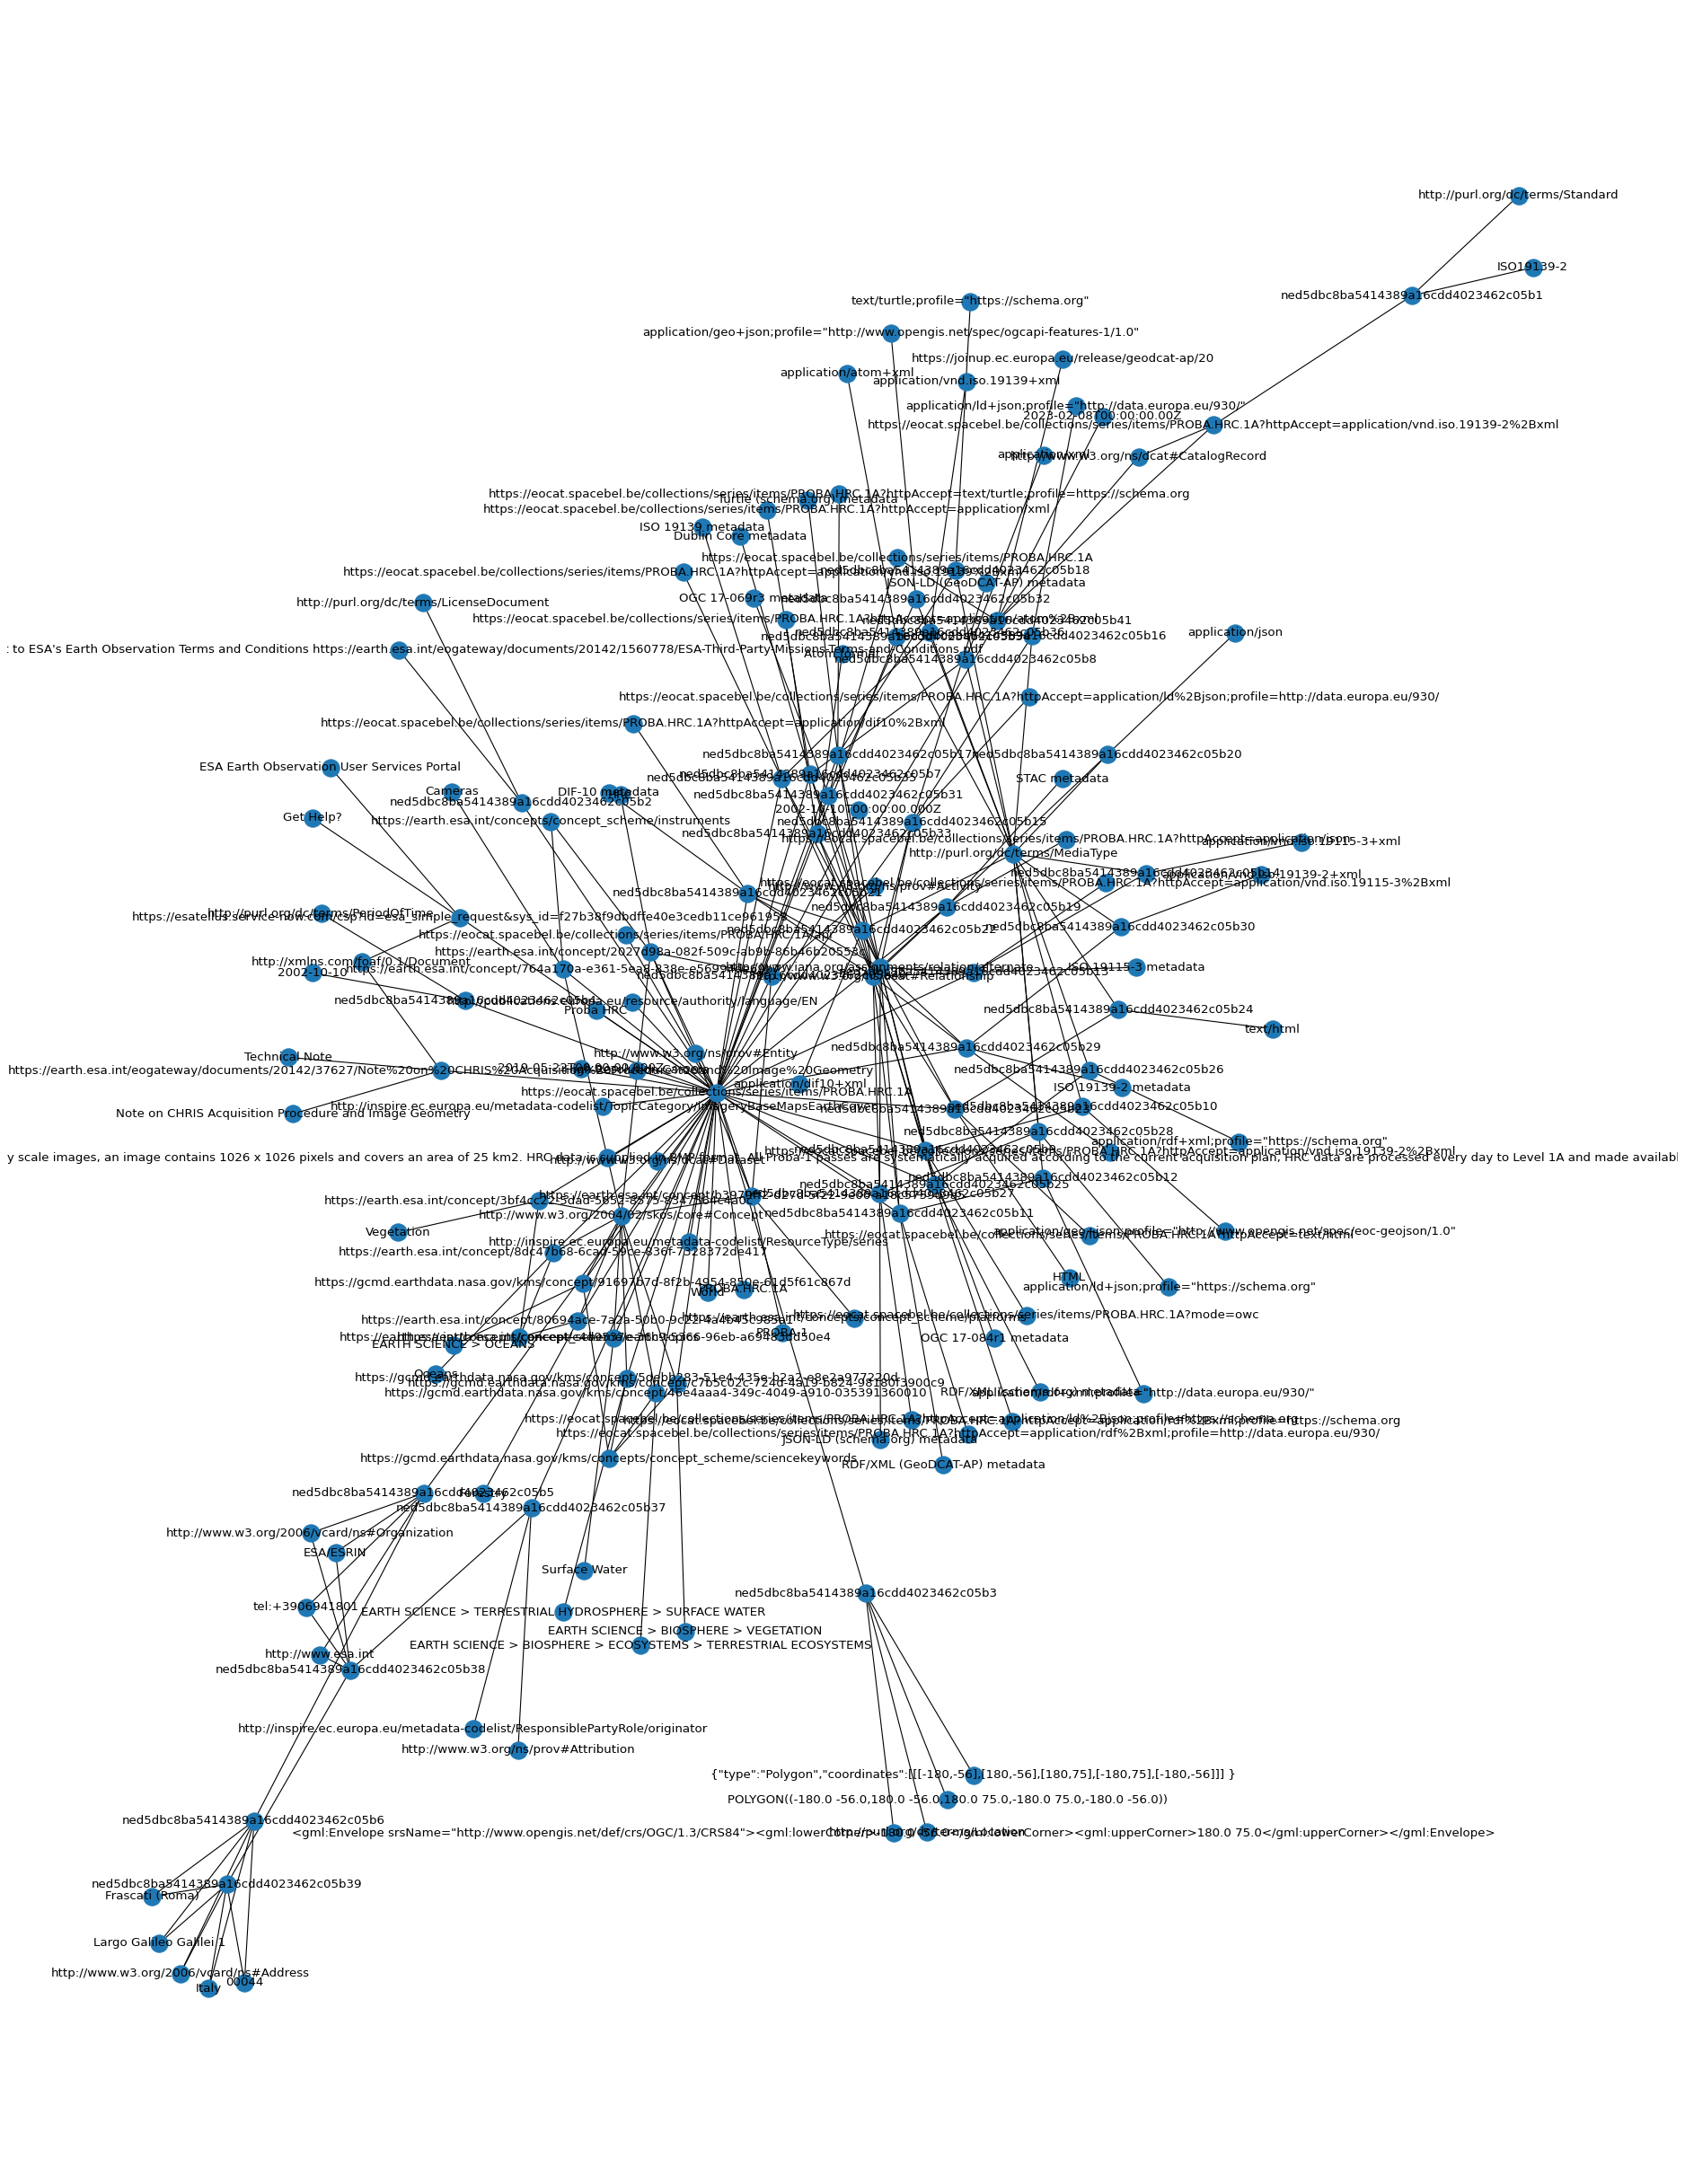

In [446]:
# display Turtle as graph
from matplotlib.pyplot import figure
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx

figure(figsize=(30, 40), dpi=80)
rg = rdflib.Graph()

# TBD: Remove $$ signs from input to avoid bug in JSON-LD to Turtle conversion.
rg.parse(data=response.text.replace("$$", "" ), format='ttl', encoding='utf-8')
G = rdflib_to_networkx_graph(rg)
plt.plot()
nx.draw(G, with_labels=True)

**Example: 9.2**  
>  Represent collection as linked data with Turtle and [Schema.org](#RD40).

In [447]:
resource = URL_LANDING_PAGE + 'collections/series/items/' + series_id
f = 'text/turtle;profile="https://schema.org"'
url = resource +'?httpAccept='+urllib.parse.quote(f)

In [448]:
curl_str = curl_command(url)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A \
	--data-urlencode "httpAccept=text/turtle;profile="https://schema.org""
```


In [449]:
response = requests.get(url)
# response.text
md("```\n" + response.text + "\n```\n")

```
@prefix schema: <https://schema.org/> .
@prefix void:  <http://rdfs.org/ns/void#> .
@prefix eli:   <http://data.europa.eu/eli/ontology#> .
@prefix owl:   <http://www.w3.org/2002/07/owl#> .
@prefix snomed: <http://purl.bioontology.org/ontology/SNOMEDCT/> .
@prefix xsd:   <http://www.w3.org/2001/XMLSchema#> .
@prefix yago:  <http://yago-knowledge.org/resource/> .
@prefix skos:  <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix dbpedia: <http://dbpedia.org/resource/> .
@prefix dct:   <http://purl.org/dc/terms/> .
@prefix rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix dctype: <http://purl.org/dc/dcmitype/> .
@prefix rdfa:  <http://www.w3.org/ns/rdfa#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix bibo:  <http://purl.org/ontology/bibo/> .
@prefix dcat:  <http://www.w3.org/ns/dcat#> .
@prefix wikidata: <http://www.wikidata.org/entity/> .
@prefix foaf:  <http://xmlns.com/foaf/0.1/> .
@prefix dc:    <http://purl.org/dc/elements/1.1/> .

<https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > OCEANS" .

<https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6>
        a       schema:DefinedTerm .

<https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER" .

<https://www.eionet.europa.eu/gemet/en/concept/8922>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://www.eionet.europa.eu/gemet/en/concept/8229>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27>
        a            schema:DefinedTerm ;
        schema:name  "HRC" .

<https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Surface Water" .

<https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Forestry" .

<https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Vegetation" .

<https://www.eionet.europa.eu/gemet/en/concept/5789>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/instruments> ;
        schema:name              "HRC" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27> .

<https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/instruments> ;
        schema:name              "Cameras" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6> .

dbpedia:PROBA  a                 schema:DefinedTerm ;
        schema:inDefinedTermSet  dbpedia:Satellite .

wikidata:Q1479854  a             schema:DefinedTerm ;
        schema:inDefinedTermSet  wikidata:Q854845 .

<https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5>
        a                        schema:DefinedTerm , dbpedia:Satellite , wikidata:Q854845 , yago:Earth_observation_satellite ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/platforms> ;
        schema:name              "PROBA-1" ;
        schema:sameAs            <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , yago:PROBA , dbpedia:PROBA , wikidata:Q1479854 ;
        schema:url               <https://directory.eoportal.org/web/eoportal/satellite-missions/p/proba-1> , <https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba> .

<https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5>
        a            schema:DefinedTerm ;
        schema:name  "PROBA-1" .

<https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS" .

yago:PROBA  a                    schema:DefinedTerm ;
        schema:inDefinedTermSet  yago:Earth_observation_satellite .

<https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://gcmd.earthdata.nasa.gov/kms/concepts/concept_scheme/sciencekeywords> ;
        schema:name              "EARTH SCIENCE > BIOSPHERE > VEGETATION" .

<https://www.eionet.europa.eu/gemet/en/concept/3439>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <http://www.eionet.europa.eu/gemet> .

<https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417>
        a                        schema:DefinedTerm ;
        schema:inDefinedTermSet  <https://earth.esa.int/concepts/concept_scheme/earth-topics> ;
        schema:name              "Oceans" .

<https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A>
        a                             schema:Dataset ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/resolution" ;
                                        schema:value       "High Resolution - HR (5 - 20 m)"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/wavelengthInformation" ;
                                        schema:value       "VIS (0.40 - 0.75 µm)"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "https://earth.esa.int/eop-ext/orbitHeight" ;
                                        schema:value       "615 km"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/orbitType" ;
                                        schema:value       "Sun-synchronous"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "https://earth.esa.int/eop-ext/swathWidth" ;
                                        schema:value       "4 km"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/processorVersion" ;
                                        schema:value       "null"
                                      ] ;
        schema:additionalProperty     [ a                  schema:PropertyValue ;
                                        schema:propertyID  "http://www.opengis.net/eop/2.1/productType" ;
                                        schema:value       "HRC_HRC_1P"
                                      ] ;
        schema:additionalType         dctype:Collection ;
        schema:alternateName          "PROBA.HRC.1A" ;
        schema:creator                [ a                 schema:Organization ;
                                        schema:address    [ a                       schema:PostalAddress ;
                                                            schema:addressCountry   "Italy" ;
                                                            schema:addressLocality  "Frascati (Roma)" ;
                                                            schema:postalCode       "00044" ;
                                                            schema:streetAddress    "Largo Galileo Galilei 1"
                                                          ] ;
                                        schema:email      "eohelp@esa.int" ;
                                        schema:name       "ESA/ESRIN" ;
                                        schema:sameAs     <https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a> , <https://dbpedia.org/resource/European_Space_Agency> , <https://yago-knowledge.org/resource/European_Space_Agency> , <https://ror.org/03wd9za21> ;
                                        schema:telephone  "tel:+3906941801" ;
                                        schema:url        <http://www.esa.int>
                                      ] ;
        schema:dateCreated            "2019-05-22T00:00:00.000Z"^^schema:Date ;
        schema:dateModified           "2019-05-22T00:00:00.000Z"^^schema:Date ;
        schema:description            "The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users." ;
        schema:distribution           [ a                      schema:DataDownload ;
                                        schema:contentUrl      <https://eovoc.spacebel.be/images/esa.png> ;
                                        schema:encodingFormat  "image/png"
                                      ] ;
        schema:identifier             "PROBA.HRC.1A" ;
        schema:includedInDataCatalog  [ a            schema:DataCatalog ;
                                        schema:name  "ESA Catalog"
                                      ] ;
        schema:keywords               "World" , "High Resolution Camera" ;
        schema:keywords               <https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d> , <https://www.eionet.europa.eu/gemet/en/concept/5789> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7> , <https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c> , dbpedia:PROBA , <https://www.eionet.europa.eu/gemet/en/concept/3439> , <https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> , <https://www.eionet.europa.eu/gemet/en/concept/8922> , <https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4> , <https://gcmd.earthdata.nasa.gov/kms/concept/d322ae9d-bde0-448f-948d-777aef096eb6> , <https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1> , <https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9> , <https://gcmd.earthdata.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27> , <https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d> , yago:PROBA , <https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5> , <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://www.eionet.europa.eu/gemet/en/concept/8229> , <https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010> , wikidata:Q1479854 ;
        schema:license                [ a                   schema:CreativeWork ;
                                        schema:description  "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions" ;
                                        schema:url          <https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf>
                                      ] ;
        schema:measurementTechnique   "Cameras" ;
        schema:name                   "Proba HRC" ;
        schema:potentialAction        [ a              schema:SearchAction ;
                                        schema:target  "https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A/api"
                                      ] ;
        schema:potentialAction        [ a                  schema:CreateAction ;
                                        schema:instrument  <https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5> , <https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c> , <https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7>
                                      ] ;
        schema:provider               [ a                 schema:Organization ;
                                        schema:address    [ a                       schema:PostalAddress ;
                                                            schema:addressCountry   "Italy" ;
                                                            schema:addressLocality  "Frascati (Roma)" ;
                                                            schema:postalCode       "00044" ;
                                                            schema:streetAddress    "Largo Galileo Galilei 1"
                                                          ] ;
                                        schema:email      "eohelp@esa.int" ;
                                        schema:name       "ESA/ESRIN" ;
                                        schema:sameAs     <https://gcmd.earthdata.nasa.gov/kms/concept/c56b4a86-82f8-4f15-98ba-c5f7abe8ee5a> , <https://yago-knowledge.org/resource/European_Space_Agency> , <https://dbpedia.org/resource/European_Space_Agency> , <https://ror.org/03wd9za21> ;
                                        schema:telephone  "tel:+3906941801" ;
                                        schema:url        <http://www.esa.int>
                                      ] ;
        schema:spatialCoverage        [ a           schema:Place ;
                                        schema:geo  [ a               schema:GeoShape ;
                                                      schema:polygon  "-56.0 -180.0 -56.0 180.0 75.0 180.0 75.0 -180.0 -56.0 -180.0"
                                                    ]
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139-2%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19139-2+xml" ;
                                        schema:name            "ISO 19139-2 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/xml> ;
                                        schema:encodingFormat  "application/xml" ;
                                        schema:name            "Dublin Core metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "text/turtle;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "Turtle (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/html> ;
                                        schema:encodingFormat  "text/html" ;
                                        schema:name            "HTML"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/icon> ;
                                        schema:contentUrl      <https://eovoc.spacebel.be/images/esa.png> ;
                                        schema:encodingFormat  "image/png"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19115-3%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19115-3+xml" ;
                                        schema:name            "ISO 19115-3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/dif10%2Bxml> ;
                                        schema:encodingFormat  "application/dif10+xml" ;
                                        schema:name            "DIF-10 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/describedby> ;
                                        schema:contentUrl      <https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry> ;
                                        schema:encodingFormat  "application/pdf" ;
                                        schema:name            "Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/json> ;
                                        schema:encodingFormat  "application/json" ;
                                        schema:name            "STAC metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:ListItem ;
                                        schema:dateCreated     "2019-05-22T00:00:00.00Z"^^schema:Date ;
                                        schema:dateModified    "2023-02-08T00:00:00.00Z"^^schema:Date ;
                                        schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                        schema:inLanguage      <http://id.loc.gov/vocabulary/iso639-1/en>
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/atom%2Bxml> ;
                                        schema:encodingFormat  "application/atom+xml" ;
                                        schema:name            "Atom format"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/ogcapi-features-1/1.0\"" ;
                                        schema:name            "OGC 17-069r3 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/describedby> ;
                                        schema:contentUrl      <https://esatellus.service-now.com/csp?id=esa_simple_request&sys_id=f27b38f9dbdffe40e3cedb11ce961958> ;
                                        schema:encodingFormat  "text/html" ;
                                        schema:name            "Get Help? - ESA Earth Observation User Services Portal"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"https://schema.org\"" ;
                                        schema:name            "JSON-LD (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=https://schema.org> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"https://schema.org\"" ;
                                        schema:name            "RDF/XML (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?mode=owc> ;
                                        schema:encodingFormat  "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\"" ;
                                        schema:name            "OGC 17-084r1 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/ld+json;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "JSON-LD (GeoDCAT-AP) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/vnd.iso.19139%2Bxml> ;
                                        schema:encodingFormat  "application/vnd.iso.19139+xml" ;
                                        schema:name            "ISO 19139 metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=text/turtle;profile=https://schema.org> ;
                                        schema:encodingFormat  "text/turtle;profile=\"https://schema.org\"" ;
                                        schema:name            "Turtle (schema.org) metadata"
                                      ] ;
        schema:subjectOf              [ a                      schema:MediaObject ;
                                        schema:additionalType  <http://www.iana.org/assignments/relation/alternate> ;
                                        schema:contentUrl      <https://eocat.spacebel.be/collections/series/items/PROBA.HRC.1A?httpAccept=application/rdf%2Bxml;profile=http://data.europa.eu/930/> ;
                                        schema:encodingFormat  "application/rdf+xml;profile=\"http://data.europa.eu/930/\"" ;
                                        schema:name            "RDF/XML (GeoDCAT-AP) metadata"
                                      ] ;
        schema:temporalCoverage       "2002-10-10T00:00:00.000Z/" ;
        schema:thumbnailUrl           <https://eovoc.spacebel.be/images/esa.png> .

<http://id.loc.gov/vocabulary/iso639-1/en>
        a            schema:Language ;
        schema:name  "en" .

```


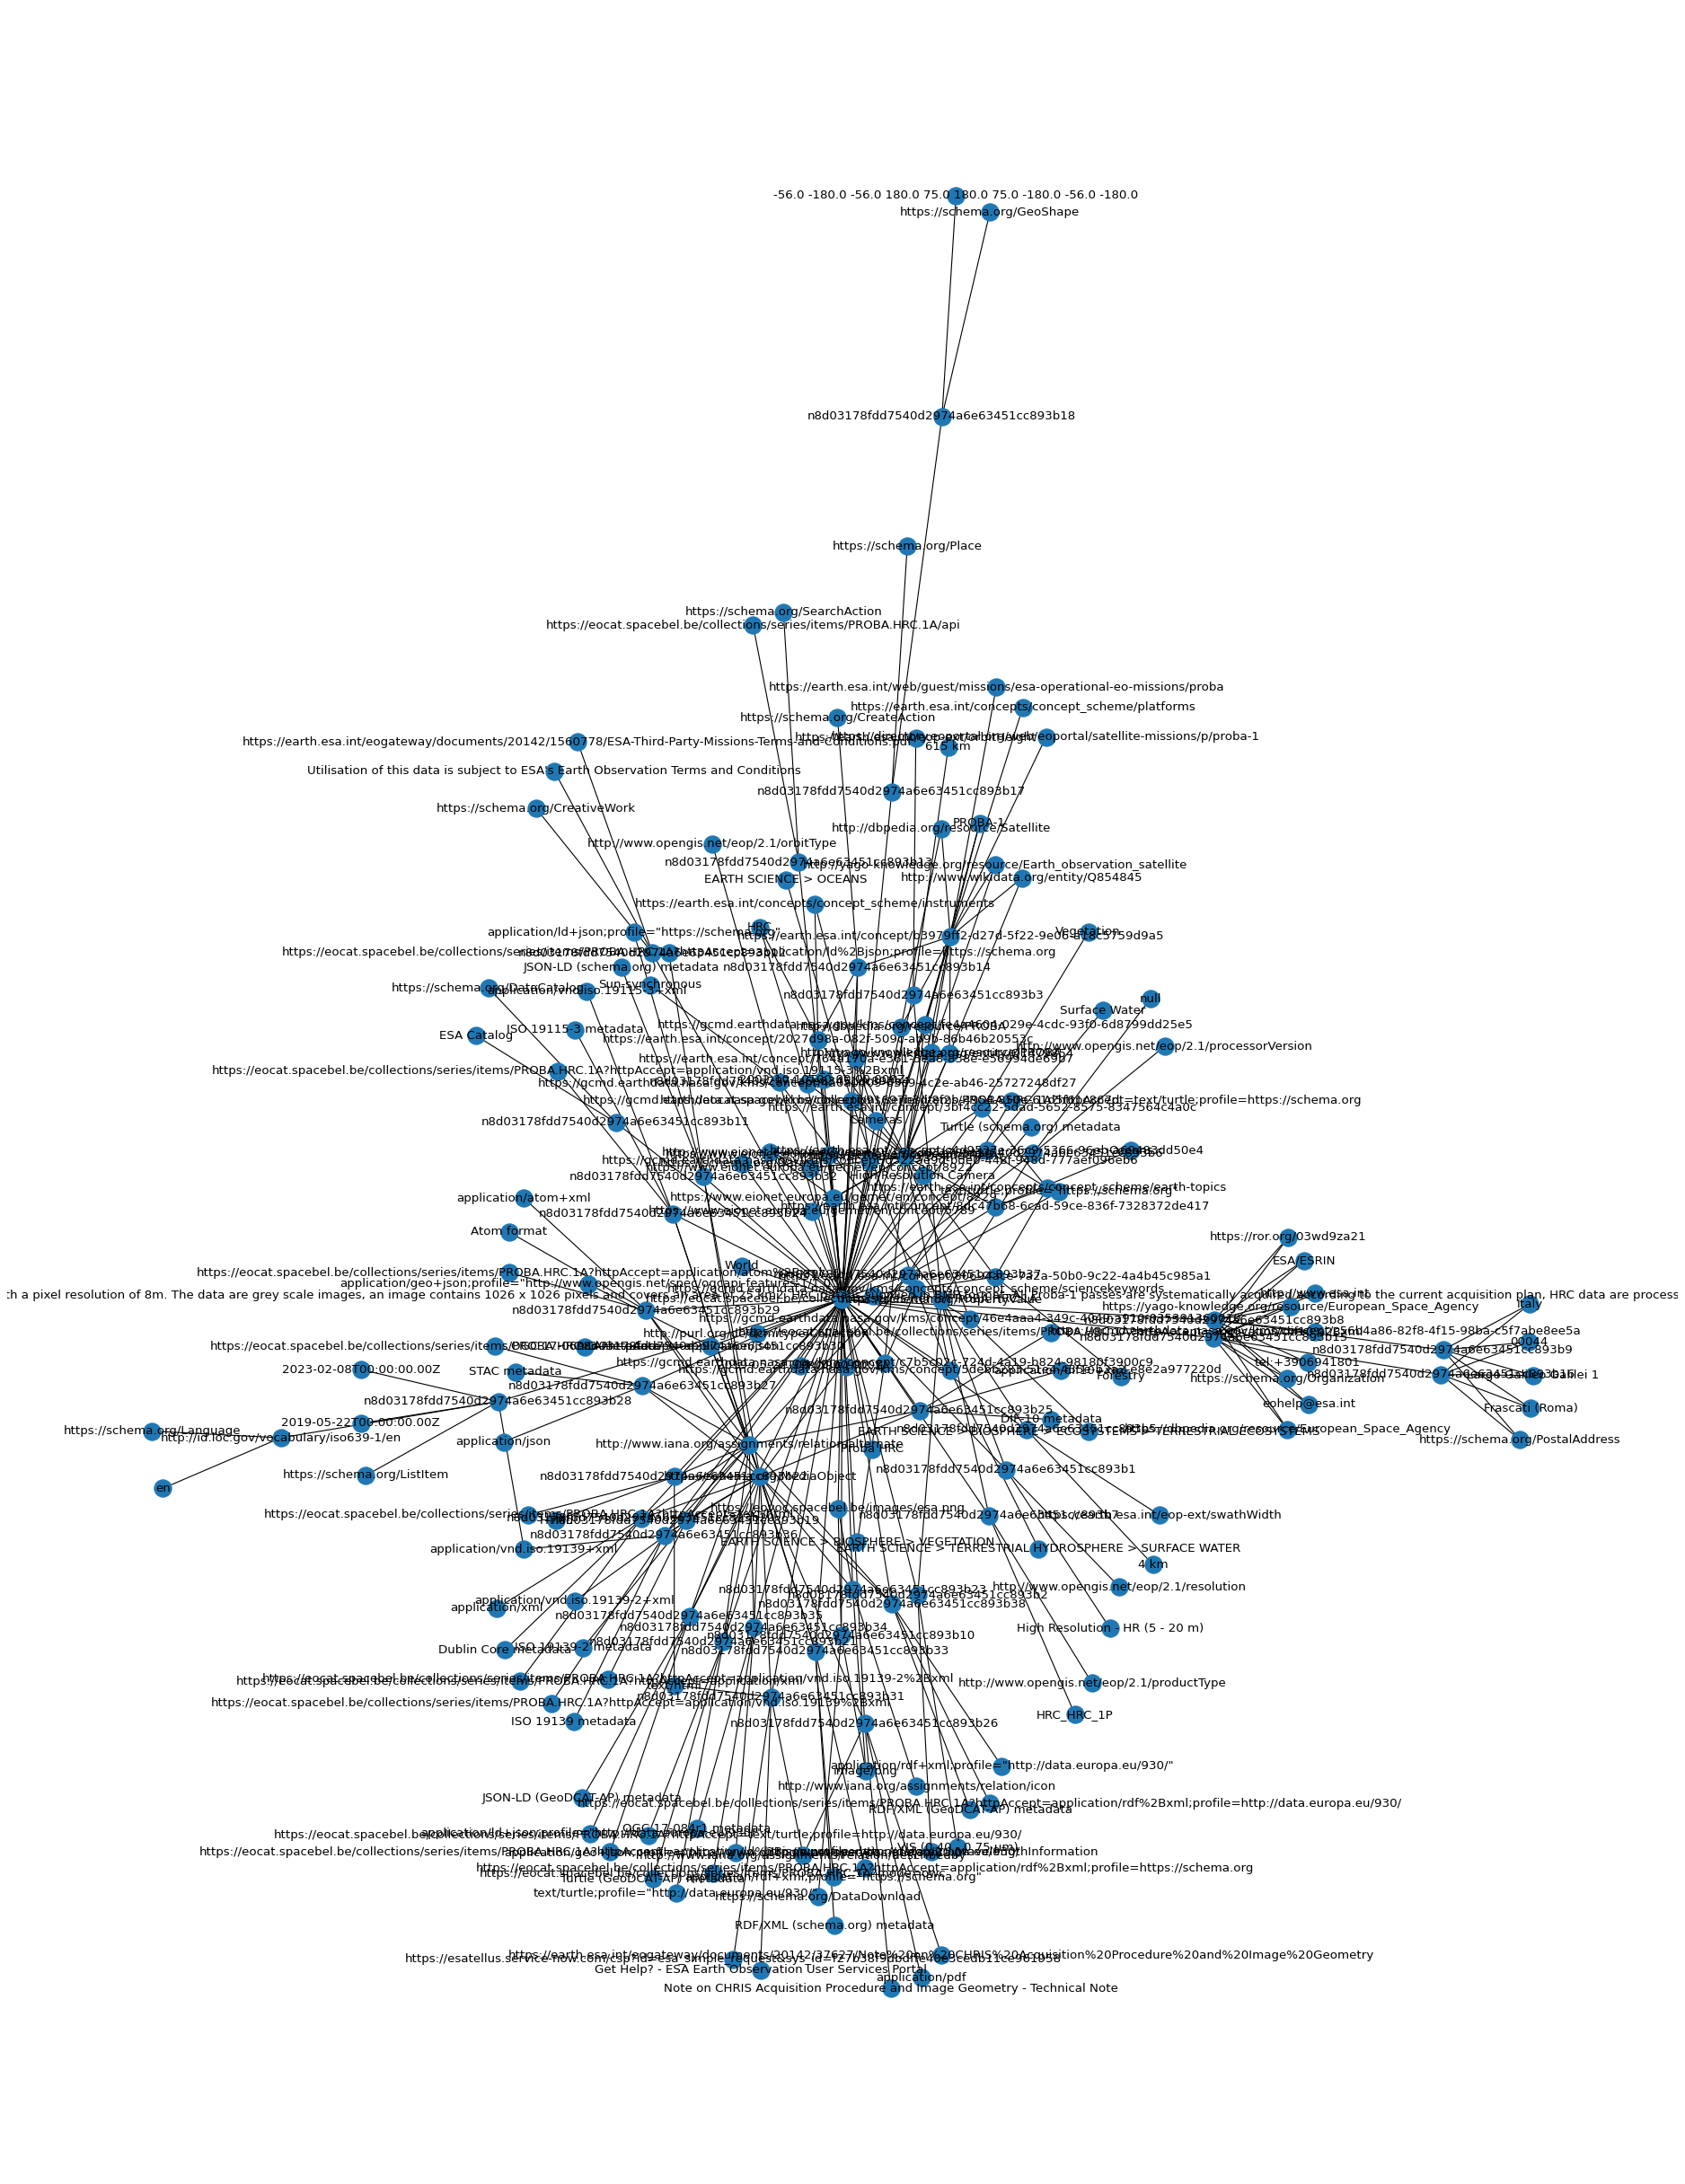

In [450]:
# display Turtle as graph
from matplotlib.pyplot import figure
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx

figure(figsize=(30, 40), dpi=80)
rg = rdflib.Graph()
# TBD: Remove $$ signs from input to avoid bug in JSON-LD to Turtle conversion.
rg.parse(data=response.text.replace("$$", "" ), format='ttl', encoding='utf-8')
# rg.parse(data=response.text, format='ttl', encoding='utf-8')
G = rdflib_to_networkx_graph(rg)
plt.plot()
nx.draw(G, with_labels=True)

### Additional search parameters

Additional search parameters beyond the OGC API Features search parameters can be used to filter results (See also https://docs.opengeospatial.org/is/17-069r3/17-069r3.html#_parameters_for_filtering_on_feature_properties).  They are defined in the OpenAPI definition as additional HTTP query parameters equivalent to the available OpenSearch parameters. 

Note that not all search parameters apply to all collections.  The available parameters for granule search are advertized for each individual collection in the corresponding OpenSearch OSDD document.  Future versions of the interface will support the `/queryables` response and may support the `filter` parameter.

## Further Reading

| **ID**  | **Title** | 
| -------- | --------- | 
| `RD07` <a name="RD07"></a> | [OASIS searchRetrieve: Part 3. APD Binding for SRU 2.0 Version 1.0](http://docs.oasis-open.org/search-ws/searchRetrieve/v1.0/os/part3-sru2.0/searchRetrieve-v1.0-os-part3-sru2.0.html) |
| `RD19` <a name="RD19"></a> | [ODC STAC - Plot STAC Items on a map ](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map) | 
| `RD20` <a name="RD20"></a> | [OGC17-069r3, OGC API - Features - Part 1: Core](https://docs.opengeospatial.org/is/17-069r3/17-069r3.html) | 
| `RD21` <a name="RD21"></a> | [OGC17-079r1, OGC API - Features - Part 3: Filtering](https://docs.opengeospatial.org/DRAFTS/19-079r1.html)  | 
| `RD22` <a name="RD22"></a> | [OGC21-065, Common Query Language (CQL2)](https://docs.ogc.org/DRAFTS/21-065.html)  | 
| `RD23` <a name="RD23"></a> | [RFC 7946 - The GeoJSON Format](https://datatracker.ietf.org/doc/html/rfc7946) | 
| `RD24` <a name="RD24"></a>| [JSON Schema: A Media Type for Describing JSON Documents, draft-handrews-json-schema-02](https://datatracker.ietf.org/doc/html/draft-handrews-json-schema-02) |
| `RD25` <a name="RD25"></a>| [STAC API - Collection Search](https://github.com/stac-api-extensions/collection-search) |
| `RD26` <a name="RD26"></a>| [STAC API - Filter Extension](https://github.com/stac-api-extensions/filter) |
| `RD31` <a name="RD31"></a>| [OWSLib - Usage](https://geopython.github.io/OWSLib/usage.html#ogc-api) |
| `RD32` <a name="RD32"></a> | [OGC17-003r2, OGC EO Dataset Metadata GeoJSON(-LD) Encoding Standard](https://docs.opengeospatial.org/is/17-003r2/17-003r2.html)  | 
| `RD33` <a name="RD33"></a> | [OGC17-047r1, OGC OpenSearch-EO GeoJSON(-LD) Response Encoding Standard](https://docs.ogc.org/is/17-047r1/17-047r1.html)  | 
| `RD34` <a name="RD34"></a> | [OGC17-084r1, EO Collection GeoJSON(-LD) Encoding Best Practice](https://docs.ogc.org/bp/17-084r1/17-084r1.html)  |
| `RD35` <a name="RD35"></a> | [OGC19-020r1, OGC Testbed-15: Catalogue and Discovery Engineering Report](https://docs.ogc.org/per/19-020r1.html)  |
| `RD36` <a name="RD36"></a> | [JSON-LD 1.1, A JSON-based Serialization for Linked Data, W3C Recommendation 16 July 2020](https://www.w3.org/TR/json-ld11/)  |
| `RD37` <a name="RD37"></a> | [RDF 1.1 XML Syntax, W3C Recommendation 25 February 2014](http://www.w3.org/TR/rdfsyntax-grammar/)  |
| `RD38` <a name="RD38"></a> | [RDF 1.1 Turtle, Terse RDF Triple Language, W3C Recommendation 25 February 2014](http://www.w3.org/TR/turtle/)  |
| `RD39` <a name="RD39"></a> | [GeoDCAT-AP Version 2.0.0, European Commission](https://semiceu.github.io/GeoDCAT-AP/releases/2.0.0/)  |
| `RD40` <a name="RD40"></a> | [Schema.org](https://schema.org/)  |




